# SNIS IPLA

In [80]:
import numpy as np
from tqdm import tqdm
from implementation import IPLA, SNIS_IPLA, PGD, SVGD_EM
from matplotlib import pyplot as plt
import sklearn as sk
from sklearn import datasets
import pandas as pd
plt.rcParams['figure.dpi'] = 200

In [81]:
file_path = "breast-cancer-wisconsin.data"

full_data = pd.read_csv(file_path, delimiter=",", header=None, index_col=0)
# replace non numeric values with NaN
full_data = full_data.where(full_data.applymap(
    lambda x: str(x).isdigit()
))

full_data.dropna(inplace=True)
full_data = full_data.astype(int)
train_data = full_data.sample(frac=0.8, random_state=0)
test_data = full_data.drop(train_data.index)
print(full_data.shape)
test_labels = test_data[10].to_numpy()
train_labels = train_data[10].to_numpy()
test_data = test_data.drop(10, axis=1).to_numpy()
train_data = train_data.drop(10, axis=1).to_numpy()
y_train = [train_data, train_labels]
y_test = [test_data, test_labels]


(683, 10)


## Auxiliary functions

We will test with:

$$
p(\theta,x, y) = \prod_{d=1}^D\exp\left(-\frac{(x_d-\theta)^2}{2} - \frac{(y_d-x_d)^2}{2}-\log(2\pi)\right)
$$

$$
= \exp\left(-D\log(2\pi)-\left[\sum_{d=1}^D\frac{(x_d-\theta)^2}{2} + \frac{(y_d-x_d)^2}{2}\right]\right)
$$

$$
\nabla_\theta p(\theta,x,y) = p(\theta, x, y)\left\{\sum_{d=1}^D x_d - D\theta\right\}
$$

In [82]:
def p(theta, x, y):
    D = np.shape(x)[0]
    return np.exp(-np.sum((x-theta)**2/2) - np.sum((y-x)**2/2) - D*np.log(2*np.pi))

def p_grad_theta(theta, x, y):
    D = np.shape(x)[0]
    return -(np.sum(x) - D*theta) * p(theta, x, y)

def log_p_grad_theta(theta, x, y):
    D = x.shape[0]
    return (np.sum(x) - D*theta)*p(theta, x, y)

def U(theta, Xi, y):
    D = np.shape(Xi)[0]
    return D * np.log(2*np.pi) + np.sum((Xi-theta)**2/2) + np.sum((y-Xi)**2/2)

def U_grad_X(theta, x, y):
    return -(-2*x + y + theta)

def U_grad_theta(theta, Xi, y):
    D = np.shape(Xi)[0]
    return D*(theta - np.mean(Xi))

def ave_grad_U_theta(theta, X, y):
    D, N = np.shape(X)
    return D*(theta - np.mean(X))

def exponential_kernel(x1, x2, sigma=1):
    return np.exp(-np.sum((x1-x2)**2)/(2*sigma**2))

def grad_exponential_kernel_x1(x1, x2, sigma=1):
    return ((x2-x1)/(sigma**2)) * np.exp(-np.sum((x1-x2)**2/(2*sigma**2)))

We also implement Bayesian logistic regression, where $p$ is of the form:

$$
p_\theta(x, y) = \mathcal{N}(x;\theta 1_{D_x}, 5I_{D_x})\prod_{(f,\,l)\in y}s(f^\top x)^l[1-s(f^\top x)]^{1-l}
\\= \frac{1}{(2\pi)^{D_x/2}5^{D_x/2}}\exp\left(-\frac{\|x-1_{D_x}\theta\|^2}{10}\right)\prod_{(f,\,l)\in y}s(f^\top x)^l[1-s(f^\top x)]^{1-l}
$$

And:

$$
\nabla_\theta p_\theta(x,y)= \frac{1}{(2\pi)^{D_x/2}5^{D_x/2}}\exp\left(-\frac{\|x-1_{D_x}\theta\|^2}{10}\right)\prod_{(f,\,l)\in y}s(f^\top x)^l[1-s(f^\top x)]^{1-l}\left(\frac{2}{5}(1_{D_x}\theta - x)\right)
$$

Observe that then, $U$ becomes:

$$
U(\theta, x) = \sum_{(f,\,l)\in y} [\log(1+e^{f^\top x}) - lf^\top x]+ \frac{\|x-1_{D_x}\theta\|^2}{5}
$$

Then:

$$
\nabla_x U(\theta,x) = \sum_{(f,l)\in y}\left[-lf + \frac{fe^{x^\top f}}{1+e^{f^\top x}}\right] + \frac{2}{5}(x-1_{D_x}\theta)
$$

$$
\nabla_\theta U(\theta,x) = \frac{2}{5}(1_{D_x}\theta - x)
$$

And so:

$$
\frac{1}{N}\sum_{i=1}^N\nabla_\theta U(\theta,x_i) = \frac{2}{5N}\sum_{i=1}^N(1_{D_x}\theta - x_i) = \frac{2}{5}(1_{D_x}\theta - \bar{x})
$$

In [146]:
def ave_grad_U_theta_regression(theta, X, y):
    Dx = np.shape(X)[0]
    return (2/5)*(np.ones(Dx)*theta - np.mean(X, axis=1))

def grad_U_Xi_regression(theta, Xi, y):
    Dx = np.shape(Xi)[0]
    f = y[0]
    l = y[1].reshape(-1,1)
    return  np.sum(-l*f + f*(np.exp(np.dot(f, Xi))/(1 + np.exp(np.dot(f, Xi)))).reshape(-1,1), axis=0) - (2/5)*(np.ones(Dx)*theta - Xi)

def grad_U_theta_regression(theta, Xi, y):
    Dx = np.shape(Xi)[0]
    return (2/5)*(np.ones(Dx)*theta - Xi)

def grad_U_X_regression(theta, X, y):
    out = np.zeros(np.shape(X))
    for i in range(np.shape(X)[1]):
        out[:,i] = grad_U_Xi_regression(theta, X[:,i], y)
    return out

def U_regression(theta, Xi, y):
    f = y[0]
    l = y[1].reshape(-1,1)
    return np.sum(np.log(1+np.exp(np.dot(f, Xi))) - l*np.dot(f, Xi)) + (1/5)*np.dot(theta - Xi, theta - Xi)
U_regression(th0, X0[:,0], y_train)



206638.26487980847

# SNIS IPLA

In [179]:
D = 3
nsteps = 500
Nparticles = 50
thdata = 2
X0 = np.zeros((D, Nparticles))
th0  = np.array([0.0])
y = np.random.normal(0,1, (D,1)) + np.random.normal(thdata, 1, (D,1))
best_theta = y.mean()*np.ones(nsteps)
grads_U_IPLA = (ave_grad_U_theta, U_grad_X)
grads_U_SNIS = (U_grad_theta, U_grad_X)

In [180]:
gamma_experiments = 5*1e-2
nexperiments = 10
average_thetas_dict = {"PGD": np.zeros((nsteps+1,1)), "IPLA": np.zeros((nsteps+1,1)),"SNIS-IPLA": np.zeros((nsteps+1,1)), "SVGD-EM": np.zeros((nsteps+1,1))}
for experiment in tqdm(range(nexperiments)):
    PGD_test = PGD(th0, X0, grads_U_IPLA, gamma=gamma_experiments, y=y)
    IPLA_test = IPLA(th0, X0, grads_U_IPLA, gamma=gamma_experiments, y=y)
    SNIS_IPLA_test = SNIS_IPLA(th0, X0, U, grads_U_SNIS, gamma=gamma_experiments, test=False, y=y)
    SVGD_EM_test = SVGD_EM(th0, X0, grads_U_IPLA, exponential_kernel, grad_exponential_kernel_x1, gamma=gamma_experiments, noise=1, y=y)
    for i in tqdm(range(nsteps)):
        PGD_test.iterate()
        IPLA_test.iterate()
        SNIS_IPLA_test.iterate()
        SVGD_EM_test.iterate()

    average_thetas_dict["PGD"] = average_thetas_dict["PGD"] + 1/nexperiments * np.array(PGD_test.thetas)
    average_thetas_dict["IPLA"] = average_thetas_dict["IPLA"] + 1/nexperiments * np.array(IPLA_test.thetas)
    average_thetas_dict["SNIS-IPLA"] = average_thetas_dict["SNIS-IPLA"] + 1/nexperiments * np.array(SNIS_IPLA_test.thetas)
    average_thetas_dict["SVGD-EM"] = average_thetas_dict["SVGD-EM"] + 1/nexperiments * np.array(SVGD_EM_test.thetas)




  0%|          | 0/10 [00:00<?, ?it/s]

Matrix not pd
Jitter: 1e-15
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 4.51094500e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  4.50286021e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 4.51805882e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99940146e-01 0.00000000e+00 0.00000000e+00 ... 1.44422062e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99940146e-01 0.00000000e+00 ... 0.00000000e+00
  1.44165056e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99940146e-01 ... 0.00000000e+00
  0.00000000e+00 1.46607711e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99602628e-01 0.00000000e+00 0.00000000e+00 ... 1.41971497e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99602628e-01 0.00000000e+00 ... 0.00000000e+00
  1.42668627e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99602628e-01 ... 0.00000000e+00
  0.00000000e+00 1.40424672e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99997302e-01 0.00000000e+00 0.00000000e+00 ... 1.36800114e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99997302e-01 0.00000000e+00 ... 0.00000000e+00
  1.42071978e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99997302e-01 ... 0.00000000e+00
  0.00000000e+00 1.44818181e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99679915e-01 0.00000000e+00 0.00000000e+00 ... 1.42262088e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99679915e-01 0.00000000e+00 ... 0.00000000e+00
  1.48192504e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99679915e-01 ... 0.00000000e+00
  0.00000000e+00 1.45969052e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94491983e-01 0.00000000e+00 0.00000000e+00 ... 1.50351768e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94491983e-01 0.00000000e+00 ... 0.00000000e+00
  1.48917926e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94491983e-01 ... 0.00000000e+00
  0.00000000e+00 1.48594168e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99427579e-01 0.00000000e+00 0.00000000e+00 ... 1.52673576e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99427579e-01 0.00000000e+00 ... 0.00000000e+00
  1.52687284e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99427579e-01 ... 0.00000000e+00
  0.00000000e+00 1.52047319e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96038430e-01 0.00000000e+00 0.00000000e+00 ... 1.41350928e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96038430e-01 0.00000000e+00 ... 0.00000000e+00
  1.39395637e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96038430e-01 ... 0.00000000e+00
  0.00000000e+00 1.39452510e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93087272e-01 0.00000000e+00 0.00000000e+00 ... 1.39418760e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93087272e-01 0.00000000e+00 ... 0.00000000e+00
  1.44113828e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93087272e-01 ... 0.00000000e+00
  0.00000000e+00 1.41876558e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99388093e-01 0.00000000e+00 0.00000000e+00 ... 1.43728903e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99388093e-01 0.00000000e+00 ... 0.00000000e+00
  1.43753435e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99388093e-01 ... 0.00000000e+00
  0.00000000e+00 1.49012895e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97562046e-01 0.00000000e+00 0.00000000e+00 ... 1.38689145e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97562046e-01 0.00000000e+00 ... 0.00000000e+00
  1.46123482e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97562046e-01 ... 0.00000000e+00
  0.00000000e+00 1.41427408e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98004705e-01 0.00000000e+00 0.00000000e+00 ... 1.44031477e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98004705e-01 0.00000000e+00 ... 0.00000000e+00
  1.43654947e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98004705e-01 ... 0.00000000e+00
  0.00000000e+00 1.43546143e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99236147e-01 0.00000000e+00 0.00000000e+00 ... 1.43365123e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99236147e-01 0.00000000e+00 ... 0.00000000e+00
  1.47145325e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99236147e-01 ... 0.00000000e+00
  0.00000000e+00 1.49328430e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99903002e-01 0.00000000e+00 0.00000000e+00 ... 1.43226317e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99903002e-01 0.00000000e+00 ... 0.00000000e+00
  1.42734339e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99903002e-01 ... 0.00000000e+00
  0.00000000e+00 1.45866959e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97269263e-01 0.00000000e+00 0.00000000e+00 ... 1.62430139e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97269263e-01 0.00000000e+00 ... 0.00000000e+00
  1.57151599e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97269263e-01 ... 0.00000000e+00
  0.00000000e+00 1.56622479e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94965622e-01 0.00000000e+00 0.00000000e+00 ... 1.58953127e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94965622e-01 0.00000000e+00 ... 0.00000000e+00
  1.59988204e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94965622e-01 ... 0.00000000e+00
  0.00000000e+00 1.62762685e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91302842e-01 0.00000000e+00 0.00000000e+00 ... 1.53548246e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91302842e-01 0.00000000e+00 ... 0.00000000e+00
  1.56917011e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91302842e-01 ... 0.00000000e+00
  0.00000000e+00 1.60569437e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92072861e-01 0.00000000e+00 0.00000000e+00 ... 1.52132654e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92072861e-01 0.00000000e+00 ... 0.00000000e+00
  1.51169679e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92072861e-01 ... 0.00000000e+00
  0.00000000e+00 1.56355975e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.90734073e-01 0.00000000e+00 0.00000000e+00 ... 1.61546940e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.90734073e-01 0.00000000e+00 ... 0.00000000e+00
  1.61278751e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90734073e-01 ... 0.00000000e+00
  0.00000000e+00 1.64839356e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.85836144e-01 0.00000000e+00 0.00000000e+00 ... 1.51812349e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.85836144e-01 0.00000000e+00 ... 0.00000000e+00
  1.51458876e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.85836144e-01 ... 0.00000000e+00
  0.00000000e+00 1.53608185e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.89988230e-01 0.00000000e+00 0.00000000e+00 ... 1.59532696e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.89988230e-01 0.00000000e+00 ... 0.00000000e+00
  1.62681903e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.89988230e-01 ... 0.00000000e+00
  0.00000000e+00 1.61635220e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99707892e-01 0.00000000e+00 0.00000000e+00 ... 1.47940887e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99707892e-01 0.00000000e+00 ... 0.00000000e+00
  1.47197667e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99707892e-01 ... 0.00000000e+00
  0.00000000e+00 1.47661776e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93519115e-01 0.00000000e+00 0.00000000e+00 ... 1.54937763e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93519115e-01 0.00000000e+00 ... 0.00000000e+00
  1.56550803e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93519115e-01 ... 0.00000000e+00
  0.00000000e+00 1.59445158e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99470611e-01 0.00000000e+00 0.00000000e+00 ... 1.47433588e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99470611e-01 0.00000000e+00 ... 0.00000000e+00
  1.44704986e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99470611e-01 ... 0.00000000e+00
  0.00000000e+00 1.47279599e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95070459e-01 0.00000000e+00 0.00000000e+00 ... 1.40215351e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95070459e-01 0.00000000e+00 ... 0.00000000e+00
  1.43168431e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95070459e-01 ... 0.00000000e+00
  0.00000000e+00 1.48517541e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96931308e-01 0.00000000e+00 0.00000000e+00 ... 1.49591401e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96931308e-01 0.00000000e+00 ... 0.00000000e+00
  1.51884752e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96931308e-01 ... 0.00000000e+00
  0.00000000e+00 1.50040644e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93038456e-01 0.00000000e+00 0.00000000e+00 ... 1.53483942e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93038456e-01 0.00000000e+00 ... 0.00000000e+00
  1.55287610e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93038456e-01 ... 0.00000000e+00
  0.00000000e+00 1.53433204e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96919043e-01 0.00000000e+00 0.00000000e+00 ... 1.47517619e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96919043e-01 0.00000000e+00 ... 0.00000000e+00
  1.51713170e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96919043e-01 ... 0.00000000e+00
  0.00000000e+00 1.49783982e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97675535e-01 0.00000000e+00 0.00000000e+00 ... 1.35832484e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97675535e-01 0.00000000e+00 ... 0.00000000e+00
  1.40919008e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97675535e-01 ... 0.00000000e+00
  0.00000000e+00 1.43440335e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91497986e-01 0.00000000e+00 0.00000000e+00 ... 1.44838372e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91497986e-01 0.00000000e+00 ... 0.00000000e+00
  1.44913214e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91497986e-01 ... 0.00000000e+00
  0.00000000e+00 1.49875534e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.89223663e-01 0.00000000e+00 0.00000000e+00 ... 1.45673643e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.89223663e-01 0.00000000e+00 ... 0.00000000e+00
  1.49868048e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.89223663e-01 ... 0.00000000e+00
  0.00000000e+00 1.50171090e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.90876951e-01 0.00000000e+00 0.00000000e+00 ... 1.49047401e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.90876951e-01 0.00000000e+00 ... 0.00000000e+00
  1.52871993e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90876951e-01 ... 0.00000000e+00
  0.00000000e+00 1.50340627e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98125599e-01 0.00000000e+00 0.00000000e+00 ... 1.49863859e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98125599e-01 0.00000000e+00 ... 0.00000000e+00
  1.50285164e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98125599e-01 ... 0.00000000e+00
  0.00000000e+00 1.53525061e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94131104e-01 0.00000000e+00 0.00000000e+00 ... 1.42688708e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94131104e-01 0.00000000e+00 ... 0.00000000e+00
  1.45745823e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94131104e-01 ... 0.00000000e+00
  0.00000000e+00 1.45054788e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95055910e-01 0.00000000e+00 0.00000000e+00 ... 1.48958994e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95055910e-01 0.00000000e+00 ... 0.00000000e+00
  1.50762590e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95055910e-01 ... 0.00000000e+00
  0.00000000e+00 1.48816007e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.87111216e-01 0.00000000e+00 0.00000000e+00 ... 1.44569976e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.87111216e-01 0.00000000e+00 ... 0.00000000e+00
  1.43528919e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.87111216e-01 ... 0.00000000e+00
  0.00000000e+00 1.45797742e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92194036e-01 0.00000000e+00 0.00000000e+00 ... 1.42708225e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92194036e-01 0.00000000e+00 ... 0.00000000e+00
  1.46727378e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92194036e-01 ... 0.00000000e+00
  0.00000000e+00 1.47119676e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.90609639e-01 0.00000000e+00 0.00000000e+00 ... 1.41054601e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.90609639e-01 0.00000000e+00 ... 0.00000000e+00
  1.43399134e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90609639e-01 ... 0.00000000e+00
  0.00000000e+00 1.50101684e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93725898e-01 0.00000000e+00 0.00000000e+00 ... 1.43764589e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93725898e-01 0.00000000e+00 ... 0.00000000e+00
  1.50888930e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93725898e-01 ... 0.00000000e+00
  0.00000000e+00 1.47696831e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.87460371e-01 0.00000000e+00 0.00000000e+00 ... 1.49459075e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.87460371e-01 0.00000000e+00 ... 0.00000000e+00
  1.49279950e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.87460371e-01 ... 0.00000000e+00
  0.00000000e+00 1.51617862e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93759114e-01 0.00000000e+00 0.00000000e+00 ... 1.48523611e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93759114e-01 0.00000000e+00 ... 0.00000000e+00
  1.49950889e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93759114e-01 ... 0.00000000e+00
  0.00000000e+00 1.48353159e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97906475e-01 0.00000000e+00 0.00000000e+00 ... 1.53886958e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97906475e-01 0.00000000e+00 ... 0.00000000e+00
  1.58652995e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97906475e-01 ... 0.00000000e+00
  0.00000000e+00 1.60973937e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97431023e-01 0.00000000e+00 0.00000000e+00 ... 1.53156416e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97431023e-01 0.00000000e+00 ... 0.00000000e+00
  1.51135383e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97431023e-01 ... 0.00000000e+00
  0.00000000e+00 1.50289039e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96276654e-01 0.00000000e+00 0.00000000e+00 ... 1.48331560e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96276654e-01 0.00000000e+00 ... 0.00000000e+00
  1.60703863e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96276654e-01 ... 0.00000000e+00
  0.00000000e+00 1.58415807e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93769480e-01 0.00000000e+00 0.00000000e+00 ... 1.50917337e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93769480e-01 0.00000000e+00 ... 0.00000000e+00
  1.56187914e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93769480e-01 ... 0.00000000e+00
  0.00000000e+00 1.58722620e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99995004e-01 0.00000000e+00 0.00000000e+00 ... 1.40158684e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99995004e-01 0.00000000e+00 ... 0.00000000e+00
  1.41280921e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99995004e-01 ... 0.00000000e+00
  0.00000000e+00 1.41457345e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98852520e-01 0.00000000e+00 0.00000000e+00 ... 1.39583424e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98852520e-01 0.00000000e+00 ... 0.00000000e+00
  1.44752177e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98852520e-01 ... 0.00000000e+00
  0.00000000e+00 1.47120358e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95648847e-01 0.00000000e+00 0.00000000e+00 ... 1.42192088e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95648847e-01 0.00000000e+00 ... 0.00000000e+00
  1.42934931e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95648847e-01 ... 0.00000000e+00
  0.00000000e+00 1.45134227e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92703499e-01 0.00000000e+00 0.00000000e+00 ... 1.45319567e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92703499e-01 0.00000000e+00 ... 0.00000000e+00
  1.47833414e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92703499e-01 ... 0.00000000e+00
  0.00000000e+00 1.45982208e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98732182e-01 0.00000000e+00 0.00000000e+00 ... 1.41040739e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98732182e-01 0.00000000e+00 ... 0.00000000e+00
  1.40921051e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98732182e-01 ... 0.00000000e+00
  0.00000000e+00 1.44644864e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99431042e-01 0.00000000e+00 0.00000000e+00 ... 1.41388563e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99431042e-01 0.00000000e+00 ... 0.00000000e+00
  1.42291766e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99431042e-01 ... 0.00000000e+00
  0.00000000e+00 1.43116805e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97052809e-01 0.00000000e+00 0.00000000e+00 ... 1.46933630e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97052809e-01 0.00000000e+00 ... 0.00000000e+00
  1.48711087e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97052809e-01 ... 0.00000000e+00
  0.00000000e+00 1.52290202e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91340025e-01 0.00000000e+00 0.00000000e+00 ... 1.44973469e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91340025e-01 0.00000000e+00 ... 0.00000000e+00
  1.49081127e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91340025e-01 ... 0.00000000e+00
  0.00000000e+00 1.46562764e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91747786e-01 0.00000000e+00 0.00000000e+00 ... 1.58542910e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91747786e-01 0.00000000e+00 ... 0.00000000e+00
  1.69521713e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91747786e-01 ... 0.00000000e+00
  0.00000000e+00 1.68064708e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97137926e-01 0.00000000e+00 0.00000000e+00 ... 1.49001672e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97137926e-01 0.00000000e+00 ... 0.00000000e+00
  1.47399259e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97137926e-01 ... 0.00000000e+00
  0.00000000e+00 1.49781850e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99978027e-01 0.00000000e+00 0.00000000e+00 ... 1.41236385e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99978027e-01 0.00000000e+00 ... 0.00000000e+00
  1.39383668e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99978027e-01 ... 0.00000000e+00
  0.00000000e+00 1.41441948e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96090743e-01 0.00000000e+00 0.00000000e+00 ... 1.37313183e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96090743e-01 0.00000000e+00 ... 0.00000000e+00
  1.38016240e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96090743e-01 ... 0.00000000e+00
  0.00000000e+00 1.39365525e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.79783422e-01 0.00000000e+00 0.00000000e+00 ... 1.45463569e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.79783422e-01 0.00000000e+00 ... 0.00000000e+00
  1.44859772e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.79783422e-01 ... 0.00000000e+00
  0.00000000e+00 1.40174497e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.77740934e-01 0.00000000e+00 0.00000000e+00 ... 1.55084439e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.77740934e-01 0.00000000e+00 ... 0.00000000e+00
  1.52772314e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.77740934e-01 ... 0.00000000e+00
  0.00000000e+00 1.50610364e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.83350792e-01 0.00000000e+00 0.00000000e+00 ... 1.50705522e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.83350792e-01 0.00000000e+00 ... 0.00000000e+00
  1.50836433e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.83350792e-01 ... 0.00000000e+00
  0.00000000e+00 1.53177361e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.58162784e-01 0.00000000e+00 0.00000000e+00 ... 1.49757887e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.58162784e-01 0.00000000e+00 ... 0.00000000e+00
  1.50929896e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.58162784e-01 ... 0.00000000e+00
  0.00000000e+00 1.50766056e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.85457167e-01 0.00000000e+00 0.00000000e+00 ... 1.49117336e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.85457167e-01 0.00000000e+00 ... 0.00000000e+00
  1.45328642e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.85457167e-01 ... 0.00000000e+00
  0.00000000e+00 1.45411709e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94672098e-01 0.00000000e+00 0.00000000e+00 ... 1.42450196e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94672098e-01 0.00000000e+00 ... 0.00000000e+00
  1.41557293e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94672098e-01 ... 0.00000000e+00
  0.00000000e+00 1.38863045e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.90983607e-01 0.00000000e+00 0.00000000e+00 ... 1.45253393e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.90983607e-01 0.00000000e+00 ... 0.00000000e+00
  1.42022198e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90983607e-01 ... 0.00000000e+00
  0.00000000e+00 1.44641979e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.76710512e-01 0.00000000e+00 0.00000000e+00 ... 1.49921686e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.76710512e-01 0.00000000e+00 ... 0.00000000e+00
  1.48151681e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.76710512e-01 ... 0.00000000e+00
  0.00000000e+00 1.48484015e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.72469908e-01 0.00000000e+00 0.00000000e+00 ... 1.53286224e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.72469908e-01 0.00000000e+00 ... 0.00000000e+00
  1.50441256e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.72469908e-01 ... 0.00000000e+00
  0.00000000e+00 1.53605654e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.75178556e-01 0.00000000e+00 0.00000000e+00 ... 1.58337363e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.75178556e-01 0.00000000e+00 ... 0.00000000e+00
  1.61474784e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.75178556e-01 ... 0.00000000e+00
  0.00000000e+00 1.55823522e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.76636811e-01 0.00000000e+00 0.00000000e+00 ... 1.49556276e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.76636811e-01 0.00000000e+00 ... 0.00000000e+00
  1.51361119e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.76636811e-01 ... 0.00000000e+00
  0.00000000e+00 1.49195193e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.85437735e-01 0.00000000e+00 0.00000000e+00 ... 1.51733734e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.85437735e-01 0.00000000e+00 ... 0.00000000e+00
  1.53773401e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.85437735e-01 ... 0.00000000e+00
  0.00000000e+00 1.51759483e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.75645560e-01 0.00000000e+00 0.00000000e+00 ... 1.57715484e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.75645560e-01 0.00000000e+00 ... 0.00000000e+00
  1.55245346e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.75645560e-01 ... 0.00000000e+00
  0.00000000e+00 1.55671632e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.67254267e-01 0.00000000e+00 0.00000000e+00 ... 1.56533716e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.67254267e-01 0.00000000e+00 ... 0.00000000e+00
  1.55812641e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.67254267e-01 ... 0.00000000e+00
  0.00000000e+00 1.58191236e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.42384977e-01 0.00000000e+00 0.00000000e+00 ... 1.44430543e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.42384977e-01 0.00000000e+00 ... 0.00000000e+00
  1.43787368e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.42384977e-01 ... 0.00000000e+00
  0.00000000e+00 1.47607921e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.48973955e-01 0.00000000e+00 0.00000000e+00 ... 1.60363342e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.48973955e-01 0.00000000e+00 ... 0.00000000e+00
  1.58289076e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.48973955e-01 ... 0.00000000e+00
  0.00000000e+00 1.62551789e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.85807551e-01 0.00000000e+00 0.00000000e+00 ... 1.56316717e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.85807551e-01 0.00000000e+00 ... 0.00000000e+00
  1.53855864e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.85807551e-01 ... 0.00000000e+00
  0.00000000e+00 1.55206218e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93891595e-01 0.00000000e+00 0.00000000e+00 ... 1.53260917e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93891595e-01 0.00000000e+00 ... 0.00000000e+00
  1.52476530e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93891595e-01 ... 0.00000000e+00
  0.00000000e+00 1.54217622e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

 38%|███▊      | 188/500 [00:20<00:35,  8.78it/s]

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91401047e-01 0.00000000e+00 0.00000000e+00 ... 1.55446394e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91401047e-01 0.00000000e+00 ... 0.00000000e+00
  1.52574419e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91401047e-01 ... 0.00000000e+00
  0.00000000e+00 1.55382266e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93198921e-01 0.00000000e+00 0.00000000e+00 ... 1.50400354e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93198921e-01 0.00000000e+00 ... 0.00000000e+00
  1.53158240e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93198921e-01 ... 0.00000000e+00
  0.00000000e+00 1.53608980e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99173289e-01 0.00000000e+00 0.00000000e+00 ... 1.39602962e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99173289e-01 0.00000000e+00 ... 0.00000000e+00
  1.37859528e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99173289e-01 ... 0.00000000e+00
  0.00000000e+00 1.42764013e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94864787e-01 0.00000000e+00 0.00000000e+00 ... 1.57176714e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94864787e-01 0.00000000e+00 ... 0.00000000e+00
  1.56924569e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94864787e-01 ... 0.00000000e+00
  0.00000000e+00 1.57187252e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94584226e-01 0.00000000e+00 0.00000000e+00 ... 1.60482769e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94584226e-01 0.00000000e+00 ... 0.00000000e+00
  1.62612962e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94584226e-01 ... 0.00000000e+00
  0.00000000e+00 1.62847860e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.82925826e-01 0.00000000e+00 0.00000000e+00 ... 1.82080816e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.82925826e-01 0.00000000e+00 ... 0.00000000e+00
  1.80676672e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.82925826e-01 ... 0.00000000e+00
  0.00000000e+00 1.78586362e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93048763e-01 0.00000000e+00 0.00000000e+00 ... 1.60177942e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93048763e-01 0.00000000e+00 ... 0.00000000e+00
  1.57836990e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93048763e-01 ... 0.00000000e+00
  0.00000000e+00 1.59373161e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.88122391e-01 0.00000000e+00 0.00000000e+00 ... 1.65641087e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.88122391e-01 0.00000000e+00 ... 0.00000000e+00
  1.65510568e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.88122391e-01 ... 0.00000000e+00
  0.00000000e+00 1.62639333e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.85251749e-01 0.00000000e+00 0.00000000e+00 ... 1.58677107e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.85251749e-01 0.00000000e+00 ... 0.00000000e+00
  1.53758958e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.85251749e-01 ... 0.00000000e+00
  0.00000000e+00 1.56186410e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.79034689e-01 0.00000000e+00 0.00000000e+00 ... 1.54383366e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.79034689e-01 0.00000000e+00 ... 0.00000000e+00
  1.57820315e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.79034689e-01 ... 0.00000000e+00
  0.00000000e+00 1.62702139e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.69519485e-01 0.00000000e+00 0.00000000e+00 ... 1.57150439e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.69519485e-01 0.00000000e+00 ... 0.00000000e+00
  1.63194364e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.69519485e-01 ... 0.00000000e+00
  0.00000000e+00 1.63186244e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.64716506e-01 0.00000000e+00 0.00000000e+00 ... 1.56108767e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.64716506e-01 0.00000000e+00 ... 0.00000000e+00
  1.53016673e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.64716506e-01 ... 0.00000000e+00
  0.00000000e+00 1.54263185e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.80233824e-01 0.00000000e+00 0.00000000e+00 ... 1.61177847e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.80233824e-01 0.00000000e+00 ... 0.00000000e+00
  1.56685905e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.80233824e-01 ... 0.00000000e+00
  0.00000000e+00 1.54624797e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.75209413e-01 0.00000000e+00 0.00000000e+00 ... 1.42961967e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.75209413e-01 0.00000000e+00 ... 0.00000000e+00
  1.46098042e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.75209413e-01 ... 0.00000000e+00
  0.00000000e+00 1.45462355e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.76877941e-01 0.00000000e+00 0.00000000e+00 ... 1.40856225e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.76877941e-01 0.00000000e+00 ... 0.00000000e+00
  1.42243905e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.76877941e-01 ... 0.00000000e+00
  0.00000000e+00 1.39830645e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.76768661e-01 0.00000000e+00 0.00000000e+00 ... 1.59433302e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.76768661e-01 0.00000000e+00 ... 0.00000000e+00
  1.53661604e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.76768661e-01 ... 0.00000000e+00
  0.00000000e+00 1.53078340e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.61083517e-01 0.00000000e+00 0.00000000e+00 ... 1.58769078e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.61083517e-01 0.00000000e+00 ... 0.00000000e+00
  1.56556465e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.61083517e-01 ... 0.00000000e+00
  0.00000000e+00 1.55336476e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.75477446e-01 0.00000000e+00 0.00000000e+00 ... 1.42018696e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.75477446e-01 0.00000000e+00 ... 0.00000000e+00
  1.43736173e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.75477446e-01 ... 0.00000000e+00
  0.00000000e+00 1.46209389e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.78394152e-01 0.00000000e+00 0.00000000e+00 ... 1.56580750e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.78394152e-01 0.00000000e+00 ... 0.00000000e+00
  1.54490068e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.78394152e-01 ... 0.00000000e+00
  0.00000000e+00 1.56313602e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.74666993e-01 0.00000000e+00 0.00000000e+00 ... 1.58561725e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.74666993e-01 0.00000000e+00 ... 0.00000000e+00
  1.61916652e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.74666993e-01 ... 0.00000000e+00
  0.00000000e+00 1.62268847e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.84580904e-01 0.00000000e+00 0.00000000e+00 ... 1.50739783e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.84580904e-01 0.00000000e+00 ... 0.00000000e+00
  1.55410213e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.84580904e-01 ... 0.00000000e+00
  0.00000000e+00 1.53399943e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93968333e-01 0.00000000e+00 0.00000000e+00 ... 1.56672507e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93968333e-01 0.00000000e+00 ... 0.00000000e+00
  1.54511025e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93968333e-01 ... 0.00000000e+00
  0.00000000e+00 1.57552219e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97087172e-01 0.00000000e+00 0.00000000e+00 ... 1.45768095e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97087172e-01 0.00000000e+00 ... 0.00000000e+00
  1.46881041e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97087172e-01 ... 0.00000000e+00
  0.00000000e+00 1.46911945e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97113972e-01 0.00000000e+00 0.00000000e+00 ... 1.47626215e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97113972e-01 0.00000000e+00 ... 0.00000000e+00
  1.47392646e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97113972e-01 ... 0.00000000e+00
  0.00000000e+00 1.49559238e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99920192e-01 0.00000000e+00 0.00000000e+00 ... 1.40798108e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99920192e-01 0.00000000e+00 ... 0.00000000e+00
  1.43107148e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99920192e-01 ... 0.00000000e+00
  0.00000000e+00 1.43067999e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99117731e-01 0.00000000e+00 0.00000000e+00 ... 1.39478524e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99117731e-01 0.00000000e+00 ... 0.00000000e+00
  1.43869831e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99117731e-01 ... 0.00000000e+00
  0.00000000e+00 1.46248521e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97750447e-01 0.00000000e+00 0.00000000e+00 ... 1.50293789e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97750447e-01 0.00000000e+00 ... 0.00000000e+00
  1.52205346e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97750447e-01 ... 0.00000000e+00
  0.00000000e+00 1.52265131e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95207754e-01 0.00000000e+00 0.00000000e+00 ... 1.50360924e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95207754e-01 0.00000000e+00 ... 0.00000000e+00
  1.51634508e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95207754e-01 ... 0.00000000e+00
  0.00000000e+00 1.51251350e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93500412e-01 0.00000000e+00 0.00000000e+00 ... 1.56708002e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93500412e-01 0.00000000e+00 ... 0.00000000e+00
  1.57983640e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93500412e-01 ... 0.00000000e+00
  0.00000000e+00 1.60091689e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96982577e-01 0.00000000e+00 0.00000000e+00 ... 1.59177270e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96982577e-01 0.00000000e+00 ... 0.00000000e+00
  1.57425472e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96982577e-01 ... 0.00000000e+00
  0.00000000e+00 1.57985498e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.86667700e-01 0.00000000e+00 0.00000000e+00 ... 1.55010573e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.86667700e-01 0.00000000e+00 ... 0.00000000e+00
  1.57392621e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.86667700e-01 ... 0.00000000e+00
  0.00000000e+00 1.58637673e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.90473920e-01 0.00000000e+00 0.00000000e+00 ... 1.50412094e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.90473920e-01 0.00000000e+00 ... 0.00000000e+00
  1.51798118e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90473920e-01 ... 0.00000000e+00
  0.00000000e+00 1.54485659e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.90833689e-01 0.00000000e+00 0.00000000e+00 ... 1.39185751e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.90833689e-01 0.00000000e+00 ... 0.00000000e+00
  1.43683284e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90833689e-01 ... 0.00000000e+00
  0.00000000e+00 1.45930249e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94474072e-01 0.00000000e+00 0.00000000e+00 ... 1.58452657e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94474072e-01 0.00000000e+00 ... 0.00000000e+00
  1.57131814e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94474072e-01 ... 0.00000000e+00
  0.00000000e+00 1.57456851e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98677408e-01 0.00000000e+00 0.00000000e+00 ... 1.64286525e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98677408e-01 0.00000000e+00 ... 0.00000000e+00
  1.60281707e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98677408e-01 ... 0.00000000e+00
  0.00000000e+00 1.62346701e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99618882e-01 0.00000000e+00 0.00000000e+00 ... 1.49860190e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99618882e-01 0.00000000e+00 ... 0.00000000e+00
  1.50709852e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99618882e-01 ... 0.00000000e+00
  0.00000000e+00 1.47178181e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98575632e-01 0.00000000e+00 0.00000000e+00 ... 1.63169290e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98575632e-01 0.00000000e+00 ... 0.00000000e+00
  1.57680756e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98575632e-01 ... 0.00000000e+00
  0.00000000e+00 1.58808350e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99120311e-01 0.00000000e+00 0.00000000e+00 ... 1.44461167e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99120311e-01 0.00000000e+00 ... 0.00000000e+00
  1.41301068e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99120311e-01 ... 0.00000000e+00
  0.00000000e+00 1.42140851e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96961335e-01 0.00000000e+00 0.00000000e+00 ... 1.60445638e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96961335e-01 0.00000000e+00 ... 0.00000000e+00
  1.63295840e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96961335e-01 ... 0.00000000e+00
  0.00000000e+00 1.63359609e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93865985e-01 0.00000000e+00 0.00000000e+00 ... 1.50674398e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93865985e-01 0.00000000e+00 ... 0.00000000e+00
  1.47793337e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93865985e-01 ... 0.00000000e+00
  0.00000000e+00 1.50144803e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99850662e-01 0.00000000e+00 0.00000000e+00 ... 1.43260420e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99850662e-01 0.00000000e+00 ... 0.00000000e+00
  1.43879030e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99850662e-01 ... 0.00000000e+00
  0.00000000e+00 1.41643479e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99723028e-01 0.00000000e+00 0.00000000e+00 ... 1.43586441e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99723028e-01 0.00000000e+00 ... 0.00000000e+00
  1.47676441e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99723028e-01 ... 0.00000000e+00
  0.00000000e+00 1.47665304e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.87702579e-01 0.00000000e+00 0.00000000e+00 ... 1.43033355e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.87702579e-01 0.00000000e+00 ... 0.00000000e+00
  1.46941416e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.87702579e-01 ... 0.00000000e+00
  0.00000000e+00 1.48844374e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.79215635e-01 0.00000000e+00 0.00000000e+00 ... 1.37237617e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.79215635e-01 0.00000000e+00 ... 0.00000000e+00
  1.43697782e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.79215635e-01 ... 0.00000000e+00
  0.00000000e+00 1.40880908e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.62852870e-01 0.00000000e+00 0.00000000e+00 ... 1.46893170e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.62852870e-01 0.00000000e+00 ... 0.00000000e+00
  1.46699417e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.62852870e-01 ... 0.00000000e+00
  0.00000000e+00 1.46633550e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.46370033e-01 0.00000000e+00 0.00000000e+00 ... 1.42428247e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.46370033e-01 0.00000000e+00 ... 0.00000000e+00
  1.46218201e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.46370033e-01 ... 0.00000000e+00
  0.00000000e+00 1.43824678e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.86397719e-01 0.00000000e+00 0.00000000e+00 ... 1.43138193e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.86397719e-01 0.00000000e+00 ... 0.00000000e+00
  1.49270188e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.86397719e-01 ... 0.00000000e+00
  0.00000000e+00 1.49235935e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98118072e-01 0.00000000e+00 0.00000000e+00 ... 1.42230689e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98118072e-01 0.00000000e+00 ... 0.00000000e+00
  1.45102870e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98118072e-01 ... 0.00000000e+00
  0.00000000e+00 1.44705404e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97050463e-01 0.00000000e+00 0.00000000e+00 ... 1.42279185e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97050463e-01 0.00000000e+00 ... 0.00000000e+00
  1.39250987e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97050463e-01 ... 0.00000000e+00
  0.00000000e+00 1.41326884e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99078621e-01 0.00000000e+00 0.00000000e+00 ... 1.43464514e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99078621e-01 0.00000000e+00 ... 0.00000000e+00
  1.44981888e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99078621e-01 ... 0.00000000e+00
  0.00000000e+00 1.45475835e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99756403e-01 0.00000000e+00 0.00000000e+00 ... 1.39288217e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99756403e-01 0.00000000e+00 ... 0.00000000e+00
  1.40574051e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99756403e-01 ... 0.00000000e+00
  0.00000000e+00 1.40417790e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99767506e-01 0.00000000e+00 0.00000000e+00 ... 1.41682865e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99767506e-01 0.00000000e+00 ... 0.00000000e+00
  1.44397511e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99767506e-01 ... 0.00000000e+00
  0.00000000e+00 1.45100328e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99990002e-01 0.00000000e+00 0.00000000e+00 ... 1.41858597e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99990002e-01 0.00000000e+00 ... 0.00000000e+00
  1.41636608e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99990002e-01 ... 0.00000000e+00
  0.00000000e+00 1.38729568e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99981050e-01 0.00000000e+00 0.00000000e+00 ... 1.48176122e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99981050e-01 0.00000000e+00 ... 0.00000000e+00
  1.45268465e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99981050e-01 ... 0.00000000e+00
  0.00000000e+00 1.41591140e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98620069e-01 0.00000000e+00 0.00000000e+00 ... 1.43333117e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98620069e-01 0.00000000e+00 ... 0.00000000e+00
  1.40874188e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98620069e-01 ... 0.00000000e+00
  0.00000000e+00 1.42875144e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.84538310e-01 0.00000000e+00 0.00000000e+00 ... 1.42986059e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.84538310e-01 0.00000000e+00 ... 0.00000000e+00
  1.43990009e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.84538310e-01 ... 0.00000000e+00
  0.00000000e+00 1.46708005e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.87795922e-01 0.00000000e+00 0.00000000e+00 ... 1.46467623e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.87795922e-01 0.00000000e+00 ... 0.00000000e+00
  1.42118304e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.87795922e-01 ... 0.00000000e+00
  0.00000000e+00 1.42920505e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.87299117e-01 0.00000000e+00 0.00000000e+00 ... 1.40305765e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.87299117e-01 0.00000000e+00 ... 0.00000000e+00
  1.44287336e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.87299117e-01 ... 0.00000000e+00
  0.00000000e+00 1.43942453e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95358444e-01 0.00000000e+00 0.00000000e+00 ... 1.39367140e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95358444e-01 0.00000000e+00 ... 0.00000000e+00
  1.40911333e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95358444e-01 ... 0.00000000e+00
  0.00000000e+00 1.41624673e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99203625e-01 0.00000000e+00 0.00000000e+00 ... 1.42091049e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99203625e-01 0.00000000e+00 ... 0.00000000e+00
  1.40552712e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99203625e-01 ... 0.00000000e+00
  0.00000000e+00 1.42239560e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91664579e-01 0.00000000e+00 0.00000000e+00 ... 1.41391989e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91664579e-01 0.00000000e+00 ... 0.00000000e+00
  1.45205718e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91664579e-01 ... 0.00000000e+00
  0.00000000e+00 1.45183813e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94399555e-01 0.00000000e+00 0.00000000e+00 ... 1.42861553e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94399555e-01 0.00000000e+00 ... 0.00000000e+00
  1.44655078e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94399555e-01 ... 0.00000000e+00
  0.00000000e+00 1.44870544e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94144050e-01 0.00000000e+00 0.00000000e+00 ... 1.45191358e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94144050e-01 0.00000000e+00 ... 0.00000000e+00
  1.47148878e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94144050e-01 ... 0.00000000e+00
  0.00000000e+00 1.48387000e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93771241e-01 0.00000000e+00 0.00000000e+00 ... 1.49702421e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93771241e-01 0.00000000e+00 ... 0.00000000e+00
  1.50303953e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93771241e-01 ... 0.00000000e+00
  0.00000000e+00 1.50678710e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94921291e-01 0.00000000e+00 0.00000000e+00 ... 1.49606036e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94921291e-01 0.00000000e+00 ... 0.00000000e+00
  1.49432824e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94921291e-01 ... 0.00000000e+00
  0.00000000e+00 1.47155130e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93336730e-01 0.00000000e+00 0.00000000e+00 ... 1.50556336e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93336730e-01 0.00000000e+00 ... 0.00000000e+00
  1.51241457e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93336730e-01 ... 0.00000000e+00
  0.00000000e+00 1.51297043e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.89658971e-01 0.00000000e+00 0.00000000e+00 ... 1.47477689e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.89658971e-01 0.00000000e+00 ... 0.00000000e+00
  1.47645899e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.89658971e-01 ... 0.00000000e+00
  0.00000000e+00 1.47550944e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.88006492e-01 0.00000000e+00 0.00000000e+00 ... 1.48925012e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.88006492e-01 0.00000000e+00 ... 0.00000000e+00
  1.48504609e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.88006492e-01 ... 0.00000000e+00
  0.00000000e+00 1.48434001e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.90115164e-01 0.00000000e+00 0.00000000e+00 ... 1.47619379e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.90115164e-01 0.00000000e+00 ... 0.00000000e+00
  1.41875964e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90115164e-01 ... 0.00000000e+00
  0.00000000e+00 1.46436862e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92660002e-01 0.00000000e+00 0.00000000e+00 ... 1.47705178e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92660002e-01 0.00000000e+00 ... 0.00000000e+00
  1.50930380e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92660002e-01 ... 0.00000000e+00
  0.00000000e+00 1.52891226e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.82722480e-01 0.00000000e+00 0.00000000e+00 ... 1.49337317e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.82722480e-01 0.00000000e+00 ... 0.00000000e+00
  1.49625223e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.82722480e-01 ... 0.00000000e+00
  0.00000000e+00 1.54593849e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.77692382e-01 0.00000000e+00 0.00000000e+00 ... 1.54358595e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.77692382e-01 0.00000000e+00 ... 0.00000000e+00
  1.56517438e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.77692382e-01 ... 0.00000000e+00
  0.00000000e+00 1.56349404e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91353880e-01 0.00000000e+00 0.00000000e+00 ... 1.56644785e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91353880e-01 0.00000000e+00 ... 0.00000000e+00
  1.57248203e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91353880e-01 ... 0.00000000e+00
  0.00000000e+00 1.52857759e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99865560e-01 0.00000000e+00 0.00000000e+00 ... 1.44819484e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99865560e-01 0.00000000e+00 ... 0.00000000e+00
  1.47288888e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99865560e-01 ... 0.00000000e+00
  0.00000000e+00 1.48535666e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93035080e-01 0.00000000e+00 0.00000000e+00 ... 1.51736179e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93035080e-01 0.00000000e+00 ... 0.00000000e+00
  1.44045155e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93035080e-01 ... 0.00000000e+00
  0.00000000e+00 1.45761760e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96689747e-01 0.00000000e+00 0.00000000e+00 ... 1.46670623e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96689747e-01 0.00000000e+00 ... 0.00000000e+00
  1.43421852e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96689747e-01 ... 0.00000000e+00
  0.00000000e+00 1.46646202e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91259322e-01 0.00000000e+00 0.00000000e+00 ... 1.56667783e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91259322e-01 0.00000000e+00 ... 0.00000000e+00
  1.53760279e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91259322e-01 ... 0.00000000e+00
  0.00000000e+00 1.53630030e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.79190417e-01 0.00000000e+00 0.00000000e+00 ... 1.42208133e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.79190417e-01 0.00000000e+00 ... 0.00000000e+00
  1.41760748e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.79190417e-01 ... 0.00000000e+00
  0.00000000e+00 1.43685893e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.82670445e-01 0.00000000e+00 0.00000000e+00 ... 1.45089569e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.82670445e-01 0.00000000e+00 ... 0.00000000e+00
  1.44653724e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.82670445e-01 ... 0.00000000e+00
  0.00000000e+00 1.42197264e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.70642480e-01 0.00000000e+00 0.00000000e+00 ... 1.51930010e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.70642480e-01 0.00000000e+00 ... 0.00000000e+00
  1.51594352e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.70642480e-01 ... 0.00000000e+00
  0.00000000e+00 1.55057619e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.86654011e-01 0.00000000e+00 0.00000000e+00 ... 1.47876732e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.86654011e-01 0.00000000e+00 ... 0.00000000e+00
  1.49486795e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.86654011e-01 ... 0.00000000e+00
  0.00000000e+00 1.52053535e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.85956833e-01 0.00000000e+00 0.00000000e+00 ... 1.48708533e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.85956833e-01 0.00000000e+00 ... 0.00000000e+00
  1.50377853e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.85956833e-01 ... 0.00000000e+00
  0.00000000e+00 1.51235922e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93456314e-01 0.00000000e+00 0.00000000e+00 ... 1.41467459e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93456314e-01 0.00000000e+00 ... 0.00000000e+00
  1.44691612e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93456314e-01 ... 0.00000000e+00
  0.00000000e+00 1.41921994e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98518881e-01 0.00000000e+00 0.00000000e+00 ... 1.46850819e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98518881e-01 0.00000000e+00 ... 0.00000000e+00
  1.51440907e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98518881e-01 ... 0.00000000e+00
  0.00000000e+00 1.53722917e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97431152e-01 0.00000000e+00 0.00000000e+00 ... 1.69604532e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97431152e-01 0.00000000e+00 ... 0.00000000e+00
  1.63582275e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97431152e-01 ... 0.00000000e+00
  0.00000000e+00 1.59079917e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96262530e-01 0.00000000e+00 0.00000000e+00 ... 1.66729897e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96262530e-01 0.00000000e+00 ... 0.00000000e+00
  1.69791876e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96262530e-01 ... 0.00000000e+00
  0.00000000e+00 1.68074855e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99962315e-01 0.00000000e+00 0.00000000e+00 ... 1.43667554e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99962315e-01 0.00000000e+00 ... 0.00000000e+00
  1.48634743e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99962315e-01 ... 0.00000000e+00
  0.00000000e+00 1.48814227e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96509969e-01 0.00000000e+00 0.00000000e+00 ... 1.44374656e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96509969e-01 0.00000000e+00 ... 0.00000000e+00
  1.49365712e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96509969e-01 ... 0.00000000e+00
  0.00000000e+00 1.54799442e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99850590e-01 0.00000000e+00 0.00000000e+00 ... 1.47443001e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99850590e-01 0.00000000e+00 ... 0.00000000e+00
  1.47349554e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99850590e-01 ... 0.00000000e+00
  0.00000000e+00 1.49254920e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98079170e-01 0.00000000e+00 0.00000000e+00 ... 1.47833805e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98079170e-01 0.00000000e+00 ... 0.00000000e+00
  1.46476528e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98079170e-01 ... 0.00000000e+00
  0.00000000e+00 1.51492855e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99924010e-01 0.00000000e+00 0.00000000e+00 ... 1.47516321e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99924010e-01 0.00000000e+00 ... 0.00000000e+00
  1.50240856e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99924010e-01 ... 0.00000000e+00
  0.00000000e+00 1.53123167e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99816904e-01 0.00000000e+00 0.00000000e+00 ... 1.48256557e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99816904e-01 0.00000000e+00 ... 0.00000000e+00
  1.49623934e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99816904e-01 ... 0.00000000e+00
  0.00000000e+00 1.50324163e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98977252e-01 0.00000000e+00 0.00000000e+00 ... 1.54142134e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98977252e-01 0.00000000e+00 ... 0.00000000e+00
  1.53173013e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98977252e-01 ... 0.00000000e+00
  0.00000000e+00 1.53114893e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98838508e-01 0.00000000e+00 0.00000000e+00 ... 1.46640262e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98838508e-01 0.00000000e+00 ... 0.00000000e+00
  1.47425111e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98838508e-01 ... 0.00000000e+00
  0.00000000e+00 1.49875018e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99990710e-01 0.00000000e+00 0.00000000e+00 ... 1.44937461e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99990710e-01 0.00000000e+00 ... 0.00000000e+00
  1.45750330e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99990710e-01 ... 0.00000000e+00
  0.00000000e+00 1.45583816e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99999994e-01 0.00000000e+00 0.00000000e+00 ... 1.42992234e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99999994e-01 0.00000000e+00 ... 0.00000000e+00
  1.45654196e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99999994e-01 ... 0.00000000e+00
  0.00000000e+00 1.46449545e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93217250e-01 0.00000000e+00 0.00000000e+00 ... 1.48060403e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93217250e-01 0.00000000e+00 ... 0.00000000e+00
  1.50330904e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93217250e-01 ... 0.00000000e+00
  0.00000000e+00 1.44917599e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.86278669e-01 0.00000000e+00 0.00000000e+00 ... 1.70500431e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.86278669e-01 0.00000000e+00 ... 0.00000000e+00
  1.76384032e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.86278669e-01 ... 0.00000000e+00
  0.00000000e+00 1.77226487e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.85784545e-01 0.00000000e+00 0.00000000e+00 ... 1.63526131e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.85784545e-01 0.00000000e+00 ... 0.00000000e+00
  1.62084265e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.85784545e-01 ... 0.00000000e+00
  0.00000000e+00 1.65123954e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.90162965e-01 0.00000000e+00 0.00000000e+00 ... 1.45450435e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.90162965e-01 0.00000000e+00 ... 0.00000000e+00
  1.46418948e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90162965e-01 ... 0.00000000e+00
  0.00000000e+00 1.46616911e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96609139e-01 0.00000000e+00 0.00000000e+00 ... 1.71421485e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96609139e-01 0.00000000e+00 ... 0.00000000e+00
  1.75513912e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96609139e-01 ... 0.00000000e+00
  0.00000000e+00 1.75056853e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95498127e-01 0.00000000e+00 0.00000000e+00 ... 1.79370214e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95498127e-01 0.00000000e+00 ... 0.00000000e+00
  1.75560270e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95498127e-01 ... 0.00000000e+00
  0.00000000e+00 1.79630069e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99123787e-01 0.00000000e+00 0.00000000e+00 ... 1.69238729e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99123787e-01 0.00000000e+00 ... 0.00000000e+00
  1.76118010e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99123787e-01 ... 0.00000000e+00
  0.00000000e+00 1.74073234e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97448967e-01 0.00000000e+00 0.00000000e+00 ... 1.46729293e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97448967e-01 0.00000000e+00 ... 0.00000000e+00
  1.46854973e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97448967e-01 ... 0.00000000e+00
  0.00000000e+00 1.45380140e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99434030e-01 0.00000000e+00 0.00000000e+00 ... 1.41994544e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99434030e-01 0.00000000e+00 ... 0.00000000e+00
  1.41667770e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99434030e-01 ... 0.00000000e+00
  0.00000000e+00 1.44145864e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99805123e-01 0.00000000e+00 0.00000000e+00 ... 1.42586704e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99805123e-01 0.00000000e+00 ... 0.00000000e+00
  1.43367658e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99805123e-01 ... 0.00000000e+00
  0.00000000e+00 1.43053051e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99992064e-01 0.00000000e+00 0.00000000e+00 ... 1.39290294e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99992064e-01 0.00000000e+00 ... 0.00000000e+00
  1.41172448e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99992064e-01 ... 0.00000000e+00
  0.00000000e+00 1.41692684e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99984370e-01 0.00000000e+00 0.00000000e+00 ... 1.43520228e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99984370e-01 0.00000000e+00 ... 0.00000000e+00
  1.43452977e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99984370e-01 ... 0.00000000e+00
  0.00000000e+00 1.43866211e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94802511e-01 0.00000000e+00 0.00000000e+00 ... 1.51892502e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94802511e-01 0.00000000e+00 ... 0.00000000e+00
  1.46898889e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94802511e-01 ... 0.00000000e+00
  0.00000000e+00 1.42205540e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96019862e-01 0.00000000e+00 0.00000000e+00 ... 1.66312100e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96019862e-01 0.00000000e+00 ... 0.00000000e+00
  1.65040921e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96019862e-01 ... 0.00000000e+00
  0.00000000e+00 1.67121700e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99325848e-01 0.00000000e+00 0.00000000e+00 ... 1.39028103e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99325848e-01 0.00000000e+00 ... 0.00000000e+00
  1.41131451e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99325848e-01 ... 0.00000000e+00
  0.00000000e+00 1.38742288e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99835698e-01 0.00000000e+00 0.00000000e+00 ... 1.35950931e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99835698e-01 0.00000000e+00 ... 0.00000000e+00
  1.41061843e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99835698e-01 ... 0.00000000e+00
  0.00000000e+00 1.40813057e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99764285e-01 0.00000000e+00 0.00000000e+00 ... 1.45455946e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99764285e-01 0.00000000e+00 ... 0.00000000e+00
  1.45532820e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99764285e-01 ... 0.00000000e+00
  0.00000000e+00 1.46410937e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99669887e-01 0.00000000e+00 0.00000000e+00 ... 1.43450013e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99669887e-01 0.00000000e+00 ... 0.00000000e+00
  1.46033567e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99669887e-01 ... 0.00000000e+00
  0.00000000e+00 1.46647713e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99995201e-01 0.00000000e+00 0.00000000e+00 ... 1.46049140e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99995201e-01 0.00000000e+00 ... 0.00000000e+00
  1.45285813e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99995201e-01 ... 0.00000000e+00
  0.00000000e+00 1.45570407e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95969886e-01 0.00000000e+00 0.00000000e+00 ... 1.49306245e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95969886e-01 0.00000000e+00 ... 0.00000000e+00
  1.50868795e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95969886e-01 ... 0.00000000e+00
  0.00000000e+00 1.47502767e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94049729e-01 0.00000000e+00 0.00000000e+00 ... 1.66952387e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94049729e-01 0.00000000e+00 ... 0.00000000e+00
  1.67402693e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94049729e-01 ... 0.00000000e+00
  0.00000000e+00 1.70079135e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99487107e-01 0.00000000e+00 0.00000000e+00 ... 1.43448110e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99487107e-01 0.00000000e+00 ... 0.00000000e+00
  1.50132688e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99487107e-01 ... 0.00000000e+00
  0.00000000e+00 1.49620557e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98150013e-01 0.00000000e+00 0.00000000e+00 ... 1.67188693e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98150013e-01 0.00000000e+00 ... 0.00000000e+00
  1.63793401e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98150013e-01 ... 0.00000000e+00
  0.00000000e+00 1.65892367e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92679696e-01 0.00000000e+00 0.00000000e+00 ... 1.62771891e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92679696e-01 0.00000000e+00 ... 0.00000000e+00
  1.63428643e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92679696e-01 ... 0.00000000e+00
  0.00000000e+00 1.64731245e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96374063e-01 0.00000000e+00 0.00000000e+00 ... 1.66745209e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96374063e-01 0.00000000e+00 ... 0.00000000e+00
  1.68786900e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96374063e-01 ... 0.00000000e+00
  0.00000000e+00 1.74131030e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97288284e-01 0.00000000e+00 0.00000000e+00 ... 1.43401388e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97288284e-01 0.00000000e+00 ... 0.00000000e+00
  1.46531850e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97288284e-01 ... 0.00000000e+00
  0.00000000e+00 1.46435166e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99905153e-01 0.00000000e+00 0.00000000e+00 ... 1.41135176e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99905153e-01 0.00000000e+00 ... 0.00000000e+00
  1.47870621e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99905153e-01 ... 0.00000000e+00
  0.00000000e+00 1.47805698e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91596089e-01 0.00000000e+00 0.00000000e+00 ... 1.46652016e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91596089e-01 0.00000000e+00 ... 0.00000000e+00
  1.44958201e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91596089e-01 ... 0.00000000e+00
  0.00000000e+00 1.47646981e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.90084625e-01 0.00000000e+00 0.00000000e+00 ... 1.52348501e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.90084625e-01 0.00000000e+00 ... 0.00000000e+00
  1.52266616e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90084625e-01 ... 0.00000000e+00
  0.00000000e+00 1.51224072e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.89171564e-01 0.00000000e+00 0.00000000e+00 ... 1.42559490e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.89171564e-01 0.00000000e+00 ... 0.00000000e+00
  1.43820356e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.89171564e-01 ... 0.00000000e+00
  0.00000000e+00 1.45912185e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97791771e-01 0.00000000e+00 0.00000000e+00 ... 1.46220652e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97791771e-01 0.00000000e+00 ... 0.00000000e+00
  1.46187597e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97791771e-01 ... 0.00000000e+00
  0.00000000e+00 1.43960968e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99987760e-01 0.00000000e+00 0.00000000e+00 ... 1.44029218e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99987760e-01 0.00000000e+00 ... 0.00000000e+00
  1.47012065e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99987760e-01 ... 0.00000000e+00
  0.00000000e+00 1.40899480e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

 10%|█         | 1/10 [00:55<08:15, 55.03s/it]

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99954087e-01 0.00000000e+00 0.00000000e+00 ... 1.39646110e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99954087e-01 0.00000000e+00 ... 0.00000000e+00
  1.37978195e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99954087e-01 ... 0.00000000e+00
  0.00000000e+00 1.41671779e-08]]


Matrix not pd
Jitter: 1e-15
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 4.51094500e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  4.50286021e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 4.51805882e-08]]


Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99948211e-01 0.00000000e+00 0.00000000e+00 ... 1.42218378e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99948211e-01 0.00000000e+00 ... 0.00000000e+00
  1.40998456e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99948211e-01 ... 0.00000000e+00
  0.00000000e+00 1.43839482e-08]]


Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99941126e-01 0.00000000e+00 0.00000000e+00 ... 1.42344023e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99941126e-01 0.00000000e+00 ... 0.00000000e+00
  1.44007719e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99941126e-01 ... 0.00000000e+00
  0.00000000e+00 1.41585906e-08]]


Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99995046e-01 0.00000000e+00 0.00000000e+00 ... 1.42219042e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99995046e-01 0.00000000e+00 ... 0.00000000e+00
  1.40970984e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99995046e-01 ... 0.00000000e+00
  0.00000000e+00 1.41030607e-08]]


Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96709361e-01 0.00000000e+00 0.00000000e+00 ... 1.50348372e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96709361e-01 0.00000000e+00 ... 0.00000000e+00
  1.49337783e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96709361e-01 ... 0.00000000e+00
  0.00000000e+00 1.51849788e-08]]


Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95026232e-01 0.00000000e+00 0.00000000e+00 ... 1.51638636e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95026232e-01 0.00000000e+00 ... 0.00000000e+00
  1.53687349e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95026232e-01 ... 0.00000000e+00
  0.00000000e+00 1.55077113e-08]]


Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96429500e-01 0.00000000e+00 0.00000000e+00 ... 1.53654496e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96429500e-01 0.00000000e+00 ... 0.00000000e+00
  1.54702431e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96429500e-01 ... 0.00000000e+00
  0.00000000e+00 1.54786290e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91194137e-01 0.00000000e+00 0.00000000e+00 ... 1.52008328e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91194137e-01 0.00000000e+00 ... 0.00000000e+00
  1.54216618e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91194137e-01 ... 0.00000000e+00
  0.00000000e+00 1.55029538e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92582423e-01 0.00000000e+00 0.00000000e+00 ... 1.55439732e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92582423e-01 0.00000000e+00 ... 0.00000000e+00
  1.56375833e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92582423e-01 ... 0.00000000e+00
  0.00000000e+00 1.56249955e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96034117e-01 0.00000000e+00 0.00000000e+00 ... 1.53594942e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96034117e-01 0.00000000e+00 ... 0.00000000e+00
  1.56876992e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96034117e-01 ... 0.00000000e+00
  0.00000000e+00 1.57310395e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98578817e-01 0.00000000e+00 0.00000000e+00 ... 1.44907949e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98578817e-01 0.00000000e+00 ... 0.00000000e+00
  1.49448421e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98578817e-01 ... 0.00000000e+00
  0.00000000e+00 1.46823287e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98147098e-01 0.00000000e+00 0.00000000e+00 ... 1.45112479e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98147098e-01 0.00000000e+00 ... 0.00000000e+00
  1.45776162e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98147098e-01 ... 0.00000000e+00
  0.00000000e+00 1.45127923e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98609256e-01 0.00000000e+00 0.00000000e+00 ... 1.48147730e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98609256e-01 0.00000000e+00 ... 0.00000000e+00
  1.51797312e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98609256e-01 ... 0.00000000e+00
  0.00000000e+00 1.48749143e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99578988e-01 0.00000000e+00 0.00000000e+00 ... 1.46897656e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99578988e-01 0.00000000e+00 ... 0.00000000e+00
  1.43480609e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99578988e-01 ... 0.00000000e+00
  0.00000000e+00 1.45830981e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93208688e-01 0.00000000e+00 0.00000000e+00 ... 1.53171740e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93208688e-01 0.00000000e+00 ... 0.00000000e+00
  1.52661691e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93208688e-01 ... 0.00000000e+00
  0.00000000e+00 1.53424800e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93506857e-01 0.00000000e+00 0.00000000e+00 ... 1.43483164e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93506857e-01 0.00000000e+00 ... 0.00000000e+00
  1.43397796e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93506857e-01 ... 0.00000000e+00
  0.00000000e+00 1.45918394e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94924420e-01 0.00000000e+00 0.00000000e+00 ... 1.49990836e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94924420e-01 0.00000000e+00 ... 0.00000000e+00
  1.48835160e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94924420e-01 ... 0.00000000e+00
  0.00000000e+00 1.50096769e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.80761181e-01 0.00000000e+00 0.00000000e+00 ... 1.48616725e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.80761181e-01 0.00000000e+00 ... 0.00000000e+00
  1.53789204e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.80761181e-01 ... 0.00000000e+00
  0.00000000e+00 1.51418540e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.85534837e-01 0.00000000e+00 0.00000000e+00 ... 1.49870449e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.85534837e-01 0.00000000e+00 ... 0.00000000e+00
  1.51339526e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.85534837e-01 ... 0.00000000e+00
  0.00000000e+00 1.51222224e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.75039800e-01 0.00000000e+00 0.00000000e+00 ... 1.48773264e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.75039800e-01 0.00000000e+00 ... 0.00000000e+00
  1.47925362e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.75039800e-01 ... 0.00000000e+00
  0.00000000e+00 1.48324052e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91026438e-01 0.00000000e+00 0.00000000e+00 ... 1.48163159e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91026438e-01 0.00000000e+00 ... 0.00000000e+00
  1.52818500e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91026438e-01 ... 0.00000000e+00
  0.00000000e+00 1.50745459e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.87255121e-01 0.00000000e+00 0.00000000e+00 ... 1.50327086e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.87255121e-01 0.00000000e+00 ... 0.00000000e+00
  1.52075682e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.87255121e-01 ... 0.00000000e+00
  0.00000000e+00 1.55401046e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95556312e-01 0.00000000e+00 0.00000000e+00 ... 1.52586944e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95556312e-01 0.00000000e+00 ... 0.00000000e+00
  1.54736686e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95556312e-01 ... 0.00000000e+00
  0.00000000e+00 1.53256507e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94893402e-01 0.00000000e+00 0.00000000e+00 ... 1.49179651e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94893402e-01 0.00000000e+00 ... 0.00000000e+00
  1.51926796e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94893402e-01 ... 0.00000000e+00
  0.00000000e+00 1.51765512e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96857933e-01 0.00000000e+00 0.00000000e+00 ... 1.47558079e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96857933e-01 0.00000000e+00 ... 0.00000000e+00
  1.50250250e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96857933e-01 ... 0.00000000e+00
  0.00000000e+00 1.51360807e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96689883e-01 0.00000000e+00 0.00000000e+00 ... 1.50354579e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96689883e-01 0.00000000e+00 ... 0.00000000e+00
  1.48875014e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96689883e-01 ... 0.00000000e+00
  0.00000000e+00 1.51157750e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99553470e-01 0.00000000e+00 0.00000000e+00 ... 1.46988042e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99553470e-01 0.00000000e+00 ... 0.00000000e+00
  1.47909326e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99553470e-01 ... 0.00000000e+00
  0.00000000e+00 1.47931680e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96408159e-01 0.00000000e+00 0.00000000e+00 ... 1.50136037e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96408159e-01 0.00000000e+00 ... 0.00000000e+00
  1.52612683e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96408159e-01 ... 0.00000000e+00
  0.00000000e+00 1.49011377e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99672299e-01 0.00000000e+00 0.00000000e+00 ... 1.44436391e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99672299e-01 0.00000000e+00 ... 0.00000000e+00
  1.42502487e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99672299e-01 ... 0.00000000e+00
  0.00000000e+00 1.42272592e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99955565e-01 0.00000000e+00 0.00000000e+00 ... 1.37338656e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99955565e-01 0.00000000e+00 ... 0.00000000e+00
  1.43492462e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99955565e-01 ... 0.00000000e+00
  0.00000000e+00 1.41837465e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99990492e-01 0.00000000e+00 0.00000000e+00 ... 1.39135202e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99990492e-01 0.00000000e+00 ... 0.00000000e+00
  1.38896497e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99990492e-01 ... 0.00000000e+00
  0.00000000e+00 1.44103376e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99734515e-01 0.00000000e+00 0.00000000e+00 ... 1.37823911e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99734515e-01 0.00000000e+00 ... 0.00000000e+00
  1.42728026e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99734515e-01 ... 0.00000000e+00
  0.00000000e+00 1.42092065e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99897991e-01 0.00000000e+00 0.00000000e+00 ... 1.39192756e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99897991e-01 0.00000000e+00 ... 0.00000000e+00
  1.42241842e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99897991e-01 ... 0.00000000e+00
  0.00000000e+00 1.39266692e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97956334e-01 0.00000000e+00 0.00000000e+00 ... 1.47197208e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97956334e-01 0.00000000e+00 ... 0.00000000e+00
  1.47210562e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97956334e-01 ... 0.00000000e+00
  0.00000000e+00 1.47277691e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98309608e-01 0.00000000e+00 0.00000000e+00 ... 1.37742539e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98309608e-01 0.00000000e+00 ... 0.00000000e+00
  1.39979281e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98309608e-01 ... 0.00000000e+00
  0.00000000e+00 1.40082221e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.89666401e-01 0.00000000e+00 0.00000000e+00 ... 1.41389052e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.89666401e-01 0.00000000e+00 ... 0.00000000e+00
  1.41094291e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.89666401e-01 ... 0.00000000e+00
  0.00000000e+00 1.41502869e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

 15%|█▌        | 77/500 [00:08<00:48,  8.75it/s]

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99239857e-01 0.00000000e+00 0.00000000e+00 ... 1.41431192e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99239857e-01 0.00000000e+00 ... 0.00000000e+00
  1.39751831e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99239857e-01 ... 0.00000000e+00
  0.00000000e+00 1.44624144e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99639513e-01 0.00000000e+00 0.00000000e+00 ... 1.34624448e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99639513e-01 0.00000000e+00 ... 0.00000000e+00
  1.40645123e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99639513e-01 ... 0.00000000e+00
  0.00000000e+00 1.45717421e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99770912e-01 0.00000000e+00 0.00000000e+00 ... 1.41338654e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99770912e-01 0.00000000e+00 ... 0.00000000e+00
  1.40773765e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99770912e-01 ... 0.00000000e+00
  0.00000000e+00 1.40909185e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99871535e-01 0.00000000e+00 0.00000000e+00 ... 1.39984785e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99871535e-01 0.00000000e+00 ... 0.00000000e+00
  1.39113643e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99871535e-01 ... 0.00000000e+00
  0.00000000e+00 1.39711051e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

 17%|█▋        | 87/500 [00:09<00:47,  8.62it/s]

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99788443e-01 0.00000000e+00 0.00000000e+00 ... 1.38642899e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99788443e-01 0.00000000e+00 ... 0.00000000e+00
  1.41396877e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99788443e-01 ... 0.00000000e+00
  0.00000000e+00 1.41536000e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99542958e-01 0.00000000e+00 0.00000000e+00 ... 1.43715944e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99542958e-01 0.00000000e+00 ... 0.00000000e+00
  1.46613535e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99542958e-01 ... 0.00000000e+00
  0.00000000e+00 1.44430990e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99604132e-01 0.00000000e+00 0.00000000e+00 ... 1.50058513e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99604132e-01 0.00000000e+00 ... 0.00000000e+00
  1.41450919e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99604132e-01 ... 0.00000000e+00
  0.00000000e+00 1.45225282e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95030644e-01 0.00000000e+00 0.00000000e+00 ... 1.47439876e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95030644e-01 0.00000000e+00 ... 0.00000000e+00
  1.43426075e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95030644e-01 ... 0.00000000e+00
  0.00000000e+00 1.46720790e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.76634973e-01 0.00000000e+00 0.00000000e+00 ... 1.45479730e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.76634973e-01 0.00000000e+00 ... 0.00000000e+00
  1.46542946e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.76634973e-01 ... 0.00000000e+00
  0.00000000e+00 1.47322933e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91223064e-01 0.00000000e+00 0.00000000e+00 ... 1.42397710e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91223064e-01 0.00000000e+00 ... 0.00000000e+00
  1.48117216e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91223064e-01 ... 0.00000000e+00
  0.00000000e+00 1.43477512e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97364620e-01 0.00000000e+00 0.00000000e+00 ... 1.42231769e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97364620e-01 0.00000000e+00 ... 0.00000000e+00
  1.43199457e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97364620e-01 ... 0.00000000e+00
  0.00000000e+00 1.47965877e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98119472e-01 0.00000000e+00 0.00000000e+00 ... 1.36830467e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98119472e-01 0.00000000e+00 ... 0.00000000e+00
  1.38284655e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98119472e-01 ... 0.00000000e+00
  0.00000000e+00 1.37732229e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.87466671e-01 0.00000000e+00 0.00000000e+00 ... 1.44700911e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.87466671e-01 0.00000000e+00 ... 0.00000000e+00
  1.44898408e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.87466671e-01 ... 0.00000000e+00
  0.00000000e+00 1.44652355e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.84553680e-01 0.00000000e+00 0.00000000e+00 ... 1.46397455e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.84553680e-01 0.00000000e+00 ... 0.00000000e+00
  1.48212307e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.84553680e-01 ... 0.00000000e+00
  0.00000000e+00 1.47854395e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.75835018e-01 0.00000000e+00 0.00000000e+00 ... 1.49852539e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.75835018e-01 0.00000000e+00 ... 0.00000000e+00
  1.48866313e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.75835018e-01 ... 0.00000000e+00
  0.00000000e+00 1.49016909e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.63967750e-01 0.00000000e+00 0.00000000e+00 ... 1.58253950e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.63967750e-01 0.00000000e+00 ... 0.00000000e+00
  1.61881502e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.63967750e-01 ... 0.00000000e+00
  0.00000000e+00 1.67787350e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.80150661e-01 0.00000000e+00 0.00000000e+00 ... 1.50477898e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.80150661e-01 0.00000000e+00 ... 0.00000000e+00
  1.51399326e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.80150661e-01 ... 0.00000000e+00
  0.00000000e+00 1.54931121e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.78714107e-01 0.00000000e+00 0.00000000e+00 ... 1.49636046e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.78714107e-01 0.00000000e+00 ... 0.00000000e+00
  1.50646271e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.78714107e-01 ... 0.00000000e+00
  0.00000000e+00 1.57837798e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.76351656e-01 0.00000000e+00 0.00000000e+00 ... 1.45275419e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.76351656e-01 0.00000000e+00 ... 0.00000000e+00
  1.48941419e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.76351656e-01 ... 0.00000000e+00
  0.00000000e+00 1.51249385e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.70353569e-01 0.00000000e+00 0.00000000e+00 ... 1.46049399e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.70353569e-01 0.00000000e+00 ... 0.00000000e+00
  1.46219538e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.70353569e-01 ... 0.00000000e+00
  0.00000000e+00 1.45858304e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.76136378e-01 0.00000000e+00 0.00000000e+00 ... 1.51628253e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.76136378e-01 0.00000000e+00 ... 0.00000000e+00
  1.51713613e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.76136378e-01 ... 0.00000000e+00
  0.00000000e+00 1.49570262e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.70259191e-01 0.00000000e+00 0.00000000e+00 ... 1.47963472e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.70259191e-01 0.00000000e+00 ... 0.00000000e+00
  1.48936756e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.70259191e-01 ... 0.00000000e+00
  0.00000000e+00 1.49457751e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.72686758e-01 0.00000000e+00 0.00000000e+00 ... 1.44787018e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.72686758e-01 0.00000000e+00 ... 0.00000000e+00
  1.47307276e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.72686758e-01 ... 0.00000000e+00
  0.00000000e+00 1.50079897e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93011810e-01 0.00000000e+00 0.00000000e+00 ... 1.40437932e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93011810e-01 0.00000000e+00 ... 0.00000000e+00
  1.45003759e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93011810e-01 ... 0.00000000e+00
  0.00000000e+00 1.43042596e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92476851e-01 0.00000000e+00 0.00000000e+00 ... 1.40478275e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92476851e-01 0.00000000e+00 ... 0.00000000e+00
  1.42082542e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92476851e-01 ... 0.00000000e+00
  0.00000000e+00 1.42189955e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97857940e-01 0.00000000e+00 0.00000000e+00 ... 1.38771161e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97857940e-01 0.00000000e+00 ... 0.00000000e+00
  1.40007497e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97857940e-01 ... 0.00000000e+00
  0.00000000e+00 1.41300789e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94351240e-01 0.00000000e+00 0.00000000e+00 ... 1.40985504e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94351240e-01 0.00000000e+00 ... 0.00000000e+00
  1.43802214e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94351240e-01 ... 0.00000000e+00
  0.00000000e+00 1.43164341e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99997798e-01 0.00000000e+00 0.00000000e+00 ... 1.37631990e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99997798e-01 0.00000000e+00 ... 0.00000000e+00
  1.33292851e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99997798e-01 ... 0.00000000e+00
  0.00000000e+00 1.39723335e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99996758e-01 0.00000000e+00 0.00000000e+00 ... 1.38566775e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99996758e-01 0.00000000e+00 ... 0.00000000e+00
  1.39596936e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99996758e-01 ... 0.00000000e+00
  0.00000000e+00 1.39576942e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98827564e-01 0.00000000e+00 0.00000000e+00 ... 1.51007378e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98827564e-01 0.00000000e+00 ... 0.00000000e+00
  1.48156049e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98827564e-01 ... 0.00000000e+00
  0.00000000e+00 1.48031825e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99572425e-01 0.00000000e+00 0.00000000e+00 ... 1.43314603e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99572425e-01 0.00000000e+00 ... 0.00000000e+00
  1.40768196e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99572425e-01 ... 0.00000000e+00
  0.00000000e+00 1.40733056e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99961533e-01 0.00000000e+00 0.00000000e+00 ... 1.44106789e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99961533e-01 0.00000000e+00 ... 0.00000000e+00
  1.39329679e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99961533e-01 ... 0.00000000e+00
  0.00000000e+00 1.42149491e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98790211e-01 0.00000000e+00 0.00000000e+00 ... 1.42152050e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98790211e-01 0.00000000e+00 ... 0.00000000e+00
  1.46992458e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98790211e-01 ... 0.00000000e+00
  0.00000000e+00 1.47167062e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99786112e-01 0.00000000e+00 0.00000000e+00 ... 1.45428876e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99786112e-01 0.00000000e+00 ... 0.00000000e+00
  1.44422966e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99786112e-01 ... 0.00000000e+00
  0.00000000e+00 1.49261060e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99923735e-01 0.00000000e+00 0.00000000e+00 ... 1.42776152e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99923735e-01 0.00000000e+00 ... 0.00000000e+00
  1.42720290e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99923735e-01 ... 0.00000000e+00
  0.00000000e+00 1.44770426e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97680868e-01 0.00000000e+00 0.00000000e+00 ... 1.42116325e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97680868e-01 0.00000000e+00 ... 0.00000000e+00
  1.46085067e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97680868e-01 ... 0.00000000e+00
  0.00000000e+00 1.40803558e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98708001e-01 0.00000000e+00 0.00000000e+00 ... 1.47336245e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98708001e-01 0.00000000e+00 ... 0.00000000e+00
  1.44128799e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98708001e-01 ... 0.00000000e+00
  0.00000000e+00 1.46822626e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93481313e-01 0.00000000e+00 0.00000000e+00 ... 1.46179538e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93481313e-01 0.00000000e+00 ... 0.00000000e+00
  1.46980589e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93481313e-01 ... 0.00000000e+00
  0.00000000e+00 1.45113344e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.80176961e-01 0.00000000e+00 0.00000000e+00 ... 1.44388356e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.80176961e-01 0.00000000e+00 ... 0.00000000e+00
  1.45492554e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.80176961e-01 ... 0.00000000e+00
  0.00000000e+00 1.46022648e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.80405813e-01 0.00000000e+00 0.00000000e+00 ... 1.51993191e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.80405813e-01 0.00000000e+00 ... 0.00000000e+00
  1.50351886e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.80405813e-01 ... 0.00000000e+00
  0.00000000e+00 1.50646367e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.82035927e-01 0.00000000e+00 0.00000000e+00 ... 1.57984950e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.82035927e-01 0.00000000e+00 ... 0.00000000e+00
  1.53171800e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.82035927e-01 ... 0.00000000e+00
  0.00000000e+00 1.53269687e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.68244062e-01 0.00000000e+00 0.00000000e+00 ... 1.54343662e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.68244062e-01 0.00000000e+00 ... 0.00000000e+00
  1.52550010e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.68244062e-01 ... 0.00000000e+00
  0.00000000e+00 1.53292444e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.83882187e-01 0.00000000e+00 0.00000000e+00 ... 1.45754580e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.83882187e-01 0.00000000e+00 ... 0.00000000e+00
  1.45610137e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.83882187e-01 ... 0.00000000e+00
  0.00000000e+00 1.44037417e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95988173e-01 0.00000000e+00 0.00000000e+00 ... 1.48540394e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95988173e-01 0.00000000e+00 ... 0.00000000e+00
  1.51479405e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95988173e-01 ... 0.00000000e+00
  0.00000000e+00 1.49192541e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.88411536e-01 0.00000000e+00 0.00000000e+00 ... 1.49716978e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.88411536e-01 0.00000000e+00 ... 0.00000000e+00
  1.49863032e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.88411536e-01 ... 0.00000000e+00
  0.00000000e+00 1.54497857e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.82251827e-01 0.00000000e+00 0.00000000e+00 ... 1.43523418e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.82251827e-01 0.00000000e+00 ... 0.00000000e+00
  1.44421681e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.82251827e-01 ... 0.00000000e+00
  0.00000000e+00 1.45496552e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.88830782e-01 0.00000000e+00 0.00000000e+00 ... 1.44982743e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.88830782e-01 0.00000000e+00 ... 0.00000000e+00
  1.42184381e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.88830782e-01 ... 0.00000000e+00
  0.00000000e+00 1.45273050e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.88372696e-01 0.00000000e+00 0.00000000e+00 ... 1.39003160e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.88372696e-01 0.00000000e+00 ... 0.00000000e+00
  1.39814637e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.88372696e-01 ... 0.00000000e+00
  0.00000000e+00 1.37419703e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.80704257e-01 0.00000000e+00 0.00000000e+00 ... 1.37915885e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.80704257e-01 0.00000000e+00 ... 0.00000000e+00
  1.40079486e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.80704257e-01 ... 0.00000000e+00
  0.00000000e+00 1.38235755e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.90571969e-01 0.00000000e+00 0.00000000e+00 ... 1.52991593e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.90571969e-01 0.00000000e+00 ... 0.00000000e+00
  1.48665786e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90571969e-01 ... 0.00000000e+00
  0.00000000e+00 1.51090146e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.83814225e-01 0.00000000e+00 0.00000000e+00 ... 1.40622837e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.83814225e-01 0.00000000e+00 ... 0.00000000e+00
  1.40093858e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.83814225e-01 ... 0.00000000e+00
  0.00000000e+00 1.42820366e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.66455562e-01 0.00000000e+00 0.00000000e+00 ... 1.44810296e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.66455562e-01 0.00000000e+00 ... 0.00000000e+00
  1.46055531e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.66455562e-01 ... 0.00000000e+00
  0.00000000e+00 1.50469557e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.77713659e-01 0.00000000e+00 0.00000000e+00 ... 1.40305457e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.77713659e-01 0.00000000e+00 ... 0.00000000e+00
  1.44676714e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.77713659e-01 ... 0.00000000e+00
  0.00000000e+00 1.42751684e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.63869297e-01 0.00000000e+00 0.00000000e+00 ... 1.46416739e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.63869297e-01 0.00000000e+00 ... 0.00000000e+00
  1.50207097e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.63869297e-01 ... 0.00000000e+00
  0.00000000e+00 1.47647863e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.47460085e-01 0.00000000e+00 0.00000000e+00 ... 1.48192299e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.47460085e-01 0.00000000e+00 ... 0.00000000e+00
  1.46878961e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.47460085e-01 ... 0.00000000e+00
  0.00000000e+00 1.46795381e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.61427884e-01 0.00000000e+00 0.00000000e+00 ... 1.41246893e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.61427884e-01 0.00000000e+00 ... 0.00000000e+00
  1.43889206e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.61427884e-01 ... 0.00000000e+00
  0.00000000e+00 1.45766940e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.70367376e-01 0.00000000e+00 0.00000000e+00 ... 1.46281947e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.70367376e-01 0.00000000e+00 ... 0.00000000e+00
  1.40091399e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.70367376e-01 ... 0.00000000e+00
  0.00000000e+00 1.44780261e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.79872737e-01 0.00000000e+00 0.00000000e+00 ... 1.38299765e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.79872737e-01 0.00000000e+00 ... 0.00000000e+00
  1.45995854e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.79872737e-01 ... 0.00000000e+00
  0.00000000e+00 1.49873491e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91233732e-01 0.00000000e+00 0.00000000e+00 ... 1.40474258e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91233732e-01 0.00000000e+00 ... 0.00000000e+00
  1.41921349e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91233732e-01 ... 0.00000000e+00
  0.00000000e+00 1.42008811e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.89878012e-01 0.00000000e+00 0.00000000e+00 ... 1.46929179e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.89878012e-01 0.00000000e+00 ... 0.00000000e+00
  1.44729714e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.89878012e-01 ... 0.00000000e+00
  0.00000000e+00 1.49657958e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.88386563e-01 0.00000000e+00 0.00000000e+00 ... 1.55914708e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.88386563e-01 0.00000000e+00 ... 0.00000000e+00
  1.49127333e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.88386563e-01 ... 0.00000000e+00
  0.00000000e+00 1.50431031e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.85820997e-01 0.00000000e+00 0.00000000e+00 ... 1.46344952e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.85820997e-01 0.00000000e+00 ... 0.00000000e+00
  1.47721634e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.85820997e-01 ... 0.00000000e+00
  0.00000000e+00 1.47694011e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99372221e-01 0.00000000e+00 0.00000000e+00 ... 1.45666111e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99372221e-01 0.00000000e+00 ... 0.00000000e+00
  1.39804148e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99372221e-01 ... 0.00000000e+00
  0.00000000e+00 1.39267649e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91006190e-01 0.00000000e+00 0.00000000e+00 ... 1.45583233e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91006190e-01 0.00000000e+00 ... 0.00000000e+00
  1.46993999e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91006190e-01 ... 0.00000000e+00
  0.00000000e+00 1.49281548e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99815695e-01 0.00000000e+00 0.00000000e+00 ... 1.43548848e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99815695e-01 0.00000000e+00 ... 0.00000000e+00
  1.46620787e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99815695e-01 ... 0.00000000e+00
  0.00000000e+00 1.40830908e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99503978e-01 0.00000000e+00 0.00000000e+00 ... 1.42579201e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99503978e-01 0.00000000e+00 ... 0.00000000e+00
  1.46373554e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99503978e-01 ... 0.00000000e+00
  0.00000000e+00 1.44331592e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99940108e-01 0.00000000e+00 0.00000000e+00 ... 1.41586192e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99940108e-01 0.00000000e+00 ... 0.00000000e+00
  1.46233161e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99940108e-01 ... 0.00000000e+00
  0.00000000e+00 1.43466380e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96825407e-01 0.00000000e+00 0.00000000e+00 ... 1.56966779e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96825407e-01 0.00000000e+00 ... 0.00000000e+00
  1.59367907e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96825407e-01 ... 0.00000000e+00
  0.00000000e+00 1.53204222e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94890858e-01 0.00000000e+00 0.00000000e+00 ... 1.60789679e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94890858e-01 0.00000000e+00 ... 0.00000000e+00
  1.63411414e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94890858e-01 ... 0.00000000e+00
  0.00000000e+00 1.66987055e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98631397e-01 0.00000000e+00 0.00000000e+00 ... 1.54723741e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98631397e-01 0.00000000e+00 ... 0.00000000e+00
  1.57747705e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98631397e-01 ... 0.00000000e+00
  0.00000000e+00 1.56791597e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92525244e-01 0.00000000e+00 0.00000000e+00 ... 1.57446662e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92525244e-01 0.00000000e+00 ... 0.00000000e+00
  1.57830313e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92525244e-01 ... 0.00000000e+00
  0.00000000e+00 1.59931213e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98089341e-01 0.00000000e+00 0.00000000e+00 ... 1.59324280e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98089341e-01 0.00000000e+00 ... 0.00000000e+00
  1.57417577e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98089341e-01 ... 0.00000000e+00
  0.00000000e+00 1.61985126e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99853410e-01 0.00000000e+00 0.00000000e+00 ... 1.47586278e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99853410e-01 0.00000000e+00 ... 0.00000000e+00
  1.47514073e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99853410e-01 ... 0.00000000e+00
  0.00000000e+00 1.45624724e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98196212e-01 0.00000000e+00 0.00000000e+00 ... 1.52558747e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98196212e-01 0.00000000e+00 ... 0.00000000e+00
  1.50738649e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98196212e-01 ... 0.00000000e+00
  0.00000000e+00 1.52494785e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99980681e-01 0.00000000e+00 0.00000000e+00 ... 1.42692874e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99980681e-01 0.00000000e+00 ... 0.00000000e+00
  1.46613457e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99980681e-01 ... 0.00000000e+00
  0.00000000e+00 1.47556101e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93137849e-01 0.00000000e+00 0.00000000e+00 ... 1.40719411e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93137849e-01 0.00000000e+00 ... 0.00000000e+00
  1.44849499e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93137849e-01 ... 0.00000000e+00
  0.00000000e+00 1.47489404e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.73222147e-01 0.00000000e+00 0.00000000e+00 ... 1.50777596e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.73222147e-01 0.00000000e+00 ... 0.00000000e+00
  1.51739119e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.73222147e-01 ... 0.00000000e+00
  0.00000000e+00 1.53919976e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.57519495e-01 0.00000000e+00 0.00000000e+00 ... 1.57033532e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.57519495e-01 0.00000000e+00 ... 0.00000000e+00
  1.58106888e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.57519495e-01 ... 0.00000000e+00
  0.00000000e+00 1.53580942e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.40386888e-01 0.00000000e+00 0.00000000e+00 ... 1.70057606e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.40386888e-01 0.00000000e+00 ... 0.00000000e+00
  1.63809185e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.40386888e-01 ... 0.00000000e+00
  0.00000000e+00 1.61190161e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.66381818e-01 0.00000000e+00 0.00000000e+00 ... 1.50714433e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.66381818e-01 0.00000000e+00 ... 0.00000000e+00
  1.52102476e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.66381818e-01 ... 0.00000000e+00
  0.00000000e+00 1.53576469e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.61859046e-01 0.00000000e+00 0.00000000e+00 ... 1.47022139e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.61859046e-01 0.00000000e+00 ... 0.00000000e+00
  1.48314845e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.61859046e-01 ... 0.00000000e+00
  0.00000000e+00 1.48843288e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.86596817e-01 0.00000000e+00 0.00000000e+00 ... 1.48330163e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.86596817e-01 0.00000000e+00 ... 0.00000000e+00
  1.49217576e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.86596817e-01 ... 0.00000000e+00
  0.00000000e+00 1.48057974e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99963529e-01 0.00000000e+00 0.00000000e+00 ... 1.40446449e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99963529e-01 0.00000000e+00 ... 0.00000000e+00
  1.46307244e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99963529e-01 ... 0.00000000e+00
  0.00000000e+00 1.49635773e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97166139e-01 0.00000000e+00 0.00000000e+00 ... 1.46116457e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97166139e-01 0.00000000e+00 ... 0.00000000e+00
  1.47923621e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97166139e-01 ... 0.00000000e+00
  0.00000000e+00 1.48919986e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99959761e-01 0.00000000e+00 0.00000000e+00 ... 1.42277072e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99959761e-01 0.00000000e+00 ... 0.00000000e+00
  1.37504018e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99959761e-01 ... 0.00000000e+00
  0.00000000e+00 1.40682146e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99853085e-01 0.00000000e+00 0.00000000e+00 ... 1.46001348e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99853085e-01 0.00000000e+00 ... 0.00000000e+00
  1.44993932e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99853085e-01 ... 0.00000000e+00
  0.00000000e+00 1.45324563e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99997879e-01 0.00000000e+00 0.00000000e+00 ... 1.40967710e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99997879e-01 0.00000000e+00 ... 0.00000000e+00
  1.41903284e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99997879e-01 ... 0.00000000e+00
  0.00000000e+00 1.41659766e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95702296e-01 0.00000000e+00 0.00000000e+00 ... 1.47198318e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95702296e-01 0.00000000e+00 ... 0.00000000e+00
  1.41513607e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95702296e-01 ... 0.00000000e+00
  0.00000000e+00 1.44724490e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99190726e-01 0.00000000e+00 0.00000000e+00 ... 1.47546954e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99190726e-01 0.00000000e+00 ... 0.00000000e+00
  1.47189314e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99190726e-01 ... 0.00000000e+00
  0.00000000e+00 1.51419704e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98932278e-01 0.00000000e+00 0.00000000e+00 ... 1.52902522e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98932278e-01 0.00000000e+00 ... 0.00000000e+00
  1.44170201e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98932278e-01 ... 0.00000000e+00
  0.00000000e+00 1.46986391e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97960694e-01 0.00000000e+00 0.00000000e+00 ... 1.43817163e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97960694e-01 0.00000000e+00 ... 0.00000000e+00
  1.43901553e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97960694e-01 ... 0.00000000e+00
  0.00000000e+00 1.47938472e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99884888e-01 0.00000000e+00 0.00000000e+00 ... 1.46415836e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99884888e-01 0.00000000e+00 ... 0.00000000e+00
  1.39746072e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99884888e-01 ... 0.00000000e+00
  0.00000000e+00 1.42800328e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.89506137e-01 0.00000000e+00 0.00000000e+00 ... 1.40992211e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.89506137e-01 0.00000000e+00 ... 0.00000000e+00
  1.41520573e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.89506137e-01 ... 0.00000000e+00
  0.00000000e+00 1.40913751e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.88801737e-01 0.00000000e+00 0.00000000e+00 ... 1.40867013e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.88801737e-01 0.00000000e+00 ... 0.00000000e+00
  1.42380336e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.88801737e-01 ... 0.00000000e+00
  0.00000000e+00 1.42369789e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91053329e-01 0.00000000e+00 0.00000000e+00 ... 1.40695457e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91053329e-01 0.00000000e+00 ... 0.00000000e+00
  1.45344748e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91053329e-01 ... 0.00000000e+00
  0.00000000e+00 1.40805935e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97241645e-01 0.00000000e+00 0.00000000e+00 ... 1.44708784e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97241645e-01 0.00000000e+00 ... 0.00000000e+00
  1.42554766e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97241645e-01 ... 0.00000000e+00
  0.00000000e+00 1.45087184e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99860575e-01 0.00000000e+00 0.00000000e+00 ... 1.41130140e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99860575e-01 0.00000000e+00 ... 0.00000000e+00
  1.43381147e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99860575e-01 ... 0.00000000e+00
  0.00000000e+00 1.43600924e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96061358e-01 0.00000000e+00 0.00000000e+00 ... 1.43548605e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96061358e-01 0.00000000e+00 ... 0.00000000e+00
  1.43615894e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96061358e-01 ... 0.00000000e+00
  0.00000000e+00 1.45838538e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97203058e-01 0.00000000e+00 0.00000000e+00 ... 1.44410442e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97203058e-01 0.00000000e+00 ... 0.00000000e+00
  1.46992609e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97203058e-01 ... 0.00000000e+00
  0.00000000e+00 1.45606291e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98025168e-01 0.00000000e+00 0.00000000e+00 ... 1.48750765e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98025168e-01 0.00000000e+00 ... 0.00000000e+00
  1.48885310e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98025168e-01 ... 0.00000000e+00
  0.00000000e+00 1.50661532e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99999966e-01 0.00000000e+00 0.00000000e+00 ... 1.40065200e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99999966e-01 0.00000000e+00 ... 0.00000000e+00
  1.38517336e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99999966e-01 ... 0.00000000e+00
  0.00000000e+00 1.42298824e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98752227e-01 0.00000000e+00 0.00000000e+00 ... 1.47472534e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98752227e-01 0.00000000e+00 ... 0.00000000e+00
  1.43421352e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98752227e-01 ... 0.00000000e+00
  0.00000000e+00 1.45516027e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.87047040e-01 0.00000000e+00 0.00000000e+00 ... 1.45323718e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.87047040e-01 0.00000000e+00 ... 0.00000000e+00
  1.43376038e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.87047040e-01 ... 0.00000000e+00
  0.00000000e+00 1.43390178e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.74345981e-01 0.00000000e+00 0.00000000e+00 ... 1.51536181e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.74345981e-01 0.00000000e+00 ... 0.00000000e+00
  1.56682942e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.74345981e-01 ... 0.00000000e+00
  0.00000000e+00 1.56345928e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94699585e-01 0.00000000e+00 0.00000000e+00 ... 1.52664675e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94699585e-01 0.00000000e+00 ... 0.00000000e+00
  1.53310375e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94699585e-01 ... 0.00000000e+00
  0.00000000e+00 1.51164262e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94990607e-01 0.00000000e+00 0.00000000e+00 ... 1.55378630e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94990607e-01 0.00000000e+00 ... 0.00000000e+00
  1.52597333e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94990607e-01 ... 0.00000000e+00
  0.00000000e+00 1.55549241e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96024126e-01 0.00000000e+00 0.00000000e+00 ... 1.43813837e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96024126e-01 0.00000000e+00 ... 0.00000000e+00
  1.47742949e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96024126e-01 ... 0.00000000e+00
  0.00000000e+00 1.47716075e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99004232e-01 0.00000000e+00 0.00000000e+00 ... 1.52446092e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99004232e-01 0.00000000e+00 ... 0.00000000e+00
  1.51987013e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99004232e-01 ... 0.00000000e+00
  0.00000000e+00 1.56552759e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92770962e-01 0.00000000e+00 0.00000000e+00 ... 1.54778926e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92770962e-01 0.00000000e+00 ... 0.00000000e+00
  1.55283446e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92770962e-01 ... 0.00000000e+00
  0.00000000e+00 1.55810224e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97755627e-01 0.00000000e+00 0.00000000e+00 ... 1.49890089e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97755627e-01 0.00000000e+00 ... 0.00000000e+00
  1.47319313e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97755627e-01 ... 0.00000000e+00
  0.00000000e+00 1.49417408e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99733260e-01 0.00000000e+00 0.00000000e+00 ... 1.46939562e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99733260e-01 0.00000000e+00 ... 0.00000000e+00
  1.45399974e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99733260e-01 ... 0.00000000e+00
  0.00000000e+00 1.43243660e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99840036e-01 0.00000000e+00 0.00000000e+00 ... 1.46944812e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99840036e-01 0.00000000e+00 ... 0.00000000e+00
  1.49016881e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99840036e-01 ... 0.00000000e+00
  0.00000000e+00 1.51235168e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98685028e-01 0.00000000e+00 0.00000000e+00 ... 1.47412261e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98685028e-01 0.00000000e+00 ... 0.00000000e+00
  1.51159451e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98685028e-01 ... 0.00000000e+00
  0.00000000e+00 1.51895340e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93058461e-01 0.00000000e+00 0.00000000e+00 ... 1.49655435e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93058461e-01 0.00000000e+00 ... 0.00000000e+00
  1.55916670e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93058461e-01 ... 0.00000000e+00
  0.00000000e+00 1.56008173e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.84971690e-01 0.00000000e+00 0.00000000e+00 ... 1.50757534e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.84971690e-01 0.00000000e+00 ... 0.00000000e+00
  1.50112800e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.84971690e-01 ... 0.00000000e+00
  0.00000000e+00 1.50481260e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.76961318e-01 0.00000000e+00 0.00000000e+00 ... 1.38741132e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.76961318e-01 0.00000000e+00 ... 0.00000000e+00
  1.43526631e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.76961318e-01 ... 0.00000000e+00
  0.00000000e+00 1.46071497e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97875838e-01 0.00000000e+00 0.00000000e+00 ... 1.46777754e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97875838e-01 0.00000000e+00 ... 0.00000000e+00
  1.46421178e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97875838e-01 ... 0.00000000e+00
  0.00000000e+00 1.48392645e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97978107e-01 0.00000000e+00 0.00000000e+00 ... 1.40063624e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97978107e-01 0.00000000e+00 ... 0.00000000e+00
  1.45805363e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97978107e-01 ... 0.00000000e+00
  0.00000000e+00 1.41284046e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94032595e-01 0.00000000e+00 0.00000000e+00 ... 1.46794222e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94032595e-01 0.00000000e+00 ... 0.00000000e+00
  1.43945932e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94032595e-01 ... 0.00000000e+00
  0.00000000e+00 1.47313288e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99186416e-01 0.00000000e+00 0.00000000e+00 ... 1.46464373e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99186416e-01 0.00000000e+00 ... 0.00000000e+00
  1.44425209e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99186416e-01 ... 0.00000000e+00
  0.00000000e+00 1.47180701e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99260650e-01 0.00000000e+00 0.00000000e+00 ... 1.44452399e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99260650e-01 0.00000000e+00 ... 0.00000000e+00
  1.43887944e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99260650e-01 ... 0.00000000e+00
  0.00000000e+00 1.43944824e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98598991e-01 0.00000000e+00 0.00000000e+00 ... 1.42192909e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98598991e-01 0.00000000e+00 ... 0.00000000e+00
  1.43337514e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98598991e-01 ... 0.00000000e+00
  0.00000000e+00 1.45616969e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99309682e-01 0.00000000e+00 0.00000000e+00 ... 1.44696810e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99309682e-01 0.00000000e+00 ... 0.00000000e+00
  1.43218544e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99309682e-01 ... 0.00000000e+00
  0.00000000e+00 1.40967486e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99999634e-01 0.00000000e+00 0.00000000e+00 ... 1.34134046e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99999634e-01 0.00000000e+00 ... 0.00000000e+00
  1.39745341e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99999634e-01 ... 0.00000000e+00
  0.00000000e+00 1.42547248e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99818847e-01 0.00000000e+00 0.00000000e+00 ... 1.42548305e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99818847e-01 0.00000000e+00 ... 0.00000000e+00
  1.41315074e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99818847e-01 ... 0.00000000e+00
  0.00000000e+00 1.41519147e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99692776e-01 0.00000000e+00 0.00000000e+00 ... 1.44460922e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99692776e-01 0.00000000e+00 ... 0.00000000e+00
  1.43178594e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99692776e-01 ... 0.00000000e+00
  0.00000000e+00 1.44548043e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97991331e-01 0.00000000e+00 0.00000000e+00 ... 1.42699407e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97991331e-01 0.00000000e+00 ... 0.00000000e+00
  1.44155854e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97991331e-01 ... 0.00000000e+00
  0.00000000e+00 1.44314511e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99315633e-01 0.00000000e+00 0.00000000e+00 ... 1.48362338e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99315633e-01 0.00000000e+00 ... 0.00000000e+00
  1.47536554e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99315633e-01 ... 0.00000000e+00
  0.00000000e+00 1.47503366e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99603377e-01 0.00000000e+00 0.00000000e+00 ... 1.41932883e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99603377e-01 0.00000000e+00 ... 0.00000000e+00
  1.38449030e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99603377e-01 ... 0.00000000e+00
  0.00000000e+00 1.43276663e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98765778e-01 0.00000000e+00 0.00000000e+00 ... 1.43875184e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98765778e-01 0.00000000e+00 ... 0.00000000e+00
  1.42862657e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98765778e-01 ... 0.00000000e+00
  0.00000000e+00 1.42213167e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98394577e-01 0.00000000e+00 0.00000000e+00 ... 1.37740331e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98394577e-01 0.00000000e+00 ... 0.00000000e+00
  1.42499552e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98394577e-01 ... 0.00000000e+00
  0.00000000e+00 1.37020474e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96368269e-01 0.00000000e+00 0.00000000e+00 ... 1.44695399e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96368269e-01 0.00000000e+00 ... 0.00000000e+00
  1.48174063e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96368269e-01 ... 0.00000000e+00
  0.00000000e+00 1.44588791e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93119946e-01 0.00000000e+00 0.00000000e+00 ... 1.49394382e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93119946e-01 0.00000000e+00 ... 0.00000000e+00
  1.45178996e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93119946e-01 ... 0.00000000e+00
  0.00000000e+00 1.45503708e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99865542e-01 0.00000000e+00 0.00000000e+00 ... 1.44721714e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99865542e-01 0.00000000e+00 ... 0.00000000e+00
  1.37807962e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99865542e-01 ... 0.00000000e+00
  0.00000000e+00 1.42358417e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99537604e-01 0.00000000e+00 0.00000000e+00 ... 1.47507508e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99537604e-01 0.00000000e+00 ... 0.00000000e+00
  1.48896554e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99537604e-01 ... 0.00000000e+00
  0.00000000e+00 1.53794037e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98722310e-01 0.00000000e+00 0.00000000e+00 ... 1.40994334e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98722310e-01 0.00000000e+00 ... 0.00000000e+00
  1.44813719e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98722310e-01 ... 0.00000000e+00
  0.00000000e+00 1.44373496e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97939517e-01 0.00000000e+00 0.00000000e+00 ... 1.44674146e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97939517e-01 0.00000000e+00 ... 0.00000000e+00
  1.47768284e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97939517e-01 ... 0.00000000e+00
  0.00000000e+00 1.47546591e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96941670e-01 0.00000000e+00 0.00000000e+00 ... 1.41489986e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96941670e-01 0.00000000e+00 ... 0.00000000e+00
  1.42323697e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96941670e-01 ... 0.00000000e+00
  0.00000000e+00 1.40092559e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98161355e-01 0.00000000e+00 0.00000000e+00 ... 1.48600662e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98161355e-01 0.00000000e+00 ... 0.00000000e+00
  1.46820193e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98161355e-01 ... 0.00000000e+00
  0.00000000e+00 1.48980912e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99983218e-01 0.00000000e+00 0.00000000e+00 ... 1.36599210e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99983218e-01 0.00000000e+00 ... 0.00000000e+00
  1.43529312e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99983218e-01 ... 0.00000000e+00
  0.00000000e+00 1.42552738e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98820368e-01 0.00000000e+00 0.00000000e+00 ... 1.40529444e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98820368e-01 0.00000000e+00 ... 0.00000000e+00
  1.44000371e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98820368e-01 ... 0.00000000e+00
  0.00000000e+00 1.43624553e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99878218e-01 0.00000000e+00 0.00000000e+00 ... 1.43055378e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99878218e-01 0.00000000e+00 ... 0.00000000e+00
  1.41489803e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99878218e-01 ... 0.00000000e+00
  0.00000000e+00 1.42470649e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.89328841e-01 0.00000000e+00 0.00000000e+00 ... 1.47781424e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.89328841e-01 0.00000000e+00 ... 0.00000000e+00
  1.50694482e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.89328841e-01 ... 0.00000000e+00
  0.00000000e+00 1.50808871e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97217942e-01 0.00000000e+00 0.00000000e+00 ... 1.43993129e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97217942e-01 0.00000000e+00 ... 0.00000000e+00
  1.42907884e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97217942e-01 ... 0.00000000e+00
  0.00000000e+00 1.45022700e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99213565e-01 0.00000000e+00 0.00000000e+00 ... 1.40470650e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99213565e-01 0.00000000e+00 ... 0.00000000e+00
  1.41996264e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99213565e-01 ... 0.00000000e+00
  0.00000000e+00 1.44615859e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98570013e-01 0.00000000e+00 0.00000000e+00 ... 1.46907856e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98570013e-01 0.00000000e+00 ... 0.00000000e+00
  1.45712316e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98570013e-01 ... 0.00000000e+00
  0.00000000e+00 1.42997710e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95252161e-01 0.00000000e+00 0.00000000e+00 ... 1.50070857e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95252161e-01 0.00000000e+00 ... 0.00000000e+00
  1.45690270e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95252161e-01 ... 0.00000000e+00
  0.00000000e+00 1.50420122e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99060267e-01 0.00000000e+00 0.00000000e+00 ... 1.39603033e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99060267e-01 0.00000000e+00 ... 0.00000000e+00
  1.43049633e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99060267e-01 ... 0.00000000e+00
  0.00000000e+00 1.45454518e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97224532e-01 0.00000000e+00 0.00000000e+00 ... 1.48770719e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97224532e-01 0.00000000e+00 ... 0.00000000e+00
  1.50708625e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97224532e-01 ... 0.00000000e+00
  0.00000000e+00 1.53169224e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98936925e-01 0.00000000e+00 0.00000000e+00 ... 1.46704080e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98936925e-01 0.00000000e+00 ... 0.00000000e+00
  1.48673803e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98936925e-01 ... 0.00000000e+00
  0.00000000e+00 1.48201376e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99846340e-01 0.00000000e+00 0.00000000e+00 ... 1.42064691e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99846340e-01 0.00000000e+00 ... 0.00000000e+00
  1.45695433e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99846340e-01 ... 0.00000000e+00
  0.00000000e+00 1.43797903e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99993784e-01 0.00000000e+00 0.00000000e+00 ... 1.41350265e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99993784e-01 0.00000000e+00 ... 0.00000000e+00
  1.44298765e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99993784e-01 ... 0.00000000e+00
  0.00000000e+00 1.41561091e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99924169e-01 0.00000000e+00 0.00000000e+00 ... 1.54061888e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99924169e-01 0.00000000e+00 ... 0.00000000e+00
  1.54416441e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99924169e-01 ... 0.00000000e+00
  0.00000000e+00 1.53113268e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93620438e-01 0.00000000e+00 0.00000000e+00 ... 1.47443994e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93620438e-01 0.00000000e+00 ... 0.00000000e+00
  1.43316105e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93620438e-01 ... 0.00000000e+00
  0.00000000e+00 1.46324162e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93556868e-01 0.00000000e+00 0.00000000e+00 ... 1.45383803e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93556868e-01 0.00000000e+00 ... 0.00000000e+00
  1.47411423e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93556868e-01 ... 0.00000000e+00
  0.00000000e+00 1.47189665e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96427934e-01 0.00000000e+00 0.00000000e+00 ... 1.53448903e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96427934e-01 0.00000000e+00 ... 0.00000000e+00
  1.53665094e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96427934e-01 ... 0.00000000e+00
  0.00000000e+00 1.55473336e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98112650e-01 0.00000000e+00 0.00000000e+00 ... 1.50036167e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98112650e-01 0.00000000e+00 ... 0.00000000e+00
  1.48191277e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98112650e-01 ... 0.00000000e+00
  0.00000000e+00 1.50599880e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99170240e-01 0.00000000e+00 0.00000000e+00 ... 1.62740689e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99170240e-01 0.00000000e+00 ... 0.00000000e+00
  1.60080535e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99170240e-01 ... 0.00000000e+00
  0.00000000e+00 1.61841660e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99944025e-01 0.00000000e+00 0.00000000e+00 ... 1.40649916e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99944025e-01 0.00000000e+00 ... 0.00000000e+00
  1.47298863e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99944025e-01 ... 0.00000000e+00
  0.00000000e+00 1.49527013e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99990429e-01 0.00000000e+00 0.00000000e+00 ... 1.40006513e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99990429e-01 0.00000000e+00 ... 0.00000000e+00
  1.41979317e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99990429e-01 ... 0.00000000e+00
  0.00000000e+00 1.44526098e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99580597e-01 0.00000000e+00 0.00000000e+00 ... 1.50771977e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99580597e-01 0.00000000e+00 ... 0.00000000e+00
  1.48442783e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99580597e-01 ... 0.00000000e+00
  0.00000000e+00 1.48136567e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99591587e-01 0.00000000e+00 0.00000000e+00 ... 1.42624629e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99591587e-01 0.00000000e+00 ... 0.00000000e+00
  1.40118231e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99591587e-01 ... 0.00000000e+00
  0.00000000e+00 1.44690735e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99995649e-01 0.00000000e+00 0.00000000e+00 ... 1.43191229e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99995649e-01 0.00000000e+00 ... 0.00000000e+00
  1.38861815e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99995649e-01 ... 0.00000000e+00
  0.00000000e+00 1.34159392e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99999960e-01 0.00000000e+00 0.00000000e+00 ... 1.36991784e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99999960e-01 0.00000000e+00 ... 0.00000000e+00
  1.39445258e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99999960e-01 ... 0.00000000e+00
  0.00000000e+00 1.42520808e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99674610e-01 0.00000000e+00 0.00000000e+00 ... 1.45508811e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99674610e-01 0.00000000e+00 ... 0.00000000e+00
  1.47742341e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99674610e-01 ... 0.00000000e+00
  0.00000000e+00 1.50202967e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

 20%|██        | 2/10 [01:49<07:17, 54.66s/it]

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.87223818e-01 0.00000000e+00 0.00000000e+00 ... 1.47685698e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.87223818e-01 0.00000000e+00 ... 0.00000000e+00
  1.50544097e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.87223818e-01 ... 0.00000000e+00
  0.00000000e+00 1.50215152e-08]]


Matrix not pd
Jitter: 1e-15
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 4.51094500e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  4.50286021e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 4.51805882e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99621521e-01 0.00000000e+00 0.00000000e+00 ... 1.44395121e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99621521e-01 0.00000000e+00 ... 0.00000000e+00
  1.46414841e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99621521e-01 ... 0.00000000e+00
  0.00000000e+00 1.48477862e-08]]


Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99991141e-01 0.00000000e+00 0.00000000e+00 ... 1.39984804e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99991141e-01 0.00000000e+00 ... 0.00000000e+00
  1.38629088e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99991141e-01 ... 0.00000000e+00
  0.00000000e+00 1.38793650e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99959219e-01 0.00000000e+00 0.00000000e+00 ... 1.48691787e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99959219e-01 0.00000000e+00 ... 0.00000000e+00
  1.47222353e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99959219e-01 ... 0.00000000e+00
  0.00000000e+00 1.49576570e-08]]


Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99970850e-01 0.00000000e+00 0.00000000e+00 ... 1.44550667e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99970850e-01 0.00000000e+00 ... 0.00000000e+00
  1.39459585e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99970850e-01 ... 0.00000000e+00
  0.00000000e+00 1.44065648e-08]]


Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99703415e-01 0.00000000e+00 0.00000000e+00 ... 1.44558625e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99703415e-01 0.00000000e+00 ... 0.00000000e+00
  1.43982315e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99703415e-01 ... 0.00000000e+00
  0.00000000e+00 1.44101014e-08]]


Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98407648e-01 0.00000000e+00 0.00000000e+00 ... 1.45787150e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98407648e-01 0.00000000e+00 ... 0.00000000e+00
  1.46150168e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98407648e-01 ... 0.00000000e+00
  0.00000000e+00 1.49080624e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99758505e-01 0.00000000e+00 0.00000000e+00 ... 1.45321695e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99758505e-01 0.00000000e+00 ... 0.00000000e+00
  1.44921552e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99758505e-01 ... 0.00000000e+00
  0.00000000e+00 1.44912548e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99873445e-01 0.00000000e+00 0.00000000e+00 ... 1.42683511e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99873445e-01 0.00000000e+00 ... 0.00000000e+00
  1.45646762e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99873445e-01 ... 0.00000000e+00
  0.00000000e+00 1.45396246e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99998669e-01 0.00000000e+00 0.00000000e+00 ... 1.36669038e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99998669e-01 0.00000000e+00 ... 0.00000000e+00
  1.40564577e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99998669e-01 ... 0.00000000e+00
  0.00000000e+00 1.45218824e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99829030e-01 0.00000000e+00 0.00000000e+00 ... 1.41063478e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99829030e-01 0.00000000e+00 ... 0.00000000e+00
  1.44126937e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99829030e-01 ... 0.00000000e+00
  0.00000000e+00 1.42198969e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97159898e-01 0.00000000e+00 0.00000000e+00 ... 1.50578872e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97159898e-01 0.00000000e+00 ... 0.00000000e+00
  1.52320871e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97159898e-01 ... 0.00000000e+00
  0.00000000e+00 1.54993515e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98973373e-01 0.00000000e+00 0.00000000e+00 ... 1.51670065e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98973373e-01 0.00000000e+00 ... 0.00000000e+00
  1.51459869e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98973373e-01 ... 0.00000000e+00
  0.00000000e+00 1.51378414e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99828388e-01 0.00000000e+00 0.00000000e+00 ... 1.44291112e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99828388e-01 0.00000000e+00 ... 0.00000000e+00
  1.48250237e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99828388e-01 ... 0.00000000e+00
  0.00000000e+00 1.48421243e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99907099e-01 0.00000000e+00 0.00000000e+00 ... 1.45857260e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99907099e-01 0.00000000e+00 ... 0.00000000e+00
  1.46452542e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99907099e-01 ... 0.00000000e+00
  0.00000000e+00 1.46195968e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99926290e-01 0.00000000e+00 0.00000000e+00 ... 1.43307124e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99926290e-01 0.00000000e+00 ... 0.00000000e+00
  1.46672510e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99926290e-01 ... 0.00000000e+00
  0.00000000e+00 1.45641094e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96271621e-01 0.00000000e+00 0.00000000e+00 ... 1.58711229e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96271621e-01 0.00000000e+00 ... 0.00000000e+00
  1.54394674e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96271621e-01 ... 0.00000000e+00
  0.00000000e+00 1.59431302e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99053771e-01 0.00000000e+00 0.00000000e+00 ... 1.59098011e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99053771e-01 0.00000000e+00 ... 0.00000000e+00
  1.62020935e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99053771e-01 ... 0.00000000e+00
  0.00000000e+00 1.65184612e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99997132e-01 0.00000000e+00 0.00000000e+00 ... 1.39344733e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99997132e-01 0.00000000e+00 ... 0.00000000e+00
  1.46636687e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99997132e-01 ... 0.00000000e+00
  0.00000000e+00 1.43158287e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98828151e-01 0.00000000e+00 0.00000000e+00 ... 1.42196001e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98828151e-01 0.00000000e+00 ... 0.00000000e+00
  1.42338344e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98828151e-01 ... 0.00000000e+00
  0.00000000e+00 1.42607318e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93929326e-01 0.00000000e+00 0.00000000e+00 ... 1.46426502e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93929326e-01 0.00000000e+00 ... 0.00000000e+00
  1.51943139e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93929326e-01 ... 0.00000000e+00
  0.00000000e+00 1.52149860e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.87700611e-01 0.00000000e+00 0.00000000e+00 ... 1.47032686e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.87700611e-01 0.00000000e+00 ... 0.00000000e+00
  1.50626835e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.87700611e-01 ... 0.00000000e+00
  0.00000000e+00 1.48394505e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98621519e-01 0.00000000e+00 0.00000000e+00 ... 1.53129511e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98621519e-01 0.00000000e+00 ... 0.00000000e+00
  1.51796574e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98621519e-01 ... 0.00000000e+00
  0.00000000e+00 1.51457446e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.86611784e-01 0.00000000e+00 0.00000000e+00 ... 1.50475495e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.86611784e-01 0.00000000e+00 ... 0.00000000e+00
  1.46800062e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.86611784e-01 ... 0.00000000e+00
  0.00000000e+00 1.50955069e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.84241499e-01 0.00000000e+00 0.00000000e+00 ... 1.49261168e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.84241499e-01 0.00000000e+00 ... 0.00000000e+00
  1.49710013e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.84241499e-01 ... 0.00000000e+00
  0.00000000e+00 1.50035223e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.67592654e-01 0.00000000e+00 0.00000000e+00 ... 1.55705126e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.67592654e-01 0.00000000e+00 ... 0.00000000e+00
  1.52179820e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.67592654e-01 ... 0.00000000e+00
  0.00000000e+00 1.53959188e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.68488000e-01 0.00000000e+00 0.00000000e+00 ... 1.49429206e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.68488000e-01 0.00000000e+00 ... 0.00000000e+00
  1.51925327e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.68488000e-01 ... 0.00000000e+00
  0.00000000e+00 1.53586487e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.66901025e-01 0.00000000e+00 0.00000000e+00 ... 1.50693972e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.66901025e-01 0.00000000e+00 ... 0.00000000e+00
  1.48810230e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.66901025e-01 ... 0.00000000e+00
  0.00000000e+00 1.48326440e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.88288944e-01 0.00000000e+00 0.00000000e+00 ... 1.46855020e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.88288944e-01 0.00000000e+00 ... 0.00000000e+00
  1.45988835e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.88288944e-01 ... 0.00000000e+00
  0.00000000e+00 1.43414336e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.82633716e-01 0.00000000e+00 0.00000000e+00 ... 1.38194568e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.82633716e-01 0.00000000e+00 ... 0.00000000e+00
  1.37773019e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.82633716e-01 ... 0.00000000e+00
  0.00000000e+00 1.39955215e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.79068057e-01 0.00000000e+00 0.00000000e+00 ... 1.42545953e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.79068057e-01 0.00000000e+00 ... 0.00000000e+00
  1.45238520e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.79068057e-01 ... 0.00000000e+00
  0.00000000e+00 1.47581873e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.71921548e-01 0.00000000e+00 0.00000000e+00 ... 1.41638676e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.71921548e-01 0.00000000e+00 ... 0.00000000e+00
  1.42687846e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.71921548e-01 ... 0.00000000e+00
  0.00000000e+00 1.44774053e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96107597e-01 0.00000000e+00 0.00000000e+00 ... 1.40819989e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96107597e-01 0.00000000e+00 ... 0.00000000e+00
  1.43827793e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96107597e-01 ... 0.00000000e+00
  0.00000000e+00 1.44362622e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99794787e-01 0.00000000e+00 0.00000000e+00 ... 1.42204813e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99794787e-01 0.00000000e+00 ... 0.00000000e+00
  1.44156570e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99794787e-01 ... 0.00000000e+00
  0.00000000e+00 1.41055025e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95768045e-01 0.00000000e+00 0.00000000e+00 ... 1.51182258e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95768045e-01 0.00000000e+00 ... 0.00000000e+00
  1.50222440e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95768045e-01 ... 0.00000000e+00
  0.00000000e+00 1.54426842e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95530421e-01 0.00000000e+00 0.00000000e+00 ... 1.49632372e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95530421e-01 0.00000000e+00 ... 0.00000000e+00
  1.49558619e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95530421e-01 ... 0.00000000e+00
  0.00000000e+00 1.54504436e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99996786e-01 0.00000000e+00 0.00000000e+00 ... 1.41766968e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99996786e-01 0.00000000e+00 ... 0.00000000e+00
  1.43371993e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99996786e-01 ... 0.00000000e+00
  0.00000000e+00 1.42856147e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99995295e-01 0.00000000e+00 0.00000000e+00 ... 1.39285833e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99995295e-01 0.00000000e+00 ... 0.00000000e+00
  1.41720565e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99995295e-01 ... 0.00000000e+00
  0.00000000e+00 1.46529648e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99931567e-01 0.00000000e+00 0.00000000e+00 ... 1.37627092e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99931567e-01 0.00000000e+00 ... 0.00000000e+00
  1.40809741e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99931567e-01 ... 0.00000000e+00
  0.00000000e+00 1.40580293e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99997309e-01 0.00000000e+00 0.00000000e+00 ... 1.41176758e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99997309e-01 0.00000000e+00 ... 0.00000000e+00
  1.45506860e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99997309e-01 ... 0.00000000e+00
  0.00000000e+00 1.46189086e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99153349e-01 0.00000000e+00 0.00000000e+00 ... 1.43598537e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99153349e-01 0.00000000e+00 ... 0.00000000e+00
  1.43424958e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99153349e-01 ... 0.00000000e+00
  0.00000000e+00 1.43876020e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99676134e-01 0.00000000e+00 0.00000000e+00 ... 1.43366511e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99676134e-01 0.00000000e+00 ... 0.00000000e+00
  1.43839596e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99676134e-01 ... 0.00000000e+00
  0.00000000e+00 1.42875701e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99821625e-01 0.00000000e+00 0.00000000e+00 ... 1.48188868e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99821625e-01 0.00000000e+00 ... 0.00000000e+00
  1.43790719e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99821625e-01 ... 0.00000000e+00
  0.00000000e+00 1.46557769e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96889429e-01 0.00000000e+00 0.00000000e+00 ... 1.57423864e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96889429e-01 0.00000000e+00 ... 0.00000000e+00
  1.57626060e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96889429e-01 ... 0.00000000e+00
  0.00000000e+00 1.64123367e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98742104e-01 0.00000000e+00 0.00000000e+00 ... 1.44729568e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98742104e-01 0.00000000e+00 ... 0.00000000e+00
  1.45583181e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98742104e-01 ... 0.00000000e+00
  0.00000000e+00 1.45488948e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99302973e-01 0.00000000e+00 0.00000000e+00 ... 1.43891697e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99302973e-01 0.00000000e+00 ... 0.00000000e+00
  1.46414701e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99302973e-01 ... 0.00000000e+00
  0.00000000e+00 1.45989840e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99666828e-01 0.00000000e+00 0.00000000e+00 ... 1.42855031e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99666828e-01 0.00000000e+00 ... 0.00000000e+00
  1.43544904e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99666828e-01 ... 0.00000000e+00
  0.00000000e+00 1.46821851e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99673116e-01 0.00000000e+00 0.00000000e+00 ... 1.46842753e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99673116e-01 0.00000000e+00 ... 0.00000000e+00
  1.47832670e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99673116e-01 ... 0.00000000e+00
  0.00000000e+00 1.47487773e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98714215e-01 0.00000000e+00 0.00000000e+00 ... 1.43090941e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98714215e-01 0.00000000e+00 ... 0.00000000e+00
  1.42814774e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98714215e-01 ... 0.00000000e+00
  0.00000000e+00 1.42251963e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99977014e-01 0.00000000e+00 0.00000000e+00 ... 1.41961402e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99977014e-01 0.00000000e+00 ... 0.00000000e+00
  1.42953486e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99977014e-01 ... 0.00000000e+00
  0.00000000e+00 1.45132509e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99998099e-01 0.00000000e+00 0.00000000e+00 ... 1.43796714e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99998099e-01 0.00000000e+00 ... 0.00000000e+00
  1.44835609e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99998099e-01 ... 0.00000000e+00
  0.00000000e+00 1.44777977e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

 23%|██▎       | 114/500 [00:12<00:43,  8.77it/s]

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99922792e-01 0.00000000e+00 0.00000000e+00 ... 1.43954134e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99922792e-01 0.00000000e+00 ... 0.00000000e+00
  1.43510927e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99922792e-01 ... 0.00000000e+00
  0.00000000e+00 1.43493370e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92102914e-01 0.00000000e+00 0.00000000e+00 ... 1.48531858e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92102914e-01 0.00000000e+00 ... 0.00000000e+00
  1.50469556e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92102914e-01 ... 0.00000000e+00
  0.00000000e+00 1.46454850e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

 24%|██▍       | 119/500 [00:12<00:43,  8.78it/s]

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97222485e-01 0.00000000e+00 0.00000000e+00 ... 1.53769267e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97222485e-01 0.00000000e+00 ... 0.00000000e+00
  1.52400459e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97222485e-01 ... 0.00000000e+00
  0.00000000e+00 1.52263910e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98515787e-01 0.00000000e+00 0.00000000e+00 ... 1.47379093e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98515787e-01 0.00000000e+00 ... 0.00000000e+00
  1.49570207e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98515787e-01 ... 0.00000000e+00
  0.00000000e+00 1.52302231e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93723489e-01 0.00000000e+00 0.00000000e+00 ... 1.51921650e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93723489e-01 0.00000000e+00 ... 0.00000000e+00
  1.55272291e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93723489e-01 ... 0.00000000e+00
  0.00000000e+00 1.52358212e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97717155e-01 0.00000000e+00 0.00000000e+00 ... 1.51001001e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97717155e-01 0.00000000e+00 ... 0.00000000e+00
  1.50577162e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97717155e-01 ... 0.00000000e+00
  0.00000000e+00 1.52772181e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99797471e-01 0.00000000e+00 0.00000000e+00 ... 1.52940666e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99797471e-01 0.00000000e+00 ... 0.00000000e+00
  1.48351676e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99797471e-01 ... 0.00000000e+00
  0.00000000e+00 1.49758993e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98119933e-01 0.00000000e+00 0.00000000e+00 ... 1.49707818e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98119933e-01 0.00000000e+00 ... 0.00000000e+00
  1.52466722e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98119933e-01 ... 0.00000000e+00
  0.00000000e+00 1.53042314e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99058531e-01 0.00000000e+00 0.00000000e+00 ... 1.47879149e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99058531e-01 0.00000000e+00 ... 0.00000000e+00
  1.52086994e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99058531e-01 ... 0.00000000e+00
  0.00000000e+00 1.49725733e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96973811e-01 0.00000000e+00 0.00000000e+00 ... 1.43887987e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96973811e-01 0.00000000e+00 ... 0.00000000e+00
  1.44763710e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96973811e-01 ... 0.00000000e+00
  0.00000000e+00 1.43869284e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98567343e-01 0.00000000e+00 0.00000000e+00 ... 1.41693465e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98567343e-01 0.00000000e+00 ... 0.00000000e+00
  1.43821205e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98567343e-01 ... 0.00000000e+00
  0.00000000e+00 1.45889439e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98079387e-01 0.00000000e+00 0.00000000e+00 ... 1.52647089e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98079387e-01 0.00000000e+00 ... 0.00000000e+00
  1.51542166e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98079387e-01 ... 0.00000000e+00
  0.00000000e+00 1.53717315e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96449026e-01 0.00000000e+00 0.00000000e+00 ... 1.56879952e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96449026e-01 0.00000000e+00 ... 0.00000000e+00
  1.59027042e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96449026e-01 ... 0.00000000e+00
  0.00000000e+00 1.55891570e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99986894e-01 0.00000000e+00 0.00000000e+00 ... 1.54030823e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99986894e-01 0.00000000e+00 ... 0.00000000e+00
  1.53385324e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99986894e-01 ... 0.00000000e+00
  0.00000000e+00 1.51191755e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99897876e-01 0.00000000e+00 0.00000000e+00 ... 1.41519599e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99897876e-01 0.00000000e+00 ... 0.00000000e+00
  1.49742525e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99897876e-01 ... 0.00000000e+00
  0.00000000e+00 1.51474406e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99993408e-01 0.00000000e+00 0.00000000e+00 ... 1.42457713e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99993408e-01 0.00000000e+00 ... 0.00000000e+00
  1.45810382e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99993408e-01 ... 0.00000000e+00
  0.00000000e+00 1.43936403e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96836310e-01 0.00000000e+00 0.00000000e+00 ... 1.57108792e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96836310e-01 0.00000000e+00 ... 0.00000000e+00
  1.53475753e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96836310e-01 ... 0.00000000e+00
  0.00000000e+00 1.56968032e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98161755e-01 0.00000000e+00 0.00000000e+00 ... 1.48476701e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98161755e-01 0.00000000e+00 ... 0.00000000e+00
  1.41672751e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98161755e-01 ... 0.00000000e+00
  0.00000000e+00 1.45930535e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99824973e-01 0.00000000e+00 0.00000000e+00 ... 1.44247098e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99824973e-01 0.00000000e+00 ... 0.00000000e+00
  1.47193653e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99824973e-01 ... 0.00000000e+00
  0.00000000e+00 1.42267933e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98827885e-01 0.00000000e+00 0.00000000e+00 ... 1.42189494e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98827885e-01 0.00000000e+00 ... 0.00000000e+00
  1.44210061e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98827885e-01 ... 0.00000000e+00
  0.00000000e+00 1.43585650e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99264821e-01 0.00000000e+00 0.00000000e+00 ... 1.39378415e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99264821e-01 0.00000000e+00 ... 0.00000000e+00
  1.40320055e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99264821e-01 ... 0.00000000e+00
  0.00000000e+00 1.42941442e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98745059e-01 0.00000000e+00 0.00000000e+00 ... 1.48541958e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98745059e-01 0.00000000e+00 ... 0.00000000e+00
  1.43820987e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98745059e-01 ... 0.00000000e+00
  0.00000000e+00 1.51747690e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94180377e-01 0.00000000e+00 0.00000000e+00 ... 1.53575625e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94180377e-01 0.00000000e+00 ... 0.00000000e+00
  1.58297895e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94180377e-01 ... 0.00000000e+00
  0.00000000e+00 1.56214439e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97644711e-01 0.00000000e+00 0.00000000e+00 ... 1.50512459e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97644711e-01 0.00000000e+00 ... 0.00000000e+00
  1.54933733e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97644711e-01 ... 0.00000000e+00
  0.00000000e+00 1.57093623e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99525582e-01 0.00000000e+00 0.00000000e+00 ... 1.68626513e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99525582e-01 0.00000000e+00 ... 0.00000000e+00
  1.68483888e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99525582e-01 ... 0.00000000e+00
  0.00000000e+00 1.68559493e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98508971e-01 0.00000000e+00 0.00000000e+00 ... 1.64456297e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98508971e-01 0.00000000e+00 ... 0.00000000e+00
  1.66396304e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98508971e-01 ... 0.00000000e+00
  0.00000000e+00 1.68879593e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99385191e-01 0.00000000e+00 0.00000000e+00 ... 1.79803441e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99385191e-01 0.00000000e+00 ... 0.00000000e+00
  1.73327807e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99385191e-01 ... 0.00000000e+00
  0.00000000e+00 1.71814810e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99920429e-01 0.00000000e+00 0.00000000e+00 ... 1.42060444e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99920429e-01 0.00000000e+00 ... 0.00000000e+00
  1.40718655e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99920429e-01 ... 0.00000000e+00
  0.00000000e+00 1.43000476e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

 36%|███▋      | 182/500 [00:19<00:36,  8.68it/s]


Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97782936e-01 0.00000000e+00 0.00000000e+00 ... 1.61139507e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97782936e-01 0.00000000e+00 ... 0.00000000e+00
  1.58675257e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97782936e-01 ... 0.00000000e+00
  0.00000000e+00 1.58163218e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

 37%|███▋      | 184/500 [00:20<00:39,  7.99it/s]

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99460605e-01 0.00000000e+00 0.00000000e+00 ... 1.48675086e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99460605e-01 0.00000000e+00 ... 0.00000000e+00
  1.50444519e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99460605e-01 ... 0.00000000e+00
  0.00000000e+00 1.50527771e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99991558e-01 0.00000000e+00 0.00000000e+00 ... 1.42598665e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99991558e-01 0.00000000e+00 ... 0.00000000e+00
  1.41658167e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99991558e-01 ... 0.00000000e+00
  0.00000000e+00 1.40885061e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92160624e-01 0.00000000e+00 0.00000000e+00 ... 1.46733222e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92160624e-01 0.00000000e+00 ... 0.00000000e+00
  1.49436840e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92160624e-01 ... 0.00000000e+00
  0.00000000e+00 1.51600072e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99643670e-01 0.00000000e+00 0.00000000e+00 ... 1.46472831e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99643670e-01 0.00000000e+00 ... 0.00000000e+00
  1.47463816e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99643670e-01 ... 0.00000000e+00
  0.00000000e+00 1.47588687e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99481745e-01 0.00000000e+00 0.00000000e+00 ... 1.42864373e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99481745e-01 0.00000000e+00 ... 0.00000000e+00
  1.44016665e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99481745e-01 ... 0.00000000e+00
  0.00000000e+00 1.44056916e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93541406e-01 0.00000000e+00 0.00000000e+00 ... 1.48344090e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93541406e-01 0.00000000e+00 ... 0.00000000e+00
  1.54992909e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93541406e-01 ... 0.00000000e+00
  0.00000000e+00 1.52010429e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.77771006e-01 0.00000000e+00 0.00000000e+00 ... 1.54072730e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.77771006e-01 0.00000000e+00 ... 0.00000000e+00
  1.60154964e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.77771006e-01 ... 0.00000000e+00
  0.00000000e+00 1.59062053e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.84069419e-01 0.00000000e+00 0.00000000e+00 ... 1.47230462e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.84069419e-01 0.00000000e+00 ... 0.00000000e+00
  1.47772336e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.84069419e-01 ... 0.00000000e+00
  0.00000000e+00 1.47837176e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99066576e-01 0.00000000e+00 0.00000000e+00 ... 1.47842009e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99066576e-01 0.00000000e+00 ... 0.00000000e+00
  1.50504669e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99066576e-01 ... 0.00000000e+00
  0.00000000e+00 1.48409735e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98395645e-01 0.00000000e+00 0.00000000e+00 ... 1.52462829e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98395645e-01 0.00000000e+00 ... 0.00000000e+00
  1.53273737e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98395645e-01 ... 0.00000000e+00
  0.00000000e+00 1.49021418e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99778320e-01 0.00000000e+00 0.00000000e+00 ... 1.47167448e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99778320e-01 0.00000000e+00 ... 0.00000000e+00
  1.45102706e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99778320e-01 ... 0.00000000e+00
  0.00000000e+00 1.48058005e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99513227e-01 0.00000000e+00 0.00000000e+00 ... 1.45519597e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99513227e-01 0.00000000e+00 ... 0.00000000e+00
  1.51113027e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99513227e-01 ... 0.00000000e+00
  0.00000000e+00 1.52885801e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000


 43%|████▎     | 215/500 [00:23<00:33,  8.58it/s]

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99521625e-01 0.00000000e+00 0.00000000e+00 ... 1.47365803e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99521625e-01 0.00000000e+00 ... 0.00000000e+00
  1.49634762e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99521625e-01 ... 0.00000000e+00
  0.00000000e+00 1.52714996e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99628341e-01 0.00000000e+00 0.00000000e+00 ... 1.44076601e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99628341e-01 0.00000000e+00 ... 0.00000000e+00
  1.53630547e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99628341e-01 ... 0.00000000e+00
  0.00000000e+00 1.51036633e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99594078e-01 0.00000000e+00 0.00000000e+00 ... 1.47285504e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99594078e-01 0.00000000e+00 ... 0.00000000e+00
  1.50050216e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99594078e-01 ... 0.00000000e+00
  0.00000000e+00 1.50292467e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99636924e-01 0.00000000e+00 0.00000000e+00 ... 1.41158653e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99636924e-01 0.00000000e+00 ... 0.00000000e+00
  1.47213015e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99636924e-01 ... 0.00000000e+00
  0.00000000e+00 1.47323889e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93394015e-01 0.00000000e+00 0.00000000e+00 ... 1.45722675e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93394015e-01 0.00000000e+00 ... 0.00000000e+00
  1.49971244e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93394015e-01 ... 0.00000000e+00
  0.00000000e+00 1.48951424e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94807241e-01 0.00000000e+00 0.00000000e+00 ... 1.51066474e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94807241e-01 0.00000000e+00 ... 0.00000000e+00
  1.55189664e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94807241e-01 ... 0.00000000e+00
  0.00000000e+00 1.55144526e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93751911e-01 0.00000000e+00 0.00000000e+00 ... 1.50793581e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93751911e-01 0.00000000e+00 ... 0.00000000e+00
  1.51362051e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93751911e-01 ... 0.00000000e+00
  0.00000000e+00 1.53616164e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91269173e-01 0.00000000e+00 0.00000000e+00 ... 1.51069120e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91269173e-01 0.00000000e+00 ... 0.00000000e+00
  1.60890623e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91269173e-01 ... 0.00000000e+00
  0.00000000e+00 1.59509233e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96584818e-01 0.00000000e+00 0.00000000e+00 ... 1.54579579e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96584818e-01 0.00000000e+00 ... 0.00000000e+00
  1.52102517e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96584818e-01 ... 0.00000000e+00
  0.00000000e+00 1.56526023e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99969063e-01 0.00000000e+00 0.00000000e+00 ... 1.44724626e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99969063e-01 0.00000000e+00 ... 0.00000000e+00
  1.45347412e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99969063e-01 ... 0.00000000e+00
  0.00000000e+00 1.43847548e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

 47%|████▋     | 237/500 [00:26<00:31,  8.37it/s]

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99081735e-01 0.00000000e+00 0.00000000e+00 ... 1.51128078e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99081735e-01 0.00000000e+00 ... 0.00000000e+00
  1.49424846e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99081735e-01 ... 0.00000000e+00
  0.00000000e+00 1.54571343e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91528963e-01 0.00000000e+00 0.00000000e+00 ... 1.45380625e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91528963e-01 0.00000000e+00 ... 0.00000000e+00
  1.49961907e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91528963e-01 ... 0.00000000e+00
  0.00000000e+00 1.50446566e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.90354084e-01 0.00000000e+00 0.00000000e+00 ... 1.52961102e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.90354084e-01 0.00000000e+00 ... 0.00000000e+00
  1.50003484e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90354084e-01 ... 0.00000000e+00
  0.00000000e+00 1.48177417e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97246794e-01 0.00000000e+00 0.00000000e+00 ... 1.52959089e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97246794e-01 0.00000000e+00 ... 0.00000000e+00
  1.50540697e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97246794e-01 ... 0.00000000e+00
  0.00000000e+00 1.54517594e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.90409991e-01 0.00000000e+00 0.00000000e+00 ... 1.50634181e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.90409991e-01 0.00000000e+00 ... 0.00000000e+00
  1.55651069e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90409991e-01 ... 0.00000000e+00
  0.00000000e+00 1.53115395e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.86165692e-01 0.00000000e+00 0.00000000e+00 ... 1.53366649e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.86165692e-01 0.00000000e+00 ... 0.00000000e+00
  1.55873948e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.86165692e-01 ... 0.00000000e+00
  0.00000000e+00 1.54044394e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99860564e-01 0.00000000e+00 0.00000000e+00 ... 1.57026629e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99860564e-01 0.00000000e+00 ... 0.00000000e+00
  1.50172222e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99860564e-01 ... 0.00000000e+00
  0.00000000e+00 1.47820895e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96425793e-01 0.00000000e+00 0.00000000e+00 ... 1.55547077e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96425793e-01 0.00000000e+00 ... 0.00000000e+00
  1.48751142e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96425793e-01 ... 0.00000000e+00
  0.00000000e+00 1.48790253e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99831009e-01 0.00000000e+00 0.00000000e+00 ... 1.43626750e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99831009e-01 0.00000000e+00 ... 0.00000000e+00
  1.43570597e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99831009e-01 ... 0.00000000e+00
  0.00000000e+00 1.45566074e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99916281e-01 0.00000000e+00 0.00000000e+00 ... 1.44376655e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99916281e-01 0.00000000e+00 ... 0.00000000e+00
  1.45413477e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99916281e-01 ... 0.00000000e+00
  0.00000000e+00 1.44956138e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99091009e-01 0.00000000e+00 0.00000000e+00 ... 1.45979303e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99091009e-01 0.00000000e+00 ... 0.00000000e+00
  1.50862474e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99091009e-01 ... 0.00000000e+00
  0.00000000e+00 1.47900073e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98644363e-01 0.00000000e+00 0.00000000e+00 ... 1.42054702e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98644363e-01 0.00000000e+00 ... 0.00000000e+00
  1.42424034e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98644363e-01 ... 0.00000000e+00
  0.00000000e+00 1.45397699e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98639883e-01 0.00000000e+00 0.00000000e+00 ... 1.47133169e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98639883e-01 0.00000000e+00 ... 0.00000000e+00
  1.47551029e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98639883e-01 ... 0.00000000e+00
  0.00000000e+00 1.50393711e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95115049e-01 0.00000000e+00 0.00000000e+00 ... 1.43220370e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95115049e-01 0.00000000e+00 ... 0.00000000e+00
  1.48447518e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95115049e-01 ... 0.00000000e+00
  0.00000000e+00 1.47369432e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94537361e-01 0.00000000e+00 0.00000000e+00 ... 1.37592556e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94537361e-01 0.00000000e+00 ... 0.00000000e+00
  1.41066042e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94537361e-01 ... 0.00000000e+00
  0.00000000e+00 1.46486985e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.89952056e-01 0.00000000e+00 0.00000000e+00 ... 1.41528343e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.89952056e-01 0.00000000e+00 ... 0.00000000e+00
  1.46698242e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.89952056e-01 ... 0.00000000e+00
  0.00000000e+00 1.46186337e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94336320e-01 0.00000000e+00 0.00000000e+00 ... 1.48804330e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94336320e-01 0.00000000e+00 ... 0.00000000e+00
  1.49733489e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94336320e-01 ... 0.00000000e+00
  0.00000000e+00 1.52878949e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99996505e-01 0.00000000e+00 0.00000000e+00 ... 1.38098088e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99996505e-01 0.00000000e+00 ... 0.00000000e+00
  1.37198650e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99996505e-01 ... 0.00000000e+00
  0.00000000e+00 1.40249325e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99326431e-01 0.00000000e+00 0.00000000e+00 ... 1.47086170e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99326431e-01 0.00000000e+00 ... 0.00000000e+00
  1.49078708e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99326431e-01 ... 0.00000000e+00
  0.00000000e+00 1.52009736e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94562355e-01 0.00000000e+00 0.00000000e+00 ... 1.49606924e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94562355e-01 0.00000000e+00 ... 0.00000000e+00
  1.48110334e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94562355e-01 ... 0.00000000e+00
  0.00000000e+00 1.51424925e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97981095e-01 0.00000000e+00 0.00000000e+00 ... 1.52279691e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97981095e-01 0.00000000e+00 ... 0.00000000e+00
  1.46772492e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97981095e-01 ... 0.00000000e+00
  0.00000000e+00 1.46783270e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99878610e-01 0.00000000e+00 0.00000000e+00 ... 1.43777198e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99878610e-01 0.00000000e+00 ... 0.00000000e+00
  1.45246115e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99878610e-01 ... 0.00000000e+00
  0.00000000e+00 1.42569549e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99549056e-01 0.00000000e+00 0.00000000e+00 ... 1.45426018e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99549056e-01 0.00000000e+00 ... 0.00000000e+00
  1.53886754e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99549056e-01 ... 0.00000000e+00
  0.00000000e+00 1.47610357e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99733047e-01 0.00000000e+00 0.00000000e+00 ... 1.49901589e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99733047e-01 0.00000000e+00 ... 0.00000000e+00
  1.53070706e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99733047e-01 ... 0.00000000e+00
  0.00000000e+00 1.47025921e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98044195e-01 0.00000000e+00 0.00000000e+00 ... 1.44000787e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98044195e-01 0.00000000e+00 ... 0.00000000e+00
  1.41558070e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98044195e-01 ... 0.00000000e+00
  0.00000000e+00 1.42814639e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96462046e-01 0.00000000e+00 0.00000000e+00 ... 1.41549686e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96462046e-01 0.00000000e+00 ... 0.00000000e+00
  1.46488289e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96462046e-01 ... 0.00000000e+00
  0.00000000e+00 1.44070278e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92912754e-01 0.00000000e+00 0.00000000e+00 ... 1.54645550e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92912754e-01 0.00000000e+00 ... 0.00000000e+00
  1.56298448e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92912754e-01 ... 0.00000000e+00
  0.00000000e+00 1.63299329e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.79714925e-01 0.00000000e+00 0.00000000e+00 ... 1.49090084e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.79714925e-01 0.00000000e+00 ... 0.00000000e+00
  1.47962436e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.79714925e-01 ... 0.00000000e+00
  0.00000000e+00 1.48699406e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.83877161e-01 0.00000000e+00 0.00000000e+00 ... 1.43198171e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.83877161e-01 0.00000000e+00 ... 0.00000000e+00
  1.44913536e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.83877161e-01 ... 0.00000000e+00
  0.00000000e+00 1.41317808e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.88301287e-01 0.00000000e+00 0.00000000e+00 ... 1.48771296e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.88301287e-01 0.00000000e+00 ... 0.00000000e+00
  1.47450241e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.88301287e-01 ... 0.00000000e+00
  0.00000000e+00 1.52284191e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.86426693e-01 0.00000000e+00 0.00000000e+00 ... 1.48514016e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.86426693e-01 0.00000000e+00 ... 0.00000000e+00
  1.49804316e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.86426693e-01 ... 0.00000000e+00
  0.00000000e+00 1.49946809e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.79503588e-01 0.00000000e+00 0.00000000e+00 ... 1.57463946e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.79503588e-01 0.00000000e+00 ... 0.00000000e+00
  1.53264773e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.79503588e-01 ... 0.00000000e+00
  0.00000000e+00 1.55677942e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91136185e-01 0.00000000e+00 0.00000000e+00 ... 1.57325905e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91136185e-01 0.00000000e+00 ... 0.00000000e+00
  1.53686646e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91136185e-01 ... 0.00000000e+00
  0.00000000e+00 1.58301760e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99316946e-01 0.00000000e+00 0.00000000e+00 ... 1.50128030e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99316946e-01 0.00000000e+00 ... 0.00000000e+00
  1.52222552e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99316946e-01 ... 0.00000000e+00
  0.00000000e+00 1.50658043e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99557369e-01 0.00000000e+00 0.00000000e+00 ... 1.53999354e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99557369e-01 0.00000000e+00 ... 0.00000000e+00
  1.52582895e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99557369e-01 ... 0.00000000e+00
  0.00000000e+00 1.55356682e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96665487e-01 0.00000000e+00 0.00000000e+00 ... 1.47641304e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96665487e-01 0.00000000e+00 ... 0.00000000e+00
  1.44956096e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96665487e-01 ... 0.00000000e+00
  0.00000000e+00 1.44725202e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99775987e-01 0.00000000e+00 0.00000000e+00 ... 1.52332757e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99775987e-01 0.00000000e+00 ... 0.00000000e+00
  1.51907771e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99775987e-01 ... 0.00000000e+00
  0.00000000e+00 1.54081364e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98677528e-01 0.00000000e+00 0.00000000e+00 ... 1.49516756e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98677528e-01 0.00000000e+00 ... 0.00000000e+00
  1.51919449e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98677528e-01 ... 0.00000000e+00
  0.00000000e+00 1.52159504e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96457235e-01 0.00000000e+00 0.00000000e+00 ... 1.53740027e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96457235e-01 0.00000000e+00 ... 0.00000000e+00
  1.53729811e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96457235e-01 ... 0.00000000e+00
  0.00000000e+00 1.53727538e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98464643e-01 0.00000000e+00 0.00000000e+00 ... 1.50961067e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98464643e-01 0.00000000e+00 ... 0.00000000e+00
  1.52739114e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98464643e-01 ... 0.00000000e+00
  0.00000000e+00 1.54932671e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99913159e-01 0.00000000e+00 0.00000000e+00 ... 1.43200402e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99913159e-01 0.00000000e+00 ... 0.00000000e+00
  1.44290249e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99913159e-01 ... 0.00000000e+00
  0.00000000e+00 1.45593637e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99674503e-01 0.00000000e+00 0.00000000e+00 ... 1.47892560e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99674503e-01 0.00000000e+00 ... 0.00000000e+00
  1.48330291e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99674503e-01 ... 0.00000000e+00
  0.00000000e+00 1.49073537e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98000637e-01 0.00000000e+00 0.00000000e+00 ... 1.47635198e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98000637e-01 0.00000000e+00 ... 0.00000000e+00
  1.49799399e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98000637e-01 ... 0.00000000e+00
  0.00000000e+00 1.47412363e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92514443e-01 0.00000000e+00 0.00000000e+00 ... 1.48350655e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92514443e-01 0.00000000e+00 ... 0.00000000e+00
  1.55339201e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92514443e-01 ... 0.00000000e+00
  0.00000000e+00 1.51349591e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.90512978e-01 0.00000000e+00 0.00000000e+00 ... 1.41073042e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.90512978e-01 0.00000000e+00 ... 0.00000000e+00
  1.42679776e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90512978e-01 ... 0.00000000e+00
  0.00000000e+00 1.48006997e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92159467e-01 0.00000000e+00 0.00000000e+00 ... 1.43109086e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92159467e-01 0.00000000e+00 ... 0.00000000e+00
  1.43930171e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92159467e-01 ... 0.00000000e+00
  0.00000000e+00 1.45691433e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.80939307e-01 0.00000000e+00 0.00000000e+00 ... 1.51270903e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.80939307e-01 0.00000000e+00 ... 0.00000000e+00
  1.51180974e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.80939307e-01 ... 0.00000000e+00
  0.00000000e+00 1.53494760e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99491436e-01 0.00000000e+00 0.00000000e+00 ... 1.42326229e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99491436e-01 0.00000000e+00 ... 0.00000000e+00
  1.42688800e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99491436e-01 ... 0.00000000e+00
  0.00000000e+00 1.48339797e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99941228e-01 0.00000000e+00 0.00000000e+00 ... 1.48612995e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99941228e-01 0.00000000e+00 ... 0.00000000e+00
  1.43130847e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99941228e-01 ... 0.00000000e+00
  0.00000000e+00 1.45216417e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99917175e-01 0.00000000e+00 0.00000000e+00 ... 1.40822111e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99917175e-01 0.00000000e+00 ... 0.00000000e+00
  1.43066143e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99917175e-01 ... 0.00000000e+00
  0.00000000e+00 1.46555352e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99471888e-01 0.00000000e+00 0.00000000e+00 ... 1.49928731e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99471888e-01 0.00000000e+00 ... 0.00000000e+00
  1.50561103e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99471888e-01 ... 0.00000000e+00
  0.00000000e+00 1.50424884e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97545663e-01 0.00000000e+00 0.00000000e+00 ... 1.44617137e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97545663e-01 0.00000000e+00 ... 0.00000000e+00
  1.41630896e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97545663e-01 ... 0.00000000e+00
  0.00000000e+00 1.41830715e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99681991e-01 0.00000000e+00 0.00000000e+00 ... 1.44050620e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99681991e-01 0.00000000e+00 ... 0.00000000e+00
  1.45462211e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99681991e-01 ... 0.00000000e+00
  0.00000000e+00 1.50158178e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99937889e-01 0.00000000e+00 0.00000000e+00 ... 1.41357460e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99937889e-01 0.00000000e+00 ... 0.00000000e+00
  1.42148330e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99937889e-01 ... 0.00000000e+00
  0.00000000e+00 1.43413973e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.87614307e-01 0.00000000e+00 0.00000000e+00 ... 1.43137292e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.87614307e-01 0.00000000e+00 ... 0.00000000e+00
  1.46593951e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.87614307e-01 ... 0.00000000e+00
  0.00000000e+00 1.49059612e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96832824e-01 0.00000000e+00 0.00000000e+00 ... 1.53222146e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96832824e-01 0.00000000e+00 ... 0.00000000e+00
  1.50925198e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96832824e-01 ... 0.00000000e+00
  0.00000000e+00 1.54215798e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99999518e-01 0.00000000e+00 0.00000000e+00 ... 1.42587027e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99999518e-01 0.00000000e+00 ... 0.00000000e+00
  1.42200100e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99999518e-01 ... 0.00000000e+00
  0.00000000e+00 1.42285456e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95568553e-01 0.00000000e+00 0.00000000e+00 ... 1.44450763e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95568553e-01 0.00000000e+00 ... 0.00000000e+00
  1.42219332e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95568553e-01 ... 0.00000000e+00
  0.00000000e+00 1.43952450e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98913745e-01 0.00000000e+00 0.00000000e+00 ... 1.48152548e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98913745e-01 0.00000000e+00 ... 0.00000000e+00
  1.50481784e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98913745e-01 ... 0.00000000e+00
  0.00000000e+00 1.50036035e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99859431e-01 0.00000000e+00 0.00000000e+00 ... 1.33623330e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99859431e-01 0.00000000e+00 ... 0.00000000e+00
  1.45028187e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99859431e-01 ... 0.00000000e+00
  0.00000000e+00 1.46593735e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96036709e-01 0.00000000e+00 0.00000000e+00 ... 1.54570583e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96036709e-01 0.00000000e+00 ... 0.00000000e+00
  1.52079613e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96036709e-01 ... 0.00000000e+00
  0.00000000e+00 1.52283162e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.83841958e-01 0.00000000e+00 0.00000000e+00 ... 1.50670423e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.83841958e-01 0.00000000e+00 ... 0.00000000e+00
  1.50143533e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.83841958e-01 ... 0.00000000e+00
  0.00000000e+00 1.50619842e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.78748877e-01 0.00000000e+00 0.00000000e+00 ... 1.54956720e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.78748877e-01 0.00000000e+00 ... 0.00000000e+00
  1.51644919e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.78748877e-01 ... 0.00000000e+00
  0.00000000e+00 1.53810405e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.68285816e-01 0.00000000e+00 0.00000000e+00 ... 1.44704687e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.68285816e-01 0.00000000e+00 ... 0.00000000e+00
  1.39303365e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.68285816e-01 ... 0.00000000e+00
  0.00000000e+00 1.42061144e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.83937088e-01 0.00000000e+00 0.00000000e+00 ... 1.45495246e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.83937088e-01 0.00000000e+00 ... 0.00000000e+00
  1.47360962e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.83937088e-01 ... 0.00000000e+00
  0.00000000e+00 1.49965824e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.89673766e-01 0.00000000e+00 0.00000000e+00 ... 1.48601803e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.89673766e-01 0.00000000e+00 ... 0.00000000e+00
  1.45319940e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.89673766e-01 ... 0.00000000e+00
  0.00000000e+00 1.48270345e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93271804e-01 0.00000000e+00 0.00000000e+00 ... 1.39834856e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93271804e-01 0.00000000e+00 ... 0.00000000e+00
  1.40754713e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93271804e-01 ... 0.00000000e+00
  0.00000000e+00 1.44352519e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.89079590e-01 0.00000000e+00 0.00000000e+00 ... 1.41054830e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.89079590e-01 0.00000000e+00 ... 0.00000000e+00
  1.39976080e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.89079590e-01 ... 0.00000000e+00
  0.00000000e+00 1.42788795e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93886241e-01 0.00000000e+00 0.00000000e+00 ... 1.43995179e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93886241e-01 0.00000000e+00 ... 0.00000000e+00
  1.44355686e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93886241e-01 ... 0.00000000e+00
  0.00000000e+00 1.46162240e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99975489e-01 0.00000000e+00 0.00000000e+00 ... 1.42979245e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99975489e-01 0.00000000e+00 ... 0.00000000e+00
  1.36106913e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99975489e-01 ... 0.00000000e+00
  0.00000000e+00 1.41054247e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97933216e-01 0.00000000e+00 0.00000000e+00 ... 1.42410670e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97933216e-01 0.00000000e+00 ... 0.00000000e+00
  1.43955290e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97933216e-01 ... 0.00000000e+00
  0.00000000e+00 1.43786212e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96181499e-01 0.00000000e+00 0.00000000e+00 ... 1.45487174e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96181499e-01 0.00000000e+00 ... 0.00000000e+00
  1.44893165e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96181499e-01 ... 0.00000000e+00
  0.00000000e+00 1.44686969e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99997187e-01 0.00000000e+00 0.00000000e+00 ... 1.36213495e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99997187e-01 0.00000000e+00 ... 0.00000000e+00
  1.43885676e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99997187e-01 ... 0.00000000e+00
  0.00000000e+00 1.45439375e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99166105e-01 0.00000000e+00 0.00000000e+00 ... 1.40521608e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99166105e-01 0.00000000e+00 ... 0.00000000e+00
  1.43089493e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99166105e-01 ... 0.00000000e+00
  0.00000000e+00 1.44761189e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98619409e-01 0.00000000e+00 0.00000000e+00 ... 1.42107955e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98619409e-01 0.00000000e+00 ... 0.00000000e+00
  1.41178450e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98619409e-01 ... 0.00000000e+00
  0.00000000e+00 1.43205223e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.89515347e-01 0.00000000e+00 0.00000000e+00 ... 1.42384107e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.89515347e-01 0.00000000e+00 ... 0.00000000e+00
  1.45029380e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.89515347e-01 ... 0.00000000e+00
  0.00000000e+00 1.44849925e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.90216275e-01 0.00000000e+00 0.00000000e+00 ... 1.35150904e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.90216275e-01 0.00000000e+00 ... 0.00000000e+00
  1.36983413e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90216275e-01 ... 0.00000000e+00
  0.00000000e+00 1.35942251e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.85482779e-01 0.00000000e+00 0.00000000e+00 ... 1.42568052e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.85482779e-01 0.00000000e+00 ... 0.00000000e+00
  1.48261917e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.85482779e-01 ... 0.00000000e+00
  0.00000000e+00 1.45349163e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.84334044e-01 0.00000000e+00 0.00000000e+00 ... 1.44121710e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.84334044e-01 0.00000000e+00 ... 0.00000000e+00
  1.46555587e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.84334044e-01 ... 0.00000000e+00
  0.00000000e+00 1.44956074e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.70904106e-01 0.00000000e+00 0.00000000e+00 ... 1.44979467e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.70904106e-01 0.00000000e+00 ... 0.00000000e+00
  1.48209846e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.70904106e-01 ... 0.00000000e+00
  0.00000000e+00 1.45493966e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.84495666e-01 0.00000000e+00 0.00000000e+00 ... 1.46773330e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.84495666e-01 0.00000000e+00 ... 0.00000000e+00
  1.47397334e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.84495666e-01 ... 0.00000000e+00
  0.00000000e+00 1.49790616e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.88950024e-01 0.00000000e+00 0.00000000e+00 ... 1.52888299e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.88950024e-01 0.00000000e+00 ... 0.00000000e+00
  1.54766428e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.88950024e-01 ... 0.00000000e+00
  0.00000000e+00 1.57703069e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.86629922e-01 0.00000000e+00 0.00000000e+00 ... 1.52677753e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.86629922e-01 0.00000000e+00 ... 0.00000000e+00
  1.51007491e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.86629922e-01 ... 0.00000000e+00
  0.00000000e+00 1.55322793e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.82444101e-01 0.00000000e+00 0.00000000e+00 ... 1.53655192e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.82444101e-01 0.00000000e+00 ... 0.00000000e+00
  1.47416953e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.82444101e-01 ... 0.00000000e+00
  0.00000000e+00 1.52109997e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.72199213e-01 0.00000000e+00 0.00000000e+00 ... 1.52692621e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.72199213e-01 0.00000000e+00 ... 0.00000000e+00
  1.48872128e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.72199213e-01 ... 0.00000000e+00
  0.00000000e+00 1.48826326e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.54355888e-01 0.00000000e+00 0.00000000e+00 ... 1.53621014e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.54355888e-01 0.00000000e+00 ... 0.00000000e+00
  1.57055038e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.54355888e-01 ... 0.00000000e+00
  0.00000000e+00 1.56388171e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.32966178e-01 0.00000000e+00 0.00000000e+00 ... 1.51299032e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.32966178e-01 0.00000000e+00 ... 0.00000000e+00
  1.51747984e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.32966178e-01 ... 0.00000000e+00
  0.00000000e+00 1.54356512e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.42444508e-01 0.00000000e+00 0.00000000e+00 ... 1.59649540e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.42444508e-01 0.00000000e+00 ... 0.00000000e+00
  1.61302712e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.42444508e-01 ... 0.00000000e+00
  0.00000000e+00 1.59321640e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.40711748e-01 0.00000000e+00 0.00000000e+00 ... 1.58216113e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.40711748e-01 0.00000000e+00 ... 0.00000000e+00
  1.57698941e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.40711748e-01 ... 0.00000000e+00
  0.00000000e+00 1.57936307e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.64940156e-01 0.00000000e+00 0.00000000e+00 ... 1.49948482e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.64940156e-01 0.00000000e+00 ... 0.00000000e+00
  1.50499274e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.64940156e-01 ... 0.00000000e+00
  0.00000000e+00 1.52861998e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.64214740e-01 0.00000000e+00 0.00000000e+00 ... 1.44191060e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.64214740e-01 0.00000000e+00 ... 0.00000000e+00
  1.44672004e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.64214740e-01 ... 0.00000000e+00
  0.00000000e+00 1.46834989e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.67822759e-01 0.00000000e+00 0.00000000e+00 ... 1.40010547e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.67822759e-01 0.00000000e+00 ... 0.00000000e+00
  1.45358604e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.67822759e-01 ... 0.00000000e+00
  0.00000000e+00 1.45391636e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.49208550e-01 0.00000000e+00 0.00000000e+00 ... 1.46266866e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.49208550e-01 0.00000000e+00 ... 0.00000000e+00
  1.44190355e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.49208550e-01 ... 0.00000000e+00
  0.00000000e+00 1.44602037e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.61606030e-01 0.00000000e+00 0.00000000e+00 ... 1.41130452e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.61606030e-01 0.00000000e+00 ... 0.00000000e+00
  1.39922746e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.61606030e-01 ... 0.00000000e+00
  0.00000000e+00 1.42539536e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.70053604e-01 0.00000000e+00 0.00000000e+00 ... 1.40261352e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.70053604e-01 0.00000000e+00 ... 0.00000000e+00
  1.44598162e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.70053604e-01 ... 0.00000000e+00
  0.00000000e+00 1.42757896e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.65031214e-01 0.00000000e+00 0.00000000e+00 ... 1.40528738e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.65031214e-01 0.00000000e+00 ... 0.00000000e+00
  1.41409405e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.65031214e-01 ... 0.00000000e+00
  0.00000000e+00 1.43391581e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.68407641e-01 0.00000000e+00 0.00000000e+00 ... 1.43863687e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.68407641e-01 0.00000000e+00 ... 0.00000000e+00
  1.48166677e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.68407641e-01 ... 0.00000000e+00
  0.00000000e+00 1.50401384e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.80161168e-01 0.00000000e+00 0.00000000e+00 ... 1.49873451e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.80161168e-01 0.00000000e+00 ... 0.00000000e+00
  1.51071432e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.80161168e-01 ... 0.00000000e+00
  0.00000000e+00 1.50496986e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.71098310e-01 0.00000000e+00 0.00000000e+00 ... 1.55144124e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.71098310e-01 0.00000000e+00 ... 0.00000000e+00
  1.53937291e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.71098310e-01 ... 0.00000000e+00
  0.00000000e+00 1.54473509e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.63032950e-01 0.00000000e+00 0.00000000e+00 ... 1.51058808e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.63032950e-01 0.00000000e+00 ... 0.00000000e+00
  1.50043578e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.63032950e-01 ... 0.00000000e+00
  0.00000000e+00 1.51822129e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.71639114e-01 0.00000000e+00 0.00000000e+00 ... 1.48795215e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.71639114e-01 0.00000000e+00 ... 0.00000000e+00
  1.53264940e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.71639114e-01 ... 0.00000000e+00
  0.00000000e+00 1.53433879e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.81424350e-01 0.00000000e+00 0.00000000e+00 ... 1.56312128e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.81424350e-01 0.00000000e+00 ... 0.00000000e+00
  1.51491563e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.81424350e-01 ... 0.00000000e+00
  0.00000000e+00 1.54627100e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.73980429e-01 0.00000000e+00 0.00000000e+00 ... 1.50108453e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.73980429e-01 0.00000000e+00 ... 0.00000000e+00
  1.52005667e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.73980429e-01 ... 0.00000000e+00
  0.00000000e+00 1.56642932e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.85471074e-01 0.00000000e+00 0.00000000e+00 ... 1.52734274e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.85471074e-01 0.00000000e+00 ... 0.00000000e+00
  1.56974004e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.85471074e-01 ... 0.00000000e+00
  0.00000000e+00 1.55803412e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.90910802e-01 0.00000000e+00 0.00000000e+00 ... 1.53831813e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.90910802e-01 0.00000000e+00 ... 0.00000000e+00
  1.57996359e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90910802e-01 ... 0.00000000e+00
  0.00000000e+00 1.60066565e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92735020e-01 0.00000000e+00 0.00000000e+00 ... 1.49885882e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92735020e-01 0.00000000e+00 ... 0.00000000e+00
  1.44111361e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92735020e-01 ... 0.00000000e+00
  0.00000000e+00 1.46659660e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

 30%|███       | 3/10 [02:44<06:23, 54.77s/it]

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97538276e-01 0.00000000e+00 0.00000000e+00 ... 1.54737773e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97538276e-01 0.00000000e+00 ... 0.00000000e+00
  1.49714262e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97538276e-01 ... 0.00000000e+00
  0.00000000e+00 1.51138487e-08]]


Matrix not pd
Jitter: 1e-15
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 4.51094500e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  4.50286021e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 4.51805882e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91089130e-01 0.00000000e+00 0.00000000e+00 ... 1.54937296e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91089130e-01 0.00000000e+00 ... 0.00000000e+00
  1.52587114e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91089130e-01 ... 0.00000000e+00
  0.00000000e+00 1.55748954e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95426761e-01 0.00000000e+00 0.00000000e+00 ... 1.43758932e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95426761e-01 0.00000000e+00 ... 0.00000000e+00
  1.47500330e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95426761e-01 ... 0.00000000e+00
  0.00000000e+00 1.45443600e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96333544e-01 0.00000000e+00 0.00000000e+00 ... 1.49978301e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96333544e-01 0.00000000e+00 ... 0.00000000e+00
  1.48553380e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96333544e-01 ... 0.00000000e+00
  0.00000000e+00 1.46254068e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99415496e-01 0.00000000e+00 0.00000000e+00 ... 1.47759185e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99415496e-01 0.00000000e+00 ... 0.00000000e+00
  1.43013992e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99415496e-01 ... 0.00000000e+00
  0.00000000e+00 1.42060969e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97990000e-01 0.00000000e+00 0.00000000e+00 ... 1.42012111e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97990000e-01 0.00000000e+00 ... 0.00000000e+00
  1.44426307e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97990000e-01 ... 0.00000000e+00
  0.00000000e+00 1.47157330e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98835241e-01 0.00000000e+00 0.00000000e+00 ... 1.48642650e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98835241e-01 0.00000000e+00 ... 0.00000000e+00
  1.47896588e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98835241e-01 ... 0.00000000e+00
  0.00000000e+00 1.47891625e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98013578e-01 0.00000000e+00 0.00000000e+00 ... 1.53444321e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98013578e-01 0.00000000e+00 ... 0.00000000e+00
  1.50446034e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98013578e-01 ... 0.00000000e+00
  0.00000000e+00 1.50211185e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95065518e-01 0.00000000e+00 0.00000000e+00 ... 1.49390872e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95065518e-01 0.00000000e+00 ... 0.00000000e+00
  1.50283383e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95065518e-01 ... 0.00000000e+00
  0.00000000e+00 1.47922371e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91242330e-01 0.00000000e+00 0.00000000e+00 ... 1.48889029e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91242330e-01 0.00000000e+00 ... 0.00000000e+00
  1.51813508e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91242330e-01 ... 0.00000000e+00
  0.00000000e+00 1.53092281e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97147403e-01 0.00000000e+00 0.00000000e+00 ... 1.58907338e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97147403e-01 0.00000000e+00 ... 0.00000000e+00
  1.57695023e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97147403e-01 ... 0.00000000e+00
  0.00000000e+00 1.59401757e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93233991e-01 0.00000000e+00 0.00000000e+00 ... 1.47803083e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93233991e-01 0.00000000e+00 ... 0.00000000e+00
  1.47152479e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93233991e-01 ... 0.00000000e+00
  0.00000000e+00 1.52023591e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99976604e-01 0.00000000e+00 0.00000000e+00 ... 1.41000281e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99976604e-01 0.00000000e+00 ... 0.00000000e+00
  1.39908329e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99976604e-01 ... 0.00000000e+00
  0.00000000e+00 1.45556072e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98764476e-01 0.00000000e+00 0.00000000e+00 ... 1.51756625e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98764476e-01 0.00000000e+00 ... 0.00000000e+00
  1.50218227e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98764476e-01 ... 0.00000000e+00
  0.00000000e+00 1.52149081e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99583189e-01 0.00000000e+00 0.00000000e+00 ... 1.44238509e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99583189e-01 0.00000000e+00 ... 0.00000000e+00
  1.49738075e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99583189e-01 ... 0.00000000e+00
  0.00000000e+00 1.47344490e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98994118e-01 0.00000000e+00 0.00000000e+00 ... 1.46292394e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98994118e-01 0.00000000e+00 ... 0.00000000e+00
  1.47634939e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98994118e-01 ... 0.00000000e+00
  0.00000000e+00 1.47883453e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99626432e-01 0.00000000e+00 0.00000000e+00 ... 1.42370356e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99626432e-01 0.00000000e+00 ... 0.00000000e+00
  1.39643136e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99626432e-01 ... 0.00000000e+00
  0.00000000e+00 1.46666711e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99524108e-01 0.00000000e+00 0.00000000e+00 ... 1.60321237e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99524108e-01 0.00000000e+00 ... 0.00000000e+00
  1.55813989e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99524108e-01 ... 0.00000000e+00
  0.00000000e+00 1.56854106e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99203533e-01 0.00000000e+00 0.00000000e+00 ... 1.60887348e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99203533e-01 0.00000000e+00 ... 0.00000000e+00
  1.59632259e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99203533e-01 ... 0.00000000e+00
  0.00000000e+00 1.58522466e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97546538e-01 0.00000000e+00 0.00000000e+00 ... 1.51828990e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97546538e-01 0.00000000e+00 ... 0.00000000e+00
  1.50680572e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97546538e-01 ... 0.00000000e+00
  0.00000000e+00 1.48353893e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99762572e-01 0.00000000e+00 0.00000000e+00 ... 1.60283076e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99762572e-01 0.00000000e+00 ... 0.00000000e+00
  1.58514661e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99762572e-01 ... 0.00000000e+00
  0.00000000e+00 1.58727236e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99907233e-01 0.00000000e+00 0.00000000e+00 ... 1.42100068e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99907233e-01 0.00000000e+00 ... 0.00000000e+00
  1.41525842e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99907233e-01 ... 0.00000000e+00
  0.00000000e+00 1.45809590e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99016239e-01 0.00000000e+00 0.00000000e+00 ... 1.46400208e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99016239e-01 0.00000000e+00 ... 0.00000000e+00
  1.45033342e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99016239e-01 ... 0.00000000e+00
  0.00000000e+00 1.51115112e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99926283e-01 0.00000000e+00 0.00000000e+00 ... 1.44249367e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99926283e-01 0.00000000e+00 ... 0.00000000e+00
  1.43827484e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99926283e-01 ... 0.00000000e+00
  0.00000000e+00 1.44413194e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94986075e-01 0.00000000e+00 0.00000000e+00 ... 1.46818848e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94986075e-01 0.00000000e+00 ... 0.00000000e+00
  1.43897444e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94986075e-01 ... 0.00000000e+00
  0.00000000e+00 1.45608596e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97065487e-01 0.00000000e+00 0.00000000e+00 ... 1.51742204e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97065487e-01 0.00000000e+00 ... 0.00000000e+00
  1.48481312e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97065487e-01 ... 0.00000000e+00
  0.00000000e+00 1.45941592e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96901257e-01 0.00000000e+00 0.00000000e+00 ... 1.49516915e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96901257e-01 0.00000000e+00 ... 0.00000000e+00
  1.53371345e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96901257e-01 ... 0.00000000e+00
  0.00000000e+00 1.50731517e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98099746e-01 0.00000000e+00 0.00000000e+00 ... 1.47383358e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98099746e-01 0.00000000e+00 ... 0.00000000e+00
  1.51022220e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98099746e-01 ... 0.00000000e+00
  0.00000000e+00 1.52487636e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98978099e-01 0.00000000e+00 0.00000000e+00 ... 1.47062207e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98978099e-01 0.00000000e+00 ... 0.00000000e+00
  1.47233048e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98978099e-01 ... 0.00000000e+00
  0.00000000e+00 1.47804197e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99215286e-01 0.00000000e+00 0.00000000e+00 ... 1.49123841e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99215286e-01 0.00000000e+00 ... 0.00000000e+00
  1.50940440e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99215286e-01 ... 0.00000000e+00
  0.00000000e+00 1.51094356e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99946216e-01 0.00000000e+00 0.00000000e+00 ... 1.49134859e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99946216e-01 0.00000000e+00 ... 0.00000000e+00
  1.44218324e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99946216e-01 ... 0.00000000e+00
  0.00000000e+00 1.47023572e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98926446e-01 0.00000000e+00 0.00000000e+00 ... 1.38706914e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98926446e-01 0.00000000e+00 ... 0.00000000e+00
  1.41979951e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98926446e-01 ... 0.00000000e+00
  0.00000000e+00 1.44511670e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99997568e-01 0.00000000e+00 0.00000000e+00 ... 1.38317786e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99997568e-01 0.00000000e+00 ... 0.00000000e+00
  1.41172116e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99997568e-01 ... 0.00000000e+00
  0.00000000e+00 1.43803584e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98652256e-01 0.00000000e+00 0.00000000e+00 ... 1.44182076e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98652256e-01 0.00000000e+00 ... 0.00000000e+00
  1.42009469e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98652256e-01 ... 0.00000000e+00
  0.00000000e+00 1.46988680e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99817829e-01 0.00000000e+00 0.00000000e+00 ... 1.41210803e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99817829e-01 0.00000000e+00 ... 0.00000000e+00
  1.46292957e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99817829e-01 ... 0.00000000e+00
  0.00000000e+00 1.45224084e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97558560e-01 0.00000000e+00 0.00000000e+00 ... 1.40976930e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97558560e-01 0.00000000e+00 ... 0.00000000e+00
  1.34564653e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97558560e-01 ... 0.00000000e+00
  0.00000000e+00 1.41919527e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97643061e-01 0.00000000e+00 0.00000000e+00 ... 1.39029455e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97643061e-01 0.00000000e+00 ... 0.00000000e+00
  1.43026368e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97643061e-01 ... 0.00000000e+00
  0.00000000e+00 1.45619445e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99911417e-01 0.00000000e+00 0.00000000e+00 ... 1.41407484e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99911417e-01 0.00000000e+00 ... 0.00000000e+00
  1.44608507e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99911417e-01 ... 0.00000000e+00
  0.00000000e+00 1.44252428e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99220251e-01 0.00000000e+00 0.00000000e+00 ... 1.44883192e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99220251e-01 0.00000000e+00 ... 0.00000000e+00
  1.44632626e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99220251e-01 ... 0.00000000e+00
  0.00000000e+00 1.45370357e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99610127e-01 0.00000000e+00 0.00000000e+00 ... 1.43862854e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99610127e-01 0.00000000e+00 ... 0.00000000e+00
  1.41992994e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99610127e-01 ... 0.00000000e+00
  0.00000000e+00 1.43298621e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99578069e-01 0.00000000e+00 0.00000000e+00 ... 1.50703299e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99578069e-01 0.00000000e+00 ... 0.00000000e+00
  1.46584726e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99578069e-01 ... 0.00000000e+00
  0.00000000e+00 1.49515372e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99281248e-01 0.00000000e+00 0.00000000e+00 ... 1.49565709e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99281248e-01 0.00000000e+00 ... 0.00000000e+00
  1.49051348e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99281248e-01 ... 0.00000000e+00
  0.00000000e+00 1.51463128e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99969702e-01 0.00000000e+00 0.00000000e+00 ... 1.44683267e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99969702e-01 0.00000000e+00 ... 0.00000000e+00
  1.44809616e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99969702e-01 ... 0.00000000e+00
  0.00000000e+00 1.48017818e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95637216e-01 0.00000000e+00 0.00000000e+00 ... 1.47317078e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95637216e-01 0.00000000e+00 ... 0.00000000e+00
  1.47127460e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95637216e-01 ... 0.00000000e+00
  0.00000000e+00 1.49555835e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99551971e-01 0.00000000e+00 0.00000000e+00 ... 1.53965877e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99551971e-01 0.00000000e+00 ... 0.00000000e+00
  1.59509848e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99551971e-01 ... 0.00000000e+00
  0.00000000e+00 1.58783439e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99990754e-01 0.00000000e+00 0.00000000e+00 ... 1.35734412e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99990754e-01 0.00000000e+00 ... 0.00000000e+00
  1.39593664e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99990754e-01 ... 0.00000000e+00
  0.00000000e+00 1.38252927e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99829390e-01 0.00000000e+00 0.00000000e+00 ... 1.46315053e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99829390e-01 0.00000000e+00 ... 0.00000000e+00
  1.44681788e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99829390e-01 ... 0.00000000e+00
  0.00000000e+00 1.44993866e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94002209e-01 0.00000000e+00 0.00000000e+00 ... 1.52706951e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94002209e-01 0.00000000e+00 ... 0.00000000e+00
  1.52529988e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94002209e-01 ... 0.00000000e+00
  0.00000000e+00 1.52127390e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94884677e-01 0.00000000e+00 0.00000000e+00 ... 1.50881852e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94884677e-01 0.00000000e+00 ... 0.00000000e+00
  1.51287213e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94884677e-01 ... 0.00000000e+00
  0.00000000e+00 1.51454745e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96798525e-01 0.00000000e+00 0.00000000e+00 ... 1.54731052e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96798525e-01 0.00000000e+00 ... 0.00000000e+00
  1.50145440e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96798525e-01 ... 0.00000000e+00
  0.00000000e+00 1.52562799e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98522303e-01 0.00000000e+00 0.00000000e+00 ... 1.54381020e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98522303e-01 0.00000000e+00 ... 0.00000000e+00
  1.54158242e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98522303e-01 ... 0.00000000e+00
  0.00000000e+00 1.58891888e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99098166e-01 0.00000000e+00 0.00000000e+00 ... 1.54800888e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99098166e-01 0.00000000e+00 ... 0.00000000e+00
  1.55541108e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99098166e-01 ... 0.00000000e+00
  0.00000000e+00 1.55256937e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99912988e-01 0.00000000e+00 0.00000000e+00 ... 1.39099086e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99912988e-01 0.00000000e+00 ... 0.00000000e+00
  1.43566302e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99912988e-01 ... 0.00000000e+00
  0.00000000e+00 1.41536700e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98733028e-01 0.00000000e+00 0.00000000e+00 ... 1.37269667e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98733028e-01 0.00000000e+00 ... 0.00000000e+00
  1.38603765e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98733028e-01 ... 0.00000000e+00
  0.00000000e+00 1.41260191e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99911430e-01 0.00000000e+00 0.00000000e+00 ... 1.41786609e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99911430e-01 0.00000000e+00 ... 0.00000000e+00
  1.44517857e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99911430e-01 ... 0.00000000e+00
  0.00000000e+00 1.44957654e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99569956e-01 0.00000000e+00 0.00000000e+00 ... 1.47988491e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99569956e-01 0.00000000e+00 ... 0.00000000e+00
  1.51289601e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99569956e-01 ... 0.00000000e+00
  0.00000000e+00 1.51636566e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92498573e-01 0.00000000e+00 0.00000000e+00 ... 1.48677910e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92498573e-01 0.00000000e+00 ... 0.00000000e+00
  1.47761242e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92498573e-01 ... 0.00000000e+00
  0.00000000e+00 1.50105251e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99626322e-01 0.00000000e+00 0.00000000e+00 ... 1.39730026e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99626322e-01 0.00000000e+00 ... 0.00000000e+00
  1.45926960e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99626322e-01 ... 0.00000000e+00
  0.00000000e+00 1.45948050e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97729287e-01 0.00000000e+00 0.00000000e+00 ... 1.42210593e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97729287e-01 0.00000000e+00 ... 0.00000000e+00
  1.41545738e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97729287e-01 ... 0.00000000e+00
  0.00000000e+00 1.44054575e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98950081e-01 0.00000000e+00 0.00000000e+00 ... 1.57770729e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98950081e-01 0.00000000e+00 ... 0.00000000e+00
  1.55397275e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98950081e-01 ... 0.00000000e+00
  0.00000000e+00 1.55668452e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99999700e-01 0.00000000e+00 0.00000000e+00 ... 1.45148476e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99999700e-01 0.00000000e+00 ... 0.00000000e+00
  1.43451958e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99999700e-01 ... 0.00000000e+00
  0.00000000e+00 1.45541866e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98715166e-01 0.00000000e+00 0.00000000e+00 ... 1.52028407e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98715166e-01 0.00000000e+00 ... 0.00000000e+00
  1.50571973e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98715166e-01 ... 0.00000000e+00
  0.00000000e+00 1.52663360e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99714491e-01 0.00000000e+00 0.00000000e+00 ... 1.47626559e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99714491e-01 0.00000000e+00 ... 0.00000000e+00
  1.45893316e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99714491e-01 ... 0.00000000e+00
  0.00000000e+00 1.43864704e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95647574e-01 0.00000000e+00 0.00000000e+00 ... 1.44590153e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95647574e-01 0.00000000e+00 ... 0.00000000e+00
  1.46573410e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95647574e-01 ... 0.00000000e+00
  0.00000000e+00 1.46820659e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92914738e-01 0.00000000e+00 0.00000000e+00 ... 1.40319145e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92914738e-01 0.00000000e+00 ... 0.00000000e+00
  1.40024704e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92914738e-01 ... 0.00000000e+00
  0.00000000e+00 1.42472035e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.84100838e-01 0.00000000e+00 0.00000000e+00 ... 1.43532955e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.84100838e-01 0.00000000e+00 ... 0.00000000e+00
  1.46241880e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.84100838e-01 ... 0.00000000e+00
  0.00000000e+00 1.45975631e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.82226699e-01 0.00000000e+00 0.00000000e+00 ... 1.44346382e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.82226699e-01 0.00000000e+00 ... 0.00000000e+00
  1.46747561e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.82226699e-01 ... 0.00000000e+00
  0.00000000e+00 1.44745965e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.73694176e-01 0.00000000e+00 0.00000000e+00 ... 1.45278999e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.73694176e-01 0.00000000e+00 ... 0.00000000e+00
  1.48363811e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.73694176e-01 ... 0.00000000e+00
  0.00000000e+00 1.51140522e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.82254933e-01 0.00000000e+00 0.00000000e+00 ... 1.46501167e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.82254933e-01 0.00000000e+00 ... 0.00000000e+00
  1.50428689e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.82254933e-01 ... 0.00000000e+00
  0.00000000e+00 1.51022284e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94410252e-01 0.00000000e+00 0.00000000e+00 ... 1.43409450e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94410252e-01 0.00000000e+00 ... 0.00000000e+00
  1.41122952e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94410252e-01 ... 0.00000000e+00
  0.00000000e+00 1.48224751e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98922606e-01 0.00000000e+00 0.00000000e+00 ... 1.44048250e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98922606e-01 0.00000000e+00 ... 0.00000000e+00
  1.42201894e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98922606e-01 ... 0.00000000e+00
  0.00000000e+00 1.37347002e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99482376e-01 0.00000000e+00 0.00000000e+00 ... 1.41651428e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99482376e-01 0.00000000e+00 ... 0.00000000e+00
  1.42165190e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99482376e-01 ... 0.00000000e+00
  0.00000000e+00 1.46085846e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99869397e-01 0.00000000e+00 0.00000000e+00 ... 1.44404142e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99869397e-01 0.00000000e+00 ... 0.00000000e+00
  1.44319553e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99869397e-01 ... 0.00000000e+00
  0.00000000e+00 1.47394675e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99994946e-01 0.00000000e+00 0.00000000e+00 ... 1.42983258e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99994946e-01 0.00000000e+00 ... 0.00000000e+00
  1.47383916e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99994946e-01 ... 0.00000000e+00
  0.00000000e+00 1.47070372e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98095110e-01 0.00000000e+00 0.00000000e+00 ... 1.40776627e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98095110e-01 0.00000000e+00 ... 0.00000000e+00
  1.44478711e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98095110e-01 ... 0.00000000e+00
  0.00000000e+00 1.41189137e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94578692e-01 0.00000000e+00 0.00000000e+00 ... 1.54264064e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94578692e-01 0.00000000e+00 ... 0.00000000e+00
  1.52288164e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94578692e-01 ... 0.00000000e+00
  0.00000000e+00 1.55947055e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95208171e-01 0.00000000e+00 0.00000000e+00 ... 1.51211309e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95208171e-01 0.00000000e+00 ... 0.00000000e+00
  1.44529243e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95208171e-01 ... 0.00000000e+00
  0.00000000e+00 1.47908661e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.87203805e-01 0.00000000e+00 0.00000000e+00 ... 1.44813783e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.87203805e-01 0.00000000e+00 ... 0.00000000e+00
  1.45811832e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.87203805e-01 ... 0.00000000e+00
  0.00000000e+00 1.45241827e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.85427255e-01 0.00000000e+00 0.00000000e+00 ... 1.43554403e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.85427255e-01 0.00000000e+00 ... 0.00000000e+00
  1.43995617e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.85427255e-01 ... 0.00000000e+00
  0.00000000e+00 1.42076198e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96020265e-01 0.00000000e+00 0.00000000e+00 ... 1.42349818e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96020265e-01 0.00000000e+00 ... 0.00000000e+00
  1.44232143e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96020265e-01 ... 0.00000000e+00
  0.00000000e+00 1.46654010e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95983445e-01 0.00000000e+00 0.00000000e+00 ... 1.40896293e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95983445e-01 0.00000000e+00 ... 0.00000000e+00
  1.43732974e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95983445e-01 ... 0.00000000e+00
  0.00000000e+00 1.46173365e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.90839072e-01 0.00000000e+00 0.00000000e+00 ... 1.56406551e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.90839072e-01 0.00000000e+00 ... 0.00000000e+00
  1.51527763e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90839072e-01 ... 0.00000000e+00
  0.00000000e+00 1.53960545e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.64606389e-01 0.00000000e+00 0.00000000e+00 ... 1.50295395e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.64606389e-01 0.00000000e+00 ... 0.00000000e+00
  1.50934267e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.64606389e-01 ... 0.00000000e+00
  0.00000000e+00 1.51034216e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92670390e-01 0.00000000e+00 0.00000000e+00 ... 1.49312178e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92670390e-01 0.00000000e+00 ... 0.00000000e+00
  1.58157599e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92670390e-01 ... 0.00000000e+00
  0.00000000e+00 1.56029812e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97371223e-01 0.00000000e+00 0.00000000e+00 ... 1.47048921e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97371223e-01 0.00000000e+00 ... 0.00000000e+00
  1.49129951e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97371223e-01 ... 0.00000000e+00
  0.00000000e+00 1.46039003e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99567453e-01 0.00000000e+00 0.00000000e+00 ... 1.45612894e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99567453e-01 0.00000000e+00 ... 0.00000000e+00
  1.46631002e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99567453e-01 ... 0.00000000e+00
  0.00000000e+00 1.49707626e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

 43%|████▎     | 213/500 [00:23<00:33,  8.70it/s]

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99531394e-01 0.00000000e+00 0.00000000e+00 ... 1.42519051e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99531394e-01 0.00000000e+00 ... 0.00000000e+00
  1.40536703e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99531394e-01 ... 0.00000000e+00
  0.00000000e+00 1.41787084e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99917304e-01 0.00000000e+00 0.00000000e+00 ... 1.45490746e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99917304e-01 0.00000000e+00 ... 0.00000000e+00
  1.42642253e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99917304e-01 ... 0.00000000e+00
  0.00000000e+00 1.45846723e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99918088e-01 0.00000000e+00 0.00000000e+00 ... 1.46488291e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99918088e-01 0.00000000e+00 ... 0.00000000e+00
  1.46089834e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99918088e-01 ... 0.00000000e+00
  0.00000000e+00 1.47058680e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99989186e-01 0.00000000e+00 0.00000000e+00 ... 1.35931893e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99989186e-01 0.00000000e+00 ... 0.00000000e+00
  1.42838105e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99989186e-01 ... 0.00000000e+00
  0.00000000e+00 1.46698357e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98854774e-01 0.00000000e+00 0.00000000e+00 ... 1.42275438e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98854774e-01 0.00000000e+00 ... 0.00000000e+00
  1.44116804e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98854774e-01 ... 0.00000000e+00
  0.00000000e+00 1.44931948e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99985299e-01 0.00000000e+00 0.00000000e+00 ... 1.41375381e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99985299e-01 0.00000000e+00 ... 0.00000000e+00
  1.44988922e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99985299e-01 ... 0.00000000e+00
  0.00000000e+00 1.43177603e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99867580e-01 0.00000000e+00 0.00000000e+00 ... 1.44594136e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99867580e-01 0.00000000e+00 ... 0.00000000e+00
  1.43810551e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99867580e-01 ... 0.00000000e+00
  0.00000000e+00 1.43962940e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99980860e-01 0.00000000e+00 0.00000000e+00 ... 1.40278323e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99980860e-01 0.00000000e+00 ... 0.00000000e+00
  1.40827101e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99980860e-01 ... 0.00000000e+00
  0.00000000e+00 1.40081774e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99645776e-01 0.00000000e+00 0.00000000e+00 ... 1.43889000e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99645776e-01 0.00000000e+00 ... 0.00000000e+00
  1.39085143e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99645776e-01 ... 0.00000000e+00
  0.00000000e+00 1.41576146e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99929389e-01 0.00000000e+00 0.00000000e+00 ... 1.44952890e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99929389e-01 0.00000000e+00 ... 0.00000000e+00
  1.47579690e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99929389e-01 ... 0.00000000e+00
  0.00000000e+00 1.47287871e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99238544e-01 0.00000000e+00 0.00000000e+00 ... 1.48745324e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99238544e-01 0.00000000e+00 ... 0.00000000e+00
  1.46002418e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99238544e-01 ... 0.00000000e+00
  0.00000000e+00 1.43450197e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98192125e-01 0.00000000e+00 0.00000000e+00 ... 1.57588847e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98192125e-01 0.00000000e+00 ... 0.00000000e+00
  1.56202304e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98192125e-01 ... 0.00000000e+00
  0.00000000e+00 1.54404837e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94658927e-01 0.00000000e+00 0.00000000e+00 ... 1.51080174e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94658927e-01 0.00000000e+00 ... 0.00000000e+00
  1.46577084e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94658927e-01 ... 0.00000000e+00
  0.00000000e+00 1.52388496e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.84411845e-01 0.00000000e+00 0.00000000e+00 ... 1.58113338e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.84411845e-01 0.00000000e+00 ... 0.00000000e+00
  1.62210864e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.84411845e-01 ... 0.00000000e+00
  0.00000000e+00 1.62130668e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96874032e-01 0.00000000e+00 0.00000000e+00 ... 1.53352463e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96874032e-01 0.00000000e+00 ... 0.00000000e+00
  1.47998770e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96874032e-01 ... 0.00000000e+00
  0.00000000e+00 1.53135159e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97823162e-01 0.00000000e+00 0.00000000e+00 ... 1.49746849e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97823162e-01 0.00000000e+00 ... 0.00000000e+00
  1.53785996e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97823162e-01 ... 0.00000000e+00
  0.00000000e+00 1.54473636e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94837783e-01 0.00000000e+00 0.00000000e+00 ... 1.50320485e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94837783e-01 0.00000000e+00 ... 0.00000000e+00
  1.51300947e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94837783e-01 ... 0.00000000e+00
  0.00000000e+00 1.54192121e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.84917679e-01 0.00000000e+00 0.00000000e+00 ... 1.48874382e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.84917679e-01 0.00000000e+00 ... 0.00000000e+00
  1.49111999e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.84917679e-01 ... 0.00000000e+00
  0.00000000e+00 1.51782545e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.87912312e-01 0.00000000e+00 0.00000000e+00 ... 1.60327977e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.87912312e-01 0.00000000e+00 ... 0.00000000e+00
  1.57253631e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.87912312e-01 ... 0.00000000e+00
  0.00000000e+00 1.57774907e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92456481e-01 0.00000000e+00 0.00000000e+00 ... 1.57987353e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92456481e-01 0.00000000e+00 ... 0.00000000e+00
  1.57225912e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92456481e-01 ... 0.00000000e+00
  0.00000000e+00 1.59805386e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99783742e-01 0.00000000e+00 0.00000000e+00 ... 1.35942523e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99783742e-01 0.00000000e+00 ... 0.00000000e+00
  1.40479459e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99783742e-01 ... 0.00000000e+00
  0.00000000e+00 1.42339048e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97480462e-01 0.00000000e+00 0.00000000e+00 ... 1.59181974e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97480462e-01 0.00000000e+00 ... 0.00000000e+00
  1.57434933e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97480462e-01 ... 0.00000000e+00
  0.00000000e+00 1.55849718e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99943669e-01 0.00000000e+00 0.00000000e+00 ... 1.42826996e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99943669e-01 0.00000000e+00 ... 0.00000000e+00
  1.44502275e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99943669e-01 ... 0.00000000e+00
  0.00000000e+00 1.41925381e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99656335e-01 0.00000000e+00 0.00000000e+00 ... 1.49109170e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99656335e-01 0.00000000e+00 ... 0.00000000e+00
  1.47653126e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99656335e-01 ... 0.00000000e+00
  0.00000000e+00 1.54082360e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99927828e-01 0.00000000e+00 0.00000000e+00 ... 1.48607190e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99927828e-01 0.00000000e+00 ... 0.00000000e+00
  1.44632566e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99927828e-01 ... 0.00000000e+00
  0.00000000e+00 1.44235276e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96712608e-01 0.00000000e+00 0.00000000e+00 ... 1.37524340e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96712608e-01 0.00000000e+00 ... 0.00000000e+00
  1.40076747e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96712608e-01 ... 0.00000000e+00
  0.00000000e+00 1.42825340e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98442352e-01 0.00000000e+00 0.00000000e+00 ... 1.45623425e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98442352e-01 0.00000000e+00 ... 0.00000000e+00
  1.40991876e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98442352e-01 ... 0.00000000e+00
  0.00000000e+00 1.45589689e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97736396e-01 0.00000000e+00 0.00000000e+00 ... 1.52574664e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97736396e-01 0.00000000e+00 ... 0.00000000e+00
  1.48129743e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97736396e-01 ... 0.00000000e+00
  0.00000000e+00 1.50604371e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99064511e-01 0.00000000e+00 0.00000000e+00 ... 1.53151960e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99064511e-01 0.00000000e+00 ... 0.00000000e+00
  1.48859467e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99064511e-01 ... 0.00000000e+00
  0.00000000e+00 1.50070213e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92257256e-01 0.00000000e+00 0.00000000e+00 ... 1.49882844e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92257256e-01 0.00000000e+00 ... 0.00000000e+00
  1.52239693e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92257256e-01 ... 0.00000000e+00
  0.00000000e+00 1.52915328e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94956765e-01 0.00000000e+00 0.00000000e+00 ... 1.42677257e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94956765e-01 0.00000000e+00 ... 0.00000000e+00
  1.42370407e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94956765e-01 ... 0.00000000e+00
  0.00000000e+00 1.46197541e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97581332e-01 0.00000000e+00 0.00000000e+00 ... 1.45061318e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97581332e-01 0.00000000e+00 ... 0.00000000e+00
  1.44654507e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97581332e-01 ... 0.00000000e+00
  0.00000000e+00 1.45366640e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99727888e-01 0.00000000e+00 0.00000000e+00 ... 1.42480788e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99727888e-01 0.00000000e+00 ... 0.00000000e+00
  1.44077927e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99727888e-01 ... 0.00000000e+00
  0.00000000e+00 1.45233135e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98791546e-01 0.00000000e+00 0.00000000e+00 ... 1.44844067e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98791546e-01 0.00000000e+00 ... 0.00000000e+00
  1.47179981e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98791546e-01 ... 0.00000000e+00
  0.00000000e+00 1.45646741e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97884533e-01 0.00000000e+00 0.00000000e+00 ... 1.44498419e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97884533e-01 0.00000000e+00 ... 0.00000000e+00
  1.45511129e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97884533e-01 ... 0.00000000e+00
  0.00000000e+00 1.43409472e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92923807e-01 0.00000000e+00 0.00000000e+00 ... 1.47045571e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92923807e-01 0.00000000e+00 ... 0.00000000e+00
  1.52524236e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92923807e-01 ... 0.00000000e+00
  0.00000000e+00 1.54276659e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.84478594e-01 0.00000000e+00 0.00000000e+00 ... 1.52815403e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.84478594e-01 0.00000000e+00 ... 0.00000000e+00
  1.55907195e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.84478594e-01 ... 0.00000000e+00
  0.00000000e+00 1.53944638e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.88342259e-01 0.00000000e+00 0.00000000e+00 ... 1.47281293e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.88342259e-01 0.00000000e+00 ... 0.00000000e+00
  1.43816661e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.88342259e-01 ... 0.00000000e+00
  0.00000000e+00 1.46258240e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.90187625e-01 0.00000000e+00 0.00000000e+00 ... 1.45091893e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.90187625e-01 0.00000000e+00 ... 0.00000000e+00
  1.46308454e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90187625e-01 ... 0.00000000e+00
  0.00000000e+00 1.46643575e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97941916e-01 0.00000000e+00 0.00000000e+00 ... 1.48557742e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97941916e-01 0.00000000e+00 ... 0.00000000e+00
  1.48917599e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97941916e-01 ... 0.00000000e+00
  0.00000000e+00 1.48148168e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99990198e-01 0.00000000e+00 0.00000000e+00 ... 1.40472029e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99990198e-01 0.00000000e+00 ... 0.00000000e+00
  1.41543874e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99990198e-01 ... 0.00000000e+00
  0.00000000e+00 1.42944386e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99975986e-01 0.00000000e+00 0.00000000e+00 ... 1.46309589e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99975986e-01 0.00000000e+00 ... 0.00000000e+00
  1.39023504e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99975986e-01 ... 0.00000000e+00
  0.00000000e+00 1.43793970e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99990382e-01 0.00000000e+00 0.00000000e+00 ... 1.39058193e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99990382e-01 0.00000000e+00 ... 0.00000000e+00
  1.42307788e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99990382e-01 ... 0.00000000e+00
  0.00000000e+00 1.43744518e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98574367e-01 0.00000000e+00 0.00000000e+00 ... 1.46731257e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98574367e-01 0.00000000e+00 ... 0.00000000e+00
  1.47870622e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98574367e-01 ... 0.00000000e+00
  0.00000000e+00 1.45567756e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93895186e-01 0.00000000e+00 0.00000000e+00 ... 1.52053939e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93895186e-01 0.00000000e+00 ... 0.00000000e+00
  1.50237724e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93895186e-01 ... 0.00000000e+00
  0.00000000e+00 1.54851037e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.88599513e-01 0.00000000e+00 0.00000000e+00 ... 1.58795687e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.88599513e-01 0.00000000e+00 ... 0.00000000e+00
  1.67503687e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.88599513e-01 ... 0.00000000e+00
  0.00000000e+00 1.65098113e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.86156457e-01 0.00000000e+00 0.00000000e+00 ... 1.82793477e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.86156457e-01 0.00000000e+00 ... 0.00000000e+00
  1.87967720e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.86156457e-01 ... 0.00000000e+00
  0.00000000e+00 1.85497342e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98280168e-01 0.00000000e+00 0.00000000e+00 ... 1.63790282e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98280168e-01 0.00000000e+00 ... 0.00000000e+00
  1.59805457e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98280168e-01 ... 0.00000000e+00
  0.00000000e+00 1.60056089e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.82525668e-01 0.00000000e+00 0.00000000e+00 ... 1.49608021e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.82525668e-01 0.00000000e+00 ... 0.00000000e+00
  1.50825195e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.82525668e-01 ... 0.00000000e+00
  0.00000000e+00 1.52954113e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95346514e-01 0.00000000e+00 0.00000000e+00 ... 1.52454514e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95346514e-01 0.00000000e+00 ... 0.00000000e+00
  1.50153034e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95346514e-01 ... 0.00000000e+00
  0.00000000e+00 1.52268129e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.74890099e-01 0.00000000e+00 0.00000000e+00 ... 1.67720281e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.74890099e-01 0.00000000e+00 ... 0.00000000e+00
  1.65148740e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.74890099e-01 ... 0.00000000e+00
  0.00000000e+00 1.64845392e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.87577229e-01 0.00000000e+00 0.00000000e+00 ... 1.52533236e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.87577229e-01 0.00000000e+00 ... 0.00000000e+00
  1.54454442e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.87577229e-01 ... 0.00000000e+00
  0.00000000e+00 1.56655259e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97857814e-01 0.00000000e+00 0.00000000e+00 ... 1.49702872e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97857814e-01 0.00000000e+00 ... 0.00000000e+00
  1.47169977e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97857814e-01 ... 0.00000000e+00
  0.00000000e+00 1.52056116e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99258006e-01 0.00000000e+00 0.00000000e+00 ... 1.49354670e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99258006e-01 0.00000000e+00 ... 0.00000000e+00
  1.51193985e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99258006e-01 ... 0.00000000e+00
  0.00000000e+00 1.48750512e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98196771e-01 0.00000000e+00 0.00000000e+00 ... 1.48486714e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98196771e-01 0.00000000e+00 ... 0.00000000e+00
  1.49196883e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98196771e-01 ... 0.00000000e+00
  0.00000000e+00 1.49759505e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94141021e-01 0.00000000e+00 0.00000000e+00 ... 1.48319376e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94141021e-01 0.00000000e+00 ... 0.00000000e+00
  1.50645146e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94141021e-01 ... 0.00000000e+00
  0.00000000e+00 1.52795105e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96982593e-01 0.00000000e+00 0.00000000e+00 ... 1.52971399e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96982593e-01 0.00000000e+00 ... 0.00000000e+00
  1.51839992e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96982593e-01 ... 0.00000000e+00
  0.00000000e+00 1.51661412e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99848056e-01 0.00000000e+00 0.00000000e+00 ... 1.46594711e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99848056e-01 0.00000000e+00 ... 0.00000000e+00
  1.44420850e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99848056e-01 ... 0.00000000e+00
  0.00000000e+00 1.47730309e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99902435e-01 0.00000000e+00 0.00000000e+00 ... 1.45843882e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99902435e-01 0.00000000e+00 ... 0.00000000e+00
  1.42960075e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99902435e-01 ... 0.00000000e+00
  0.00000000e+00 1.46364912e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99567424e-01 0.00000000e+00 0.00000000e+00 ... 1.44014208e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99567424e-01 0.00000000e+00 ... 0.00000000e+00
  1.47875393e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99567424e-01 ... 0.00000000e+00
  0.00000000e+00 1.52465325e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97180641e-01 0.00000000e+00 0.00000000e+00 ... 1.60038643e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97180641e-01 0.00000000e+00 ... 0.00000000e+00
  1.63212254e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97180641e-01 ... 0.00000000e+00
  0.00000000e+00 1.57651139e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99845792e-01 0.00000000e+00 0.00000000e+00 ... 1.48050396e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99845792e-01 0.00000000e+00 ... 0.00000000e+00
  1.46735933e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99845792e-01 ... 0.00000000e+00
  0.00000000e+00 1.43009392e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99916220e-01 0.00000000e+00 0.00000000e+00 ... 1.42353756e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99916220e-01 0.00000000e+00 ... 0.00000000e+00
  1.41602891e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99916220e-01 ... 0.00000000e+00
  0.00000000e+00 1.41764812e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99996227e-01 0.00000000e+00 0.00000000e+00 ... 1.38986130e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99996227e-01 0.00000000e+00 ... 0.00000000e+00
  1.46520468e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99996227e-01 ... 0.00000000e+00
  0.00000000e+00 1.41674198e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99875066e-01 0.00000000e+00 0.00000000e+00 ... 1.51633737e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99875066e-01 0.00000000e+00 ... 0.00000000e+00
  1.48132035e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99875066e-01 ... 0.00000000e+00
  0.00000000e+00 1.47908098e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92621085e-01 0.00000000e+00 0.00000000e+00 ... 1.54954252e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92621085e-01 0.00000000e+00 ... 0.00000000e+00
  1.52888254e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92621085e-01 ... 0.00000000e+00
  0.00000000e+00 1.53673209e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.85353412e-01 0.00000000e+00 0.00000000e+00 ... 1.50956909e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.85353412e-01 0.00000000e+00 ... 0.00000000e+00
  1.54763440e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.85353412e-01 ... 0.00000000e+00
  0.00000000e+00 1.56942898e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.84763869e-01 0.00000000e+00 0.00000000e+00 ... 1.55108879e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.84763869e-01 0.00000000e+00 ... 0.00000000e+00
  1.56790119e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.84763869e-01 ... 0.00000000e+00
  0.00000000e+00 1.58240976e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94763337e-01 0.00000000e+00 0.00000000e+00 ... 1.47629753e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94763337e-01 0.00000000e+00 ... 0.00000000e+00
  1.46072061e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94763337e-01 ... 0.00000000e+00
  0.00000000e+00 1.46316883e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99998088e-01 0.00000000e+00 0.00000000e+00 ... 1.41624898e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99998088e-01 0.00000000e+00 ... 0.00000000e+00
  1.45464744e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99998088e-01 ... 0.00000000e+00
  0.00000000e+00 1.42944438e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92173819e-01 0.00000000e+00 0.00000000e+00 ... 1.44273938e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92173819e-01 0.00000000e+00 ... 0.00000000e+00
  1.44137075e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92173819e-01 ... 0.00000000e+00
  0.00000000e+00 1.39288754e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91773875e-01 0.00000000e+00 0.00000000e+00 ... 1.38684002e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91773875e-01 0.00000000e+00 ... 0.00000000e+00
  1.42958850e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91773875e-01 ... 0.00000000e+00
  0.00000000e+00 1.45913777e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98450067e-01 0.00000000e+00 0.00000000e+00 ... 1.39859427e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98450067e-01 0.00000000e+00 ... 0.00000000e+00
  1.40768938e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98450067e-01 ... 0.00000000e+00
  0.00000000e+00 1.42792691e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95609435e-01 0.00000000e+00 0.00000000e+00 ... 1.39241424e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95609435e-01 0.00000000e+00 ... 0.00000000e+00
  1.39938100e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95609435e-01 ... 0.00000000e+00
  0.00000000e+00 1.41048798e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96564783e-01 0.00000000e+00 0.00000000e+00 ... 1.40305186e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96564783e-01 0.00000000e+00 ... 0.00000000e+00
  1.43902705e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96564783e-01 ... 0.00000000e+00
  0.00000000e+00 1.43242152e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99916590e-01 0.00000000e+00 0.00000000e+00 ... 1.38303434e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99916590e-01 0.00000000e+00 ... 0.00000000e+00
  1.44193446e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99916590e-01 ... 0.00000000e+00
  0.00000000e+00 1.38777255e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98190180e-01 0.00000000e+00 0.00000000e+00 ... 1.40216744e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98190180e-01 0.00000000e+00 ... 0.00000000e+00
  1.39547220e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98190180e-01 ... 0.00000000e+00
  0.00000000e+00 1.46738418e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97271783e-01 0.00000000e+00 0.00000000e+00 ... 1.44330028e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97271783e-01 0.00000000e+00 ... 0.00000000e+00
  1.45988186e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97271783e-01 ... 0.00000000e+00
  0.00000000e+00 1.48845204e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99437319e-01 0.00000000e+00 0.00000000e+00 ... 1.34522475e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99437319e-01 0.00000000e+00 ... 0.00000000e+00
  1.42383262e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99437319e-01 ... 0.00000000e+00
  0.00000000e+00 1.42108940e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98187521e-01 0.00000000e+00 0.00000000e+00 ... 1.48076909e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98187521e-01 0.00000000e+00 ... 0.00000000e+00
  1.49364513e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98187521e-01 ... 0.00000000e+00
  0.00000000e+00 1.46951009e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.87675535e-01 0.00000000e+00 0.00000000e+00 ... 1.41118048e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.87675535e-01 0.00000000e+00 ... 0.00000000e+00
  1.46440232e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.87675535e-01 ... 0.00000000e+00
  0.00000000e+00 1.43666379e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99904640e-01 0.00000000e+00 0.00000000e+00 ... 1.43071053e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99904640e-01 0.00000000e+00 ... 0.00000000e+00
  1.38521632e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99904640e-01 ... 0.00000000e+00
  0.00000000e+00 1.40381504e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99254133e-01 0.00000000e+00 0.00000000e+00 ... 1.42406255e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99254133e-01 0.00000000e+00 ... 0.00000000e+00
  1.44661645e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99254133e-01 ... 0.00000000e+00
  0.00000000e+00 1.47827756e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98150298e-01 0.00000000e+00 0.00000000e+00 ... 1.45933638e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98150298e-01 0.00000000e+00 ... 0.00000000e+00
  1.51642179e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98150298e-01 ... 0.00000000e+00
  0.00000000e+00 1.51959878e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97016992e-01 0.00000000e+00 0.00000000e+00 ... 1.50612911e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97016992e-01 0.00000000e+00 ... 0.00000000e+00
  1.53684651e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97016992e-01 ... 0.00000000e+00
  0.00000000e+00 1.53091847e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94990624e-01 0.00000000e+00 0.00000000e+00 ... 1.51967580e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94990624e-01 0.00000000e+00 ... 0.00000000e+00
  1.50207344e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94990624e-01 ... 0.00000000e+00
  0.00000000e+00 1.52501620e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98433556e-01 0.00000000e+00 0.00000000e+00 ... 1.56393043e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98433556e-01 0.00000000e+00 ... 0.00000000e+00
  1.55279576e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98433556e-01 ... 0.00000000e+00
  0.00000000e+00 1.56920966e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91996305e-01 0.00000000e+00 0.00000000e+00 ... 1.52041612e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91996305e-01 0.00000000e+00 ... 0.00000000e+00
  1.54832030e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91996305e-01 ... 0.00000000e+00
  0.00000000e+00 1.57429941e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.85627901e-01 0.00000000e+00 0.00000000e+00 ... 1.62913415e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.85627901e-01 0.00000000e+00 ... 0.00000000e+00
  1.61826826e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.85627901e-01 ... 0.00000000e+00
  0.00000000e+00 1.61581110e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.88720109e-01 0.00000000e+00 0.00000000e+00 ... 1.57328232e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.88720109e-01 0.00000000e+00 ... 0.00000000e+00
  1.51658172e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.88720109e-01 ... 0.00000000e+00
  0.00000000e+00 1.56668636e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92362632e-01 0.00000000e+00 0.00000000e+00 ... 1.59438985e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92362632e-01 0.00000000e+00 ... 0.00000000e+00
  1.61191513e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92362632e-01 ... 0.00000000e+00
  0.00000000e+00 1.64646896e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91379673e-01 0.00000000e+00 0.00000000e+00 ... 1.56560403e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91379673e-01 0.00000000e+00 ... 0.00000000e+00
  1.54709910e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91379673e-01 ... 0.00000000e+00
  0.00000000e+00 1.52266867e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.84649189e-01 0.00000000e+00 0.00000000e+00 ... 1.51123316e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.84649189e-01 0.00000000e+00 ... 0.00000000e+00
  1.53019811e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.84649189e-01 ... 0.00000000e+00
  0.00000000e+00 1.53872127e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.60196298e-01 0.00000000e+00 0.00000000e+00 ... 1.54432147e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.60196298e-01 0.00000000e+00 ... 0.00000000e+00
  1.58183712e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.60196298e-01 ... 0.00000000e+00
  0.00000000e+00 1.60259917e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.41058910e-01 0.00000000e+00 0.00000000e+00 ... 1.67975437e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.41058910e-01 0.00000000e+00 ... 0.00000000e+00
  1.66040520e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.41058910e-01 ... 0.00000000e+00
  0.00000000e+00 1.68159560e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.50287778e-01 0.00000000e+00 0.00000000e+00 ... 1.57906392e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.50287778e-01 0.00000000e+00 ... 0.00000000e+00
  1.64705267e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.50287778e-01 ... 0.00000000e+00
  0.00000000e+00 1.64039796e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.64345230e-01 0.00000000e+00 0.00000000e+00 ... 1.47401394e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.64345230e-01 0.00000000e+00 ... 0.00000000e+00
  1.51307959e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.64345230e-01 ... 0.00000000e+00
  0.00000000e+00 1.48658926e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.54297295e-01 0.00000000e+00 0.00000000e+00 ... 1.57522231e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.54297295e-01 0.00000000e+00 ... 0.00000000e+00
  1.57675369e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.54297295e-01 ... 0.00000000e+00
  0.00000000e+00 1.62101425e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.46003571e-01 0.00000000e+00 0.00000000e+00 ... 1.53038227e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.46003571e-01 0.00000000e+00 ... 0.00000000e+00
  1.54424191e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.46003571e-01 ... 0.00000000e+00
  0.00000000e+00 1.53502384e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.65966571e-01 0.00000000e+00 0.00000000e+00 ... 1.52679654e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.65966571e-01 0.00000000e+00 ... 0.00000000e+00
  1.52825345e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.65966571e-01 ... 0.00000000e+00
  0.00000000e+00 1.53046068e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.74664825e-01 0.00000000e+00 0.00000000e+00 ... 1.53196574e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.74664825e-01 0.00000000e+00 ... 0.00000000e+00
  1.53486973e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.74664825e-01 ... 0.00000000e+00
  0.00000000e+00 1.55371283e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.88328236e-01 0.00000000e+00 0.00000000e+00 ... 1.44202000e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.88328236e-01 0.00000000e+00 ... 0.00000000e+00
  1.45658859e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.88328236e-01 ... 0.00000000e+00
  0.00000000e+00 1.47110764e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.86237640e-01 0.00000000e+00 0.00000000e+00 ... 1.51208211e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.86237640e-01 0.00000000e+00 ... 0.00000000e+00
  1.50841016e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.86237640e-01 ... 0.00000000e+00
  0.00000000e+00 1.49591369e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.85894403e-01 0.00000000e+00 0.00000000e+00 ... 1.46689059e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.85894403e-01 0.00000000e+00 ... 0.00000000e+00
  1.52303264e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.85894403e-01 ... 0.00000000e+00
  0.00000000e+00 1.51344991e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.75683352e-01 0.00000000e+00 0.00000000e+00 ... 1.55943717e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.75683352e-01 0.00000000e+00 ... 0.00000000e+00
  1.55290230e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.75683352e-01 ... 0.00000000e+00
  0.00000000e+00 1.57294538e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.73245663e-01 0.00000000e+00 0.00000000e+00 ... 1.53338958e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.73245663e-01 0.00000000e+00 ... 0.00000000e+00
  1.50114452e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.73245663e-01 ... 0.00000000e+00
  0.00000000e+00 1.50492118e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.68370470e-01 0.00000000e+00 0.00000000e+00 ... 1.41754620e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.68370470e-01 0.00000000e+00 ... 0.00000000e+00
  1.42049086e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.68370470e-01 ... 0.00000000e+00
  0.00000000e+00 1.41756120e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.60346226e-01 0.00000000e+00 0.00000000e+00 ... 1.46812461e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.60346226e-01 0.00000000e+00 ... 0.00000000e+00
  1.43179463e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.60346226e-01 ... 0.00000000e+00
  0.00000000e+00 1.40718968e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.67674099e-01 0.00000000e+00 0.00000000e+00 ... 1.43620296e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.67674099e-01 0.00000000e+00 ... 0.00000000e+00
  1.45750983e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.67674099e-01 ... 0.00000000e+00
  0.00000000e+00 1.41219826e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.66689235e-01 0.00000000e+00 0.00000000e+00 ... 1.52687197e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.66689235e-01 0.00000000e+00 ... 0.00000000e+00
  1.51084658e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.66689235e-01 ... 0.00000000e+00
  0.00000000e+00 1.49054549e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.86521305e-01 0.00000000e+00 0.00000000e+00 ... 1.45082546e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.86521305e-01 0.00000000e+00 ... 0.00000000e+00
  1.43964600e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.86521305e-01 ... 0.00000000e+00
  0.00000000e+00 1.49757009e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.66075563e-01 0.00000000e+00 0.00000000e+00 ... 1.45020465e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.66075563e-01 0.00000000e+00 ... 0.00000000e+00
  1.45434593e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.66075563e-01 ... 0.00000000e+00
  0.00000000e+00 1.46938063e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.62716905e-01 0.00000000e+00 0.00000000e+00 ... 1.42310847e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.62716905e-01 0.00000000e+00 ... 0.00000000e+00
  1.48969648e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.62716905e-01 ... 0.00000000e+00
  0.00000000e+00 1.44721209e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.50166155e-01 0.00000000e+00 0.00000000e+00 ... 1.48853942e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.50166155e-01 0.00000000e+00 ... 0.00000000e+00
  1.51145366e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.50166155e-01 ... 0.00000000e+00
  0.00000000e+00 1.46820242e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.70993586e-01 0.00000000e+00 0.00000000e+00 ... 1.42038564e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.70993586e-01 0.00000000e+00 ... 0.00000000e+00
  1.45091412e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.70993586e-01 ... 0.00000000e+00
  0.00000000e+00 1.48317329e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.72803248e-01 0.00000000e+00 0.00000000e+00 ... 1.53535198e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.72803248e-01 0.00000000e+00 ... 0.00000000e+00
  1.54455595e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.72803248e-01 ... 0.00000000e+00
  0.00000000e+00 1.52038738e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.65839190e-01 0.00000000e+00 0.00000000e+00 ... 1.55752939e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.65839190e-01 0.00000000e+00 ... 0.00000000e+00
  1.59399343e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.65839190e-01 ... 0.00000000e+00
  0.00000000e+00 1.62087327e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.68838783e-01 0.00000000e+00 0.00000000e+00 ... 1.58562156e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.68838783e-01 0.00000000e+00 ... 0.00000000e+00
  1.61564342e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.68838783e-01 ... 0.00000000e+00
  0.00000000e+00 1.58521973e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.77635370e-01 0.00000000e+00 0.00000000e+00 ... 1.61530286e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.77635370e-01 0.00000000e+00 ... 0.00000000e+00
  1.63360784e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.77635370e-01 ... 0.00000000e+00
  0.00000000e+00 1.65432397e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.88636810e-01 0.00000000e+00 0.00000000e+00 ... 1.39677414e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.88636810e-01 0.00000000e+00 ... 0.00000000e+00
  1.45275837e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.88636810e-01 ... 0.00000000e+00
  0.00000000e+00 1.48048310e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91555900e-01 0.00000000e+00 0.00000000e+00 ... 1.50839739e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91555900e-01 0.00000000e+00 ... 0.00000000e+00
  1.51384946e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91555900e-01 ... 0.00000000e+00
  0.00000000e+00 1.52383821e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

 40%|████      | 4/10 [03:40<05:30, 55.16s/it]

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.84439764e-01 0.00000000e+00 0.00000000e+00 ... 1.52635751e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.84439764e-01 0.00000000e+00 ... 0.00000000e+00
  1.57366114e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.84439764e-01 ... 0.00000000e+00
  0.00000000e+00 1.56659929e-08]]


Matrix not pd
Jitter: 1e-15
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 4.51094500e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  4.50286021e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 4.51805882e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97426878e-01 0.00000000e+00 0.00000000e+00 ... 1.38965512e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97426878e-01 0.00000000e+00 ... 0.00000000e+00
  1.45415063e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97426878e-01 ... 0.00000000e+00
  0.00000000e+00 1.45560222e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99907214e-01 0.00000000e+00 0.00000000e+00 ... 1.50709618e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99907214e-01 0.00000000e+00 ... 0.00000000e+00
  1.54574869e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99907214e-01 ... 0.00000000e+00
  0.00000000e+00 1.53416307e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98315327e-01 0.00000000e+00 0.00000000e+00 ... 1.33636590e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98315327e-01 0.00000000e+00 ... 0.00000000e+00
  1.41895950e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98315327e-01 ... 0.00000000e+00
  0.00000000e+00 1.42331079e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98610944e-01 0.00000000e+00 0.00000000e+00 ... 1.47054794e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98610944e-01 0.00000000e+00 ... 0.00000000e+00
  1.41907525e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98610944e-01 ... 0.00000000e+00
  0.00000000e+00 1.45181993e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99036184e-01 0.00000000e+00 0.00000000e+00 ... 1.42555855e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99036184e-01 0.00000000e+00 ... 0.00000000e+00
  1.39320903e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99036184e-01 ... 0.00000000e+00
  0.00000000e+00 1.41824153e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98401974e-01 0.00000000e+00 0.00000000e+00 ... 1.43902006e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98401974e-01 0.00000000e+00 ... 0.00000000e+00
  1.41671791e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98401974e-01 ... 0.00000000e+00
  0.00000000e+00 1.44258372e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95443928e-01 0.00000000e+00 0.00000000e+00 ... 1.46664054e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95443928e-01 0.00000000e+00 ... 0.00000000e+00
  1.43783364e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95443928e-01 ... 0.00000000e+00
  0.00000000e+00 1.43778020e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94201156e-01 0.00000000e+00 0.00000000e+00 ... 1.48252216e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94201156e-01 0.00000000e+00 ... 0.00000000e+00
  1.46289311e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94201156e-01 ... 0.00000000e+00
  0.00000000e+00 1.43833364e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.84998504e-01 0.00000000e+00 0.00000000e+00 ... 1.45317390e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.84998504e-01 0.00000000e+00 ... 0.00000000e+00
  1.49932965e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.84998504e-01 ... 0.00000000e+00
  0.00000000e+00 1.49870750e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.90796081e-01 0.00000000e+00 0.00000000e+00 ... 1.53194971e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.90796081e-01 0.00000000e+00 ... 0.00000000e+00
  1.55263946e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90796081e-01 ... 0.00000000e+00
  0.00000000e+00 1.55530888e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91975219e-01 0.00000000e+00 0.00000000e+00 ... 1.42298549e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91975219e-01 0.00000000e+00 ... 0.00000000e+00
  1.44710548e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91975219e-01 ... 0.00000000e+00
  0.00000000e+00 1.44394786e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93703319e-01 0.00000000e+00 0.00000000e+00 ... 1.47151193e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93703319e-01 0.00000000e+00 ... 0.00000000e+00
  1.45649555e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93703319e-01 ... 0.00000000e+00
  0.00000000e+00 1.45054154e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95802134e-01 0.00000000e+00 0.00000000e+00 ... 1.42806023e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95802134e-01 0.00000000e+00 ... 0.00000000e+00
  1.47799591e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95802134e-01 ... 0.00000000e+00
  0.00000000e+00 1.47268313e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99585043e-01 0.00000000e+00 0.00000000e+00 ... 1.39007459e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99585043e-01 0.00000000e+00 ... 0.00000000e+00
  1.47416599e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99585043e-01 ... 0.00000000e+00
  0.00000000e+00 1.47517886e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94587211e-01 0.00000000e+00 0.00000000e+00 ... 1.42486942e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94587211e-01 0.00000000e+00 ... 0.00000000e+00
  1.49470061e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94587211e-01 ... 0.00000000e+00
  0.00000000e+00 1.49544645e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98851356e-01 0.00000000e+00 0.00000000e+00 ... 1.54819112e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98851356e-01 0.00000000e+00 ... 0.00000000e+00
  1.53534381e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98851356e-01 ... 0.00000000e+00
  0.00000000e+00 1.52566289e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

  8%|▊         | 41/500 [00:04<00:52,  8.71it/s]

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98262746e-01 0.00000000e+00 0.00000000e+00 ... 1.48661341e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98262746e-01 0.00000000e+00 ... 0.00000000e+00
  1.48969367e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98262746e-01 ... 0.00000000e+00
  0.00000000e+00 1.46874956e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96750773e-01 0.00000000e+00 0.00000000e+00 ... 1.45689273e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96750773e-01 0.00000000e+00 ... 0.00000000e+00
  1.49496604e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96750773e-01 ... 0.00000000e+00
  0.00000000e+00 1.49362583e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92759959e-01 0.00000000e+00 0.00000000e+00 ... 1.44708860e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92759959e-01 0.00000000e+00 ... 0.00000000e+00
  1.41671355e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92759959e-01 ... 0.00000000e+00
  0.00000000e+00 1.46190747e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.89713920e-01 0.00000000e+00 0.00000000e+00 ... 1.41872647e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.89713920e-01 0.00000000e+00 ... 0.00000000e+00
  1.41718640e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.89713920e-01 ... 0.00000000e+00
  0.00000000e+00 1.42077846e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99088750e-01 0.00000000e+00 0.00000000e+00 ... 1.45999389e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99088750e-01 0.00000000e+00 ... 0.00000000e+00
  1.47527723e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99088750e-01 ... 0.00000000e+00
  0.00000000e+00 1.47621808e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99992455e-01 0.00000000e+00 0.00000000e+00 ... 1.36864203e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99992455e-01 0.00000000e+00 ... 0.00000000e+00
  1.44854198e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99992455e-01 ... 0.00000000e+00
  0.00000000e+00 1.42929881e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99049314e-01 0.00000000e+00 0.00000000e+00 ... 1.40120217e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99049314e-01 0.00000000e+00 ... 0.00000000e+00
  1.44526716e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99049314e-01 ... 0.00000000e+00
  0.00000000e+00 1.46736990e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99026920e-01 0.00000000e+00 0.00000000e+00 ... 1.46321035e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99026920e-01 0.00000000e+00 ... 0.00000000e+00
  1.55537757e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99026920e-01 ... 0.00000000e+00
  0.00000000e+00 1.53424648e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98870163e-01 0.00000000e+00 0.00000000e+00 ... 1.45525803e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98870163e-01 0.00000000e+00 ... 0.00000000e+00
  1.46682136e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98870163e-01 ... 0.00000000e+00
  0.00000000e+00 1.46791760e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94650608e-01 0.00000000e+00 0.00000000e+00 ... 1.51594674e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94650608e-01 0.00000000e+00 ... 0.00000000e+00
  1.50326878e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94650608e-01 ... 0.00000000e+00
  0.00000000e+00 1.55336780e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99546192e-01 0.00000000e+00 0.00000000e+00 ... 1.50879053e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99546192e-01 0.00000000e+00 ... 0.00000000e+00
  1.50335314e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99546192e-01 ... 0.00000000e+00
  0.00000000e+00 1.49862338e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94792086e-01 0.00000000e+00 0.00000000e+00 ... 1.50345054e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94792086e-01 0.00000000e+00 ... 0.00000000e+00
  1.48560004e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94792086e-01 ... 0.00000000e+00
  0.00000000e+00 1.48983970e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99979933e-01 0.00000000e+00 0.00000000e+00 ... 1.41893907e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99979933e-01 0.00000000e+00 ... 0.00000000e+00
  1.44709181e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99979933e-01 ... 0.00000000e+00
  0.00000000e+00 1.46208364e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93250103e-01 0.00000000e+00 0.00000000e+00 ... 1.46229009e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93250103e-01 0.00000000e+00 ... 0.00000000e+00
  1.46803703e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93250103e-01 ... 0.00000000e+00
  0.00000000e+00 1.48593831e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95544320e-01 0.00000000e+00 0.00000000e+00 ... 1.47610157e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95544320e-01 0.00000000e+00 ... 0.00000000e+00
  1.44689082e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95544320e-01 ... 0.00000000e+00
  0.00000000e+00 1.44891732e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96163706e-01 0.00000000e+00 0.00000000e+00 ... 1.47879883e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96163706e-01 0.00000000e+00 ... 0.00000000e+00
  1.45338637e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96163706e-01 ... 0.00000000e+00
  0.00000000e+00 1.45420659e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96121110e-01 0.00000000e+00 0.00000000e+00 ... 1.40951675e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96121110e-01 0.00000000e+00 ... 0.00000000e+00
  1.45534040e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96121110e-01 ... 0.00000000e+00
  0.00000000e+00 1.48053987e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99859528e-01 0.00000000e+00 0.00000000e+00 ... 1.45757463e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99859528e-01 0.00000000e+00 ... 0.00000000e+00
  1.44917710e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99859528e-01 ... 0.00000000e+00
  0.00000000e+00 1.45112413e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99727452e-01 0.00000000e+00 0.00000000e+00 ... 1.44149930e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99727452e-01 0.00000000e+00 ... 0.00000000e+00
  1.40115979e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99727452e-01 ... 0.00000000e+00
  0.00000000e+00 1.40878925e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99866203e-01 0.00000000e+00 0.00000000e+00 ... 1.39267786e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99866203e-01 0.00000000e+00 ... 0.00000000e+00
  1.42927178e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99866203e-01 ... 0.00000000e+00
  0.00000000e+00 1.40397916e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94203810e-01 0.00000000e+00 0.00000000e+00 ... 1.45027209e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94203810e-01 0.00000000e+00 ... 0.00000000e+00
  1.45820501e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94203810e-01 ... 0.00000000e+00
  0.00000000e+00 1.46492560e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91850949e-01 0.00000000e+00 0.00000000e+00 ... 1.39242453e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91850949e-01 0.00000000e+00 ... 0.00000000e+00
  1.46302164e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91850949e-01 ... 0.00000000e+00
  0.00000000e+00 1.45774724e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.70138276e-01 0.00000000e+00 0.00000000e+00 ... 1.45883456e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.70138276e-01 0.00000000e+00 ... 0.00000000e+00
  1.43914050e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.70138276e-01 ... 0.00000000e+00
  0.00000000e+00 1.45072717e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.64994692e-01 0.00000000e+00 0.00000000e+00 ... 1.45597524e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.64994692e-01 0.00000000e+00 ... 0.00000000e+00
  1.47507488e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.64994692e-01 ... 0.00000000e+00
  0.00000000e+00 1.47563425e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.77965696e-01 0.00000000e+00 0.00000000e+00 ... 1.50193286e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.77965696e-01 0.00000000e+00 ... 0.00000000e+00
  1.52767432e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.77965696e-01 ... 0.00000000e+00
  0.00000000e+00 1.52012412e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.79840119e-01 0.00000000e+00 0.00000000e+00 ... 1.52474071e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.79840119e-01 0.00000000e+00 ... 0.00000000e+00
  1.53281164e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.79840119e-01 ... 0.00000000e+00
  0.00000000e+00 1.53274548e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.86249907e-01 0.00000000e+00 0.00000000e+00 ... 1.47175040e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.86249907e-01 0.00000000e+00 ... 0.00000000e+00
  1.44682961e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.86249907e-01 ... 0.00000000e+00
  0.00000000e+00 1.46912312e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.82297933e-01 0.00000000e+00 0.00000000e+00 ... 1.45366663e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.82297933e-01 0.00000000e+00 ... 0.00000000e+00
  1.48686182e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.82297933e-01 ... 0.00000000e+00
  0.00000000e+00 1.46594850e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91907211e-01 0.00000000e+00 0.00000000e+00 ... 1.51438566e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91907211e-01 0.00000000e+00 ... 0.00000000e+00
  1.50858461e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91907211e-01 ... 0.00000000e+00
  0.00000000e+00 1.51211577e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.79560903e-01 0.00000000e+00 0.00000000e+00 ... 1.47477875e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.79560903e-01 0.00000000e+00 ... 0.00000000e+00
  1.48873020e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.79560903e-01 ... 0.00000000e+00
  0.00000000e+00 1.47717143e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.84793423e-01 0.00000000e+00 0.00000000e+00 ... 1.47459236e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.84793423e-01 0.00000000e+00 ... 0.00000000e+00
  1.46113524e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.84793423e-01 ... 0.00000000e+00
  0.00000000e+00 1.45266064e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95613416e-01 0.00000000e+00 0.00000000e+00 ... 1.47160139e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95613416e-01 0.00000000e+00 ... 0.00000000e+00
  1.48782465e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95613416e-01 ... 0.00000000e+00
  0.00000000e+00 1.49956305e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92535337e-01 0.00000000e+00 0.00000000e+00 ... 1.48840059e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92535337e-01 0.00000000e+00 ... 0.00000000e+00
  1.45707418e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92535337e-01 ... 0.00000000e+00
  0.00000000e+00 1.49087928e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92877301e-01 0.00000000e+00 0.00000000e+00 ... 1.48088561e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92877301e-01 0.00000000e+00 ... 0.00000000e+00
  1.50784490e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92877301e-01 ... 0.00000000e+00
  0.00000000e+00 1.53318844e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.88068170e-01 0.00000000e+00 0.00000000e+00 ... 1.45816566e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.88068170e-01 0.00000000e+00 ... 0.00000000e+00
  1.44852855e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.88068170e-01 ... 0.00000000e+00
  0.00000000e+00 1.44966848e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.88499643e-01 0.00000000e+00 0.00000000e+00 ... 1.41633430e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.88499643e-01 0.00000000e+00 ... 0.00000000e+00
  1.43075561e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.88499643e-01 ... 0.00000000e+00
  0.00000000e+00 1.43368260e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98964232e-01 0.00000000e+00 0.00000000e+00 ... 1.47714906e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98964232e-01 0.00000000e+00 ... 0.00000000e+00
  1.50453998e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98964232e-01 ... 0.00000000e+00
  0.00000000e+00 1.50519895e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99269256e-01 0.00000000e+00 0.00000000e+00 ... 1.42992663e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99269256e-01 0.00000000e+00 ... 0.00000000e+00
  1.45658613e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99269256e-01 ... 0.00000000e+00
  0.00000000e+00 1.47625164e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99661738e-01 0.00000000e+00 0.00000000e+00 ... 1.47033472e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99661738e-01 0.00000000e+00 ... 0.00000000e+00
  1.43375678e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99661738e-01 ... 0.00000000e+00
  0.00000000e+00 1.47932546e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99886086e-01 0.00000000e+00 0.00000000e+00 ... 1.44116619e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99886086e-01 0.00000000e+00 ... 0.00000000e+00
  1.42035696e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99886086e-01 ... 0.00000000e+00
  0.00000000e+00 1.44545344e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99551701e-01 0.00000000e+00 0.00000000e+00 ... 1.50453152e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99551701e-01 0.00000000e+00 ... 0.00000000e+00
  1.49179419e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99551701e-01 ... 0.00000000e+00
  0.00000000e+00 1.49236670e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99158461e-01 0.00000000e+00 0.00000000e+00 ... 1.52328121e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99158461e-01 0.00000000e+00 ... 0.00000000e+00
  1.51360198e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99158461e-01 ... 0.00000000e+00
  0.00000000e+00 1.53807878e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97453657e-01 0.00000000e+00 0.00000000e+00 ... 1.56647721e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97453657e-01 0.00000000e+00 ... 0.00000000e+00
  1.53036365e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97453657e-01 ... 0.00000000e+00
  0.00000000e+00 1.54297652e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98318255e-01 0.00000000e+00 0.00000000e+00 ... 1.62763378e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98318255e-01 0.00000000e+00 ... 0.00000000e+00
  1.64254427e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98318255e-01 ... 0.00000000e+00
  0.00000000e+00 1.61884095e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.89055223e-01 0.00000000e+00 0.00000000e+00 ... 1.51788680e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.89055223e-01 0.00000000e+00 ... 0.00000000e+00
  1.55478423e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.89055223e-01 ... 0.00000000e+00
  0.00000000e+00 1.53244110e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.89751303e-01 0.00000000e+00 0.00000000e+00 ... 1.50880787e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.89751303e-01 0.00000000e+00 ... 0.00000000e+00
  1.52765547e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.89751303e-01 ... 0.00000000e+00
  0.00000000e+00 1.53733106e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92861196e-01 0.00000000e+00 0.00000000e+00 ... 1.42421574e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92861196e-01 0.00000000e+00 ... 0.00000000e+00
  1.52081824e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92861196e-01 ... 0.00000000e+00
  0.00000000e+00 1.48254149e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99873347e-01 0.00000000e+00 0.00000000e+00 ... 1.54614972e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99873347e-01 0.00000000e+00 ... 0.00000000e+00
  1.51471339e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99873347e-01 ... 0.00000000e+00
  0.00000000e+00 1.55078630e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99452702e-01 0.00000000e+00 0.00000000e+00 ... 1.48079398e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99452702e-01 0.00000000e+00 ... 0.00000000e+00
  1.50912626e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99452702e-01 ... 0.00000000e+00
  0.00000000e+00 1.54513166e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98792645e-01 0.00000000e+00 0.00000000e+00 ... 1.55630970e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98792645e-01 0.00000000e+00 ... 0.00000000e+00
  1.59470244e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98792645e-01 ... 0.00000000e+00
  0.00000000e+00 1.59556103e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98621042e-01 0.00000000e+00 0.00000000e+00 ... 1.48530099e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98621042e-01 0.00000000e+00 ... 0.00000000e+00
  1.50926506e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98621042e-01 ... 0.00000000e+00
  0.00000000e+00 1.47147927e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99397162e-01 0.00000000e+00 0.00000000e+00 ... 1.47200269e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99397162e-01 0.00000000e+00 ... 0.00000000e+00
  1.44897802e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99397162e-01 ... 0.00000000e+00
  0.00000000e+00 1.47376438e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.81605657e-01 0.00000000e+00 0.00000000e+00 ... 1.60740442e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.81605657e-01 0.00000000e+00 ... 0.00000000e+00
  1.61078494e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.81605657e-01 ... 0.00000000e+00
  0.00000000e+00 1.58906741e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.83108824e-01 0.00000000e+00 0.00000000e+00 ... 1.50624850e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.83108824e-01 0.00000000e+00 ... 0.00000000e+00
  1.50669953e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.83108824e-01 ... 0.00000000e+00
  0.00000000e+00 1.53131005e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.75601049e-01 0.00000000e+00 0.00000000e+00 ... 1.42287435e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.75601049e-01 0.00000000e+00 ... 0.00000000e+00
  1.49343456e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.75601049e-01 ... 0.00000000e+00
  0.00000000e+00 1.48177917e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.66218687e-01 0.00000000e+00 0.00000000e+00 ... 1.47311137e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.66218687e-01 0.00000000e+00 ... 0.00000000e+00
  1.45523320e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.66218687e-01 ... 0.00000000e+00
  0.00000000e+00 1.48100034e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.85614656e-01 0.00000000e+00 0.00000000e+00 ... 1.49311272e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.85614656e-01 0.00000000e+00 ... 0.00000000e+00
  1.51361364e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.85614656e-01 ... 0.00000000e+00
  0.00000000e+00 1.54115392e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.78308440e-01 0.00000000e+00 0.00000000e+00 ... 1.40907610e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.78308440e-01 0.00000000e+00 ... 0.00000000e+00
  1.45692880e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.78308440e-01 ... 0.00000000e+00
  0.00000000e+00 1.45021442e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.51579383e-01 0.00000000e+00 0.00000000e+00 ... 1.47530484e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.51579383e-01 0.00000000e+00 ... 0.00000000e+00
  1.50556180e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.51579383e-01 ... 0.00000000e+00
  0.00000000e+00 1.50022232e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.50328016e-01 0.00000000e+00 0.00000000e+00 ... 1.47415749e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.50328016e-01 0.00000000e+00 ... 0.00000000e+00
  1.49355061e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.50328016e-01 ... 0.00000000e+00
  0.00000000e+00 1.47622053e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.73512709e-01 0.00000000e+00 0.00000000e+00 ... 1.48160727e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.73512709e-01 0.00000000e+00 ... 0.00000000e+00
  1.48476306e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.73512709e-01 ... 0.00000000e+00
  0.00000000e+00 1.48597138e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.60160116e-01 0.00000000e+00 0.00000000e+00 ... 1.44496804e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.60160116e-01 0.00000000e+00 ... 0.00000000e+00
  1.46581388e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.60160116e-01 ... 0.00000000e+00
  0.00000000e+00 1.46078100e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.86181166e-01 0.00000000e+00 0.00000000e+00 ... 1.41018757e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.86181166e-01 0.00000000e+00 ... 0.00000000e+00
  1.48177038e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.86181166e-01 ... 0.00000000e+00
  0.00000000e+00 1.45859668e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.85323883e-01 0.00000000e+00 0.00000000e+00 ... 1.41901615e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.85323883e-01 0.00000000e+00 ... 0.00000000e+00
  1.43887920e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.85323883e-01 ... 0.00000000e+00
  0.00000000e+00 1.45797097e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.79424460e-01 0.00000000e+00 0.00000000e+00 ... 1.51118069e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.79424460e-01 0.00000000e+00 ... 0.00000000e+00
  1.48536807e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.79424460e-01 ... 0.00000000e+00
  0.00000000e+00 1.50873315e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94774018e-01 0.00000000e+00 0.00000000e+00 ... 1.47501106e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94774018e-01 0.00000000e+00 ... 0.00000000e+00
  1.43626118e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94774018e-01 ... 0.00000000e+00
  0.00000000e+00 1.47788747e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92454363e-01 0.00000000e+00 0.00000000e+00 ... 1.46244784e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92454363e-01 0.00000000e+00 ... 0.00000000e+00
  1.52166247e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92454363e-01 ... 0.00000000e+00
  0.00000000e+00 1.52302783e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93000550e-01 0.00000000e+00 0.00000000e+00 ... 1.49764583e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93000550e-01 0.00000000e+00 ... 0.00000000e+00
  1.48595876e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93000550e-01 ... 0.00000000e+00
  0.00000000e+00 1.49738724e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93841080e-01 0.00000000e+00 0.00000000e+00 ... 1.52177354e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93841080e-01 0.00000000e+00 ... 0.00000000e+00
  1.52496448e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93841080e-01 ... 0.00000000e+00
  0.00000000e+00 1.54305569e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.90188013e-01 0.00000000e+00 0.00000000e+00 ... 1.40401799e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.90188013e-01 0.00000000e+00 ... 0.00000000e+00
  1.41606077e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90188013e-01 ... 0.00000000e+00
  0.00000000e+00 1.43164670e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97322740e-01 0.00000000e+00 0.00000000e+00 ... 1.43517487e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97322740e-01 0.00000000e+00 ... 0.00000000e+00
  1.41497221e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97322740e-01 ... 0.00000000e+00
  0.00000000e+00 1.43701718e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98506011e-01 0.00000000e+00 0.00000000e+00 ... 1.40938434e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98506011e-01 0.00000000e+00 ... 0.00000000e+00
  1.44728429e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98506011e-01 ... 0.00000000e+00
  0.00000000e+00 1.44710709e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.87716817e-01 0.00000000e+00 0.00000000e+00 ... 1.45619323e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.87716817e-01 0.00000000e+00 ... 0.00000000e+00
  1.47501814e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.87716817e-01 ... 0.00000000e+00
  0.00000000e+00 1.50416770e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.80180821e-01 0.00000000e+00 0.00000000e+00 ... 1.42531470e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.80180821e-01 0.00000000e+00 ... 0.00000000e+00
  1.49704686e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.80180821e-01 ... 0.00000000e+00
  0.00000000e+00 1.51146832e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.80338104e-01 0.00000000e+00 0.00000000e+00 ... 1.46462346e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.80338104e-01 0.00000000e+00 ... 0.00000000e+00
  1.46192352e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.80338104e-01 ... 0.00000000e+00
  0.00000000e+00 1.49814905e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95058814e-01 0.00000000e+00 0.00000000e+00 ... 1.45976140e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95058814e-01 0.00000000e+00 ... 0.00000000e+00
  1.51389079e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95058814e-01 ... 0.00000000e+00
  0.00000000e+00 1.48881008e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.79958112e-01 0.00000000e+00 0.00000000e+00 ... 1.41519461e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.79958112e-01 0.00000000e+00 ... 0.00000000e+00
  1.39484131e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.79958112e-01 ... 0.00000000e+00
  0.00000000e+00 1.44841725e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.87263653e-01 0.00000000e+00 0.00000000e+00 ... 1.50399805e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.87263653e-01 0.00000000e+00 ... 0.00000000e+00
  1.48973310e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.87263653e-01 ... 0.00000000e+00
  0.00000000e+00 1.51566937e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91559903e-01 0.00000000e+00 0.00000000e+00 ... 1.46497972e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91559903e-01 0.00000000e+00 ... 0.00000000e+00
  1.50114322e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91559903e-01 ... 0.00000000e+00
  0.00000000e+00 1.49128366e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.82646796e-01 0.00000000e+00 0.00000000e+00 ... 1.54845310e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.82646796e-01 0.00000000e+00 ... 0.00000000e+00
  1.60106057e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.82646796e-01 ... 0.00000000e+00
  0.00000000e+00 1.59317421e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97419512e-01 0.00000000e+00 0.00000000e+00 ... 1.49260117e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97419512e-01 0.00000000e+00 ... 0.00000000e+00
  1.53569559e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97419512e-01 ... 0.00000000e+00
  0.00000000e+00 1.54410298e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98972599e-01 0.00000000e+00 0.00000000e+00 ... 1.51694587e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98972599e-01 0.00000000e+00 ... 0.00000000e+00
  1.48908316e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98972599e-01 ... 0.00000000e+00
  0.00000000e+00 1.51143590e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98428353e-01 0.00000000e+00 0.00000000e+00 ... 1.51998944e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98428353e-01 0.00000000e+00 ... 0.00000000e+00
  1.53813980e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98428353e-01 ... 0.00000000e+00
  0.00000000e+00 1.54384138e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.86899359e-01 0.00000000e+00 0.00000000e+00 ... 1.54963355e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.86899359e-01 0.00000000e+00 ... 0.00000000e+00
  1.54234676e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.86899359e-01 ... 0.00000000e+00
  0.00000000e+00 1.58861780e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.75250009e-01 0.00000000e+00 0.00000000e+00 ... 1.56020095e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.75250009e-01 0.00000000e+00 ... 0.00000000e+00
  1.57616459e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.75250009e-01 ... 0.00000000e+00
  0.00000000e+00 1.55540833e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.81319967e-01 0.00000000e+00 0.00000000e+00 ... 1.59203749e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.81319967e-01 0.00000000e+00 ... 0.00000000e+00
  1.53151066e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.81319967e-01 ... 0.00000000e+00
  0.00000000e+00 1.55773134e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.82417282e-01 0.00000000e+00 0.00000000e+00 ... 1.58865750e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.82417282e-01 0.00000000e+00 ... 0.00000000e+00
  1.55882076e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.82417282e-01 ... 0.00000000e+00
  0.00000000e+00 1.56103864e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91172664e-01 0.00000000e+00 0.00000000e+00 ... 1.69438959e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91172664e-01 0.00000000e+00 ... 0.00000000e+00
  1.63362304e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91172664e-01 ... 0.00000000e+00
  0.00000000e+00 1.64024659e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.79413094e-01 0.00000000e+00 0.00000000e+00 ... 1.63397494e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.79413094e-01 0.00000000e+00 ... 0.00000000e+00
  1.69543183e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.79413094e-01 ... 0.00000000e+00
  0.00000000e+00 1.68240655e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.80679374e-01 0.00000000e+00 0.00000000e+00 ... 1.60965453e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.80679374e-01 0.00000000e+00 ... 0.00000000e+00
  1.56918061e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.80679374e-01 ... 0.00000000e+00
  0.00000000e+00 1.55575821e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.70635223e-01 0.00000000e+00 0.00000000e+00 ... 1.64250557e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.70635223e-01 0.00000000e+00 ... 0.00000000e+00
  1.66989808e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.70635223e-01 ... 0.00000000e+00
  0.00000000e+00 1.67268684e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.60763321e-01 0.00000000e+00 0.00000000e+00 ... 1.61525043e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.60763321e-01 0.00000000e+00 ... 0.00000000e+00
  1.63230617e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.60763321e-01 ... 0.00000000e+00
  0.00000000e+00 1.64649222e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.83057455e-01 0.00000000e+00 0.00000000e+00 ... 1.50051874e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.83057455e-01 0.00000000e+00 ... 0.00000000e+00
  1.48532251e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.83057455e-01 ... 0.00000000e+00
  0.00000000e+00 1.50052294e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.90673488e-01 0.00000000e+00 0.00000000e+00 ... 1.56339234e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.90673488e-01 0.00000000e+00 ... 0.00000000e+00
  1.54290575e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90673488e-01 ... 0.00000000e+00
  0.00000000e+00 1.56307134e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94390433e-01 0.00000000e+00 0.00000000e+00 ... 1.42056014e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94390433e-01 0.00000000e+00 ... 0.00000000e+00
  1.42493970e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94390433e-01 ... 0.00000000e+00
  0.00000000e+00 1.47239299e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91867804e-01 0.00000000e+00 0.00000000e+00 ... 1.49692250e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91867804e-01 0.00000000e+00 ... 0.00000000e+00
  1.53594147e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91867804e-01 ... 0.00000000e+00
  0.00000000e+00 1.51330577e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.83532060e-01 0.00000000e+00 0.00000000e+00 ... 1.58781838e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.83532060e-01 0.00000000e+00 ... 0.00000000e+00
  1.55346235e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.83532060e-01 ... 0.00000000e+00
  0.00000000e+00 1.55733128e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.89375675e-01 0.00000000e+00 0.00000000e+00 ... 1.57929330e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.89375675e-01 0.00000000e+00 ... 0.00000000e+00
  1.56828960e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.89375675e-01 ... 0.00000000e+00
  0.00000000e+00 1.63930966e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.80536027e-01 0.00000000e+00 0.00000000e+00 ... 1.50731700e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.80536027e-01 0.00000000e+00 ... 0.00000000e+00
  1.58636760e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.80536027e-01 ... 0.00000000e+00
  0.00000000e+00 1.59161659e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.76069217e-01 0.00000000e+00 0.00000000e+00 ... 1.62297351e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.76069217e-01 0.00000000e+00 ... 0.00000000e+00
  1.59061325e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.76069217e-01 ... 0.00000000e+00
  0.00000000e+00 1.60315401e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.75873604e-01 0.00000000e+00 0.00000000e+00 ... 1.56031675e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.75873604e-01 0.00000000e+00 ... 0.00000000e+00
  1.49772666e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.75873604e-01 ... 0.00000000e+00
  0.00000000e+00 1.51631829e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93343578e-01 0.00000000e+00 0.00000000e+00 ... 1.47622880e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93343578e-01 0.00000000e+00 ... 0.00000000e+00
  1.47420696e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93343578e-01 ... 0.00000000e+00
  0.00000000e+00 1.48598463e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95038891e-01 0.00000000e+00 0.00000000e+00 ... 1.49448787e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95038891e-01 0.00000000e+00 ... 0.00000000e+00
  1.49396677e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95038891e-01 ... 0.00000000e+00
  0.00000000e+00 1.50819565e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95132513e-01 0.00000000e+00 0.00000000e+00 ... 1.51576570e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95132513e-01 0.00000000e+00 ... 0.00000000e+00
  1.44314870e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95132513e-01 ... 0.00000000e+00
  0.00000000e+00 1.44552678e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91231818e-01 0.00000000e+00 0.00000000e+00 ... 1.46936072e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91231818e-01 0.00000000e+00 ... 0.00000000e+00
  1.49979055e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91231818e-01 ... 0.00000000e+00
  0.00000000e+00 1.50140619e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94721769e-01 0.00000000e+00 0.00000000e+00 ... 1.45531012e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94721769e-01 0.00000000e+00 ... 0.00000000e+00
  1.44498650e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94721769e-01 ... 0.00000000e+00
  0.00000000e+00 1.44907032e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.89464398e-01 0.00000000e+00 0.00000000e+00 ... 1.47128430e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.89464398e-01 0.00000000e+00 ... 0.00000000e+00
  1.45654583e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.89464398e-01 ... 0.00000000e+00
  0.00000000e+00 1.46366799e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96270829e-01 0.00000000e+00 0.00000000e+00 ... 1.44612210e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96270829e-01 0.00000000e+00 ... 0.00000000e+00
  1.40118589e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96270829e-01 ... 0.00000000e+00
  0.00000000e+00 1.42874975e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99563090e-01 0.00000000e+00 0.00000000e+00 ... 1.52099062e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99563090e-01 0.00000000e+00 ... 0.00000000e+00
  1.46698059e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99563090e-01 ... 0.00000000e+00
  0.00000000e+00 1.49503544e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95843586e-01 0.00000000e+00 0.00000000e+00 ... 1.43880498e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95843586e-01 0.00000000e+00 ... 0.00000000e+00
  1.50080284e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95843586e-01 ... 0.00000000e+00
  0.00000000e+00 1.52661970e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98774469e-01 0.00000000e+00 0.00000000e+00 ... 1.45186995e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98774469e-01 0.00000000e+00 ... 0.00000000e+00
  1.48279212e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98774469e-01 ... 0.00000000e+00
  0.00000000e+00 1.47619106e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96436433e-01 0.00000000e+00 0.00000000e+00 ... 1.42432515e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96436433e-01 0.00000000e+00 ... 0.00000000e+00
  1.44520819e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96436433e-01 ... 0.00000000e+00
  0.00000000e+00 1.45273496e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98168701e-01 0.00000000e+00 0.00000000e+00 ... 1.40494452e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98168701e-01 0.00000000e+00 ... 0.00000000e+00
  1.40337391e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98168701e-01 ... 0.00000000e+00
  0.00000000e+00 1.38774913e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99840729e-01 0.00000000e+00 0.00000000e+00 ... 1.43125061e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99840729e-01 0.00000000e+00 ... 0.00000000e+00
  1.41563965e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99840729e-01 ... 0.00000000e+00
  0.00000000e+00 1.43741733e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97071060e-01 0.00000000e+00 0.00000000e+00 ... 1.43181654e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97071060e-01 0.00000000e+00 ... 0.00000000e+00
  1.43140934e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97071060e-01 ... 0.00000000e+00
  0.00000000e+00 1.49431240e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99658593e-01 0.00000000e+00 0.00000000e+00 ... 1.40978480e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99658593e-01 0.00000000e+00 ... 0.00000000e+00
  1.38431338e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99658593e-01 ... 0.00000000e+00
  0.00000000e+00 1.38728460e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99040163e-01 0.00000000e+00 0.00000000e+00 ... 1.38627182e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99040163e-01 0.00000000e+00 ... 0.00000000e+00
  1.44453182e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99040163e-01 ... 0.00000000e+00
  0.00000000e+00 1.43954030e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.86213987e-01 0.00000000e+00 0.00000000e+00 ... 1.45510672e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.86213987e-01 0.00000000e+00 ... 0.00000000e+00
  1.47895122e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.86213987e-01 ... 0.00000000e+00
  0.00000000e+00 1.48695201e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.90292051e-01 0.00000000e+00 0.00000000e+00 ... 1.43767983e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.90292051e-01 0.00000000e+00 ... 0.00000000e+00
  1.41966559e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90292051e-01 ... 0.00000000e+00
  0.00000000e+00 1.45251335e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96448888e-01 0.00000000e+00 0.00000000e+00 ... 1.42830952e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96448888e-01 0.00000000e+00 ... 0.00000000e+00
  1.46389962e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96448888e-01 ... 0.00000000e+00
  0.00000000e+00 1.44097774e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99286970e-01 0.00000000e+00 0.00000000e+00 ... 1.46345725e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99286970e-01 0.00000000e+00 ... 0.00000000e+00
  1.47367948e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99286970e-01 ... 0.00000000e+00
  0.00000000e+00 1.45820432e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99456698e-01 0.00000000e+00 0.00000000e+00 ... 1.46299383e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99456698e-01 0.00000000e+00 ... 0.00000000e+00
  1.45918479e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99456698e-01 ... 0.00000000e+00
  0.00000000e+00 1.46699947e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98734074e-01 0.00000000e+00 0.00000000e+00 ... 1.45050218e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98734074e-01 0.00000000e+00 ... 0.00000000e+00
  1.44018545e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98734074e-01 ... 0.00000000e+00
  0.00000000e+00 1.44116535e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97653468e-01 0.00000000e+00 0.00000000e+00 ... 1.49842831e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97653468e-01 0.00000000e+00 ... 0.00000000e+00
  1.47951391e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97653468e-01 ... 0.00000000e+00
  0.00000000e+00 1.48943595e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91905912e-01 0.00000000e+00 0.00000000e+00 ... 1.47673859e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91905912e-01 0.00000000e+00 ... 0.00000000e+00
  1.48206560e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91905912e-01 ... 0.00000000e+00
  0.00000000e+00 1.50321684e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98138797e-01 0.00000000e+00 0.00000000e+00 ... 1.43810127e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98138797e-01 0.00000000e+00 ... 0.00000000e+00
  1.45004171e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98138797e-01 ... 0.00000000e+00
  0.00000000e+00 1.44529041e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99999996e-01 0.00000000e+00 0.00000000e+00 ... 1.42510167e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99999996e-01 0.00000000e+00 ... 0.00000000e+00
  1.41834114e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99999996e-01 ... 0.00000000e+00
  0.00000000e+00 1.42996393e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98485794e-01 0.00000000e+00 0.00000000e+00 ... 1.45305466e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98485794e-01 0.00000000e+00 ... 0.00000000e+00
  1.49462922e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98485794e-01 ... 0.00000000e+00
  0.00000000e+00 1.50034328e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99650264e-01 0.00000000e+00 0.00000000e+00 ... 1.39048601e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99650264e-01 0.00000000e+00 ... 0.00000000e+00
  1.41109063e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99650264e-01 ... 0.00000000e+00
  0.00000000e+00 1.38418250e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96086066e-01 0.00000000e+00 0.00000000e+00 ... 1.50338375e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96086066e-01 0.00000000e+00 ... 0.00000000e+00
  1.48638813e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96086066e-01 ... 0.00000000e+00
  0.00000000e+00 1.48473891e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.72529357e-01 0.00000000e+00 0.00000000e+00 ... 1.52900958e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.72529357e-01 0.00000000e+00 ... 0.00000000e+00
  1.49952047e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.72529357e-01 ... 0.00000000e+00
  0.00000000e+00 1.50891447e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.74982493e-01 0.00000000e+00 0.00000000e+00 ... 1.46589941e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.74982493e-01 0.00000000e+00 ... 0.00000000e+00
  1.49714228e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.74982493e-01 ... 0.00000000e+00
  0.00000000e+00 1.50078197e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.74397403e-01 0.00000000e+00 0.00000000e+00 ... 1.47126296e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.74397403e-01 0.00000000e+00 ... 0.00000000e+00
  1.44749535e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.74397403e-01 ... 0.00000000e+00
  0.00000000e+00 1.43401732e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.71300471e-01 0.00000000e+00 0.00000000e+00 ... 1.48298737e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.71300471e-01 0.00000000e+00 ... 0.00000000e+00
  1.50396702e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.71300471e-01 ... 0.00000000e+00
  0.00000000e+00 1.50038120e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.81475541e-01 0.00000000e+00 0.00000000e+00 ... 1.47563833e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.81475541e-01 0.00000000e+00 ... 0.00000000e+00
  1.51555512e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.81475541e-01 ... 0.00000000e+00
  0.00000000e+00 1.48702227e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.69346689e-01 0.00000000e+00 0.00000000e+00 ... 1.48064127e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.69346689e-01 0.00000000e+00 ... 0.00000000e+00
  1.46004343e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.69346689e-01 ... 0.00000000e+00
  0.00000000e+00 1.48408481e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.66669430e-01 0.00000000e+00 0.00000000e+00 ... 1.55040154e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.66669430e-01 0.00000000e+00 ... 0.00000000e+00
  1.56167597e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.66669430e-01 ... 0.00000000e+00
  0.00000000e+00 1.53650163e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.72498937e-01 0.00000000e+00 0.00000000e+00 ... 1.48019442e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.72498937e-01 0.00000000e+00 ... 0.00000000e+00
  1.56356426e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.72498937e-01 ... 0.00000000e+00
  0.00000000e+00 1.56005306e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.87918643e-01 0.00000000e+00 0.00000000e+00 ... 1.60120087e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.87918643e-01 0.00000000e+00 ... 0.00000000e+00
  1.55667174e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.87918643e-01 ... 0.00000000e+00
  0.00000000e+00 1.61790240e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91510170e-01 0.00000000e+00 0.00000000e+00 ... 1.53338654e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91510170e-01 0.00000000e+00 ... 0.00000000e+00
  1.55870300e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91510170e-01 ... 0.00000000e+00
  0.00000000e+00 1.59884136e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.90343328e-01 0.00000000e+00 0.00000000e+00 ... 1.58190441e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.90343328e-01 0.00000000e+00 ... 0.00000000e+00
  1.54899142e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90343328e-01 ... 0.00000000e+00
  0.00000000e+00 1.54504712e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97879964e-01 0.00000000e+00 0.00000000e+00 ... 1.52670624e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97879964e-01 0.00000000e+00 ... 0.00000000e+00
  1.53496324e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97879964e-01 ... 0.00000000e+00
  0.00000000e+00 1.58193461e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98292945e-01 0.00000000e+00 0.00000000e+00 ... 1.52650801e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98292945e-01 0.00000000e+00 ... 0.00000000e+00
  1.53180667e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98292945e-01 ... 0.00000000e+00
  0.00000000e+00 1.53478220e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98437307e-01 0.00000000e+00 0.00000000e+00 ... 1.51919665e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98437307e-01 0.00000000e+00 ... 0.00000000e+00
  1.54593449e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98437307e-01 ... 0.00000000e+00
  0.00000000e+00 1.53843426e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93160087e-01 0.00000000e+00 0.00000000e+00 ... 1.55187208e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93160087e-01 0.00000000e+00 ... 0.00000000e+00
  1.51244969e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93160087e-01 ... 0.00000000e+00
  0.00000000e+00 1.50215545e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99119646e-01 0.00000000e+00 0.00000000e+00 ... 1.49041294e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99119646e-01 0.00000000e+00 ... 0.00000000e+00
  1.48467765e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99119646e-01 ... 0.00000000e+00
  0.00000000e+00 1.48292493e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98582827e-01 0.00000000e+00 0.00000000e+00 ... 1.53080313e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98582827e-01 0.00000000e+00 ... 0.00000000e+00
  1.53230638e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98582827e-01 ... 0.00000000e+00
  0.00000000e+00 1.52161379e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98726931e-01 0.00000000e+00 0.00000000e+00 ... 1.48738063e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98726931e-01 0.00000000e+00 ... 0.00000000e+00
  1.50339695e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98726931e-01 ... 0.00000000e+00
  0.00000000e+00 1.50391465e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98611267e-01 0.00000000e+00 0.00000000e+00 ... 1.49211764e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98611267e-01 0.00000000e+00 ... 0.00000000e+00
  1.50480469e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98611267e-01 ... 0.00000000e+00
  0.00000000e+00 1.50435015e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99603297e-01 0.00000000e+00 0.00000000e+00 ... 1.50720860e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99603297e-01 0.00000000e+00 ... 0.00000000e+00
  1.56409901e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99603297e-01 ... 0.00000000e+00
  0.00000000e+00 1.57069722e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99752571e-01 0.00000000e+00 0.00000000e+00 ... 1.45653229e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99752571e-01 0.00000000e+00 ... 0.00000000e+00
  1.47042753e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99752571e-01 ... 0.00000000e+00
  0.00000000e+00 1.47828795e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99654854e-01 0.00000000e+00 0.00000000e+00 ... 1.45098145e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99654854e-01 0.00000000e+00 ... 0.00000000e+00
  1.47125749e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99654854e-01 ... 0.00000000e+00
  0.00000000e+00 1.43614379e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99093426e-01 0.00000000e+00 0.00000000e+00 ... 1.50146917e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99093426e-01 0.00000000e+00 ... 0.00000000e+00
  1.49244684e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99093426e-01 ... 0.00000000e+00
  0.00000000e+00 1.49321830e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99972470e-01 0.00000000e+00 0.00000000e+00 ... 1.40398314e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99972470e-01 0.00000000e+00 ... 0.00000000e+00
  1.38661335e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99972470e-01 ... 0.00000000e+00
  0.00000000e+00 1.46214067e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99524143e-01 0.00000000e+00 0.00000000e+00 ... 1.52398671e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99524143e-01 0.00000000e+00 ... 0.00000000e+00
  1.46810211e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99524143e-01 ... 0.00000000e+00
  0.00000000e+00 1.45879581e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99847894e-01 0.00000000e+00 0.00000000e+00 ... 1.41904877e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99847894e-01 0.00000000e+00 ... 0.00000000e+00
  1.46250271e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99847894e-01 ... 0.00000000e+00
  0.00000000e+00 1.41101635e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99281929e-01 0.00000000e+00 0.00000000e+00 ... 1.43622354e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99281929e-01 0.00000000e+00 ... 0.00000000e+00
  1.44262586e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99281929e-01 ... 0.00000000e+00
  0.00000000e+00 1.43604731e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99804258e-01 0.00000000e+00 0.00000000e+00 ... 1.50249045e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99804258e-01 0.00000000e+00 ... 0.00000000e+00
  1.45226768e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99804258e-01 ... 0.00000000e+00
  0.00000000e+00 1.46900896e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99674334e-01 0.00000000e+00 0.00000000e+00 ... 1.41168175e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99674334e-01 0.00000000e+00 ... 0.00000000e+00
  1.46287389e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99674334e-01 ... 0.00000000e+00
  0.00000000e+00 1.44499306e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99848863e-01 0.00000000e+00 0.00000000e+00 ... 1.49937805e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99848863e-01 0.00000000e+00 ... 0.00000000e+00
  1.49713946e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99848863e-01 ... 0.00000000e+00
  0.00000000e+00 1.48310679e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93668540e-01 0.00000000e+00 0.00000000e+00 ... 1.47210723e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93668540e-01 0.00000000e+00 ... 0.00000000e+00
  1.49287362e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93668540e-01 ... 0.00000000e+00
  0.00000000e+00 1.46862599e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95199637e-01 0.00000000e+00 0.00000000e+00 ... 1.43920556e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95199637e-01 0.00000000e+00 ... 0.00000000e+00
  1.47334936e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95199637e-01 ... 0.00000000e+00
  0.00000000e+00 1.45888534e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99757441e-01 0.00000000e+00 0.00000000e+00 ... 1.50530709e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99757441e-01 0.00000000e+00 ... 0.00000000e+00
  1.56821951e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99757441e-01 ... 0.00000000e+00
  0.00000000e+00 1.56665470e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99804997e-01 0.00000000e+00 0.00000000e+00 ... 1.50229268e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99804997e-01 0.00000000e+00 ... 0.00000000e+00
  1.45024552e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99804997e-01 ... 0.00000000e+00
  0.00000000e+00 1.48283720e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99836897e-01 0.00000000e+00 0.00000000e+00 ... 1.47233328e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99836897e-01 0.00000000e+00 ... 0.00000000e+00
  1.47983187e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99836897e-01 ... 0.00000000e+00
  0.00000000e+00 1.45027414e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99898621e-01 0.00000000e+00 0.00000000e+00 ... 1.41408127e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99898621e-01 0.00000000e+00 ... 0.00000000e+00
  1.42676075e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99898621e-01 ... 0.00000000e+00
  0.00000000e+00 1.44805671e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99982036e-01 0.00000000e+00 0.00000000e+00 ... 1.38886354e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99982036e-01 0.00000000e+00 ... 0.00000000e+00
  1.42432670e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99982036e-01 ... 0.00000000e+00
  0.00000000e+00 1.40643825e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.88942510e-01 0.00000000e+00 0.00000000e+00 ... 1.51034736e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.88942510e-01 0.00000000e+00 ... 0.00000000e+00
  1.51126010e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.88942510e-01 ... 0.00000000e+00
  0.00000000e+00 1.50504054e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.90800481e-01 0.00000000e+00 0.00000000e+00 ... 1.50220425e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.90800481e-01 0.00000000e+00 ... 0.00000000e+00
  1.54219735e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90800481e-01 ... 0.00000000e+00
  0.00000000e+00 1.52389432e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.88139313e-01 0.00000000e+00 0.00000000e+00 ... 1.55514981e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.88139313e-01 0.00000000e+00 ... 0.00000000e+00
  1.51768444e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.88139313e-01 ... 0.00000000e+00
  0.00000000e+00 1.55572884e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98979952e-01 0.00000000e+00 0.00000000e+00 ... 1.43035038e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98979952e-01 0.00000000e+00 ... 0.00000000e+00
  1.48023436e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98979952e-01 ... 0.00000000e+00
  0.00000000e+00 1.46098575e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94674360e-01 0.00000000e+00 0.00000000e+00 ... 1.48914360e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94674360e-01 0.00000000e+00 ... 0.00000000e+00
  1.50304750e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94674360e-01 ... 0.00000000e+00
  0.00000000e+00 1.49559361e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.90358821e-01 0.00000000e+00 0.00000000e+00 ... 1.48440531e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.90358821e-01 0.00000000e+00 ... 0.00000000e+00
  1.46083715e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90358821e-01 ... 0.00000000e+00
  0.00000000e+00 1.45025330e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.83335065e-01 0.00000000e+00 0.00000000e+00 ... 1.43928910e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.83335065e-01 0.00000000e+00 ... 0.00000000e+00
  1.45627291e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.83335065e-01 ... 0.00000000e+00
  0.00000000e+00 1.48380455e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95876846e-01 0.00000000e+00 0.00000000e+00 ... 1.52366517e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95876846e-01 0.00000000e+00 ... 0.00000000e+00
  1.56122319e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95876846e-01 ... 0.00000000e+00
  0.00000000e+00 1.52540123e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97631361e-01 0.00000000e+00 0.00000000e+00 ... 1.47758659e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97631361e-01 0.00000000e+00 ... 0.00000000e+00
  1.50578607e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97631361e-01 ... 0.00000000e+00
  0.00000000e+00 1.52676196e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98827049e-01 0.00000000e+00 0.00000000e+00 ... 1.67753809e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98827049e-01 0.00000000e+00 ... 0.00000000e+00
  1.65845720e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98827049e-01 ... 0.00000000e+00
  0.00000000e+00 1.69175977e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99115646e-01 0.00000000e+00 0.00000000e+00 ... 1.41770870e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99115646e-01 0.00000000e+00 ... 0.00000000e+00
  1.44549101e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99115646e-01 ... 0.00000000e+00
  0.00000000e+00 1.42311046e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99420718e-01 0.00000000e+00 0.00000000e+00 ... 1.42910059e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99420718e-01 0.00000000e+00 ... 0.00000000e+00
  1.42921520e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99420718e-01 ... 0.00000000e+00
  0.00000000e+00 1.44466682e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98965466e-01 0.00000000e+00 0.00000000e+00 ... 1.45580947e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98965466e-01 0.00000000e+00 ... 0.00000000e+00
  1.40213858e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98965466e-01 ... 0.00000000e+00
  0.00000000e+00 1.42748086e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91454783e-01 0.00000000e+00 0.00000000e+00 ... 1.42302346e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91454783e-01 0.00000000e+00 ... 0.00000000e+00
  1.47284645e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91454783e-01 ... 0.00000000e+00
  0.00000000e+00 1.40325943e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98501639e-01 0.00000000e+00 0.00000000e+00 ... 1.42258580e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98501639e-01 0.00000000e+00 ... 0.00000000e+00
  1.43327780e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98501639e-01 ... 0.00000000e+00
  0.00000000e+00 1.43406313e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99611091e-01 0.00000000e+00 0.00000000e+00 ... 1.40834950e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99611091e-01 0.00000000e+00 ... 0.00000000e+00
  1.44966237e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99611091e-01 ... 0.00000000e+00
  0.00000000e+00 1.44251975e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99995217e-01 0.00000000e+00 0.00000000e+00 ... 1.45472252e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99995217e-01 0.00000000e+00 ... 0.00000000e+00
  1.42799695e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99995217e-01 ... 0.00000000e+00
  0.00000000e+00 1.45063512e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

 50%|█████     | 5/10 [04:35<04:36, 55.37s/it]

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99412368e-01 0.00000000e+00 0.00000000e+00 ... 1.43915021e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99412368e-01 0.00000000e+00 ... 0.00000000e+00
  1.43810701e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99412368e-01 ... 0.00000000e+00
  0.00000000e+00 1.42156673e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1e-15
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 4.51094500e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  4.50286021e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 4.51805882e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99498048e-01 0.00000000e+00 0.00000000e+00 ... 1.42374494e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99498048e-01 0.00000000e+00 ... 0.00000000e+00
  1.47488823e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99498048e-01 ... 0.00000000e+00
  0.00000000e+00 1.47840838e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93978453e-01 0.00000000e+00 0.00000000e+00 ... 1.48451432e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93978453e-01 0.00000000e+00 ... 0.00000000e+00
  1.45247589e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93978453e-01 ... 0.00000000e+00
  0.00000000e+00 1.47514932e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93438874e-01 0.00000000e+00 0.00000000e+00 ... 1.48489461e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93438874e-01 0.00000000e+00 ... 0.00000000e+00
  1.50312311e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93438874e-01 ... 0.00000000e+00
  0.00000000e+00 1.53577873e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.89357003e-01 0.00000000e+00 0.00000000e+00 ... 1.52603754e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.89357003e-01 0.00000000e+00 ... 0.00000000e+00
  1.53285488e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.89357003e-01 ... 0.00000000e+00
  0.00000000e+00 1.53057526e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99969832e-01 0.00000000e+00 0.00000000e+00 ... 1.43460911e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99969832e-01 0.00000000e+00 ... 0.00000000e+00
  1.42126488e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99969832e-01 ... 0.00000000e+00
  0.00000000e+00 1.44402015e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99845546e-01 0.00000000e+00 0.00000000e+00 ... 1.45024597e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99845546e-01 0.00000000e+00 ... 0.00000000e+00
  1.49683583e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99845546e-01 ... 0.00000000e+00
  0.00000000e+00 1.44886927e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99557991e-01 0.00000000e+00 0.00000000e+00 ... 1.47527368e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99557991e-01 0.00000000e+00 ... 0.00000000e+00
  1.52114309e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99557991e-01 ... 0.00000000e+00
  0.00000000e+00 1.49190590e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93766861e-01 0.00000000e+00 0.00000000e+00 ... 1.38658623e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93766861e-01 0.00000000e+00 ... 0.00000000e+00
  1.42236366e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93766861e-01 ... 0.00000000e+00
  0.00000000e+00 1.46952035e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98098008e-01 0.00000000e+00 0.00000000e+00 ... 1.54367263e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98098008e-01 0.00000000e+00 ... 0.00000000e+00
  1.50860779e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98098008e-01 ... 0.00000000e+00
  0.00000000e+00 1.54234953e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99464879e-01 0.00000000e+00 0.00000000e+00 ... 1.50375312e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99464879e-01 0.00000000e+00 ... 0.00000000e+00
  1.44095533e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99464879e-01 ... 0.00000000e+00
  0.00000000e+00 1.46179736e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94562032e-01 0.00000000e+00 0.00000000e+00 ... 1.47005466e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94562032e-01 0.00000000e+00 ... 0.00000000e+00
  1.52323297e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94562032e-01 ... 0.00000000e+00
  0.00000000e+00 1.52348478e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98579606e-01 0.00000000e+00 0.00000000e+00 ... 1.53455019e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98579606e-01 0.00000000e+00 ... 0.00000000e+00
  1.55556794e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98579606e-01 ... 0.00000000e+00
  0.00000000e+00 1.52706007e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99999822e-01 0.00000000e+00 0.00000000e+00 ... 1.40362246e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99999822e-01 0.00000000e+00 ... 0.00000000e+00
  1.42397016e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99999822e-01 ... 0.00000000e+00
  0.00000000e+00 1.42224125e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99677119e-01 0.00000000e+00 0.00000000e+00 ... 1.46748391e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99677119e-01 0.00000000e+00 ... 0.00000000e+00
  1.46788873e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99677119e-01 ... 0.00000000e+00
  0.00000000e+00 1.51665584e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92476719e-01 0.00000000e+00 0.00000000e+00 ... 1.44917411e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92476719e-01 0.00000000e+00 ... 0.00000000e+00
  1.41840349e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92476719e-01 ... 0.00000000e+00
  0.00000000e+00 1.48908948e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92462022e-01 0.00000000e+00 0.00000000e+00 ... 1.47686519e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92462022e-01 0.00000000e+00 ... 0.00000000e+00
  1.52058715e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92462022e-01 ... 0.00000000e+00
  0.00000000e+00 1.49609298e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.88054996e-01 0.00000000e+00 0.00000000e+00 ... 1.51387932e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.88054996e-01 0.00000000e+00 ... 0.00000000e+00
  1.49436747e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.88054996e-01 ... 0.00000000e+00
  0.00000000e+00 1.49404596e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96778285e-01 0.00000000e+00 0.00000000e+00 ... 1.48710284e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96778285e-01 0.00000000e+00 ... 0.00000000e+00
  1.47076391e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96778285e-01 ... 0.00000000e+00
  0.00000000e+00 1.44502621e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96270235e-01 0.00000000e+00 0.00000000e+00 ... 1.52952113e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96270235e-01 0.00000000e+00 ... 0.00000000e+00
  1.50167511e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96270235e-01 ... 0.00000000e+00
  0.00000000e+00 1.50794299e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95716889e-01 0.00000000e+00 0.00000000e+00 ... 1.52844634e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95716889e-01 0.00000000e+00 ... 0.00000000e+00
  1.53641402e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95716889e-01 ... 0.00000000e+00
  0.00000000e+00 1.54531498e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99868872e-01 0.00000000e+00 0.00000000e+00 ... 1.38895018e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99868872e-01 0.00000000e+00 ... 0.00000000e+00
  1.47432004e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99868872e-01 ... 0.00000000e+00
  0.00000000e+00 1.46598605e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99904386e-01 0.00000000e+00 0.00000000e+00 ... 1.43744764e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99904386e-01 0.00000000e+00 ... 0.00000000e+00
  1.43515293e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99904386e-01 ... 0.00000000e+00
  0.00000000e+00 1.43642778e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98758289e-01 0.00000000e+00 0.00000000e+00 ... 1.52159912e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98758289e-01 0.00000000e+00 ... 0.00000000e+00
  1.45228211e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98758289e-01 ... 0.00000000e+00
  0.00000000e+00 1.51995797e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95044169e-01 0.00000000e+00 0.00000000e+00 ... 1.44742465e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95044169e-01 0.00000000e+00 ... 0.00000000e+00
  1.48769714e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95044169e-01 ... 0.00000000e+00
  0.00000000e+00 1.43930494e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95639526e-01 0.00000000e+00 0.00000000e+00 ... 1.41833602e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95639526e-01 0.00000000e+00 ... 0.00000000e+00
  1.45458727e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95639526e-01 ... 0.00000000e+00
  0.00000000e+00 1.45440527e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97298120e-01 0.00000000e+00 0.00000000e+00 ... 1.49586026e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97298120e-01 0.00000000e+00 ... 0.00000000e+00
  1.46041546e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97298120e-01 ... 0.00000000e+00
  0.00000000e+00 1.46585578e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99179897e-01 0.00000000e+00 0.00000000e+00 ... 1.45758305e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99179897e-01 0.00000000e+00 ... 0.00000000e+00
  1.49085742e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99179897e-01 ... 0.00000000e+00
  0.00000000e+00 1.49315458e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98125088e-01 0.00000000e+00 0.00000000e+00 ... 1.37815733e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98125088e-01 0.00000000e+00 ... 0.00000000e+00
  1.44656869e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98125088e-01 ... 0.00000000e+00
  0.00000000e+00 1.42391760e-08]]


Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97353526e-01 0.00000000e+00 0.00000000e+00 ... 1.47140888e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97353526e-01 0.00000000e+00 ... 0.00000000e+00
  1.50915560e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97353526e-01 ... 0.00000000e+00
  0.00000000e+00 1.51581813e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98838226e-01 0.00000000e+00 0.00000000e+00 ... 1.43540874e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98838226e-01 0.00000000e+00 ... 0.00000000e+00
  1.41687572e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98838226e-01 ... 0.00000000e+00
  0.00000000e+00 1.44173410e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99999743e-01 0.00000000e+00 0.00000000e+00 ... 1.42925524e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99999743e-01 0.00000000e+00 ... 0.00000000e+00
  1.43885743e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99999743e-01 ... 0.00000000e+00
  0.00000000e+00 1.43823259e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97090422e-01 0.00000000e+00 0.00000000e+00 ... 1.55143593e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97090422e-01 0.00000000e+00 ... 0.00000000e+00
  1.52771783e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97090422e-01 ... 0.00000000e+00
  0.00000000e+00 1.51476569e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91782057e-01 0.00000000e+00 0.00000000e+00 ... 1.46035286e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91782057e-01 0.00000000e+00 ... 0.00000000e+00
  1.48684077e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91782057e-01 ... 0.00000000e+00
  0.00000000e+00 1.45635251e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.87303846e-01 0.00000000e+00 0.00000000e+00 ... 1.49348676e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.87303846e-01 0.00000000e+00 ... 0.00000000e+00
  1.50906459e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.87303846e-01 ... 0.00000000e+00
  0.00000000e+00 1.51153131e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.86191568e-01 0.00000000e+00 0.00000000e+00 ... 1.49713507e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.86191568e-01 0.00000000e+00 ... 0.00000000e+00
  1.47622110e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.86191568e-01 ... 0.00000000e+00
  0.00000000e+00 1.44967270e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.83651214e-01 0.00000000e+00 0.00000000e+00 ... 1.44984224e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.83651214e-01 0.00000000e+00 ... 0.00000000e+00
  1.45577352e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.83651214e-01 ... 0.00000000e+00
  0.00000000e+00 1.46022889e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.72855117e-01 0.00000000e+00 0.00000000e+00 ... 1.49756088e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.72855117e-01 0.00000000e+00 ... 0.00000000e+00
  1.47191316e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.72855117e-01 ... 0.00000000e+00
  0.00000000e+00 1.50407223e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.86221310e-01 0.00000000e+00 0.00000000e+00 ... 1.43942403e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.86221310e-01 0.00000000e+00 ... 0.00000000e+00
  1.42631001e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.86221310e-01 ... 0.00000000e+00
  0.00000000e+00 1.44938624e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.85830653e-01 0.00000000e+00 0.00000000e+00 ... 1.49618948e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.85830653e-01 0.00000000e+00 ... 0.00000000e+00
  1.53282232e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.85830653e-01 ... 0.00000000e+00
  0.00000000e+00 1.47721442e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.79746220e-01 0.00000000e+00 0.00000000e+00 ... 1.52374549e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.79746220e-01 0.00000000e+00 ... 0.00000000e+00
  1.50679715e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.79746220e-01 ... 0.00000000e+00
  0.00000000e+00 1.49567822e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96771780e-01 0.00000000e+00 0.00000000e+00 ... 1.51367207e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96771780e-01 0.00000000e+00 ... 0.00000000e+00
  1.47980391e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96771780e-01 ... 0.00000000e+00
  0.00000000e+00 1.49996008e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98062713e-01 0.00000000e+00 0.00000000e+00 ... 1.54049467e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98062713e-01 0.00000000e+00 ... 0.00000000e+00
  1.50287498e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98062713e-01 ... 0.00000000e+00
  0.00000000e+00 1.52602786e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97851369e-01 0.00000000e+00 0.00000000e+00 ... 1.42558389e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97851369e-01 0.00000000e+00 ... 0.00000000e+00
  1.43727552e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97851369e-01 ... 0.00000000e+00
  0.00000000e+00 1.43004550e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98409271e-01 0.00000000e+00 0.00000000e+00 ... 1.46901782e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98409271e-01 0.00000000e+00 ... 0.00000000e+00
  1.44430941e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98409271e-01 ... 0.00000000e+00
  0.00000000e+00 1.42103404e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99294435e-01 0.00000000e+00 0.00000000e+00 ... 1.44544840e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99294435e-01 0.00000000e+00 ... 0.00000000e+00
  1.44819453e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99294435e-01 ... 0.00000000e+00
  0.00000000e+00 1.49052071e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.87883287e-01 0.00000000e+00 0.00000000e+00 ... 1.38040381e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.87883287e-01 0.00000000e+00 ... 0.00000000e+00
  1.45567762e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.87883287e-01 ... 0.00000000e+00
  0.00000000e+00 1.50654120e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95663811e-01 0.00000000e+00 0.00000000e+00 ... 1.45339420e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95663811e-01 0.00000000e+00 ... 0.00000000e+00
  1.41236638e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95663811e-01 ... 0.00000000e+00
  0.00000000e+00 1.45717653e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93788294e-01 0.00000000e+00 0.00000000e+00 ... 1.46186296e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93788294e-01 0.00000000e+00 ... 0.00000000e+00
  1.44999299e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93788294e-01 ... 0.00000000e+00
  0.00000000e+00 1.47144408e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92908992e-01 0.00000000e+00 0.00000000e+00 ... 1.37910982e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92908992e-01 0.00000000e+00 ... 0.00000000e+00
  1.44382239e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92908992e-01 ... 0.00000000e+00
  0.00000000e+00 1.42037283e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.71089447e-01 0.00000000e+00 0.00000000e+00 ... 1.43553346e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.71089447e-01 0.00000000e+00 ... 0.00000000e+00
  1.40531433e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.71089447e-01 ... 0.00000000e+00
  0.00000000e+00 1.43113829e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.73526705e-01 0.00000000e+00 0.00000000e+00 ... 1.46302286e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.73526705e-01 0.00000000e+00 ... 0.00000000e+00
  1.47372879e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.73526705e-01 ... 0.00000000e+00
  0.00000000e+00 1.44480553e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.78934198e-01 0.00000000e+00 0.00000000e+00 ... 1.36987884e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.78934198e-01 0.00000000e+00 ... 0.00000000e+00
  1.37160012e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.78934198e-01 ... 0.00000000e+00
  0.00000000e+00 1.34939464e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91281247e-01 0.00000000e+00 0.00000000e+00 ... 1.41539408e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91281247e-01 0.00000000e+00 ... 0.00000000e+00
  1.39584364e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91281247e-01 ... 0.00000000e+00
  0.00000000e+00 1.41786619e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94453445e-01 0.00000000e+00 0.00000000e+00 ... 1.46347222e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94453445e-01 0.00000000e+00 ... 0.00000000e+00
  1.44708270e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94453445e-01 ... 0.00000000e+00
  0.00000000e+00 1.49577427e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98419425e-01 0.00000000e+00 0.00000000e+00 ... 1.40928114e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98419425e-01 0.00000000e+00 ... 0.00000000e+00
  1.42654252e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98419425e-01 ... 0.00000000e+00
  0.00000000e+00 1.43512410e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95637657e-01 0.00000000e+00 0.00000000e+00 ... 1.41900103e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95637657e-01 0.00000000e+00 ... 0.00000000e+00
  1.40585570e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95637657e-01 ... 0.00000000e+00
  0.00000000e+00 1.48505774e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91520006e-01 0.00000000e+00 0.00000000e+00 ... 1.50188242e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91520006e-01 0.00000000e+00 ... 0.00000000e+00
  1.49206029e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91520006e-01 ... 0.00000000e+00
  0.00000000e+00 1.46928478e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.79121470e-01 0.00000000e+00 0.00000000e+00 ... 1.47701452e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.79121470e-01 0.00000000e+00 ... 0.00000000e+00
  1.49960370e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.79121470e-01 ... 0.00000000e+00
  0.00000000e+00 1.45552131e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.78012395e-01 0.00000000e+00 0.00000000e+00 ... 1.48883025e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.78012395e-01 0.00000000e+00 ... 0.00000000e+00
  1.46576992e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.78012395e-01 ... 0.00000000e+00
  0.00000000e+00 1.49035178e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.83101697e-01 0.00000000e+00 0.00000000e+00 ... 1.52533256e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.83101697e-01 0.00000000e+00 ... 0.00000000e+00
  1.54274063e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.83101697e-01 ... 0.00000000e+00
  0.00000000e+00 1.51503881e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93168855e-01 0.00000000e+00 0.00000000e+00 ... 1.45026605e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93168855e-01 0.00000000e+00 ... 0.00000000e+00
  1.45850741e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93168855e-01 ... 0.00000000e+00
  0.00000000e+00 1.48356625e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95502788e-01 0.00000000e+00 0.00000000e+00 ... 1.48234431e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95502788e-01 0.00000000e+00 ... 0.00000000e+00
  1.50940795e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95502788e-01 ... 0.00000000e+00
  0.00000000e+00 1.50638873e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.88488278e-01 0.00000000e+00 0.00000000e+00 ... 1.52064656e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.88488278e-01 0.00000000e+00 ... 0.00000000e+00
  1.53257409e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.88488278e-01 ... 0.00000000e+00
  0.00000000e+00 1.53412529e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.85375531e-01 0.00000000e+00 0.00000000e+00 ... 1.49391803e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.85375531e-01 0.00000000e+00 ... 0.00000000e+00
  1.52355305e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.85375531e-01 ... 0.00000000e+00
  0.00000000e+00 1.50160504e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.85540184e-01 0.00000000e+00 0.00000000e+00 ... 1.45426437e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.85540184e-01 0.00000000e+00 ... 0.00000000e+00
  1.51684980e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.85540184e-01 ... 0.00000000e+00
  0.00000000e+00 1.49611786e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.87984828e-01 0.00000000e+00 0.00000000e+00 ... 1.48293784e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.87984828e-01 0.00000000e+00 ... 0.00000000e+00
  1.46486926e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.87984828e-01 ... 0.00000000e+00
  0.00000000e+00 1.46506230e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95902321e-01 0.00000000e+00 0.00000000e+00 ... 1.45769809e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95902321e-01 0.00000000e+00 ... 0.00000000e+00
  1.44285881e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95902321e-01 ... 0.00000000e+00
  0.00000000e+00 1.47088958e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98480988e-01 0.00000000e+00 0.00000000e+00 ... 1.42437205e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98480988e-01 0.00000000e+00 ... 0.00000000e+00
  1.41883979e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98480988e-01 ... 0.00000000e+00
  0.00000000e+00 1.39491921e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98798579e-01 0.00000000e+00 0.00000000e+00 ... 1.47733377e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98798579e-01 0.00000000e+00 ... 0.00000000e+00
  1.47172527e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98798579e-01 ... 0.00000000e+00
  0.00000000e+00 1.48923996e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.90277533e-01 0.00000000e+00 0.00000000e+00 ... 1.44125237e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.90277533e-01 0.00000000e+00 ... 0.00000000e+00
  1.45348220e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90277533e-01 ... 0.00000000e+00
  0.00000000e+00 1.47339214e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.74837555e-01 0.00000000e+00 0.00000000e+00 ... 1.51179280e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.74837555e-01 0.00000000e+00 ... 0.00000000e+00
  1.52337464e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.74837555e-01 ... 0.00000000e+00
  0.00000000e+00 1.47278238e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91610053e-01 0.00000000e+00 0.00000000e+00 ... 1.52326538e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91610053e-01 0.00000000e+00 ... 0.00000000e+00
  1.44231197e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91610053e-01 ... 0.00000000e+00
  0.00000000e+00 1.45559902e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96764376e-01 0.00000000e+00 0.00000000e+00 ... 1.39142641e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96764376e-01 0.00000000e+00 ... 0.00000000e+00
  1.45095469e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96764376e-01 ... 0.00000000e+00
  0.00000000e+00 1.44287741e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97237347e-01 0.00000000e+00 0.00000000e+00 ... 1.48762377e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97237347e-01 0.00000000e+00 ... 0.00000000e+00
  1.48100781e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97237347e-01 ... 0.00000000e+00
  0.00000000e+00 1.45294584e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97725395e-01 0.00000000e+00 0.00000000e+00 ... 1.47588149e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97725395e-01 0.00000000e+00 ... 0.00000000e+00
  1.49367477e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97725395e-01 ... 0.00000000e+00
  0.00000000e+00 1.47094643e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96206644e-01 0.00000000e+00 0.00000000e+00 ... 1.40911430e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96206644e-01 0.00000000e+00 ... 0.00000000e+00
  1.43355136e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96206644e-01 ... 0.00000000e+00
  0.00000000e+00 1.43328824e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98286340e-01 0.00000000e+00 0.00000000e+00 ... 1.41983740e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98286340e-01 0.00000000e+00 ... 0.00000000e+00
  1.44458147e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98286340e-01 ... 0.00000000e+00
  0.00000000e+00 1.44382541e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99201890e-01 0.00000000e+00 0.00000000e+00 ... 1.45155868e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99201890e-01 0.00000000e+00 ... 0.00000000e+00
  1.44468777e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99201890e-01 ... 0.00000000e+00
  0.00000000e+00 1.45251785e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94583886e-01 0.00000000e+00 0.00000000e+00 ... 1.50272422e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94583886e-01 0.00000000e+00 ... 0.00000000e+00
  1.44967136e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94583886e-01 ... 0.00000000e+00
  0.00000000e+00 1.45163356e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98280713e-01 0.00000000e+00 0.00000000e+00 ... 1.51805925e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98280713e-01 0.00000000e+00 ... 0.00000000e+00
  1.49768669e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98280713e-01 ... 0.00000000e+00
  0.00000000e+00 1.51952642e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99578596e-01 0.00000000e+00 0.00000000e+00 ... 1.43297135e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99578596e-01 0.00000000e+00 ... 0.00000000e+00
  1.46168813e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99578596e-01 ... 0.00000000e+00
  0.00000000e+00 1.48354265e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.0000000e-01 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 2.0000000e-01 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 2.0000000e-01 ... 0.0000000e+00
  0.0000000e+00 0.0000000e

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98588817e-01 0.00000000e+00 0.00000000e+00 ... 1.44884685e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98588817e-01 0.00000000e+00 ... 0.00000000e+00
  1.49831739e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98588817e-01 ... 0.00000000e+00
  0.00000000e+00 1.49959478e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95448105e-01 0.00000000e+00 0.00000000e+00 ... 1.53991751e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95448105e-01 0.00000000e+00 ... 0.00000000e+00
  1.57737374e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95448105e-01 ... 0.00000000e+00
  0.00000000e+00 1.59485865e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.88267431e-01 0.00000000e+00 0.00000000e+00 ... 1.67412931e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.88267431e-01 0.00000000e+00 ... 0.00000000e+00
  1.62609716e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.88267431e-01 ... 0.00000000e+00
  0.00000000e+00 1.62463503e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91515246e-01 0.00000000e+00 0.00000000e+00 ... 1.45243389e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91515246e-01 0.00000000e+00 ... 0.00000000e+00
  1.51155921e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91515246e-01 ... 0.00000000e+00
  0.00000000e+00 1.53487426e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.90334423e-01 0.00000000e+00 0.00000000e+00 ... 1.49335483e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.90334423e-01 0.00000000e+00 ... 0.00000000e+00
  1.51729263e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90334423e-01 ... 0.00000000e+00
  0.00000000e+00 1.49603612e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.84927630e-01 0.00000000e+00 0.00000000e+00 ... 1.57195405e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.84927630e-01 0.00000000e+00 ... 0.00000000e+00
  1.60302570e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.84927630e-01 ... 0.00000000e+00
  0.00000000e+00 1.56533426e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99069251e-01 0.00000000e+00 0.00000000e+00 ... 1.49791715e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99069251e-01 0.00000000e+00 ... 0.00000000e+00
  1.49946286e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99069251e-01 ... 0.00000000e+00
  0.00000000e+00 1.49312656e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98148731e-01 0.00000000e+00 0.00000000e+00 ... 1.46531475e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98148731e-01 0.00000000e+00 ... 0.00000000e+00
  1.50210966e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98148731e-01 ... 0.00000000e+00
  0.00000000e+00 1.53633378e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96888727e-01 0.00000000e+00 0.00000000e+00 ... 1.41985003e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96888727e-01 0.00000000e+00 ... 0.00000000e+00
  1.52728049e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96888727e-01 ... 0.00000000e+00
  0.00000000e+00 1.51500463e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98940757e-01 0.00000000e+00 0.00000000e+00 ... 1.41226636e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98940757e-01 0.00000000e+00 ... 0.00000000e+00
  1.42507840e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98940757e-01 ... 0.00000000e+00
  0.00000000e+00 1.45033917e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.85485775e-01 0.00000000e+00 0.00000000e+00 ... 1.39559710e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.85485775e-01 0.00000000e+00 ... 0.00000000e+00
  1.45749050e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.85485775e-01 ... 0.00000000e+00
  0.00000000e+00 1.45890755e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94458675e-01 0.00000000e+00 0.00000000e+00 ... 1.47713309e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94458675e-01 0.00000000e+00 ... 0.00000000e+00
  1.52846674e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94458675e-01 ... 0.00000000e+00
  0.00000000e+00 1.50635212e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97653092e-01 0.00000000e+00 0.00000000e+00 ... 1.56007776e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97653092e-01 0.00000000e+00 ... 0.00000000e+00
  1.57564195e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97653092e-01 ... 0.00000000e+00
  0.00000000e+00 1.60801766e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

 47%|████▋     | 236/500 [00:26<00:30,  8.74it/s]

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99636241e-01 0.00000000e+00 0.00000000e+00 ... 1.54164261e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99636241e-01 0.00000000e+00 ... 0.00000000e+00
  1.52750401e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99636241e-01 ... 0.00000000e+00
  0.00000000e+00 1.48563595e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99236389e-01 0.00000000e+00 0.00000000e+00 ... 1.50776310e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99236389e-01 0.00000000e+00 ... 0.00000000e+00
  1.52113301e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99236389e-01 ... 0.00000000e+00
  0.00000000e+00 1.51861382e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99965139e-01 0.00000000e+00 0.00000000e+00 ... 1.44981638e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99965139e-01 0.00000000e+00 ... 0.00000000e+00
  1.48097066e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99965139e-01 ... 0.00000000e+00
  0.00000000e+00 1.48000447e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95657171e-01 0.00000000e+00 0.00000000e+00 ... 1.47039985e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95657171e-01 0.00000000e+00 ... 0.00000000e+00
  1.49361200e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95657171e-01 ... 0.00000000e+00
  0.00000000e+00 1.46793177e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94829080e-01 0.00000000e+00 0.00000000e+00 ... 1.43046938e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94829080e-01 0.00000000e+00 ... 0.00000000e+00
  1.45092866e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94829080e-01 ... 0.00000000e+00
  0.00000000e+00 1.49498723e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99769780e-01 0.00000000e+00 0.00000000e+00 ... 1.41963298e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99769780e-01 0.00000000e+00 ... 0.00000000e+00
  1.45137860e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99769780e-01 ... 0.00000000e+00
  0.00000000e+00 1.47811049e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000


 51%|█████     | 256/500 [00:29<00:27,  8.81it/s]

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99826502e-01 0.00000000e+00 0.00000000e+00 ... 1.42664688e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99826502e-01 0.00000000e+00 ... 0.00000000e+00
  1.42400259e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99826502e-01 ... 0.00000000e+00
  0.00000000e+00 1.44863829e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98519321e-01 0.00000000e+00 0.00000000e+00 ... 1.42884159e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98519321e-01 0.00000000e+00 ... 0.00000000e+00
  1.44945973e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98519321e-01 ... 0.00000000e+00
  0.00000000e+00 1.45581414e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99866335e-01 0.00000000e+00 0.00000000e+00 ... 1.42517914e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99866335e-01 0.00000000e+00 ... 0.00000000e+00
  1.44564217e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99866335e-01 ... 0.00000000e+00
  0.00000000e+00 1.42200205e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99303046e-01 0.00000000e+00 0.00000000e+00 ... 1.44390068e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99303046e-01 0.00000000e+00 ... 0.00000000e+00
  1.46760925e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99303046e-01 ... 0.00000000e+00
  0.00000000e+00 1.47809690e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.85966261e-01 0.00000000e+00 0.00000000e+00 ... 1.48072742e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.85966261e-01 0.00000000e+00 ... 0.00000000e+00
  1.49024763e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.85966261e-01 ... 0.00000000e+00
  0.00000000e+00 1.46201879e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.83390016e-01 0.00000000e+00 0.00000000e+00 ... 1.53363762e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.83390016e-01 0.00000000e+00 ... 0.00000000e+00
  1.54896588e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.83390016e-01 ... 0.00000000e+00
  0.00000000e+00 1.57489511e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.89679927e-01 0.00000000e+00 0.00000000e+00 ... 1.45014596e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.89679927e-01 0.00000000e+00 ... 0.00000000e+00
  1.46190058e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.89679927e-01 ... 0.00000000e+00
  0.00000000e+00 1.46194705e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.81918754e-01 0.00000000e+00 0.00000000e+00 ... 1.52970403e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.81918754e-01 0.00000000e+00 ... 0.00000000e+00
  1.49594095e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.81918754e-01 ... 0.00000000e+00
  0.00000000e+00 1.54783780e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.84104338e-01 0.00000000e+00 0.00000000e+00 ... 1.50883860e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.84104338e-01 0.00000000e+00 ... 0.00000000e+00
  1.49073828e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.84104338e-01 ... 0.00000000e+00
  0.00000000e+00 1.51338605e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.74019491e-01 0.00000000e+00 0.00000000e+00 ... 1.55757256e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.74019491e-01 0.00000000e+00 ... 0.00000000e+00
  1.54266616e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.74019491e-01 ... 0.00000000e+00
  0.00000000e+00 1.56619087e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.65340894e-01 0.00000000e+00 0.00000000e+00 ... 1.49776755e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.65340894e-01 0.00000000e+00 ... 0.00000000e+00
  1.48732167e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.65340894e-01 ... 0.00000000e+00
  0.00000000e+00 1.51722315e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.61422179e-01 0.00000000e+00 0.00000000e+00 ... 1.53964956e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.61422179e-01 0.00000000e+00 ... 0.00000000e+00
  1.57810280e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.61422179e-01 ... 0.00000000e+00
  0.00000000e+00 1.55312980e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.65655504e-01 0.00000000e+00 0.00000000e+00 ... 1.57614542e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.65655504e-01 0.00000000e+00 ... 0.00000000e+00
  1.56190576e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.65655504e-01 ... 0.00000000e+00
  0.00000000e+00 1.56358664e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.59904195e-01 0.00000000e+00 0.00000000e+00 ... 2.08245662e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.59904195e-01 0.00000000e+00 ... 0.00000000e+00
  2.10260190e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.59904195e-01 ... 0.00000000e+00
  0.00000000e+00 2.07662334e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.75505886e-01 0.00000000e+00 0.00000000e+00 ... 1.94972430e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.75505886e-01 0.00000000e+00 ... 0.00000000e+00
  1.97477623e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.75505886e-01 ... 0.00000000e+00
  0.00000000e+00 1.98513331e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96604209e-01 0.00000000e+00 0.00000000e+00 ... 1.58347383e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96604209e-01 0.00000000e+00 ... 0.00000000e+00
  1.74972275e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96604209e-01 ... 0.00000000e+00
  0.00000000e+00 1.74507395e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94953592e-01 0.00000000e+00 0.00000000e+00 ... 1.53148980e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94953592e-01 0.00000000e+00 ... 0.00000000e+00
  1.57718358e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94953592e-01 ... 0.00000000e+00
  0.00000000e+00 1.53657835e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96125295e-01 0.00000000e+00 0.00000000e+00 ... 1.49600315e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96125295e-01 0.00000000e+00 ... 0.00000000e+00
  1.53925873e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96125295e-01 ... 0.00000000e+00
  0.00000000e+00 1.53708945e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91674905e-01 0.00000000e+00 0.00000000e+00 ... 1.57466914e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91674905e-01 0.00000000e+00 ... 0.00000000e+00
  1.56352072e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91674905e-01 ... 0.00000000e+00
  0.00000000e+00 1.52003661e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93506488e-01 0.00000000e+00 0.00000000e+00 ... 1.43312916e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93506488e-01 0.00000000e+00 ... 0.00000000e+00
  1.45466927e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93506488e-01 ... 0.00000000e+00
  0.00000000e+00 1.47764860e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.90467557e-01 0.00000000e+00 0.00000000e+00 ... 1.78819071e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.90467557e-01 0.00000000e+00 ... 0.00000000e+00
  1.76558154e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90467557e-01 ... 0.00000000e+00
  0.00000000e+00 1.79151509e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95135880e-01 0.00000000e+00 0.00000000e+00 ... 1.44174882e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95135880e-01 0.00000000e+00 ... 0.00000000e+00
  1.54844476e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95135880e-01 ... 0.00000000e+00
  0.00000000e+00 1.50164335e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.85768176e-01 0.00000000e+00 0.00000000e+00 ... 1.56366829e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.85768176e-01 0.00000000e+00 ... 0.00000000e+00
  1.56020419e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.85768176e-01 ... 0.00000000e+00
  0.00000000e+00 1.58615614e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.87200118e-01 0.00000000e+00 0.00000000e+00 ... 1.55279234e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.87200118e-01 0.00000000e+00 ... 0.00000000e+00
  1.51741410e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.87200118e-01 ... 0.00000000e+00
  0.00000000e+00 1.51315065e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95613827e-01 0.00000000e+00 0.00000000e+00 ... 1.55054187e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95613827e-01 0.00000000e+00 ... 0.00000000e+00
  1.54292593e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95613827e-01 ... 0.00000000e+00
  0.00000000e+00 1.56199877e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98487093e-01 0.00000000e+00 0.00000000e+00 ... 1.50715615e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98487093e-01 0.00000000e+00 ... 0.00000000e+00
  1.41153541e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98487093e-01 ... 0.00000000e+00
  0.00000000e+00 1.40853521e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99998621e-01 0.00000000e+00 0.00000000e+00 ... 1.45404412e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99998621e-01 0.00000000e+00 ... 0.00000000e+00
  1.44649542e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99998621e-01 ... 0.00000000e+00
  0.00000000e+00 1.47967751e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99112102e-01 0.00000000e+00 0.00000000e+00 ... 1.44206114e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99112102e-01 0.00000000e+00 ... 0.00000000e+00
  1.50024669e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99112102e-01 ... 0.00000000e+00
  0.00000000e+00 1.48833402e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99246817e-01 0.00000000e+00 0.00000000e+00 ... 1.43162388e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99246817e-01 0.00000000e+00 ... 0.00000000e+00
  1.42538873e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99246817e-01 ... 0.00000000e+00
  0.00000000e+00 1.40140194e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98863206e-01 0.00000000e+00 0.00000000e+00 ... 1.45087620e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98863206e-01 0.00000000e+00 ... 0.00000000e+00
  1.45793495e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98863206e-01 ... 0.00000000e+00
  0.00000000e+00 1.45229008e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99997730e-01 0.00000000e+00 0.00000000e+00 ... 1.41573589e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99997730e-01 0.00000000e+00 ... 0.00000000e+00
  1.40948219e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99997730e-01 ... 0.00000000e+00
  0.00000000e+00 1.40853327e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99754568e-01 0.00000000e+00 0.00000000e+00 ... 1.42106178e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99754568e-01 0.00000000e+00 ... 0.00000000e+00
  1.45087202e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99754568e-01 ... 0.00000000e+00
  0.00000000e+00 1.42291745e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99179386e-01 0.00000000e+00 0.00000000e+00 ... 1.44559589e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99179386e-01 0.00000000e+00 ... 0.00000000e+00
  1.47248344e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99179386e-01 ... 0.00000000e+00
  0.00000000e+00 1.49646799e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97842596e-01 0.00000000e+00 0.00000000e+00 ... 1.48721021e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97842596e-01 0.00000000e+00 ... 0.00000000e+00
  1.49483137e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97842596e-01 ... 0.00000000e+00
  0.00000000e+00 1.49666164e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99279579e-01 0.00000000e+00 0.00000000e+00 ... 1.44874832e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99279579e-01 0.00000000e+00 ... 0.00000000e+00
  1.47791306e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99279579e-01 ... 0.00000000e+00
  0.00000000e+00 1.45056178e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99974122e-01 0.00000000e+00 0.00000000e+00 ... 1.37012923e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99974122e-01 0.00000000e+00 ... 0.00000000e+00
  1.41122418e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99974122e-01 ... 0.00000000e+00
  0.00000000e+00 1.40375023e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99991686e-01 0.00000000e+00 0.00000000e+00 ... 1.43456397e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99991686e-01 0.00000000e+00 ... 0.00000000e+00
  1.42600370e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99991686e-01 ... 0.00000000e+00
  0.00000000e+00 1.45306799e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99874000e-01 0.00000000e+00 0.00000000e+00 ... 1.48541062e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99874000e-01 0.00000000e+00 ... 0.00000000e+00
  1.48274418e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99874000e-01 ... 0.00000000e+00
  0.00000000e+00 1.48254927e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99439617e-01 0.00000000e+00 0.00000000e+00 ... 1.43417791e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99439617e-01 0.00000000e+00 ... 0.00000000e+00
  1.44370973e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99439617e-01 ... 0.00000000e+00
  0.00000000e+00 1.42264834e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99960134e-01 0.00000000e+00 0.00000000e+00 ... 1.43284824e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99960134e-01 0.00000000e+00 ... 0.00000000e+00
  1.44600996e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99960134e-01 ... 0.00000000e+00
  0.00000000e+00 1.44685128e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98945690e-01 0.00000000e+00 0.00000000e+00 ... 1.50728481e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98945690e-01 0.00000000e+00 ... 0.00000000e+00
  1.54245340e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98945690e-01 ... 0.00000000e+00
  0.00000000e+00 1.58682900e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.88981765e-01 0.00000000e+00 0.00000000e+00 ... 1.44823947e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.88981765e-01 0.00000000e+00 ... 0.00000000e+00
  1.43260081e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.88981765e-01 ... 0.00000000e+00
  0.00000000e+00 1.43445177e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98911028e-01 0.00000000e+00 0.00000000e+00 ... 1.45755602e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98911028e-01 0.00000000e+00 ... 0.00000000e+00
  1.47446625e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98911028e-01 ... 0.00000000e+00
  0.00000000e+00 1.48323584e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97450373e-01 0.00000000e+00 0.00000000e+00 ... 1.41227355e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97450373e-01 0.00000000e+00 ... 0.00000000e+00
  1.43882864e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97450373e-01 ... 0.00000000e+00
  0.00000000e+00 1.43982549e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

 72%|███████▏  | 360/500 [00:40<00:16,  8.67it/s]

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99866092e-01 0.00000000e+00 0.00000000e+00 ... 1.44239516e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99866092e-01 0.00000000e+00 ... 0.00000000e+00
  1.45713397e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99866092e-01 ... 0.00000000e+00
  0.00000000e+00 1.43494414e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99430240e-01 0.00000000e+00 0.00000000e+00 ... 1.47340475e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99430240e-01 0.00000000e+00 ... 0.00000000e+00
  1.46553913e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99430240e-01 ... 0.00000000e+00
  0.00000000e+00 1.43908763e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99417216e-01 0.00000000e+00 0.00000000e+00 ... 1.46110506e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99417216e-01 0.00000000e+00 ... 0.00000000e+00
  1.45589747e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99417216e-01 ... 0.00000000e+00
  0.00000000e+00 1.47833659e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99984469e-01 0.00000000e+00 0.00000000e+00 ... 1.46171306e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99984469e-01 0.00000000e+00 ... 0.00000000e+00
  1.45726123e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99984469e-01 ... 0.00000000e+00
  0.00000000e+00 1.46462936e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98597715e-01 0.00000000e+00 0.00000000e+00 ... 1.43881314e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98597715e-01 0.00000000e+00 ... 0.00000000e+00
  1.45017359e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98597715e-01 ... 0.00000000e+00
  0.00000000e+00 1.45001936e-08]]


Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98424271e-01 0.00000000e+00 0.00000000e+00 ... 1.38194228e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98424271e-01 0.00000000e+00 ... 0.00000000e+00
  1.44655324e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98424271e-01 ... 0.00000000e+00
  0.00000000e+00 1.44546888e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99622559e-01 0.00000000e+00 0.00000000e+00 ... 1.39613169e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99622559e-01 0.00000000e+00 ... 0.00000000e+00
  1.40309470e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99622559e-01 ... 0.00000000e+00
  0.00000000e+00 1.45186454e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99882780e-01 0.00000000e+00 0.00000000e+00 ... 1.43084232e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99882780e-01 0.00000000e+00 ... 0.00000000e+00
  1.45011708e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99882780e-01 ... 0.00000000e+00
  0.00000000e+00 1.45107427e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99608709e-01 0.00000000e+00 0.00000000e+00 ... 1.43606066e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99608709e-01 0.00000000e+00 ... 0.00000000e+00
  1.45641079e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99608709e-01 ... 0.00000000e+00
  0.00000000e+00 1.45565128e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96568528e-01 0.00000000e+00 0.00000000e+00 ... 1.45477321e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96568528e-01 0.00000000e+00 ... 0.00000000e+00
  1.44734515e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96568528e-01 ... 0.00000000e+00
  0.00000000e+00 1.43755121e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99943508e-01 0.00000000e+00 0.00000000e+00 ... 1.46318857e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99943508e-01 0.00000000e+00 ... 0.00000000e+00
  1.47936891e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99943508e-01 ... 0.00000000e+00
  0.00000000e+00 1.50151479e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99739079e-01 0.00000000e+00 0.00000000e+00 ... 1.37187339e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99739079e-01 0.00000000e+00 ... 0.00000000e+00
  1.44254116e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99739079e-01 ... 0.00000000e+00
  0.00000000e+00 1.43960664e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99290142e-01 0.00000000e+00 0.00000000e+00 ... 1.43818210e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99290142e-01 0.00000000e+00 ... 0.00000000e+00
  1.46599351e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99290142e-01 ... 0.00000000e+00
  0.00000000e+00 1.46570192e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99786341e-01 0.00000000e+00 0.00000000e+00 ... 1.44702768e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99786341e-01 0.00000000e+00 ... 0.00000000e+00
  1.45248088e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99786341e-01 ... 0.00000000e+00
  0.00000000e+00 1.41625463e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96256856e-01 0.00000000e+00 0.00000000e+00 ... 1.46757581e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96256856e-01 0.00000000e+00 ... 0.00000000e+00
  1.49823191e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96256856e-01 ... 0.00000000e+00
  0.00000000e+00 1.49909687e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99787887e-01 0.00000000e+00 0.00000000e+00 ... 1.37175274e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99787887e-01 0.00000000e+00 ... 0.00000000e+00
  1.35134452e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99787887e-01 ... 0.00000000e+00
  0.00000000e+00 1.40771341e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99404670e-01 0.00000000e+00 0.00000000e+00 ... 1.42309129e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99404670e-01 0.00000000e+00 ... 0.00000000e+00
  1.42979819e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99404670e-01 ... 0.00000000e+00
  0.00000000e+00 1.42917037e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98249846e-01 0.00000000e+00 0.00000000e+00 ... 1.41535713e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98249846e-01 0.00000000e+00 ... 0.00000000e+00
  1.47083550e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98249846e-01 ... 0.00000000e+00
  0.00000000e+00 1.47098437e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99926328e-01 0.00000000e+00 0.00000000e+00 ... 1.46926999e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99926328e-01 0.00000000e+00 ... 0.00000000e+00
  1.44192191e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99926328e-01 ... 0.00000000e+00
  0.00000000e+00 1.46581623e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99207026e-01 0.00000000e+00 0.00000000e+00 ... 1.44855562e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99207026e-01 0.00000000e+00 ... 0.00000000e+00
  1.44859156e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99207026e-01 ... 0.00000000e+00
  0.00000000e+00 1.48118326e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98703906e-01 0.00000000e+00 0.00000000e+00 ... 1.48868433e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98703906e-01 0.00000000e+00 ... 0.00000000e+00
  1.49736336e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98703906e-01 ... 0.00000000e+00
  0.00000000e+00 1.47192119e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99216220e-01 0.00000000e+00 0.00000000e+00 ... 1.43392942e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99216220e-01 0.00000000e+00 ... 0.00000000e+00
  1.45590554e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99216220e-01 ... 0.00000000e+00
  0.00000000e+00 1.46228368e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99995528e-01 0.00000000e+00 0.00000000e+00 ... 1.35812196e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99995528e-01 0.00000000e+00 ... 0.00000000e+00
  1.42541791e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99995528e-01 ... 0.00000000e+00
  0.00000000e+00 1.42651678e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99424294e-01 0.00000000e+00 0.00000000e+00 ... 1.43757664e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99424294e-01 0.00000000e+00 ... 0.00000000e+00
  1.45901538e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99424294e-01 ... 0.00000000e+00
  0.00000000e+00 1.45945775e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99645878e-01 0.00000000e+00 0.00000000e+00 ... 1.47118372e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99645878e-01 0.00000000e+00 ... 0.00000000e+00
  1.50262185e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99645878e-01 ... 0.00000000e+00
  0.00000000e+00 1.50875214e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98960564e-01 0.00000000e+00 0.00000000e+00 ... 1.52054784e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98960564e-01 0.00000000e+00 ... 0.00000000e+00
  1.51336871e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98960564e-01 ... 0.00000000e+00
  0.00000000e+00 1.51115711e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99861183e-01 0.00000000e+00 0.00000000e+00 ... 1.45721965e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99861183e-01 0.00000000e+00 ... 0.00000000e+00
  1.51060513e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99861183e-01 ... 0.00000000e+00
  0.00000000e+00 1.51324834e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99983940e-01 0.00000000e+00 0.00000000e+00 ... 1.45789540e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99983940e-01 0.00000000e+00 ... 0.00000000e+00
  1.40862082e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99983940e-01 ... 0.00000000e+00
  0.00000000e+00 1.41368794e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97273028e-01 0.00000000e+00 0.00000000e+00 ... 1.44885913e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97273028e-01 0.00000000e+00 ... 0.00000000e+00
  1.44884386e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97273028e-01 ... 0.00000000e+00
  0.00000000e+00 1.45465052e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98088768e-01 0.00000000e+00 0.00000000e+00 ... 1.44941400e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98088768e-01 0.00000000e+00 ... 0.00000000e+00
  1.49730391e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98088768e-01 ... 0.00000000e+00
  0.00000000e+00 1.47328817e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97824627e-01 0.00000000e+00 0.00000000e+00 ... 1.39554576e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97824627e-01 0.00000000e+00 ... 0.00000000e+00
  1.44316874e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97824627e-01 ... 0.00000000e+00
  0.00000000e+00 1.46813783e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97148914e-01 0.00000000e+00 0.00000000e+00 ... 1.43441793e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97148914e-01 0.00000000e+00 ... 0.00000000e+00
  1.46370545e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97148914e-01 ... 0.00000000e+00
  0.00000000e+00 1.51257561e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99467049e-01 0.00000000e+00 0.00000000e+00 ... 1.45219815e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99467049e-01 0.00000000e+00 ... 0.00000000e+00
  1.46351313e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99467049e-01 ... 0.00000000e+00
  0.00000000e+00 1.49153080e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95573194e-01 0.00000000e+00 0.00000000e+00 ... 1.49138081e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95573194e-01 0.00000000e+00 ... 0.00000000e+00
  1.49377897e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95573194e-01 ... 0.00000000e+00
  0.00000000e+00 1.53665985e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99540273e-01 0.00000000e+00 0.00000000e+00 ... 1.36003692e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99540273e-01 0.00000000e+00 ... 0.00000000e+00
  1.39707299e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99540273e-01 ... 0.00000000e+00
  0.00000000e+00 1.41229342e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98407836e-01 0.00000000e+00 0.00000000e+00 ... 1.49049798e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98407836e-01 0.00000000e+00 ... 0.00000000e+00
  1.48566293e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98407836e-01 ... 0.00000000e+00
  0.00000000e+00 1.49012992e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98364178e-01 0.00000000e+00 0.00000000e+00 ... 1.41292010e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98364178e-01 0.00000000e+00 ... 0.00000000e+00
  1.45867464e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98364178e-01 ... 0.00000000e+00
  0.00000000e+00 1.45828503e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99425409e-01 0.00000000e+00 0.00000000e+00 ... 1.50075664e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99425409e-01 0.00000000e+00 ... 0.00000000e+00
  1.48044388e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99425409e-01 ... 0.00000000e+00
  0.00000000e+00 1.45229102e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97556329e-01 0.00000000e+00 0.00000000e+00 ... 1.46661474e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97556329e-01 0.00000000e+00 ... 0.00000000e+00
  1.54879003e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97556329e-01 ... 0.00000000e+00
  0.00000000e+00 1.54188955e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91781539e-01 0.00000000e+00 0.00000000e+00 ... 1.43162003e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91781539e-01 0.00000000e+00 ... 0.00000000e+00
  1.43793087e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91781539e-01 ... 0.00000000e+00
  0.00000000e+00 1.47507608e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98639796e-01 0.00000000e+00 0.00000000e+00 ... 1.47878058e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98639796e-01 0.00000000e+00 ... 0.00000000e+00
  1.47858194e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98639796e-01 ... 0.00000000e+00
  0.00000000e+00 1.47981665e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99975049e-01 0.00000000e+00 0.00000000e+00 ... 1.54976774e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99975049e-01 0.00000000e+00 ... 0.00000000e+00
  1.57135155e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99975049e-01 ... 0.00000000e+00
  0.00000000e+00 1.59755792e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94775611e-01 0.00000000e+00 0.00000000e+00 ... 1.58051214e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94775611e-01 0.00000000e+00 ... 0.00000000e+00
  1.56393822e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94775611e-01 ... 0.00000000e+00
  0.00000000e+00 1.57140829e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98227119e-01 0.00000000e+00 0.00000000e+00 ... 1.52111709e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98227119e-01 0.00000000e+00 ... 0.00000000e+00
  1.60330390e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98227119e-01 ... 0.00000000e+00
  0.00000000e+00 1.59776196e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96217766e-01 0.00000000e+00 0.00000000e+00 ... 1.55679833e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96217766e-01 0.00000000e+00 ... 0.00000000e+00
  1.58408384e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96217766e-01 ... 0.00000000e+00
  0.00000000e+00 1.57964270e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.89092823e-01 0.00000000e+00 0.00000000e+00 ... 1.59238124e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.89092823e-01 0.00000000e+00 ... 0.00000000e+00
  1.57370711e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.89092823e-01 ... 0.00000000e+00
  0.00000000e+00 1.55808933e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98211680e-01 0.00000000e+00 0.00000000e+00 ... 1.48531496e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98211680e-01 0.00000000e+00 ... 0.00000000e+00
  1.47058757e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98211680e-01 ... 0.00000000e+00
  0.00000000e+00 1.51066004e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98780363e-01 0.00000000e+00 0.00000000e+00 ... 1.45539066e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98780363e-01 0.00000000e+00 ... 0.00000000e+00
  1.44897324e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98780363e-01 ... 0.00000000e+00
  0.00000000e+00 1.44739366e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99157674e-01 0.00000000e+00 0.00000000e+00 ... 1.42421355e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99157674e-01 0.00000000e+00 ... 0.00000000e+00
  1.40911982e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99157674e-01 ... 0.00000000e+00
  0.00000000e+00 1.40875297e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99858753e-01 0.00000000e+00 0.00000000e+00 ... 1.40762332e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99858753e-01 0.00000000e+00 ... 0.00000000e+00
  1.43961534e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99858753e-01 ... 0.00000000e+00
  0.00000000e+00 1.45992557e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99971403e-01 0.00000000e+00 0.00000000e+00 ... 1.48812328e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99971403e-01 0.00000000e+00 ... 0.00000000e+00
  1.53125014e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99971403e-01 ... 0.00000000e+00
  0.00000000e+00 1.52922650e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96895903e-01 0.00000000e+00 0.00000000e+00 ... 1.47285416e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96895903e-01 0.00000000e+00 ... 0.00000000e+00
  1.48012439e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96895903e-01 ... 0.00000000e+00
  0.00000000e+00 1.47961196e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.85066104e-01 0.00000000e+00 0.00000000e+00 ... 1.53302286e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.85066104e-01 0.00000000e+00 ... 0.00000000e+00
  1.55747314e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.85066104e-01 ... 0.00000000e+00
  0.00000000e+00 1.52662201e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99900835e-01 0.00000000e+00 0.00000000e+00 ... 1.54468872e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99900835e-01 0.00000000e+00 ... 0.00000000e+00
  1.54911875e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99900835e-01 ... 0.00000000e+00
  0.00000000e+00 1.55010531e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97523915e-01 0.00000000e+00 0.00000000e+00 ... 1.44387677e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97523915e-01 0.00000000e+00 ... 0.00000000e+00
  1.44382146e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97523915e-01 ... 0.00000000e+00
  0.00000000e+00 1.44555507e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98345342e-01 0.00000000e+00 0.00000000e+00 ... 1.36919652e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98345342e-01 0.00000000e+00 ... 0.00000000e+00
  1.36877475e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98345342e-01 ... 0.00000000e+00
  0.00000000e+00 1.41839255e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99576908e-01 0.00000000e+00 0.00000000e+00 ... 1.44945945e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99576908e-01 0.00000000e+00 ... 0.00000000e+00
  1.47142235e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99576908e-01 ... 0.00000000e+00
  0.00000000e+00 1.46106528e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99999657e-01 0.00000000e+00 0.00000000e+00 ... 1.53515650e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99999657e-01 0.00000000e+00 ... 0.00000000e+00
  1.55303126e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99999657e-01 ... 0.00000000e+00
  0.00000000e+00 1.55287312e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99138440e-01 0.00000000e+00 0.00000000e+00 ... 1.39297953e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99138440e-01 0.00000000e+00 ... 0.00000000e+00
  1.46415029e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99138440e-01 ... 0.00000000e+00
  0.00000000e+00 1.39283318e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99769979e-01 0.00000000e+00 0.00000000e+00 ... 1.44275179e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99769979e-01 0.00000000e+00 ... 0.00000000e+00
  1.45897584e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99769979e-01 ... 0.00000000e+00
  0.00000000e+00 1.45878209e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

 60%|██████    | 6/10 [05:33<03:44, 56.15s/it]

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99431011e-01 0.00000000e+00 0.00000000e+00 ... 1.43571102e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99431011e-01 0.00000000e+00 ... 0.00000000e+00
  1.44274511e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99431011e-01 ... 0.00000000e+00
  0.00000000e+00 1.42775849e-08]]


Matrix not pd
Jitter: 1e-15
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 4.51094500e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  4.50286021e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 4.51805882e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97165892e-01 0.00000000e+00 0.00000000e+00 ... 1.45650279e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97165892e-01 0.00000000e+00 ... 0.00000000e+00
  1.44102807e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97165892e-01 ... 0.00000000e+00
  0.00000000e+00 1.46020613e-08]]


Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97732269e-01 0.00000000e+00 0.00000000e+00 ... 1.52106638e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97732269e-01 0.00000000e+00 ... 0.00000000e+00
  1.50443148e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97732269e-01 ... 0.00000000e+00
  0.00000000e+00 1.54601809e-08]]


Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97176169e-01 0.00000000e+00 0.00000000e+00 ... 1.45166880e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97176169e-01 0.00000000e+00 ... 0.00000000e+00
  1.52259647e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97176169e-01 ... 0.00000000e+00
  0.00000000e+00 1.55174418e-08]]


Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99936375e-01 0.00000000e+00 0.00000000e+00 ... 1.42464728e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99936375e-01 0.00000000e+00 ... 0.00000000e+00
  1.42651099e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99936375e-01 ... 0.00000000e+00
  0.00000000e+00 1.44711294e-08]]


Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99675242e-01 0.00000000e+00 0.00000000e+00 ... 1.44481589e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99675242e-01 0.00000000e+00 ... 0.00000000e+00
  1.46604299e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99675242e-01 ... 0.00000000e+00
  0.00000000e+00 1.44650844e-08]]


Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99506823e-01 0.00000000e+00 0.00000000e+00 ... 1.41165209e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99506823e-01 0.00000000e+00 ... 0.00000000e+00
  1.41706754e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99506823e-01 ... 0.00000000e+00
  0.00000000e+00 1.43947800e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99692023e-01 0.00000000e+00 0.00000000e+00 ... 1.43199191e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99692023e-01 0.00000000e+00 ... 0.00000000e+00
  1.47087103e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99692023e-01 ... 0.00000000e+00
  0.00000000e+00 1.44220536e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99222139e-01 0.00000000e+00 0.00000000e+00 ... 1.43491322e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99222139e-01 0.00000000e+00 ... 0.00000000e+00
  1.42225238e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99222139e-01 ... 0.00000000e+00
  0.00000000e+00 1.44033503e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97280564e-01 0.00000000e+00 0.00000000e+00 ... 1.49177780e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97280564e-01 0.00000000e+00 ... 0.00000000e+00
  1.49561884e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97280564e-01 ... 0.00000000e+00
  0.00000000e+00 1.51599705e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94376435e-01 0.00000000e+00 0.00000000e+00 ... 1.51964741e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94376435e-01 0.00000000e+00 ... 0.00000000e+00
  1.53136428e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94376435e-01 ... 0.00000000e+00
  0.00000000e+00 1.50663414e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98025958e-01 0.00000000e+00 0.00000000e+00 ... 1.59518771e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98025958e-01 0.00000000e+00 ... 0.00000000e+00
  1.60710327e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98025958e-01 ... 0.00000000e+00
  0.00000000e+00 1.60429833e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97654764e-01 0.00000000e+00 0.00000000e+00 ... 1.46469476e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97654764e-01 0.00000000e+00 ... 0.00000000e+00
  1.50128838e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97654764e-01 ... 0.00000000e+00
  0.00000000e+00 1.49336709e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96997685e-01 0.00000000e+00 0.00000000e+00 ... 1.52864524e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96997685e-01 0.00000000e+00 ... 0.00000000e+00
  1.53769422e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96997685e-01 ... 0.00000000e+00
  0.00000000e+00 1.55380777e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98698111e-01 0.00000000e+00 0.00000000e+00 ... 1.50149400e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98698111e-01 0.00000000e+00 ... 0.00000000e+00
  1.49684974e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98698111e-01 ... 0.00000000e+00
  0.00000000e+00 1.51601275e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94976844e-01 0.00000000e+00 0.00000000e+00 ... 1.53346155e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94976844e-01 0.00000000e+00 ... 0.00000000e+00
  1.53165623e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94976844e-01 ... 0.00000000e+00
  0.00000000e+00 1.54414875e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99388143e-01 0.00000000e+00 0.00000000e+00 ... 1.59558924e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99388143e-01 0.00000000e+00 ... 0.00000000e+00
  1.59896427e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99388143e-01 ... 0.00000000e+00
  0.00000000e+00 1.55859979e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99745697e-01 0.00000000e+00 0.00000000e+00 ... 1.40884551e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99745697e-01 0.00000000e+00 ... 0.00000000e+00
  1.40760748e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99745697e-01 ... 0.00000000e+00
  0.00000000e+00 1.45105409e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97317292e-01 0.00000000e+00 0.00000000e+00 ... 1.44278530e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97317292e-01 0.00000000e+00 ... 0.00000000e+00
  1.47096109e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97317292e-01 ... 0.00000000e+00
  0.00000000e+00 1.47107044e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99294739e-01 0.00000000e+00 0.00000000e+00 ... 1.42434584e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99294739e-01 0.00000000e+00 ... 0.00000000e+00
  1.44893090e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99294739e-01 ... 0.00000000e+00
  0.00000000e+00 1.45186135e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99420277e-01 0.00000000e+00 0.00000000e+00 ... 1.45338308e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99420277e-01 0.00000000e+00 ... 0.00000000e+00
  1.45492842e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99420277e-01 ... 0.00000000e+00
  0.00000000e+00 1.49136097e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96472925e-01 0.00000000e+00 0.00000000e+00 ... 1.45357459e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96472925e-01 0.00000000e+00 ... 0.00000000e+00
  1.49268353e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96472925e-01 ... 0.00000000e+00
  0.00000000e+00 1.44812117e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99148593e-01 0.00000000e+00 0.00000000e+00 ... 1.48640810e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99148593e-01 0.00000000e+00 ... 0.00000000e+00
  1.53303291e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99148593e-01 ... 0.00000000e+00
  0.00000000e+00 1.50546242e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96279371e-01 0.00000000e+00 0.00000000e+00 ... 1.50326801e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96279371e-01 0.00000000e+00 ... 0.00000000e+00
  1.47338604e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96279371e-01 ... 0.00000000e+00
  0.00000000e+00 1.48766553e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96022736e-01 0.00000000e+00 0.00000000e+00 ... 1.47063736e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96022736e-01 0.00000000e+00 ... 0.00000000e+00
  1.47622364e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96022736e-01 ... 0.00000000e+00
  0.00000000e+00 1.49612710e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96263112e-01 0.00000000e+00 0.00000000e+00 ... 1.38822784e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96263112e-01 0.00000000e+00 ... 0.00000000e+00
  1.42965117e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96263112e-01 ... 0.00000000e+00
  0.00000000e+00 1.45749653e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99890454e-01 0.00000000e+00 0.00000000e+00 ... 1.39833536e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99890454e-01 0.00000000e+00 ... 0.00000000e+00
  1.42300172e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99890454e-01 ... 0.00000000e+00
  0.00000000e+00 1.44559533e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99088333e-01 0.00000000e+00 0.00000000e+00 ... 1.48860814e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99088333e-01 0.00000000e+00 ... 0.00000000e+00
  1.50408223e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99088333e-01 ... 0.00000000e+00
  0.00000000e+00 1.48581058e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99982192e-01 0.00000000e+00 0.00000000e+00 ... 1.41282227e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99982192e-01 0.00000000e+00 ... 0.00000000e+00
  1.43333755e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99982192e-01 ... 0.00000000e+00
  0.00000000e+00 1.46070030e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99934541e-01 0.00000000e+00 0.00000000e+00 ... 1.41719938e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99934541e-01 0.00000000e+00 ... 0.00000000e+00
  1.43857738e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99934541e-01 ... 0.00000000e+00
  0.00000000e+00 1.43888711e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99126732e-01 0.00000000e+00 0.00000000e+00 ... 1.49961242e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99126732e-01 0.00000000e+00 ... 0.00000000e+00
  1.48375368e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99126732e-01 ... 0.00000000e+00
  0.00000000e+00 1.51159221e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99552234e-01 0.00000000e+00 0.00000000e+00 ... 1.44506668e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99552234e-01 0.00000000e+00 ... 0.00000000e+00
  1.45949177e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99552234e-01 ... 0.00000000e+00
  0.00000000e+00 1.46299024e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99540444e-01 0.00000000e+00 0.00000000e+00 ... 1.37725834e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99540444e-01 0.00000000e+00 ... 0.00000000e+00
  1.46530275e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99540444e-01 ... 0.00000000e+00
  0.00000000e+00 1.38424560e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99596994e-01 0.00000000e+00 0.00000000e+00 ... 1.47203388e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99596994e-01 0.00000000e+00 ... 0.00000000e+00
  1.47229954e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99596994e-01 ... 0.00000000e+00
  0.00000000e+00 1.45346548e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96813245e-01 0.00000000e+00 0.00000000e+00 ... 1.48101676e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96813245e-01 0.00000000e+00 ... 0.00000000e+00
  1.49307407e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96813245e-01 ... 0.00000000e+00
  0.00000000e+00 1.50989171e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99712931e-01 0.00000000e+00 0.00000000e+00 ... 1.58816648e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99712931e-01 0.00000000e+00 ... 0.00000000e+00
  1.63794033e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99712931e-01 ... 0.00000000e+00
  0.00000000e+00 1.65607763e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99934110e-01 0.00000000e+00 0.00000000e+00 ... 1.42353886e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99934110e-01 0.00000000e+00 ... 0.00000000e+00
  1.45152324e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99934110e-01 ... 0.00000000e+00
  0.00000000e+00 1.43749583e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99477762e-01 0.00000000e+00 0.00000000e+00 ... 1.48505595e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99477762e-01 0.00000000e+00 ... 0.00000000e+00
  1.46678631e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99477762e-01 ... 0.00000000e+00
  0.00000000e+00 1.46521270e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99557138e-01 0.00000000e+00 0.00000000e+00 ... 1.56978391e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99557138e-01 0.00000000e+00 ... 0.00000000e+00
  1.55357373e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99557138e-01 ... 0.00000000e+00
  0.00000000e+00 1.57353260e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96973595e-01 0.00000000e+00 0.00000000e+00 ... 1.52070282e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96973595e-01 0.00000000e+00 ... 0.00000000e+00
  1.52481552e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96973595e-01 ... 0.00000000e+00
  0.00000000e+00 1.53608990e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95883611e-01 0.00000000e+00 0.00000000e+00 ... 1.52132873e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95883611e-01 0.00000000e+00 ... 0.00000000e+00
  1.48762086e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95883611e-01 ... 0.00000000e+00
  0.00000000e+00 1.51559761e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95273841e-01 0.00000000e+00 0.00000000e+00 ... 1.47660355e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95273841e-01 0.00000000e+00 ... 0.00000000e+00
  1.47866104e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95273841e-01 ... 0.00000000e+00
  0.00000000e+00 1.50703270e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99869394e-01 0.00000000e+00 0.00000000e+00 ... 1.48564400e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99869394e-01 0.00000000e+00 ... 0.00000000e+00
  1.46374557e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99869394e-01 ... 0.00000000e+00
  0.00000000e+00 1.48868580e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99661587e-01 0.00000000e+00 0.00000000e+00 ... 1.48015296e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99661587e-01 0.00000000e+00 ... 0.00000000e+00
  1.47230944e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99661587e-01 ... 0.00000000e+00
  0.00000000e+00 1.47697212e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95550477e-01 0.00000000e+00 0.00000000e+00 ... 1.37834477e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95550477e-01 0.00000000e+00 ... 0.00000000e+00
  1.45725513e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95550477e-01 ... 0.00000000e+00
  0.00000000e+00 1.46322632e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96017212e-01 0.00000000e+00 0.00000000e+00 ... 1.45919694e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96017212e-01 0.00000000e+00 ... 0.00000000e+00
  1.46047065e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96017212e-01 ... 0.00000000e+00
  0.00000000e+00 1.45646384e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97008027e-01 0.00000000e+00 0.00000000e+00 ... 1.45925583e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97008027e-01 0.00000000e+00 ... 0.00000000e+00
  1.41921003e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97008027e-01 ... 0.00000000e+00
  0.00000000e+00 1.45261264e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99893959e-01 0.00000000e+00 0.00000000e+00 ... 1.40791527e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99893959e-01 0.00000000e+00 ... 0.00000000e+00
  1.45266624e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99893959e-01 ... 0.00000000e+00
  0.00000000e+00 1.42246888e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99934555e-01 0.00000000e+00 0.00000000e+00 ... 1.38130928e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99934555e-01 0.00000000e+00 ... 0.00000000e+00
  1.44790559e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99934555e-01 ... 0.00000000e+00
  0.00000000e+00 1.42712428e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98647922e-01 0.00000000e+00 0.00000000e+00 ... 1.43990879e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98647922e-01 0.00000000e+00 ... 0.00000000e+00
  1.42210596e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98647922e-01 ... 0.00000000e+00
  0.00000000e+00 1.47300080e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99974127e-01 0.00000000e+00 0.00000000e+00 ... 1.38710406e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99974127e-01 0.00000000e+00 ... 0.00000000e+00
  1.46279838e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99974127e-01 ... 0.00000000e+00
  0.00000000e+00 1.48309342e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98585891e-01 0.00000000e+00 0.00000000e+00 ... 1.42445245e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98585891e-01 0.00000000e+00 ... 0.00000000e+00
  1.48804356e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98585891e-01 ... 0.00000000e+00
  0.00000000e+00 1.45576368e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98600346e-01 0.00000000e+00 0.00000000e+00 ... 1.43507367e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98600346e-01 0.00000000e+00 ... 0.00000000e+00
  1.44152242e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98600346e-01 ... 0.00000000e+00
  0.00000000e+00 1.46190566e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93580093e-01 0.00000000e+00 0.00000000e+00 ... 1.44118422e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93580093e-01 0.00000000e+00 ... 0.00000000e+00
  1.50192418e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93580093e-01 ... 0.00000000e+00
  0.00000000e+00 1.48098253e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99644758e-01 0.00000000e+00 0.00000000e+00 ... 1.51097652e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99644758e-01 0.00000000e+00 ... 0.00000000e+00
  1.53314711e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99644758e-01 ... 0.00000000e+00
  0.00000000e+00 1.53250153e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98410033e-01 0.00000000e+00 0.00000000e+00 ... 1.48623692e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98410033e-01 0.00000000e+00 ... 0.00000000e+00
  1.49655749e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98410033e-01 ... 0.00000000e+00
  0.00000000e+00 1.47338590e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98229560e-01 0.00000000e+00 0.00000000e+00 ... 1.43013772e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98229560e-01 0.00000000e+00 ... 0.00000000e+00
  1.43728343e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98229560e-01 ... 0.00000000e+00
  0.00000000e+00 1.43409005e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99886902e-01 0.00000000e+00 0.00000000e+00 ... 1.42551785e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99886902e-01 0.00000000e+00 ... 0.00000000e+00
  1.44885260e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99886902e-01 ... 0.00000000e+00
  0.00000000e+00 1.44833894e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99311568e-01 0.00000000e+00 0.00000000e+00 ... 1.48846100e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99311568e-01 0.00000000e+00 ... 0.00000000e+00
  1.51452698e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99311568e-01 ... 0.00000000e+00
  0.00000000e+00 1.51549031e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94293949e-01 0.00000000e+00 0.00000000e+00 ... 1.39673681e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94293949e-01 0.00000000e+00 ... 0.00000000e+00
  1.48415593e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94293949e-01 ... 0.00000000e+00
  0.00000000e+00 1.43961742e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.81776205e-01 0.00000000e+00 0.00000000e+00 ... 1.41918158e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.81776205e-01 0.00000000e+00 ... 0.00000000e+00
  1.41454071e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.81776205e-01 ... 0.00000000e+00
  0.00000000e+00 1.46275462e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.84594397e-01 0.00000000e+00 0.00000000e+00 ... 1.46788309e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.84594397e-01 0.00000000e+00 ... 0.00000000e+00
  1.47299417e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.84594397e-01 ... 0.00000000e+00
  0.00000000e+00 1.47568950e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.80634107e-01 0.00000000e+00 0.00000000e+00 ... 1.45071208e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.80634107e-01 0.00000000e+00 ... 0.00000000e+00
  1.48525430e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.80634107e-01 ... 0.00000000e+00
  0.00000000e+00 1.50992695e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.82892126e-01 0.00000000e+00 0.00000000e+00 ... 1.45963108e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.82892126e-01 0.00000000e+00 ... 0.00000000e+00
  1.40484085e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.82892126e-01 ... 0.00000000e+00
  0.00000000e+00 1.45693085e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.75377911e-01 0.00000000e+00 0.00000000e+00 ... 1.54074644e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.75377911e-01 0.00000000e+00 ... 0.00000000e+00
  1.53167992e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.75377911e-01 ... 0.00000000e+00
  0.00000000e+00 1.52996363e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.68089432e-01 0.00000000e+00 0.00000000e+00 ... 1.39900284e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.68089432e-01 0.00000000e+00 ... 0.00000000e+00
  1.46654204e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.68089432e-01 ... 0.00000000e+00
  0.00000000e+00 1.45374265e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.88246643e-01 0.00000000e+00 0.00000000e+00 ... 1.43982342e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.88246643e-01 0.00000000e+00 ... 0.00000000e+00
  1.46306032e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.88246643e-01 ... 0.00000000e+00
  0.00000000e+00 1.48593461e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.87195953e-01 0.00000000e+00 0.00000000e+00 ... 1.43879298e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.87195953e-01 0.00000000e+00 ... 0.00000000e+00
  1.39829934e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.87195953e-01 ... 0.00000000e+00
  0.00000000e+00 1.45690006e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91761260e-01 0.00000000e+00 0.00000000e+00 ... 1.48494822e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91761260e-01 0.00000000e+00 ... 0.00000000e+00
  1.49474954e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91761260e-01 ... 0.00000000e+00
  0.00000000e+00 1.50048500e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97558121e-01 0.00000000e+00 0.00000000e+00 ... 1.40751135e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97558121e-01 0.00000000e+00 ... 0.00000000e+00
  1.41246816e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97558121e-01 ... 0.00000000e+00
  0.00000000e+00 1.41716022e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94289355e-01 0.00000000e+00 0.00000000e+00 ... 1.53938097e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94289355e-01 0.00000000e+00 ... 0.00000000e+00
  1.50408824e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94289355e-01 ... 0.00000000e+00
  0.00000000e+00 1.53380575e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.83703477e-01 0.00000000e+00 0.00000000e+00 ... 1.45518475e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.83703477e-01 0.00000000e+00 ... 0.00000000e+00
  1.46042188e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.83703477e-01 ... 0.00000000e+00
  0.00000000e+00 1.48549543e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93221821e-01 0.00000000e+00 0.00000000e+00 ... 1.49556660e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93221821e-01 0.00000000e+00 ... 0.00000000e+00
  1.46207724e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93221821e-01 ... 0.00000000e+00
  0.00000000e+00 1.46487303e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.84235144e-01 0.00000000e+00 0.00000000e+00 ... 1.49288490e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.84235144e-01 0.00000000e+00 ... 0.00000000e+00
  1.54136321e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.84235144e-01 ... 0.00000000e+00
  0.00000000e+00 1.55926179e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.77524517e-01 0.00000000e+00 0.00000000e+00 ... 1.50647607e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.77524517e-01 0.00000000e+00 ... 0.00000000e+00
  1.49425071e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.77524517e-01 ... 0.00000000e+00
  0.00000000e+00 1.52092360e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.90136981e-01 0.00000000e+00 0.00000000e+00 ... 1.39183181e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.90136981e-01 0.00000000e+00 ... 0.00000000e+00
  1.43739683e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90136981e-01 ... 0.00000000e+00
  0.00000000e+00 1.40935734e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98758629e-01 0.00000000e+00 0.00000000e+00 ... 1.48139314e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98758629e-01 0.00000000e+00 ... 0.00000000e+00
  1.49665163e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98758629e-01 ... 0.00000000e+00
  0.00000000e+00 1.49551434e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98982295e-01 0.00000000e+00 0.00000000e+00 ... 1.44257591e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98982295e-01 0.00000000e+00 ... 0.00000000e+00
  1.47396206e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98982295e-01 ... 0.00000000e+00
  0.00000000e+00 1.47333486e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98633894e-01 0.00000000e+00 0.00000000e+00 ... 1.41615240e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98633894e-01 0.00000000e+00 ... 0.00000000e+00
  1.47430545e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98633894e-01 ... 0.00000000e+00
  0.00000000e+00 1.42709185e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99041947e-01 0.00000000e+00 0.00000000e+00 ... 1.41410516e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99041947e-01 0.00000000e+00 ... 0.00000000e+00
  1.43219705e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99041947e-01 ... 0.00000000e+00
  0.00000000e+00 1.45315410e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99647057e-01 0.00000000e+00 0.00000000e+00 ... 1.47060875e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99647057e-01 0.00000000e+00 ... 0.00000000e+00
  1.53972391e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99647057e-01 ... 0.00000000e+00
  0.00000000e+00 1.50828532e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96745433e-01 0.00000000e+00 0.00000000e+00 ... 1.40883368e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96745433e-01 0.00000000e+00 ... 0.00000000e+00
  1.42240600e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96745433e-01 ... 0.00000000e+00
  0.00000000e+00 1.46167136e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.71688553e-01 0.00000000e+00 0.00000000e+00 ... 1.47004204e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.71688553e-01 0.00000000e+00 ... 0.00000000e+00
  1.53436531e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.71688553e-01 ... 0.00000000e+00
  0.00000000e+00 1.53167297e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.53958269e-01 0.00000000e+00 0.00000000e+00 ... 1.47577074e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.53958269e-01 0.00000000e+00 ... 0.00000000e+00
  1.46323802e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.53958269e-01 ... 0.00000000e+00
  0.00000000e+00 1.43721654e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.50386175e-01 0.00000000e+00 0.00000000e+00 ... 1.44757405e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.50386175e-01 0.00000000e+00 ... 0.00000000e+00
  1.40654617e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.50386175e-01 ... 0.00000000e+00
  0.00000000e+00 1.41992609e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.55901737e-01 0.00000000e+00 0.00000000e+00 ... 1.44345715e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.55901737e-01 0.00000000e+00 ... 0.00000000e+00
  1.46000468e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.55901737e-01 ... 0.00000000e+00
  0.00000000e+00 1.43505274e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.47733884e-01 0.00000000e+00 0.00000000e+00 ... 1.47451314e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.47733884e-01 0.00000000e+00 ... 0.00000000e+00
  1.48460395e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.47733884e-01 ... 0.00000000e+00
  0.00000000e+00 1.46562488e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.65740872e-01 0.00000000e+00 0.00000000e+00 ... 1.42424664e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.65740872e-01 0.00000000e+00 ... 0.00000000e+00
  1.44674350e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.65740872e-01 ... 0.00000000e+00
  0.00000000e+00 1.44496817e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.69922699e-01 0.00000000e+00 0.00000000e+00 ... 1.42438820e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.69922699e-01 0.00000000e+00 ... 0.00000000e+00
  1.45422245e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.69922699e-01 ... 0.00000000e+00
  0.00000000e+00 1.45459814e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.79074365e-01 0.00000000e+00 0.00000000e+00 ... 1.43151700e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.79074365e-01 0.00000000e+00 ... 0.00000000e+00
  1.43788274e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.79074365e-01 ... 0.00000000e+00
  0.00000000e+00 1.46479281e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.78496726e-01 0.00000000e+00 0.00000000e+00 ... 1.42470377e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.78496726e-01 0.00000000e+00 ... 0.00000000e+00
  1.48625181e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.78496726e-01 ... 0.00000000e+00
  0.00000000e+00 1.48554265e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.75992298e-01 0.00000000e+00 0.00000000e+00 ... 1.53376185e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.75992298e-01 0.00000000e+00 ... 0.00000000e+00
  1.53501973e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.75992298e-01 ... 0.00000000e+00
  0.00000000e+00 1.55413506e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.86322073e-01 0.00000000e+00 0.00000000e+00 ... 1.41718909e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.86322073e-01 0.00000000e+00 ... 0.00000000e+00
  1.39034218e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.86322073e-01 ... 0.00000000e+00
  0.00000000e+00 1.39594803e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.90660482e-01 0.00000000e+00 0.00000000e+00 ... 1.42956421e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.90660482e-01 0.00000000e+00 ... 0.00000000e+00
  1.48511854e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90660482e-01 ... 0.00000000e+00
  0.00000000e+00 1.49825298e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97910365e-01 0.00000000e+00 0.00000000e+00 ... 1.44304468e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97910365e-01 0.00000000e+00 ... 0.00000000e+00
  1.39988880e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97910365e-01 ... 0.00000000e+00
  0.00000000e+00 1.42730101e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99990257e-01 0.00000000e+00 0.00000000e+00 ... 1.45475886e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99990257e-01 0.00000000e+00 ... 0.00000000e+00
  1.44317030e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99990257e-01 ... 0.00000000e+00
  0.00000000e+00 1.44005139e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99884198e-01 0.00000000e+00 0.00000000e+00 ... 1.42972601e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99884198e-01 0.00000000e+00 ... 0.00000000e+00
  1.44099283e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99884198e-01 ... 0.00000000e+00
  0.00000000e+00 1.42064242e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99907508e-01 0.00000000e+00 0.00000000e+00 ... 1.47557018e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99907508e-01 0.00000000e+00 ... 0.00000000e+00
  1.54413124e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99907508e-01 ... 0.00000000e+00
  0.00000000e+00 1.49640834e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99934443e-01 0.00000000e+00 0.00000000e+00 ... 1.45888974e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99934443e-01 0.00000000e+00 ... 0.00000000e+00
  1.45050055e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99934443e-01 ... 0.00000000e+00
  0.00000000e+00 1.46527961e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99974470e-01 0.00000000e+00 0.00000000e+00 ... 1.44727171e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99974470e-01 0.00000000e+00 ... 0.00000000e+00
  1.45162408e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99974470e-01 ... 0.00000000e+00
  0.00000000e+00 1.45830996e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93879453e-01 0.00000000e+00 0.00000000e+00 ... 1.49350542e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93879453e-01 0.00000000e+00 ... 0.00000000e+00
  1.47901803e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93879453e-01 ... 0.00000000e+00
  0.00000000e+00 1.49256085e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93212665e-01 0.00000000e+00 0.00000000e+00 ... 1.46523465e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93212665e-01 0.00000000e+00 ... 0.00000000e+00
  1.47142331e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93212665e-01 ... 0.00000000e+00
  0.00000000e+00 1.49419018e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97384540e-01 0.00000000e+00 0.00000000e+00 ... 1.41169297e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97384540e-01 0.00000000e+00 ... 0.00000000e+00
  1.46233467e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97384540e-01 ... 0.00000000e+00
  0.00000000e+00 1.46304377e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99731407e-01 0.00000000e+00 0.00000000e+00 ... 1.44271568e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99731407e-01 0.00000000e+00 ... 0.00000000e+00
  1.45691529e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99731407e-01 ... 0.00000000e+00
  0.00000000e+00 1.42569911e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96578304e-01 0.00000000e+00 0.00000000e+00 ... 1.39910714e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96578304e-01 0.00000000e+00 ... 0.00000000e+00
  1.42851147e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96578304e-01 ... 0.00000000e+00
  0.00000000e+00 1.44982204e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98113924e-01 0.00000000e+00 0.00000000e+00 ... 1.39923790e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98113924e-01 0.00000000e+00 ... 0.00000000e+00
  1.39081445e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98113924e-01 ... 0.00000000e+00
  0.00000000e+00 1.36856711e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95186451e-01 0.00000000e+00 0.00000000e+00 ... 1.42527515e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95186451e-01 0.00000000e+00 ... 0.00000000e+00
  1.45673286e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95186451e-01 ... 0.00000000e+00
  0.00000000e+00 1.43851888e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98607330e-01 0.00000000e+00 0.00000000e+00 ... 1.43851068e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98607330e-01 0.00000000e+00 ... 0.00000000e+00
  1.44835080e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98607330e-01 ... 0.00000000e+00
  0.00000000e+00 1.44912420e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99999344e-01 0.00000000e+00 0.00000000e+00 ... 1.37498052e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99999344e-01 0.00000000e+00 ... 0.00000000e+00
  1.38846715e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99999344e-01 ... 0.00000000e+00
  0.00000000e+00 1.41892007e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98970119e-01 0.00000000e+00 0.00000000e+00 ... 1.39846236e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98970119e-01 0.00000000e+00 ... 0.00000000e+00
  1.42659286e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98970119e-01 ... 0.00000000e+00
  0.00000000e+00 1.42445940e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97181795e-01 0.00000000e+00 0.00000000e+00 ... 1.42516840e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97181795e-01 0.00000000e+00 ... 0.00000000e+00
  1.42588442e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97181795e-01 ... 0.00000000e+00
  0.00000000e+00 1.44718285e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98034735e-01 0.00000000e+00 0.00000000e+00 ... 1.44215678e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98034735e-01 0.00000000e+00 ... 0.00000000e+00
  1.44544183e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98034735e-01 ... 0.00000000e+00
  0.00000000e+00 1.44315968e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94730180e-01 0.00000000e+00 0.00000000e+00 ... 1.42635767e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94730180e-01 0.00000000e+00 ... 0.00000000e+00
  1.39768267e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94730180e-01 ... 0.00000000e+00
  0.00000000e+00 1.40110161e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99332034e-01 0.00000000e+00 0.00000000e+00 ... 1.38672699e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99332034e-01 0.00000000e+00 ... 0.00000000e+00
  1.41444010e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99332034e-01 ... 0.00000000e+00
  0.00000000e+00 1.45188773e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.88846015e-01 0.00000000e+00 0.00000000e+00 ... 1.39392072e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.88846015e-01 0.00000000e+00 ... 0.00000000e+00
  1.39220942e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.88846015e-01 ... 0.00000000e+00
  0.00000000e+00 1.42406965e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.88723555e-01 0.00000000e+00 0.00000000e+00 ... 1.46405107e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.88723555e-01 0.00000000e+00 ... 0.00000000e+00
  1.48131918e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.88723555e-01 ... 0.00000000e+00
  0.00000000e+00 1.45482267e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98451480e-01 0.00000000e+00 0.00000000e+00 ... 1.44401993e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98451480e-01 0.00000000e+00 ... 0.00000000e+00
  1.46942729e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98451480e-01 ... 0.00000000e+00
  0.00000000e+00 1.49831514e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99790309e-01 0.00000000e+00 0.00000000e+00 ... 1.44280730e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99790309e-01 0.00000000e+00 ... 0.00000000e+00
  1.49110035e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99790309e-01 ... 0.00000000e+00
  0.00000000e+00 1.46635141e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95999636e-01 0.00000000e+00 0.00000000e+00 ... 1.45851653e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95999636e-01 0.00000000e+00 ... 0.00000000e+00
  1.45303564e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95999636e-01 ... 0.00000000e+00
  0.00000000e+00 1.45580916e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94998277e-01 0.00000000e+00 0.00000000e+00 ... 1.42386533e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94998277e-01 0.00000000e+00 ... 0.00000000e+00
  1.44480421e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94998277e-01 ... 0.00000000e+00
  0.00000000e+00 1.46803487e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96792746e-01 0.00000000e+00 0.00000000e+00 ... 1.44547418e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96792746e-01 0.00000000e+00 ... 0.00000000e+00
  1.47590536e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96792746e-01 ... 0.00000000e+00
  0.00000000e+00 1.49439748e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98335434e-01 0.00000000e+00 0.00000000e+00 ... 1.44804329e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98335434e-01 0.00000000e+00 ... 0.00000000e+00
  1.46556876e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98335434e-01 ... 0.00000000e+00
  0.00000000e+00 1.48980421e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97027467e-01 0.00000000e+00 0.00000000e+00 ... 1.43946470e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97027467e-01 0.00000000e+00 ... 0.00000000e+00
  1.44812803e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97027467e-01 ... 0.00000000e+00
  0.00000000e+00 1.47637763e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94576571e-01 0.00000000e+00 0.00000000e+00 ... 1.46252280e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94576571e-01 0.00000000e+00 ... 0.00000000e+00
  1.45806318e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94576571e-01 ... 0.00000000e+00
  0.00000000e+00 1.48611100e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93831243e-01 0.00000000e+00 0.00000000e+00 ... 1.51456381e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93831243e-01 0.00000000e+00 ... 0.00000000e+00
  1.47318285e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93831243e-01 ... 0.00000000e+00
  0.00000000e+00 1.50080422e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99485251e-01 0.00000000e+00 0.00000000e+00 ... 1.39041005e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99485251e-01 0.00000000e+00 ... 0.00000000e+00
  1.41233938e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99485251e-01 ... 0.00000000e+00
  0.00000000e+00 1.41087419e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97234717e-01 0.00000000e+00 0.00000000e+00 ... 1.47118861e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97234717e-01 0.00000000e+00 ... 0.00000000e+00
  1.49215487e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97234717e-01 ... 0.00000000e+00
  0.00000000e+00 1.48574726e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95783409e-01 0.00000000e+00 0.00000000e+00 ... 1.48610036e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95783409e-01 0.00000000e+00 ... 0.00000000e+00
  1.51776662e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95783409e-01 ... 0.00000000e+00
  0.00000000e+00 1.52553741e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98725095e-01 0.00000000e+00 0.00000000e+00 ... 1.49563879e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98725095e-01 0.00000000e+00 ... 0.00000000e+00
  1.47900551e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98725095e-01 ... 0.00000000e+00
  0.00000000e+00 1.48365635e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99904891e-01 0.00000000e+00 0.00000000e+00 ... 1.43628286e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99904891e-01 0.00000000e+00 ... 0.00000000e+00
  1.51502096e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99904891e-01 ... 0.00000000e+00
  0.00000000e+00 1.49425778e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98458201e-01 0.00000000e+00 0.00000000e+00 ... 1.46120543e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98458201e-01 0.00000000e+00 ... 0.00000000e+00
  1.43790198e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98458201e-01 ... 0.00000000e+00
  0.00000000e+00 1.48752130e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96995566e-01 0.00000000e+00 0.00000000e+00 ... 1.46068132e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96995566e-01 0.00000000e+00 ... 0.00000000e+00
  1.45603382e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96995566e-01 ... 0.00000000e+00
  0.00000000e+00 1.50632327e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96242713e-01 0.00000000e+00 0.00000000e+00 ... 1.48320872e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96242713e-01 0.00000000e+00 ... 0.00000000e+00
  1.43808015e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96242713e-01 ... 0.00000000e+00
  0.00000000e+00 1.46075231e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98935955e-01 0.00000000e+00 0.00000000e+00 ... 1.45508220e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98935955e-01 0.00000000e+00 ... 0.00000000e+00
  1.43715636e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98935955e-01 ... 0.00000000e+00
  0.00000000e+00 1.48875303e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95814864e-01 0.00000000e+00 0.00000000e+00 ... 1.49361527e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95814864e-01 0.00000000e+00 ... 0.00000000e+00
  1.46141589e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95814864e-01 ... 0.00000000e+00
  0.00000000e+00 1.48048292e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97109472e-01 0.00000000e+00 0.00000000e+00 ... 1.47965153e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97109472e-01 0.00000000e+00 ... 0.00000000e+00
  1.48237764e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97109472e-01 ... 0.00000000e+00
  0.00000000e+00 1.45674986e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95813636e-01 0.00000000e+00 0.00000000e+00 ... 1.46802689e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95813636e-01 0.00000000e+00 ... 0.00000000e+00
  1.46293314e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95813636e-01 ... 0.00000000e+00
  0.00000000e+00 1.45599186e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98161566e-01 0.00000000e+00 0.00000000e+00 ... 1.45459351e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98161566e-01 0.00000000e+00 ... 0.00000000e+00
  1.48156075e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98161566e-01 ... 0.00000000e+00
  0.00000000e+00 1.50408405e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99108423e-01 0.00000000e+00 0.00000000e+00 ... 1.55971868e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99108423e-01 0.00000000e+00 ... 0.00000000e+00
  1.50417073e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99108423e-01 ... 0.00000000e+00
  0.00000000e+00 1.54749040e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97609939e-01 0.00000000e+00 0.00000000e+00 ... 1.56607072e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97609939e-01 0.00000000e+00 ... 0.00000000e+00
  1.51647412e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97609939e-01 ... 0.00000000e+00
  0.00000000e+00 1.53233789e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99577172e-01 0.00000000e+00 0.00000000e+00 ... 1.49974068e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99577172e-01 0.00000000e+00 ... 0.00000000e+00
  1.48069428e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99577172e-01 ... 0.00000000e+00
  0.00000000e+00 1.47950947e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97523968e-01 0.00000000e+00 0.00000000e+00 ... 1.48222277e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97523968e-01 0.00000000e+00 ... 0.00000000e+00
  1.43350339e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97523968e-01 ... 0.00000000e+00
  0.00000000e+00 1.47836917e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94629261e-01 0.00000000e+00 0.00000000e+00 ... 1.51093695e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94629261e-01 0.00000000e+00 ... 0.00000000e+00
  1.50342045e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94629261e-01 ... 0.00000000e+00
  0.00000000e+00 1.51971151e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96072867e-01 0.00000000e+00 0.00000000e+00 ... 1.52828124e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96072867e-01 0.00000000e+00 ... 0.00000000e+00
  1.51477892e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96072867e-01 ... 0.00000000e+00
  0.00000000e+00 1.54328126e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94821366e-01 0.00000000e+00 0.00000000e+00 ... 1.49545608e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94821366e-01 0.00000000e+00 ... 0.00000000e+00
  1.47979957e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94821366e-01 ... 0.00000000e+00
  0.00000000e+00 1.52971460e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99761330e-01 0.00000000e+00 0.00000000e+00 ... 1.38615744e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99761330e-01 0.00000000e+00 ... 0.00000000e+00
  1.40879339e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99761330e-01 ... 0.00000000e+00
  0.00000000e+00 1.37764532e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99775327e-01 0.00000000e+00 0.00000000e+00 ... 1.48783542e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99775327e-01 0.00000000e+00 ... 0.00000000e+00
  1.47415009e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99775327e-01 ... 0.00000000e+00
  0.00000000e+00 1.49561109e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96883917e-01 0.00000000e+00 0.00000000e+00 ... 1.45648343e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96883917e-01 0.00000000e+00 ... 0.00000000e+00
  1.46772527e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96883917e-01 ... 0.00000000e+00
  0.00000000e+00 1.47483089e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97139526e-01 0.00000000e+00 0.00000000e+00 ... 1.53696392e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97139526e-01 0.00000000e+00 ... 0.00000000e+00
  1.53097601e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97139526e-01 ... 0.00000000e+00
  0.00000000e+00 1.53325863e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99998374e-01 0.00000000e+00 0.00000000e+00 ... 1.41709671e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99998374e-01 0.00000000e+00 ... 0.00000000e+00
  1.44414672e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99998374e-01 ... 0.00000000e+00
  0.00000000e+00 1.47147701e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99997078e-01 0.00000000e+00 0.00000000e+00 ... 1.45152930e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99997078e-01 0.00000000e+00 ... 0.00000000e+00
  1.46079975e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99997078e-01 ... 0.00000000e+00
  0.00000000e+00 1.46213431e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99660418e-01 0.00000000e+00 0.00000000e+00 ... 1.47368431e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99660418e-01 0.00000000e+00 ... 0.00000000e+00
  1.48025472e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99660418e-01 ... 0.00000000e+00
  0.00000000e+00 1.49258344e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99999484e-01 0.00000000e+00 0.00000000e+00 ... 1.41853844e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99999484e-01 0.00000000e+00 ... 0.00000000e+00
  1.43840056e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99999484e-01 ... 0.00000000e+00
  0.00000000e+00 1.43745929e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95400653e-01 0.00000000e+00 0.00000000e+00 ... 1.53764883e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95400653e-01 0.00000000e+00 ... 0.00000000e+00
  1.50600062e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95400653e-01 ... 0.00000000e+00
  0.00000000e+00 1.53161228e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98624694e-01 0.00000000e+00 0.00000000e+00 ... 1.48735621e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98624694e-01 0.00000000e+00 ... 0.00000000e+00
  1.44752534e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98624694e-01 ... 0.00000000e+00
  0.00000000e+00 1.47407255e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98903384e-01 0.00000000e+00 0.00000000e+00 ... 1.42460460e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98903384e-01 0.00000000e+00 ... 0.00000000e+00
  1.44737206e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98903384e-01 ... 0.00000000e+00
  0.00000000e+00 1.45744732e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98609629e-01 0.00000000e+00 0.00000000e+00 ... 1.39688194e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98609629e-01 0.00000000e+00 ... 0.00000000e+00
  1.43716449e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98609629e-01 ... 0.00000000e+00
  0.00000000e+00 1.48545205e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99548379e-01 0.00000000e+00 0.00000000e+00 ... 1.41615089e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99548379e-01 0.00000000e+00 ... 0.00000000e+00
  1.43003897e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99548379e-01 ... 0.00000000e+00
  0.00000000e+00 1.38699390e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98306798e-01 0.00000000e+00 0.00000000e+00 ... 1.41407076e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98306798e-01 0.00000000e+00 ... 0.00000000e+00
  1.43129627e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98306798e-01 ... 0.00000000e+00
  0.00000000e+00 1.42660025e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98209202e-01 0.00000000e+00 0.00000000e+00 ... 1.45419284e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98209202e-01 0.00000000e+00 ... 0.00000000e+00
  1.48743527e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98209202e-01 ... 0.00000000e+00
  0.00000000e+00 1.46305329e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91796796e-01 0.00000000e+00 0.00000000e+00 ... 1.52306549e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91796796e-01 0.00000000e+00 ... 0.00000000e+00
  1.53675784e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91796796e-01 ... 0.00000000e+00
  0.00000000e+00 1.50322309e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94325587e-01 0.00000000e+00 0.00000000e+00 ... 1.55377574e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94325587e-01 0.00000000e+00 ... 0.00000000e+00
  1.54521008e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94325587e-01 ... 0.00000000e+00
  0.00000000e+00 1.52153091e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98149939e-01 0.00000000e+00 0.00000000e+00 ... 1.49954055e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98149939e-01 0.00000000e+00 ... 0.00000000e+00
  1.47896596e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98149939e-01 ... 0.00000000e+00
  0.00000000e+00 1.50017679e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99452540e-01 0.00000000e+00 0.00000000e+00 ... 1.43207945e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99452540e-01 0.00000000e+00 ... 0.00000000e+00
  1.50676379e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99452540e-01 ... 0.00000000e+00
  0.00000000e+00 1.46022619e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95662136e-01 0.00000000e+00 0.00000000e+00 ... 1.45317557e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95662136e-01 0.00000000e+00 ... 0.00000000e+00
  1.45090357e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95662136e-01 ... 0.00000000e+00
  0.00000000e+00 1.47643426e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95044892e-01 0.00000000e+00 0.00000000e+00 ... 1.83300225e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95044892e-01 0.00000000e+00 ... 0.00000000e+00
  1.84599922e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95044892e-01 ... 0.00000000e+00
  0.00000000e+00 1.86971386e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99765330e-01 0.00000000e+00 0.00000000e+00 ... 1.73773944e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99765330e-01 0.00000000e+00 ... 0.00000000e+00
  1.75917236e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99765330e-01 ... 0.00000000e+00
  0.00000000e+00 1.70383870e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97963562e-01 0.00000000e+00 0.00000000e+00 ... 1.84074291e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97963562e-01 0.00000000e+00 ... 0.00000000e+00
  1.91243472e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97963562e-01 ... 0.00000000e+00
  0.00000000e+00 1.89937419e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97411693e-01 0.00000000e+00 0.00000000e+00 ... 1.74966834e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97411693e-01 0.00000000e+00 ... 0.00000000e+00
  1.73974642e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97411693e-01 ... 0.00000000e+00
  0.00000000e+00 1.71826816e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94938804e-01 0.00000000e+00 0.00000000e+00 ... 1.72869327e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94938804e-01 0.00000000e+00 ... 0.00000000e+00
  1.71387924e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94938804e-01 ... 0.00000000e+00
  0.00000000e+00 1.72857547e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.73549352e-01 0.00000000e+00 0.00000000e+00 ... 1.82602370e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.73549352e-01 0.00000000e+00 ... 0.00000000e+00
  1.88936794e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.73549352e-01 ... 0.00000000e+00
  0.00000000e+00 1.86828379e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.87457392e-01 0.00000000e+00 0.00000000e+00 ... 1.87254797e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.87457392e-01 0.00000000e+00 ... 0.00000000e+00
  1.76601816e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.87457392e-01 ... 0.00000000e+00
  0.00000000e+00 1.84651954e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95872349e-01 0.00000000e+00 0.00000000e+00 ... 1.51807799e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95872349e-01 0.00000000e+00 ... 0.00000000e+00
  1.53295455e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95872349e-01 ... 0.00000000e+00
  0.00000000e+00 1.53960925e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99476431e-01 0.00000000e+00 0.00000000e+00 ... 1.58477759e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99476431e-01 0.00000000e+00 ... 0.00000000e+00
  1.55906805e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99476431e-01 ... 0.00000000e+00
  0.00000000e+00 1.58262598e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99477736e-01 0.00000000e+00 0.00000000e+00 ... 1.53922002e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99477736e-01 0.00000000e+00 ... 0.00000000e+00
  1.54858821e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99477736e-01 ... 0.00000000e+00
  0.00000000e+00 1.56271027e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94786245e-01 0.00000000e+00 0.00000000e+00 ... 1.49212499e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94786245e-01 0.00000000e+00 ... 0.00000000e+00
  1.50678303e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94786245e-01 ... 0.00000000e+00
  0.00000000e+00 1.50514571e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98885589e-01 0.00000000e+00 0.00000000e+00 ... 1.37386556e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98885589e-01 0.00000000e+00 ... 0.00000000e+00
  1.41991645e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98885589e-01 ... 0.00000000e+00
  0.00000000e+00 1.39991794e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93317866e-01 0.00000000e+00 0.00000000e+00 ... 1.54962905e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93317866e-01 0.00000000e+00 ... 0.00000000e+00
  1.53727910e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93317866e-01 ... 0.00000000e+00
  0.00000000e+00 1.53639416e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98948836e-01 0.00000000e+00 0.00000000e+00 ... 1.49588825e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98948836e-01 0.00000000e+00 ... 0.00000000e+00
  1.47915619e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98948836e-01 ... 0.00000000e+00
  0.00000000e+00 1.50881567e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98388558e-01 0.00000000e+00 0.00000000e+00 ... 1.47888928e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98388558e-01 0.00000000e+00 ... 0.00000000e+00
  1.49348130e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98388558e-01 ... 0.00000000e+00
  0.00000000e+00 1.49956106e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97314331e-01 0.00000000e+00 0.00000000e+00 ... 1.51656429e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97314331e-01 0.00000000e+00 ... 0.00000000e+00
  1.48950709e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97314331e-01 ... 0.00000000e+00
  0.00000000e+00 1.50968374e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95595363e-01 0.00000000e+00 0.00000000e+00 ... 1.45084511e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95595363e-01 0.00000000e+00 ... 0.00000000e+00
  1.51788942e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95595363e-01 ... 0.00000000e+00
  0.00000000e+00 1.47825376e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97930360e-01 0.00000000e+00 0.00000000e+00 ... 1.50551708e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97930360e-01 0.00000000e+00 ... 0.00000000e+00
  1.57231083e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97930360e-01 ... 0.00000000e+00
  0.00000000e+00 1.55457027e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99133316e-01 0.00000000e+00 0.00000000e+00 ... 1.59183770e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99133316e-01 0.00000000e+00 ... 0.00000000e+00
  1.55939707e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99133316e-01 ... 0.00000000e+00
  0.00000000e+00 1.58783896e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99817950e-01 0.00000000e+00 0.00000000e+00 ... 1.46420303e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99817950e-01 0.00000000e+00 ... 0.00000000e+00
  1.49214852e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99817950e-01 ... 0.00000000e+00
  0.00000000e+00 1.53429204e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99134591e-01 0.00000000e+00 0.00000000e+00 ... 1.51787509e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99134591e-01 0.00000000e+00 ... 0.00000000e+00
  1.52790240e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99134591e-01 ... 0.00000000e+00
  0.00000000e+00 1.53188842e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98462498e-01 0.00000000e+00 0.00000000e+00 ... 1.44678674e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98462498e-01 0.00000000e+00 ... 0.00000000e+00
  1.47281002e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98462498e-01 ... 0.00000000e+00
  0.00000000e+00 1.43950342e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98132281e-01 0.00000000e+00 0.00000000e+00 ... 1.47124372e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98132281e-01 0.00000000e+00 ... 0.00000000e+00
  1.51356141e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98132281e-01 ... 0.00000000e+00
  0.00000000e+00 1.56454642e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98615719e-01 0.00000000e+00 0.00000000e+00 ... 1.52283936e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98615719e-01 0.00000000e+00 ... 0.00000000e+00
  1.51477044e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98615719e-01 ... 0.00000000e+00
  0.00000000e+00 1.57205364e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99668248e-01 0.00000000e+00 0.00000000e+00 ... 1.48082639e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99668248e-01 0.00000000e+00 ... 0.00000000e+00
  1.49622532e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99668248e-01 ... 0.00000000e+00
  0.00000000e+00 1.50585406e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98044899e-01 0.00000000e+00 0.00000000e+00 ... 1.42216183e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98044899e-01 0.00000000e+00 ... 0.00000000e+00
  1.45529199e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98044899e-01 ... 0.00000000e+00
  0.00000000e+00 1.43145674e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98278674e-01 0.00000000e+00 0.00000000e+00 ... 1.50551462e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98278674e-01 0.00000000e+00 ... 0.00000000e+00
  1.49622842e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98278674e-01 ... 0.00000000e+00
  0.00000000e+00 1.47231692e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99836661e-01 0.00000000e+00 0.00000000e+00 ... 1.45287569e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99836661e-01 0.00000000e+00 ... 0.00000000e+00
  1.42137658e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99836661e-01 ... 0.00000000e+00
  0.00000000e+00 1.44642259e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99179850e-01 0.00000000e+00 0.00000000e+00 ... 1.54932935e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99179850e-01 0.00000000e+00 ... 0.00000000e+00
  1.54583009e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99179850e-01 ... 0.00000000e+00
  0.00000000e+00 1.52685884e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98368574e-01 0.00000000e+00 0.00000000e+00 ... 1.49529715e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98368574e-01 0.00000000e+00 ... 0.00000000e+00
  1.54467401e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98368574e-01 ... 0.00000000e+00
  0.00000000e+00 1.55208283e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99959760e-01 0.00000000e+00 0.00000000e+00 ... 1.44626613e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99959760e-01 0.00000000e+00 ... 0.00000000e+00
  1.45661937e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99959760e-01 ... 0.00000000e+00
  0.00000000e+00 1.45560106e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99987835e-01 0.00000000e+00 0.00000000e+00 ... 1.44608367e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99987835e-01 0.00000000e+00 ... 0.00000000e+00
  1.46322533e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99987835e-01 ... 0.00000000e+00
  0.00000000e+00 1.46354564e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98328661e-01 0.00000000e+00 0.00000000e+00 ... 1.45422291e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98328661e-01 0.00000000e+00 ... 0.00000000e+00
  1.43977831e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98328661e-01 ... 0.00000000e+00
  0.00000000e+00 1.48990986e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99796442e-01 0.00000000e+00 0.00000000e+00 ... 1.41912238e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99796442e-01 0.00000000e+00 ... 0.00000000e+00
  1.46870347e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99796442e-01 ... 0.00000000e+00
  0.00000000e+00 1.44856986e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98409970e-01 0.00000000e+00 0.00000000e+00 ... 1.49263895e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98409970e-01 0.00000000e+00 ... 0.00000000e+00
  1.53584829e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98409970e-01 ... 0.00000000e+00
  0.00000000e+00 1.54151094e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96788864e-01 0.00000000e+00 0.00000000e+00 ... 1.46856181e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96788864e-01 0.00000000e+00 ... 0.00000000e+00
  1.50993582e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96788864e-01 ... 0.00000000e+00
  0.00000000e+00 1.53886756e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99716551e-01 0.00000000e+00 0.00000000e+00 ... 1.47163678e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99716551e-01 0.00000000e+00 ... 0.00000000e+00
  1.50996305e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99716551e-01 ... 0.00000000e+00
  0.00000000e+00 1.51451827e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95734615e-01 0.00000000e+00 0.00000000e+00 ... 1.49064175e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95734615e-01 0.00000000e+00 ... 0.00000000e+00
  1.52761750e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95734615e-01 ... 0.00000000e+00
  0.00000000e+00 1.49124196e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.76602504e-01 0.00000000e+00 0.00000000e+00 ... 1.52526513e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.76602504e-01 0.00000000e+00 ... 0.00000000e+00
  1.50034820e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.76602504e-01 ... 0.00000000e+00
  0.00000000e+00 1.50836126e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.90458417e-01 0.00000000e+00 0.00000000e+00 ... 1.42106698e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.90458417e-01 0.00000000e+00 ... 0.00000000e+00
  1.47464151e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90458417e-01 ... 0.00000000e+00
  0.00000000e+00 1.46140516e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99222420e-01 0.00000000e+00 0.00000000e+00 ... 1.43033397e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99222420e-01 0.00000000e+00 ... 0.00000000e+00
  1.45199715e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99222420e-01 ... 0.00000000e+00
  0.00000000e+00 1.45266653e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91861631e-01 0.00000000e+00 0.00000000e+00 ... 1.47443863e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91861631e-01 0.00000000e+00 ... 0.00000000e+00
  1.50083453e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91861631e-01 ... 0.00000000e+00
  0.00000000e+00 1.49562907e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95040574e-01 0.00000000e+00 0.00000000e+00 ... 1.46549830e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95040574e-01 0.00000000e+00 ... 0.00000000e+00
  1.47160655e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95040574e-01 ... 0.00000000e+00
  0.00000000e+00 1.44501211e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

 70%|███████   | 7/10 [06:29<02:47, 55.94s/it]

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94379192e-01 0.00000000e+00 0.00000000e+00 ... 1.42205948e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94379192e-01 0.00000000e+00 ... 0.00000000e+00
  1.41264256e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94379192e-01 ... 0.00000000e+00
  0.00000000e+00 1.43278109e-08]]


Matrix not pd
Jitter: 1e-15
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 4.51094500e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  4.50286021e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 4.51805882e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96957400e-01 0.00000000e+00 0.00000000e+00 ... 1.39761075e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96957400e-01 0.00000000e+00 ... 0.00000000e+00
  1.40409990e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96957400e-01 ... 0.00000000e+00
  0.00000000e+00 1.41932387e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98361249e-01 0.00000000e+00 0.00000000e+00 ... 1.39362712e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98361249e-01 0.00000000e+00 ... 0.00000000e+00
  1.40482028e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98361249e-01 ... 0.00000000e+00
  0.00000000e+00 1.42732463e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.86036832e-01 0.00000000e+00 0.00000000e+00 ... 1.41359446e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.86036832e-01 0.00000000e+00 ... 0.00000000e+00
  1.39755099e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.86036832e-01 ... 0.00000000e+00
  0.00000000e+00 1.42306591e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91962603e-01 0.00000000e+00 0.00000000e+00 ... 1.49906638e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91962603e-01 0.00000000e+00 ... 0.00000000e+00
  1.49132584e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91962603e-01 ... 0.00000000e+00
  0.00000000e+00 1.51481666e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99999921e-01 0.00000000e+00 0.00000000e+00 ... 1.44813953e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99999921e-01 0.00000000e+00 ... 0.00000000e+00
  1.43691860e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99999921e-01 ... 0.00000000e+00
  0.00000000e+00 1.45763387e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95613078e-01 0.00000000e+00 0.00000000e+00 ... 1.45348699e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95613078e-01 0.00000000e+00 ... 0.00000000e+00
  1.44165809e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95613078e-01 ... 0.00000000e+00
  0.00000000e+00 1.46259782e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99975434e-01 0.00000000e+00 0.00000000e+00 ... 1.48802630e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99975434e-01 0.00000000e+00 ... 0.00000000e+00
  1.47503761e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99975434e-01 ... 0.00000000e+00
  0.00000000e+00 1.49682721e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99990736e-01 0.00000000e+00 0.00000000e+00 ... 1.37358190e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99990736e-01 0.00000000e+00 ... 0.00000000e+00
  1.38537059e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99990736e-01 ... 0.00000000e+00
  0.00000000e+00 1.38626859e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96391089e-01 0.00000000e+00 0.00000000e+00 ... 1.46197650e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96391089e-01 0.00000000e+00 ... 0.00000000e+00
  1.46230091e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96391089e-01 ... 0.00000000e+00
  0.00000000e+00 1.43463865e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98552359e-01 0.00000000e+00 0.00000000e+00 ... 1.48133757e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98552359e-01 0.00000000e+00 ... 0.00000000e+00
  1.51107720e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98552359e-01 ... 0.00000000e+00
  0.00000000e+00 1.49080790e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98632502e-01 0.00000000e+00 0.00000000e+00 ... 1.47855201e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98632502e-01 0.00000000e+00 ... 0.00000000e+00
  1.47835922e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98632502e-01 ... 0.00000000e+00
  0.00000000e+00 1.52550714e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99541579e-01 0.00000000e+00 0.00000000e+00 ... 1.42153531e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99541579e-01 0.00000000e+00 ... 0.00000000e+00
  1.49710326e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99541579e-01 ... 0.00000000e+00
  0.00000000e+00 1.51263237e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98122004e-01 0.00000000e+00 0.00000000e+00 ... 1.43322250e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98122004e-01 0.00000000e+00 ... 0.00000000e+00
  1.42549598e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98122004e-01 ... 0.00000000e+00
  0.00000000e+00 1.44792827e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96267235e-01 0.00000000e+00 0.00000000e+00 ... 1.40055213e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96267235e-01 0.00000000e+00 ... 0.00000000e+00
  1.43033561e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96267235e-01 ... 0.00000000e+00
  0.00000000e+00 1.43428331e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.85592037e-01 0.00000000e+00 0.00000000e+00 ... 1.46969117e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.85592037e-01 0.00000000e+00 ... 0.00000000e+00
  1.43343474e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.85592037e-01 ... 0.00000000e+00
  0.00000000e+00 1.44958908e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99048328e-01 0.00000000e+00 0.00000000e+00 ... 1.56186753e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99048328e-01 0.00000000e+00 ... 0.00000000e+00
  1.50586852e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99048328e-01 ... 0.00000000e+00
  0.00000000e+00 1.54367457e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.89151629e-01 0.00000000e+00 0.00000000e+00 ... 1.48423031e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.89151629e-01 0.00000000e+00 ... 0.00000000e+00
  1.49934260e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.89151629e-01 ... 0.00000000e+00
  0.00000000e+00 1.47586859e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97639991e-01 0.00000000e+00 0.00000000e+00 ... 1.51661236e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97639991e-01 0.00000000e+00 ... 0.00000000e+00
  1.60305666e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97639991e-01 ... 0.00000000e+00
  0.00000000e+00 1.57161559e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94556859e-01 0.00000000e+00 0.00000000e+00 ... 1.64835043e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94556859e-01 0.00000000e+00 ... 0.00000000e+00
  1.67318865e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94556859e-01 ... 0.00000000e+00
  0.00000000e+00 1.66270246e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.87698708e-01 0.00000000e+00 0.00000000e+00 ... 1.48839779e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.87698708e-01 0.00000000e+00 ... 0.00000000e+00
  1.46783890e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.87698708e-01 ... 0.00000000e+00
  0.00000000e+00 1.46932128e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99999800e-01 0.00000000e+00 0.00000000e+00 ... 1.47356166e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99999800e-01 0.00000000e+00 ... 0.00000000e+00
  1.44182758e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99999800e-01 ... 0.00000000e+00
  0.00000000e+00 1.43904350e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99473388e-01 0.00000000e+00 0.00000000e+00 ... 1.42513567e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99473388e-01 0.00000000e+00 ... 0.00000000e+00
  1.35682316e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99473388e-01 ... 0.00000000e+00
  0.00000000e+00 1.37973907e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98004797e-01 0.00000000e+00 0.00000000e+00 ... 1.42276751e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98004797e-01 0.00000000e+00 ... 0.00000000e+00
  1.43285048e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98004797e-01 ... 0.00000000e+00
  0.00000000e+00 1.45738458e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99374611e-01 0.00000000e+00 0.00000000e+00 ... 1.52880500e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99374611e-01 0.00000000e+00 ... 0.00000000e+00
  1.51079454e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99374611e-01 ... 0.00000000e+00
  0.00000000e+00 1.51985589e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97460921e-01 0.00000000e+00 0.00000000e+00 ... 1.50227605e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97460921e-01 0.00000000e+00 ... 0.00000000e+00
  1.51332495e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97460921e-01 ... 0.00000000e+00
  0.00000000e+00 1.52104700e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99969102e-01 0.00000000e+00 0.00000000e+00 ... 1.45523324e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99969102e-01 0.00000000e+00 ... 0.00000000e+00
  1.47046864e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99969102e-01 ... 0.00000000e+00
  0.00000000e+00 1.47007432e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98267599e-01 0.00000000e+00 0.00000000e+00 ... 1.45643952e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98267599e-01 0.00000000e+00 ... 0.00000000e+00
  1.47899524e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98267599e-01 ... 0.00000000e+00
  0.00000000e+00 1.40192491e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96737786e-01 0.00000000e+00 0.00000000e+00 ... 1.49849465e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96737786e-01 0.00000000e+00 ... 0.00000000e+00
  1.47051089e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96737786e-01 ... 0.00000000e+00
  0.00000000e+00 1.52700478e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97606781e-01 0.00000000e+00 0.00000000e+00 ... 1.47303680e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97606781e-01 0.00000000e+00 ... 0.00000000e+00
  1.45997154e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97606781e-01 ... 0.00000000e+00
  0.00000000e+00 1.52756783e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.84553098e-01 0.00000000e+00 0.00000000e+00 ... 1.47887275e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.84553098e-01 0.00000000e+00 ... 0.00000000e+00
  1.47798651e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.84553098e-01 ... 0.00000000e+00
  0.00000000e+00 1.50390650e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.86857030e-01 0.00000000e+00 0.00000000e+00 ... 1.52262363e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.86857030e-01 0.00000000e+00 ... 0.00000000e+00
  1.49968773e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.86857030e-01 ... 0.00000000e+00
  0.00000000e+00 1.50543193e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.86035087e-01 0.00000000e+00 0.00000000e+00 ... 1.48122611e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.86035087e-01 0.00000000e+00 ... 0.00000000e+00
  1.50860153e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.86035087e-01 ... 0.00000000e+00
  0.00000000e+00 1.55349477e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.84124384e-01 0.00000000e+00 0.00000000e+00 ... 1.60293922e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.84124384e-01 0.00000000e+00 ... 0.00000000e+00
  1.57207715e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.84124384e-01 ... 0.00000000e+00
  0.00000000e+00 1.62042245e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.81547620e-01 0.00000000e+00 0.00000000e+00 ... 1.61639831e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.81547620e-01 0.00000000e+00 ... 0.00000000e+00
  1.68268593e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.81547620e-01 ... 0.00000000e+00
  0.00000000e+00 1.66178554e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.87019914e-01 0.00000000e+00 0.00000000e+00 ... 1.53713871e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.87019914e-01 0.00000000e+00 ... 0.00000000e+00
  1.57949364e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.87019914e-01 ... 0.00000000e+00
  0.00000000e+00 1.59051360e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92800858e-01 0.00000000e+00 0.00000000e+00 ... 1.57112079e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92800858e-01 0.00000000e+00 ... 0.00000000e+00
  1.52304361e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92800858e-01 ... 0.00000000e+00
  0.00000000e+00 1.54501398e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96992131e-01 0.00000000e+00 0.00000000e+00 ... 1.47807743e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96992131e-01 0.00000000e+00 ... 0.00000000e+00
  1.54743152e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96992131e-01 ... 0.00000000e+00
  0.00000000e+00 1.52051268e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97221821e-01 0.00000000e+00 0.00000000e+00 ... 1.45453549e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97221821e-01 0.00000000e+00 ... 0.00000000e+00
  1.43447251e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97221821e-01 ... 0.00000000e+00
  0.00000000e+00 1.46104370e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98122058e-01 0.00000000e+00 0.00000000e+00 ... 1.37115601e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98122058e-01 0.00000000e+00 ... 0.00000000e+00
  1.43032328e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98122058e-01 ... 0.00000000e+00
  0.00000000e+00 1.43143072e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97742646e-01 0.00000000e+00 0.00000000e+00 ... 1.41640562e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97742646e-01 0.00000000e+00 ... 0.00000000e+00
  1.45539716e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97742646e-01 ... 0.00000000e+00
  0.00000000e+00 1.44642487e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95146920e-01 0.00000000e+00 0.00000000e+00 ... 1.39009151e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95146920e-01 0.00000000e+00 ... 0.00000000e+00
  1.45925081e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95146920e-01 ... 0.00000000e+00
  0.00000000e+00 1.40393242e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99990640e-01 0.00000000e+00 0.00000000e+00 ... 1.36770901e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99990640e-01 0.00000000e+00 ... 0.00000000e+00
  1.43533562e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99990640e-01 ... 0.00000000e+00
  0.00000000e+00 1.41123573e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99975218e-01 0.00000000e+00 0.00000000e+00 ... 1.42778077e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99975218e-01 0.00000000e+00 ... 0.00000000e+00
  1.43008368e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99975218e-01 ... 0.00000000e+00
  0.00000000e+00 1.42954063e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99058013e-01 0.00000000e+00 0.00000000e+00 ... 1.44638272e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99058013e-01 0.00000000e+00 ... 0.00000000e+00
  1.46392576e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99058013e-01 ... 0.00000000e+00
  0.00000000e+00 1.48123238e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99797123e-01 0.00000000e+00 0.00000000e+00 ... 1.42631674e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99797123e-01 0.00000000e+00 ... 0.00000000e+00
  1.43701210e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99797123e-01 ... 0.00000000e+00
  0.00000000e+00 1.42198547e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97897157e-01 0.00000000e+00 0.00000000e+00 ... 1.41816848e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97897157e-01 0.00000000e+00 ... 0.00000000e+00
  1.38176801e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97897157e-01 ... 0.00000000e+00
  0.00000000e+00 1.35806404e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99210947e-01 0.00000000e+00 0.00000000e+00 ... 1.39987655e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99210947e-01 0.00000000e+00 ... 0.00000000e+00
  1.40735065e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99210947e-01 ... 0.00000000e+00
  0.00000000e+00 1.40491654e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99940564e-01 0.00000000e+00 0.00000000e+00 ... 1.46861364e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99940564e-01 0.00000000e+00 ... 0.00000000e+00
  1.42210859e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99940564e-01 ... 0.00000000e+00
  0.00000000e+00 1.46822958e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97019835e-01 0.00000000e+00 0.00000000e+00 ... 1.45047948e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97019835e-01 0.00000000e+00 ... 0.00000000e+00
  1.51157027e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97019835e-01 ... 0.00000000e+00
  0.00000000e+00 1.48815760e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99338175e-01 0.00000000e+00 0.00000000e+00 ... 1.43833036e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99338175e-01 0.00000000e+00 ... 0.00000000e+00
  1.44330948e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99338175e-01 ... 0.00000000e+00
  0.00000000e+00 1.43168437e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99765567e-01 0.00000000e+00 0.00000000e+00 ... 1.46839948e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99765567e-01 0.00000000e+00 ... 0.00000000e+00
  1.45401167e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99765567e-01 ... 0.00000000e+00
  0.00000000e+00 1.47204377e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99888636e-01 0.00000000e+00 0.00000000e+00 ... 1.55432909e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99888636e-01 0.00000000e+00 ... 0.00000000e+00
  1.52801354e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99888636e-01 ... 0.00000000e+00
  0.00000000e+00 1.52947739e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99814150e-01 0.00000000e+00 0.00000000e+00 ... 1.40516413e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99814150e-01 0.00000000e+00 ... 0.00000000e+00
  1.45624139e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99814150e-01 ... 0.00000000e+00
  0.00000000e+00 1.41065847e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99979598e-01 0.00000000e+00 0.00000000e+00 ... 1.38323176e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99979598e-01 0.00000000e+00 ... 0.00000000e+00
  1.43348952e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99979598e-01 ... 0.00000000e+00
  0.00000000e+00 1.43260073e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99906027e-01 0.00000000e+00 0.00000000e+00 ... 1.45127819e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99906027e-01 0.00000000e+00 ... 0.00000000e+00
  1.42434052e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99906027e-01 ... 0.00000000e+00
  0.00000000e+00 1.44146246e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97834615e-01 0.00000000e+00 0.00000000e+00 ... 1.50566355e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97834615e-01 0.00000000e+00 ... 0.00000000e+00
  1.44783181e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97834615e-01 ... 0.00000000e+00
  0.00000000e+00 1.44493599e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99857764e-01 0.00000000e+00 0.00000000e+00 ... 1.44782140e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99857764e-01 0.00000000e+00 ... 0.00000000e+00
  1.47809643e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99857764e-01 ... 0.00000000e+00
  0.00000000e+00 1.47480758e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97315157e-01 0.00000000e+00 0.00000000e+00 ... 1.44442272e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97315157e-01 0.00000000e+00 ... 0.00000000e+00
  1.44073077e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97315157e-01 ... 0.00000000e+00
  0.00000000e+00 1.46532687e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99789229e-01 0.00000000e+00 0.00000000e+00 ... 1.45413105e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99789229e-01 0.00000000e+00 ... 0.00000000e+00
  1.47425634e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99789229e-01 ... 0.00000000e+00
  0.00000000e+00 1.47068199e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99879301e-01 0.00000000e+00 0.00000000e+00 ... 1.40860639e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99879301e-01 0.00000000e+00 ... 0.00000000e+00
  1.44419670e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99879301e-01 ... 0.00000000e+00
  0.00000000e+00 1.46754481e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95244765e-01 0.00000000e+00 0.00000000e+00 ... 1.44656829e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95244765e-01 0.00000000e+00 ... 0.00000000e+00
  1.46292734e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95244765e-01 ... 0.00000000e+00
  0.00000000e+00 1.49299425e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93326443e-01 0.00000000e+00 0.00000000e+00 ... 1.42885501e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93326443e-01 0.00000000e+00 ... 0.00000000e+00
  1.46293133e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93326443e-01 ... 0.00000000e+00
  0.00000000e+00 1.47017559e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95911296e-01 0.00000000e+00 0.00000000e+00 ... 1.41064668e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95911296e-01 0.00000000e+00 ... 0.00000000e+00
  1.42128104e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95911296e-01 ... 0.00000000e+00
  0.00000000e+00 1.45613214e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99303674e-01 0.00000000e+00 0.00000000e+00 ... 1.47519372e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99303674e-01 0.00000000e+00 ... 0.00000000e+00
  1.46462841e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99303674e-01 ... 0.00000000e+00
  0.00000000e+00 1.47377703e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96772255e-01 0.00000000e+00 0.00000000e+00 ... 1.45042457e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96772255e-01 0.00000000e+00 ... 0.00000000e+00
  1.47470908e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96772255e-01 ... 0.00000000e+00
  0.00000000e+00 1.48017916e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97613164e-01 0.00000000e+00 0.00000000e+00 ... 1.42283401e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97613164e-01 0.00000000e+00 ... 0.00000000e+00
  1.45415124e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97613164e-01 ... 0.00000000e+00
  0.00000000e+00 1.45747002e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96747129e-01 0.00000000e+00 0.00000000e+00 ... 1.44024720e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96747129e-01 0.00000000e+00 ... 0.00000000e+00
  1.42044216e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96747129e-01 ... 0.00000000e+00
  0.00000000e+00 1.42229439e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99312657e-01 0.00000000e+00 0.00000000e+00 ... 1.46249027e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99312657e-01 0.00000000e+00 ... 0.00000000e+00
  1.44544543e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99312657e-01 ... 0.00000000e+00
  0.00000000e+00 1.43051073e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98048829e-01 0.00000000e+00 0.00000000e+00 ... 1.41627393e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98048829e-01 0.00000000e+00 ... 0.00000000e+00
  1.41716279e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98048829e-01 ... 0.00000000e+00
  0.00000000e+00 1.39577179e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99691564e-01 0.00000000e+00 0.00000000e+00 ... 1.38122771e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99691564e-01 0.00000000e+00 ... 0.00000000e+00
  1.45354542e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99691564e-01 ... 0.00000000e+00
  0.00000000e+00 1.40978748e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98604272e-01 0.00000000e+00 0.00000000e+00 ... 1.41107167e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98604272e-01 0.00000000e+00 ... 0.00000000e+00
  1.46180365e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98604272e-01 ... 0.00000000e+00
  0.00000000e+00 1.48001236e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99975015e-01 0.00000000e+00 0.00000000e+00 ... 1.40870865e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99975015e-01 0.00000000e+00 ... 0.00000000e+00
  1.44606729e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99975015e-01 ... 0.00000000e+00
  0.00000000e+00 1.46918787e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99464175e-01 0.00000000e+00 0.00000000e+00 ... 1.40808924e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99464175e-01 0.00000000e+00 ... 0.00000000e+00
  1.41069867e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99464175e-01 ... 0.00000000e+00
  0.00000000e+00 1.43168780e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98588847e-01 0.00000000e+00 0.00000000e+00 ... 1.45224579e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98588847e-01 0.00000000e+00 ... 0.00000000e+00
  1.44245963e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98588847e-01 ... 0.00000000e+00
  0.00000000e+00 1.47502706e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96965213e-01 0.00000000e+00 0.00000000e+00 ... 1.40218180e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96965213e-01 0.00000000e+00 ... 0.00000000e+00
  1.45778217e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96965213e-01 ... 0.00000000e+00
  0.00000000e+00 1.45280644e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98956252e-01 0.00000000e+00 0.00000000e+00 ... 1.39019101e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98956252e-01 0.00000000e+00 ... 0.00000000e+00
  1.44246800e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98956252e-01 ... 0.00000000e+00
  0.00000000e+00 1.44587982e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.89943007e-01 0.00000000e+00 0.00000000e+00 ... 1.46851738e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.89943007e-01 0.00000000e+00 ... 0.00000000e+00
  1.46934976e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.89943007e-01 ... 0.00000000e+00
  0.00000000e+00 1.46984411e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91839676e-01 0.00000000e+00 0.00000000e+00 ... 1.48610786e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91839676e-01 0.00000000e+00 ... 0.00000000e+00
  1.44857602e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91839676e-01 ... 0.00000000e+00
  0.00000000e+00 1.44833318e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.90236628e-01 0.00000000e+00 0.00000000e+00 ... 1.51234996e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.90236628e-01 0.00000000e+00 ... 0.00000000e+00
  1.54381642e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90236628e-01 ... 0.00000000e+00
  0.00000000e+00 1.56818129e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.86440528e-01 0.00000000e+00 0.00000000e+00 ... 1.49788634e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.86440528e-01 0.00000000e+00 ... 0.00000000e+00
  1.49431777e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.86440528e-01 ... 0.00000000e+00
  0.00000000e+00 1.49458365e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.82389479e-01 0.00000000e+00 0.00000000e+00 ... 1.60695510e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.82389479e-01 0.00000000e+00 ... 0.00000000e+00
  1.59256269e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.82389479e-01 ... 0.00000000e+00
  0.00000000e+00 1.63367611e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.70707820e-01 0.00000000e+00 0.00000000e+00 ... 1.61434271e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.70707820e-01 0.00000000e+00 ... 0.00000000e+00
  1.56314765e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.70707820e-01 ... 0.00000000e+00
  0.00000000e+00 1.56213555e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.71795729e-01 0.00000000e+00 0.00000000e+00 ... 1.60761086e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.71795729e-01 0.00000000e+00 ... 0.00000000e+00
  1.61259722e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.71795729e-01 ... 0.00000000e+00
  0.00000000e+00 1.61942647e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.70646168e-01 0.00000000e+00 0.00000000e+00 ... 1.65553549e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.70646168e-01 0.00000000e+00 ... 0.00000000e+00
  1.66531969e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.70646168e-01 ... 0.00000000e+00
  0.00000000e+00 1.69341039e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.77343367e-01 0.00000000e+00 0.00000000e+00 ... 1.55469715e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.77343367e-01 0.00000000e+00 ... 0.00000000e+00
  1.57848535e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.77343367e-01 ... 0.00000000e+00
  0.00000000e+00 1.58264480e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.87691740e-01 0.00000000e+00 0.00000000e+00 ... 1.40167042e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.87691740e-01 0.00000000e+00 ... 0.00000000e+00
  1.47310727e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.87691740e-01 ... 0.00000000e+00
  0.00000000e+00 1.44550992e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91865661e-01 0.00000000e+00 0.00000000e+00 ... 1.47660661e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91865661e-01 0.00000000e+00 ... 0.00000000e+00
  1.48287579e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91865661e-01 ... 0.00000000e+00
  0.00000000e+00 1.46177918e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99760558e-01 0.00000000e+00 0.00000000e+00 ... 1.46493865e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99760558e-01 0.00000000e+00 ... 0.00000000e+00
  1.45253906e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99760558e-01 ... 0.00000000e+00
  0.00000000e+00 1.47758483e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98336503e-01 0.00000000e+00 0.00000000e+00 ... 1.45846669e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98336503e-01 0.00000000e+00 ... 0.00000000e+00
  1.49635921e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98336503e-01 ... 0.00000000e+00
  0.00000000e+00 1.47062603e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96598436e-01 0.00000000e+00 0.00000000e+00 ... 1.45613774e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96598436e-01 0.00000000e+00 ... 0.00000000e+00
  1.43115676e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96598436e-01 ... 0.00000000e+00
  0.00000000e+00 1.44061819e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92086546e-01 0.00000000e+00 0.00000000e+00 ... 1.42272229e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92086546e-01 0.00000000e+00 ... 0.00000000e+00
  1.50160832e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92086546e-01 ... 0.00000000e+00
  0.00000000e+00 1.47517704e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.85878215e-01 0.00000000e+00 0.00000000e+00 ... 1.52128164e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.85878215e-01 0.00000000e+00 ... 0.00000000e+00
  1.48972931e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.85878215e-01 ... 0.00000000e+00
  0.00000000e+00 1.50799511e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92544547e-01 0.00000000e+00 0.00000000e+00 ... 1.45483001e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92544547e-01 0.00000000e+00 ... 0.00000000e+00
  1.48491490e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92544547e-01 ... 0.00000000e+00
  0.00000000e+00 1.51737863e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99766383e-01 0.00000000e+00 0.00000000e+00 ... 1.52020723e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99766383e-01 0.00000000e+00 ... 0.00000000e+00
  1.51763219e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99766383e-01 ... 0.00000000e+00
  0.00000000e+00 1.51471072e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91471398e-01 0.00000000e+00 0.00000000e+00 ... 1.50264899e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91471398e-01 0.00000000e+00 ... 0.00000000e+00
  1.50927944e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91471398e-01 ... 0.00000000e+00
  0.00000000e+00 1.49840117e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.88575414e-01 0.00000000e+00 0.00000000e+00 ... 1.47683556e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.88575414e-01 0.00000000e+00 ... 0.00000000e+00
  1.46163151e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.88575414e-01 ... 0.00000000e+00
  0.00000000e+00 1.47793544e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.82232893e-01 0.00000000e+00 0.00000000e+00 ... 1.43432430e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.82232893e-01 0.00000000e+00 ... 0.00000000e+00
  1.41906071e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.82232893e-01 ... 0.00000000e+00
  0.00000000e+00 1.44102676e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.56690528e-01 0.00000000e+00 0.00000000e+00 ... 1.43693227e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.56690528e-01 0.00000000e+00 ... 0.00000000e+00
  1.48410295e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.56690528e-01 ... 0.00000000e+00
  0.00000000e+00 1.48554394e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.30670326e-01 0.00000000e+00 0.00000000e+00 ... 1.49159235e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.30670326e-01 0.00000000e+00 ... 0.00000000e+00
  1.49524759e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.30670326e-01 ... 0.00000000e+00
  0.00000000e+00 1.49799560e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.68855220e-01 0.00000000e+00 0.00000000e+00 ... 1.48988428e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.68855220e-01 0.00000000e+00 ... 0.00000000e+00
  1.48084948e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.68855220e-01 ... 0.00000000e+00
  0.00000000e+00 1.48672547e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.70181442e-01 0.00000000e+00 0.00000000e+00 ... 1.42824657e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.70181442e-01 0.00000000e+00 ... 0.00000000e+00
  1.44542251e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.70181442e-01 ... 0.00000000e+00
  0.00000000e+00 1.43605229e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.71900122e-01 0.00000000e+00 0.00000000e+00 ... 1.44552304e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.71900122e-01 0.00000000e+00 ... 0.00000000e+00
  1.46585742e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.71900122e-01 ... 0.00000000e+00
  0.00000000e+00 1.46776806e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.72234663e-01 0.00000000e+00 0.00000000e+00 ... 1.46900613e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.72234663e-01 0.00000000e+00 ... 0.00000000e+00
  1.51516688e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.72234663e-01 ... 0.00000000e+00
  0.00000000e+00 1.52032205e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.85356603e-01 0.00000000e+00 0.00000000e+00 ... 1.41847194e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.85356603e-01 0.00000000e+00 ... 0.00000000e+00
  1.44026733e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.85356603e-01 ... 0.00000000e+00
  0.00000000e+00 1.43403144e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.66291556e-01 0.00000000e+00 0.00000000e+00 ... 1.48459801e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.66291556e-01 0.00000000e+00 ... 0.00000000e+00
  1.49098808e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.66291556e-01 ... 0.00000000e+00
  0.00000000e+00 1.49155062e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

 52%|█████▏    | 261/500 [00:29<00:28,  8.49it/s]

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.49531291e-01 0.00000000e+00 0.00000000e+00 ... 1.54410228e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.49531291e-01 0.00000000e+00 ... 0.00000000e+00
  1.53620709e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.49531291e-01 ... 0.00000000e+00
  0.00000000e+00 1.54951648e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.46205246e-01 0.00000000e+00 0.00000000e+00 ... 1.55664177e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.46205246e-01 0.00000000e+00 ... 0.00000000e+00
  1.55316808e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.46205246e-01 ... 0.00000000e+00
  0.00000000e+00 1.55184147e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.72358040e-01 0.00000000e+00 0.00000000e+00 ... 1.54456892e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.72358040e-01 0.00000000e+00 ... 0.00000000e+00
  1.54303688e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.72358040e-01 ... 0.00000000e+00
  0.00000000e+00 1.56284855e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.88518503e-01 0.00000000e+00 0.00000000e+00 ... 1.54240072e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.88518503e-01 0.00000000e+00 ... 0.00000000e+00
  1.52221344e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.88518503e-01 ... 0.00000000e+00
  0.00000000e+00 1.54639748e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91265073e-01 0.00000000e+00 0.00000000e+00 ... 1.52875730e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91265073e-01 0.00000000e+00 ... 0.00000000e+00
  1.53922362e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91265073e-01 ... 0.00000000e+00
  0.00000000e+00 1.57382575e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96942274e-01 0.00000000e+00 0.00000000e+00 ... 1.54487114e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96942274e-01 0.00000000e+00 ... 0.00000000e+00
  1.52802775e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96942274e-01 ... 0.00000000e+00
  0.00000000e+00 1.52919639e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97735804e-01 0.00000000e+00 0.00000000e+00 ... 1.54183963e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97735804e-01 0.00000000e+00 ... 0.00000000e+00
  1.50789357e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97735804e-01 ... 0.00000000e+00
  0.00000000e+00 1.52039310e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.86038440e-01 0.00000000e+00 0.00000000e+00 ... 1.43189666e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.86038440e-01 0.00000000e+00 ... 0.00000000e+00
  1.40045670e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.86038440e-01 ... 0.00000000e+00
  0.00000000e+00 1.42294054e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.77949662e-01 0.00000000e+00 0.00000000e+00 ... 1.34135226e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.77949662e-01 0.00000000e+00 ... 0.00000000e+00
  1.39891091e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.77949662e-01 ... 0.00000000e+00
  0.00000000e+00 1.39627410e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.88625636e-01 0.00000000e+00 0.00000000e+00 ... 1.40697892e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.88625636e-01 0.00000000e+00 ... 0.00000000e+00
  1.44869202e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.88625636e-01 ... 0.00000000e+00
  0.00000000e+00 1.39775533e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91317730e-01 0.00000000e+00 0.00000000e+00 ... 1.46242643e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91317730e-01 0.00000000e+00 ... 0.00000000e+00
  1.47385863e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91317730e-01 ... 0.00000000e+00
  0.00000000e+00 1.48332567e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.83720848e-01 0.00000000e+00 0.00000000e+00 ... 1.45880815e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.83720848e-01 0.00000000e+00 ... 0.00000000e+00
  1.44448622e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.83720848e-01 ... 0.00000000e+00
  0.00000000e+00 1.47208896e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.85004095e-01 0.00000000e+00 0.00000000e+00 ... 1.45470978e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.85004095e-01 0.00000000e+00 ... 0.00000000e+00
  1.40974466e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.85004095e-01 ... 0.00000000e+00
  0.00000000e+00 1.41037887e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.85794198e-01 0.00000000e+00 0.00000000e+00 ... 1.42836763e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.85794198e-01 0.00000000e+00 ... 0.00000000e+00
  1.48633945e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.85794198e-01 ... 0.00000000e+00
  0.00000000e+00 1.50995148e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96460050e-01 0.00000000e+00 0.00000000e+00 ... 1.41269848e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96460050e-01 0.00000000e+00 ... 0.00000000e+00
  1.46781971e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96460050e-01 ... 0.00000000e+00
  0.00000000e+00 1.47587203e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.87220804e-01 0.00000000e+00 0.00000000e+00 ... 1.45182033e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.87220804e-01 0.00000000e+00 ... 0.00000000e+00
  1.46344981e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.87220804e-01 ... 0.00000000e+00
  0.00000000e+00 1.51165671e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.85418821e-01 0.00000000e+00 0.00000000e+00 ... 1.48673779e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.85418821e-01 0.00000000e+00 ... 0.00000000e+00
  1.48449436e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.85418821e-01 ... 0.00000000e+00
  0.00000000e+00 1.46067172e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.90480690e-01 0.00000000e+00 0.00000000e+00 ... 1.48422262e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.90480690e-01 0.00000000e+00 ... 0.00000000e+00
  1.44826700e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90480690e-01 ... 0.00000000e+00
  0.00000000e+00 1.41985019e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98578461e-01 0.00000000e+00 0.00000000e+00 ... 1.42870085e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98578461e-01 0.00000000e+00 ... 0.00000000e+00
  1.47091598e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98578461e-01 ... 0.00000000e+00
  0.00000000e+00 1.46916527e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97314900e-01 0.00000000e+00 0.00000000e+00 ... 1.50225472e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97314900e-01 0.00000000e+00 ... 0.00000000e+00
  1.46408476e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97314900e-01 ... 0.00000000e+00
  0.00000000e+00 1.44458378e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96746535e-01 0.00000000e+00 0.00000000e+00 ... 1.47622819e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96746535e-01 0.00000000e+00 ... 0.00000000e+00
  1.48043211e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96746535e-01 ... 0.00000000e+00
  0.00000000e+00 1.48086437e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94254721e-01 0.00000000e+00 0.00000000e+00 ... 1.42820342e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94254721e-01 0.00000000e+00 ... 0.00000000e+00
  1.48767745e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94254721e-01 ... 0.00000000e+00
  0.00000000e+00 1.48141670e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.83957391e-01 0.00000000e+00 0.00000000e+00 ... 1.44474934e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.83957391e-01 0.00000000e+00 ... 0.00000000e+00
  1.45526642e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.83957391e-01 ... 0.00000000e+00
  0.00000000e+00 1.49276827e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.73735112e-01 0.00000000e+00 0.00000000e+00 ... 1.53626203e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.73735112e-01 0.00000000e+00 ... 0.00000000e+00
  1.58405561e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.73735112e-01 ... 0.00000000e+00
  0.00000000e+00 1.54717426e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.87112688e-01 0.00000000e+00 0.00000000e+00 ... 1.55382475e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.87112688e-01 0.00000000e+00 ... 0.00000000e+00
  1.54423203e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.87112688e-01 ... 0.00000000e+00
  0.00000000e+00 1.53218520e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98107374e-01 0.00000000e+00 0.00000000e+00 ... 1.47031625e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98107374e-01 0.00000000e+00 ... 0.00000000e+00
  1.49013902e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98107374e-01 ... 0.00000000e+00
  0.00000000e+00 1.46824861e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97522013e-01 0.00000000e+00 0.00000000e+00 ... 1.43569285e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97522013e-01 0.00000000e+00 ... 0.00000000e+00
  1.45649674e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97522013e-01 ... 0.00000000e+00
  0.00000000e+00 1.48651851e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99428240e-01 0.00000000e+00 0.00000000e+00 ... 1.53875132e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99428240e-01 0.00000000e+00 ... 0.00000000e+00
  1.53527191e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99428240e-01 ... 0.00000000e+00
  0.00000000e+00 1.54931769e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98879048e-01 0.00000000e+00 0.00000000e+00 ... 1.46333889e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98879048e-01 0.00000000e+00 ... 0.00000000e+00
  1.45942792e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98879048e-01 ... 0.00000000e+00
  0.00000000e+00 1.45591234e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99919132e-01 0.00000000e+00 0.00000000e+00 ... 1.44944233e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99919132e-01 0.00000000e+00 ... 0.00000000e+00
  1.41859229e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99919132e-01 ... 0.00000000e+00
  0.00000000e+00 1.41546843e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99868765e-01 0.00000000e+00 0.00000000e+00 ... 1.49604141e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99868765e-01 0.00000000e+00 ... 0.00000000e+00
  1.49153009e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99868765e-01 ... 0.00000000e+00
  0.00000000e+00 1.45885301e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94433586e-01 0.00000000e+00 0.00000000e+00 ... 1.48316616e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94433586e-01 0.00000000e+00 ... 0.00000000e+00
  1.47809346e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94433586e-01 ... 0.00000000e+00
  0.00000000e+00 1.50066261e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.83944547e-01 0.00000000e+00 0.00000000e+00 ... 1.51083763e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.83944547e-01 0.00000000e+00 ... 0.00000000e+00
  1.49307829e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.83944547e-01 ... 0.00000000e+00
  0.00000000e+00 1.48611380e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.80383538e-01 0.00000000e+00 0.00000000e+00 ... 1.47153143e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.80383538e-01 0.00000000e+00 ... 0.00000000e+00
  1.48278151e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.80383538e-01 ... 0.00000000e+00
  0.00000000e+00 1.50348420e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.85895605e-01 0.00000000e+00 0.00000000e+00 ... 1.54889676e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.85895605e-01 0.00000000e+00 ... 0.00000000e+00
  1.56612342e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.85895605e-01 ... 0.00000000e+00
  0.00000000e+00 1.56506537e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.82494728e-01 0.00000000e+00 0.00000000e+00 ... 1.54462189e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.82494728e-01 0.00000000e+00 ... 0.00000000e+00
  1.55652958e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.82494728e-01 ... 0.00000000e+00
  0.00000000e+00 1.55556332e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96866196e-01 0.00000000e+00 0.00000000e+00 ... 1.53037736e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96866196e-01 0.00000000e+00 ... 0.00000000e+00
  1.54079407e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96866196e-01 ... 0.00000000e+00
  0.00000000e+00 1.53904937e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98079985e-01 0.00000000e+00 0.00000000e+00 ... 1.38835463e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98079985e-01 0.00000000e+00 ... 0.00000000e+00
  1.43213327e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98079985e-01 ... 0.00000000e+00
  0.00000000e+00 1.43659463e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93854589e-01 0.00000000e+00 0.00000000e+00 ... 1.46690522e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93854589e-01 0.00000000e+00 ... 0.00000000e+00
  1.41441887e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93854589e-01 ... 0.00000000e+00
  0.00000000e+00 1.44051135e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94212752e-01 0.00000000e+00 0.00000000e+00 ... 1.43074611e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94212752e-01 0.00000000e+00 ... 0.00000000e+00
  1.45525644e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94212752e-01 ... 0.00000000e+00
  0.00000000e+00 1.43461047e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.90315642e-01 0.00000000e+00 0.00000000e+00 ... 1.38589509e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.90315642e-01 0.00000000e+00 ... 0.00000000e+00
  1.45616843e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90315642e-01 ... 0.00000000e+00
  0.00000000e+00 1.43733995e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91753317e-01 0.00000000e+00 0.00000000e+00 ... 1.43794119e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91753317e-01 0.00000000e+00 ... 0.00000000e+00
  1.38809551e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91753317e-01 ... 0.00000000e+00
  0.00000000e+00 1.43012661e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94259725e-01 0.00000000e+00 0.00000000e+00 ... 1.44165525e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94259725e-01 0.00000000e+00 ... 0.00000000e+00
  1.44840647e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94259725e-01 ... 0.00000000e+00
  0.00000000e+00 1.45641264e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91137261e-01 0.00000000e+00 0.00000000e+00 ... 1.44520998e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91137261e-01 0.00000000e+00 ... 0.00000000e+00
  1.47607297e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91137261e-01 ... 0.00000000e+00
  0.00000000e+00 1.47673594e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.90092127e-01 0.00000000e+00 0.00000000e+00 ... 1.45531328e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.90092127e-01 0.00000000e+00 ... 0.00000000e+00
  1.43743384e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90092127e-01 ... 0.00000000e+00
  0.00000000e+00 1.46407091e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91401706e-01 0.00000000e+00 0.00000000e+00 ... 1.44884874e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91401706e-01 0.00000000e+00 ... 0.00000000e+00
  1.42208407e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91401706e-01 ... 0.00000000e+00
  0.00000000e+00 1.43021195e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.88351994e-01 0.00000000e+00 0.00000000e+00 ... 1.46289320e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.88351994e-01 0.00000000e+00 ... 0.00000000e+00
  1.45740693e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.88351994e-01 ... 0.00000000e+00
  0.00000000e+00 1.48006304e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.87149396e-01 0.00000000e+00 0.00000000e+00 ... 1.38833956e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.87149396e-01 0.00000000e+00 ... 0.00000000e+00
  1.42496377e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.87149396e-01 ... 0.00000000e+00
  0.00000000e+00 1.42151330e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93811516e-01 0.00000000e+00 0.00000000e+00 ... 1.41969498e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93811516e-01 0.00000000e+00 ... 0.00000000e+00
  1.45093796e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93811516e-01 ... 0.00000000e+00
  0.00000000e+00 1.45858956e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98396662e-01 0.00000000e+00 0.00000000e+00 ... 1.40533015e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98396662e-01 0.00000000e+00 ... 0.00000000e+00
  1.41028285e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98396662e-01 ... 0.00000000e+00
  0.00000000e+00 1.44500326e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99647316e-01 0.00000000e+00 0.00000000e+00 ... 1.45160705e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99647316e-01 0.00000000e+00 ... 0.00000000e+00
  1.44080320e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99647316e-01 ... 0.00000000e+00
  0.00000000e+00 1.43967962e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94284207e-01 0.00000000e+00 0.00000000e+00 ... 1.44349169e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94284207e-01 0.00000000e+00 ... 0.00000000e+00
  1.45014187e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94284207e-01 ... 0.00000000e+00
  0.00000000e+00 1.42380031e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99336861e-01 0.00000000e+00 0.00000000e+00 ... 1.41372375e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99336861e-01 0.00000000e+00 ... 0.00000000e+00
  1.46725296e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99336861e-01 ... 0.00000000e+00
  0.00000000e+00 1.44307288e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98564168e-01 0.00000000e+00 0.00000000e+00 ... 1.42914122e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98564168e-01 0.00000000e+00 ... 0.00000000e+00
  1.40472785e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98564168e-01 ... 0.00000000e+00
  0.00000000e+00 1.43072863e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96548684e-01 0.00000000e+00 0.00000000e+00 ... 1.40676255e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96548684e-01 0.00000000e+00 ... 0.00000000e+00
  1.46173771e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96548684e-01 ... 0.00000000e+00
  0.00000000e+00 1.47052909e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99458511e-01 0.00000000e+00 0.00000000e+00 ... 1.42863750e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99458511e-01 0.00000000e+00 ... 0.00000000e+00
  1.42601215e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99458511e-01 ... 0.00000000e+00
  0.00000000e+00 1.42654215e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96927394e-01 0.00000000e+00 0.00000000e+00 ... 1.40102536e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96927394e-01 0.00000000e+00 ... 0.00000000e+00
  1.40802131e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96927394e-01 ... 0.00000000e+00
  0.00000000e+00 1.43113232e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98939274e-01 0.00000000e+00 0.00000000e+00 ... 1.47197104e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98939274e-01 0.00000000e+00 ... 0.00000000e+00
  1.41437816e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98939274e-01 ... 0.00000000e+00
  0.00000000e+00 1.40804929e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98778292e-01 0.00000000e+00 0.00000000e+00 ... 1.41465939e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98778292e-01 0.00000000e+00 ... 0.00000000e+00
  1.42956092e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98778292e-01 ... 0.00000000e+00
  0.00000000e+00 1.45253801e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93061953e-01 0.00000000e+00 0.00000000e+00 ... 1.51570632e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93061953e-01 0.00000000e+00 ... 0.00000000e+00
  1.46438325e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93061953e-01 ... 0.00000000e+00
  0.00000000e+00 1.48769122e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98419928e-01 0.00000000e+00 0.00000000e+00 ... 1.43131662e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98419928e-01 0.00000000e+00 ... 0.00000000e+00
  1.48282526e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98419928e-01 ... 0.00000000e+00
  0.00000000e+00 1.48962486e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99877680e-01 0.00000000e+00 0.00000000e+00 ... 1.38585986e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99877680e-01 0.00000000e+00 ... 0.00000000e+00
  1.40801700e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99877680e-01 ... 0.00000000e+00
  0.00000000e+00 1.41057888e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97584542e-01 0.00000000e+00 0.00000000e+00 ... 1.43875995e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97584542e-01 0.00000000e+00 ... 0.00000000e+00
  1.49710104e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97584542e-01 ... 0.00000000e+00
  0.00000000e+00 1.51941266e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98285392e-01 0.00000000e+00 0.00000000e+00 ... 1.40016685e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98285392e-01 0.00000000e+00 ... 0.00000000e+00
  1.39689072e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98285392e-01 ... 0.00000000e+00
  0.00000000e+00 1.45012969e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97052668e-01 0.00000000e+00 0.00000000e+00 ... 1.43606864e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97052668e-01 0.00000000e+00 ... 0.00000000e+00
  1.43329697e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97052668e-01 ... 0.00000000e+00
  0.00000000e+00 1.42838980e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99661370e-01 0.00000000e+00 0.00000000e+00 ... 1.41598187e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99661370e-01 0.00000000e+00 ... 0.00000000e+00
  1.45477591e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99661370e-01 ... 0.00000000e+00
  0.00000000e+00 1.40459734e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99479843e-01 0.00000000e+00 0.00000000e+00 ... 1.41527363e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99479843e-01 0.00000000e+00 ... 0.00000000e+00
  1.43388516e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99479843e-01 ... 0.00000000e+00
  0.00000000e+00 1.42598793e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.90166351e-01 0.00000000e+00 0.00000000e+00 ... 1.46443640e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.90166351e-01 0.00000000e+00 ... 0.00000000e+00
  1.47955454e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90166351e-01 ... 0.00000000e+00
  0.00000000e+00 1.50668678e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97667398e-01 0.00000000e+00 0.00000000e+00 ... 1.41806215e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97667398e-01 0.00000000e+00 ... 0.00000000e+00
  1.42886691e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97667398e-01 ... 0.00000000e+00
  0.00000000e+00 1.46200766e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98651795e-01 0.00000000e+00 0.00000000e+00 ... 1.41421953e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98651795e-01 0.00000000e+00 ... 0.00000000e+00
  1.42675116e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98651795e-01 ... 0.00000000e+00
  0.00000000e+00 1.42636648e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98201283e-01 0.00000000e+00 0.00000000e+00 ... 1.38985183e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98201283e-01 0.00000000e+00 ... 0.00000000e+00
  1.43640585e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98201283e-01 ... 0.00000000e+00
  0.00000000e+00 1.46117080e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99997559e-01 0.00000000e+00 0.00000000e+00 ... 1.40258039e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99997559e-01 0.00000000e+00 ... 0.00000000e+00
  1.43026697e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99997559e-01 ... 0.00000000e+00
  0.00000000e+00 1.45922417e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97466041e-01 0.00000000e+00 0.00000000e+00 ... 1.45769981e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97466041e-01 0.00000000e+00 ... 0.00000000e+00
  1.45408399e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97466041e-01 ... 0.00000000e+00
  0.00000000e+00 1.48071587e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99004909e-01 0.00000000e+00 0.00000000e+00 ... 1.40529079e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99004909e-01 0.00000000e+00 ... 0.00000000e+00
  1.46906955e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99004909e-01 ... 0.00000000e+00
  0.00000000e+00 1.44630985e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99720646e-01 0.00000000e+00 0.00000000e+00 ... 1.45121466e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99720646e-01 0.00000000e+00 ... 0.00000000e+00
  1.45202300e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99720646e-01 ... 0.00000000e+00
  0.00000000e+00 1.44732901e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99752193e-01 0.00000000e+00 0.00000000e+00 ... 1.46941365e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99752193e-01 0.00000000e+00 ... 0.00000000e+00
  1.52154217e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99752193e-01 ... 0.00000000e+00
  0.00000000e+00 1.51967598e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99954127e-01 0.00000000e+00 0.00000000e+00 ... 1.43530887e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99954127e-01 0.00000000e+00 ... 0.00000000e+00
  1.47473100e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99954127e-01 ... 0.00000000e+00
  0.00000000e+00 1.45230609e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99225845e-01 0.00000000e+00 0.00000000e+00 ... 1.45270299e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99225845e-01 0.00000000e+00 ... 0.00000000e+00
  1.48398431e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99225845e-01 ... 0.00000000e+00
  0.00000000e+00 1.49056685e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96842723e-01 0.00000000e+00 0.00000000e+00 ... 1.38226017e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96842723e-01 0.00000000e+00 ... 0.00000000e+00
  1.47237369e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96842723e-01 ... 0.00000000e+00
  0.00000000e+00 1.42404126e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97968518e-01 0.00000000e+00 0.00000000e+00 ... 1.39665592e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97968518e-01 0.00000000e+00 ... 0.00000000e+00
  1.43183467e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97968518e-01 ... 0.00000000e+00
  0.00000000e+00 1.47228069e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.90453488e-01 0.00000000e+00 0.00000000e+00 ... 1.49290428e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.90453488e-01 0.00000000e+00 ... 0.00000000e+00
  1.50898126e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90453488e-01 ... 0.00000000e+00
  0.00000000e+00 1.53539405e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95860051e-01 0.00000000e+00 0.00000000e+00 ... 1.41643943e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95860051e-01 0.00000000e+00 ... 0.00000000e+00
  1.46040659e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95860051e-01 ... 0.00000000e+00
  0.00000000e+00 1.48514283e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98886188e-01 0.00000000e+00 0.00000000e+00 ... 1.38624472e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98886188e-01 0.00000000e+00 ... 0.00000000e+00
  1.38783298e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98886188e-01 ... 0.00000000e+00
  0.00000000e+00 1.36586458e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95977146e-01 0.00000000e+00 0.00000000e+00 ... 1.39857989e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95977146e-01 0.00000000e+00 ... 0.00000000e+00
  1.41019425e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95977146e-01 ... 0.00000000e+00
  0.00000000e+00 1.42190470e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97348421e-01 0.00000000e+00 0.00000000e+00 ... 1.44127871e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97348421e-01 0.00000000e+00 ... 0.00000000e+00
  1.43120297e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97348421e-01 ... 0.00000000e+00
  0.00000000e+00 1.43341967e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99727177e-01 0.00000000e+00 0.00000000e+00 ... 1.43751647e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99727177e-01 0.00000000e+00 ... 0.00000000e+00
  1.42667749e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99727177e-01 ... 0.00000000e+00
  0.00000000e+00 1.46861214e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99998629e-01 0.00000000e+00 0.00000000e+00 ... 1.49555302e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99998629e-01 0.00000000e+00 ... 0.00000000e+00
  1.53560749e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99998629e-01 ... 0.00000000e+00
  0.00000000e+00 1.56663875e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94271621e-01 0.00000000e+00 0.00000000e+00 ... 1.48522191e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94271621e-01 0.00000000e+00 ... 0.00000000e+00
  1.49232629e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94271621e-01 ... 0.00000000e+00
  0.00000000e+00 1.52020844e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.74314144e-01 0.00000000e+00 0.00000000e+00 ... 1.42636809e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.74314144e-01 0.00000000e+00 ... 0.00000000e+00
  1.45832037e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.74314144e-01 ... 0.00000000e+00
  0.00000000e+00 1.45099434e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.82611797e-01 0.00000000e+00 0.00000000e+00 ... 1.47214092e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.82611797e-01 0.00000000e+00 ... 0.00000000e+00
  1.48138783e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.82611797e-01 ... 0.00000000e+00
  0.00000000e+00 1.50565137e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.78496250e-01 0.00000000e+00 0.00000000e+00 ... 1.40526786e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.78496250e-01 0.00000000e+00 ... 0.00000000e+00
  1.45380376e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.78496250e-01 ... 0.00000000e+00
  0.00000000e+00 1.40396034e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.87947569e-01 0.00000000e+00 0.00000000e+00 ... 1.39913816e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.87947569e-01 0.00000000e+00 ... 0.00000000e+00
  1.47336235e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.87947569e-01 ... 0.00000000e+00
  0.00000000e+00 1.47716965e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.74374279e-01 0.00000000e+00 0.00000000e+00 ... 1.48861267e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.74374279e-01 0.00000000e+00 ... 0.00000000e+00
  1.52797180e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.74374279e-01 ... 0.00000000e+00
  0.00000000e+00 1.50956702e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95295263e-01 0.00000000e+00 0.00000000e+00 ... 1.45093126e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95295263e-01 0.00000000e+00 ... 0.00000000e+00
  1.48879608e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95295263e-01 ... 0.00000000e+00
  0.00000000e+00 1.49024047e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95244683e-01 0.00000000e+00 0.00000000e+00 ... 1.52340202e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95244683e-01 0.00000000e+00 ... 0.00000000e+00
  1.53948650e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95244683e-01 ... 0.00000000e+00
  0.00000000e+00 1.53966533e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92927762e-01 0.00000000e+00 0.00000000e+00 ... 1.54992416e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92927762e-01 0.00000000e+00 ... 0.00000000e+00
  1.52056807e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92927762e-01 ... 0.00000000e+00
  0.00000000e+00 1.52086416e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

 80%|████████  | 8/10 [07:24<01:51, 55.81s/it]

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.87103940e-01 0.00000000e+00 0.00000000e+00 ... 1.52299132e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.87103940e-01 0.00000000e+00 ... 0.00000000e+00
  1.52068990e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.87103940e-01 ... 0.00000000e+00
  0.00000000e+00 1.54538322e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1e-15
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 4.51094500e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  4.50286021e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 4.51805882e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99997761e-01 0.00000000e+00 0.00000000e+00 ... 1.40688354e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99997761e-01 0.00000000e+00 ... 0.00000000e+00
  1.44160815e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99997761e-01 ... 0.00000000e+00
  0.00000000e+00 1.44137987e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91543605e-01 0.00000000e+00 0.00000000e+00 ... 1.52055971e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91543605e-01 0.00000000e+00 ... 0.00000000e+00
  1.52997601e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91543605e-01 ... 0.00000000e+00
  0.00000000e+00 1.53261082e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.88820203e-01 0.00000000e+00 0.00000000e+00 ... 1.61805055e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.88820203e-01 0.00000000e+00 ... 0.00000000e+00
  1.61265686e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.88820203e-01 ... 0.00000000e+00
  0.00000000e+00 1.61512352e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95505462e-01 0.00000000e+00 0.00000000e+00 ... 1.44528088e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95505462e-01 0.00000000e+00 ... 0.00000000e+00
  1.45863205e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95505462e-01 ... 0.00000000e+00
  0.00000000e+00 1.50793135e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96577822e-01 0.00000000e+00 0.00000000e+00 ... 1.47225388e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96577822e-01 0.00000000e+00 ... 0.00000000e+00
  1.44572455e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96577822e-01 ... 0.00000000e+00
  0.00000000e+00 1.46824303e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97882830e-01 0.00000000e+00 0.00000000e+00 ... 1.55527538e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97882830e-01 0.00000000e+00 ... 0.00000000e+00
  1.54761712e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97882830e-01 ... 0.00000000e+00
  0.00000000e+00 1.54813658e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92214482e-01 0.00000000e+00 0.00000000e+00 ... 1.52656239e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92214482e-01 0.00000000e+00 ... 0.00000000e+00
  1.49713290e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92214482e-01 ... 0.00000000e+00
  0.00000000e+00 1.51825965e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.86196002e-01 0.00000000e+00 0.00000000e+00 ... 1.53760437e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.86196002e-01 0.00000000e+00 ... 0.00000000e+00
  1.50339883e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.86196002e-01 ... 0.00000000e+00
  0.00000000e+00 1.52873116e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96866582e-01 0.00000000e+00 0.00000000e+00 ... 1.52803292e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96866582e-01 0.00000000e+00 ... 0.00000000e+00
  1.53379982e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96866582e-01 ... 0.00000000e+00
  0.00000000e+00 1.53505385e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99971217e-01 0.00000000e+00 0.00000000e+00 ... 1.42519611e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99971217e-01 0.00000000e+00 ... 0.00000000e+00
  1.42589770e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99971217e-01 ... 0.00000000e+00
  0.00000000e+00 1.44792866e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99029229e-01 0.00000000e+00 0.00000000e+00 ... 1.67606513e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99029229e-01 0.00000000e+00 ... 0.00000000e+00
  1.67325722e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99029229e-01 ... 0.00000000e+00
  0.00000000e+00 1.68631859e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99472931e-01 0.00000000e+00 0.00000000e+00 ... 1.53139736e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99472931e-01 0.00000000e+00 ... 0.00000000e+00
  1.50143627e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99472931e-01 ... 0.00000000e+00
  0.00000000e+00 1.54247914e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99392003e-01 0.00000000e+00 0.00000000e+00 ... 1.49218833e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99392003e-01 0.00000000e+00 ... 0.00000000e+00
  1.48898112e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99392003e-01 ... 0.00000000e+00
  0.00000000e+00 1.50079294e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99037387e-01 0.00000000e+00 0.00000000e+00 ... 1.64458257e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99037387e-01 0.00000000e+00 ... 0.00000000e+00
  1.62269038e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99037387e-01 ... 0.00000000e+00
  0.00000000e+00 1.60236111e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98138808e-01 0.00000000e+00 0.00000000e+00 ... 1.61655784e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98138808e-01 0.00000000e+00 ... 0.00000000e+00
  1.64877396e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98138808e-01 ... 0.00000000e+00
  0.00000000e+00 1.66591218e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

  8%|▊         | 40/500 [00:04<00:52,  8.81it/s]

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92338348e-01 0.00000000e+00 0.00000000e+00 ... 1.65320166e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92338348e-01 0.00000000e+00 ... 0.00000000e+00
  1.71886919e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92338348e-01 ... 0.00000000e+00
  0.00000000e+00 1.68971690e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.83199109e-01 0.00000000e+00 0.00000000e+00 ... 1.95334969e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.83199109e-01 0.00000000e+00 ... 0.00000000e+00
  2.02255316e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.83199109e-01 ... 0.00000000e+00
  0.00000000e+00 2.02386293e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91454683e-01 0.00000000e+00 0.00000000e+00 ... 1.44669361e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91454683e-01 0.00000000e+00 ... 0.00000000e+00
  1.46352621e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91454683e-01 ... 0.00000000e+00
  0.00000000e+00 1.50972325e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92863839e-01 0.00000000e+00 0.00000000e+00 ... 1.45019724e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92863839e-01 0.00000000e+00 ... 0.00000000e+00
  1.45787130e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92863839e-01 ... 0.00000000e+00
  0.00000000e+00 1.45067989e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95898596e-01 0.00000000e+00 0.00000000e+00 ... 1.41488397e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95898596e-01 0.00000000e+00 ... 0.00000000e+00
  1.44231065e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95898596e-01 ... 0.00000000e+00
  0.00000000e+00 1.44409839e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99070464e-01 0.00000000e+00 0.00000000e+00 ... 1.48638739e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99070464e-01 0.00000000e+00 ... 0.00000000e+00
  1.47743777e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99070464e-01 ... 0.00000000e+00
  0.00000000e+00 1.47887942e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95443085e-01 0.00000000e+00 0.00000000e+00 ... 1.54267973e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95443085e-01 0.00000000e+00 ... 0.00000000e+00
  1.53385877e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95443085e-01 ... 0.00000000e+00
  0.00000000e+00 1.50798450e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91732882e-01 0.00000000e+00 0.00000000e+00 ... 1.68937444e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91732882e-01 0.00000000e+00 ... 0.00000000e+00
  1.66548233e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91732882e-01 ... 0.00000000e+00
  0.00000000e+00 1.67704864e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.74929922e-01 0.00000000e+00 0.00000000e+00 ... 1.50195486e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.74929922e-01 0.00000000e+00 ... 0.00000000e+00
  1.52331733e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.74929922e-01 ... 0.00000000e+00
  0.00000000e+00 1.55133938e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.80528565e-01 0.00000000e+00 0.00000000e+00 ... 1.53502543e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.80528565e-01 0.00000000e+00 ... 0.00000000e+00
  1.48166529e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.80528565e-01 ... 0.00000000e+00
  0.00000000e+00 1.53022366e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98754423e-01 0.00000000e+00 0.00000000e+00 ... 1.55842105e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98754423e-01 0.00000000e+00 ... 0.00000000e+00
  1.51710083e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98754423e-01 ... 0.00000000e+00
  0.00000000e+00 1.53729013e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99632200e-01 0.00000000e+00 0.00000000e+00 ... 1.41717495e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99632200e-01 0.00000000e+00 ... 0.00000000e+00
  1.46317260e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99632200e-01 ... 0.00000000e+00
  0.00000000e+00 1.43876046e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99904230e-01 0.00000000e+00 0.00000000e+00 ... 1.33089594e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99904230e-01 0.00000000e+00 ... 0.00000000e+00
  1.42370657e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99904230e-01 ... 0.00000000e+00
  0.00000000e+00 1.39086584e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99653805e-01 0.00000000e+00 0.00000000e+00 ... 1.44885558e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99653805e-01 0.00000000e+00 ... 0.00000000e+00
  1.45555275e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99653805e-01 ... 0.00000000e+00
  0.00000000e+00 1.50609488e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97332712e-01 0.00000000e+00 0.00000000e+00 ... 1.45849433e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97332712e-01 0.00000000e+00 ... 0.00000000e+00
  1.47387728e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97332712e-01 ... 0.00000000e+00
  0.00000000e+00 1.49438336e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98416529e-01 0.00000000e+00 0.00000000e+00 ... 1.49222920e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98416529e-01 0.00000000e+00 ... 0.00000000e+00
  1.49506189e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98416529e-01 ... 0.00000000e+00
  0.00000000e+00 1.51670723e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96474842e-01 0.00000000e+00 0.00000000e+00 ... 1.42487853e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96474842e-01 0.00000000e+00 ... 0.00000000e+00
  1.41785501e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96474842e-01 ... 0.00000000e+00
  0.00000000e+00 1.44936299e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94907429e-01 0.00000000e+00 0.00000000e+00 ... 1.40399929e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94907429e-01 0.00000000e+00 ... 0.00000000e+00
  1.43810262e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94907429e-01 ... 0.00000000e+00
  0.00000000e+00 1.44489195e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95583635e-01 0.00000000e+00 0.00000000e+00 ... 1.43825221e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95583635e-01 0.00000000e+00 ... 0.00000000e+00
  1.42547485e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95583635e-01 ... 0.00000000e+00
  0.00000000e+00 1.42914784e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96851367e-01 0.00000000e+00 0.00000000e+00 ... 1.47283255e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96851367e-01 0.00000000e+00 ... 0.00000000e+00
  1.47572142e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96851367e-01 ... 0.00000000e+00
  0.00000000e+00 1.47450608e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94262938e-01 0.00000000e+00 0.00000000e+00 ... 1.48216093e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94262938e-01 0.00000000e+00 ... 0.00000000e+00
  1.52142906e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94262938e-01 ... 0.00000000e+00
  0.00000000e+00 1.49518846e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.90349376e-01 0.00000000e+00 0.00000000e+00 ... 1.48142912e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.90349376e-01 0.00000000e+00 ... 0.00000000e+00
  1.46484635e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90349376e-01 ... 0.00000000e+00
  0.00000000e+00 1.51220994e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96337625e-01 0.00000000e+00 0.00000000e+00 ... 1.52966894e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96337625e-01 0.00000000e+00 ... 0.00000000e+00
  1.51840058e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96337625e-01 ... 0.00000000e+00
  0.00000000e+00 1.51811704e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99523860e-01 0.00000000e+00 0.00000000e+00 ... 1.46378844e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99523860e-01 0.00000000e+00 ... 0.00000000e+00
  1.46483230e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99523860e-01 ... 0.00000000e+00
  0.00000000e+00 1.46935089e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99211749e-01 0.00000000e+00 0.00000000e+00 ... 1.38520547e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99211749e-01 0.00000000e+00 ... 0.00000000e+00
  1.38334086e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99211749e-01 ... 0.00000000e+00
  0.00000000e+00 1.35572349e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94478051e-01 0.00000000e+00 0.00000000e+00 ... 1.48185287e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94478051e-01 0.00000000e+00 ... 0.00000000e+00
  1.50320836e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94478051e-01 ... 0.00000000e+00
  0.00000000e+00 1.52157876e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93861424e-01 0.00000000e+00 0.00000000e+00 ... 1.47995239e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93861424e-01 0.00000000e+00 ... 0.00000000e+00
  1.48028076e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93861424e-01 ... 0.00000000e+00
  0.00000000e+00 1.49761435e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.85141503e-01 0.00000000e+00 0.00000000e+00 ... 1.46064235e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.85141503e-01 0.00000000e+00 ... 0.00000000e+00
  1.51037322e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.85141503e-01 ... 0.00000000e+00
  0.00000000e+00 1.49564016e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.70786951e-01 0.00000000e+00 0.00000000e+00 ... 1.52058721e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.70786951e-01 0.00000000e+00 ... 0.00000000e+00
  1.52166898e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.70786951e-01 ... 0.00000000e+00
  0.00000000e+00 1.51938553e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.73519876e-01 0.00000000e+00 0.00000000e+00 ... 1.46574237e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.73519876e-01 0.00000000e+00 ... 0.00000000e+00
  1.48850729e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.73519876e-01 ... 0.00000000e+00
  0.00000000e+00 1.49075927e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.71470033e-01 0.00000000e+00 0.00000000e+00 ... 1.45565665e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.71470033e-01 0.00000000e+00 ... 0.00000000e+00
  1.49572951e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.71470033e-01 ... 0.00000000e+00
  0.00000000e+00 1.47144368e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.75261114e-01 0.00000000e+00 0.00000000e+00 ... 1.55989362e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.75261114e-01 0.00000000e+00 ... 0.00000000e+00
  1.51766045e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.75261114e-01 ... 0.00000000e+00
  0.00000000e+00 1.49615705e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.72276759e-01 0.00000000e+00 0.00000000e+00 ... 1.54987478e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.72276759e-01 0.00000000e+00 ... 0.00000000e+00
  1.51629660e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.72276759e-01 ... 0.00000000e+00
  0.00000000e+00 1.53364096e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.83657723e-01 0.00000000e+00 0.00000000e+00 ... 1.61417404e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.83657723e-01 0.00000000e+00 ... 0.00000000e+00
  1.64675198e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.83657723e-01 ... 0.00000000e+00
  0.00000000e+00 1.64216832e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97524304e-01 0.00000000e+00 0.00000000e+00 ... 1.42822763e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97524304e-01 0.00000000e+00 ... 0.00000000e+00
  1.45181401e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97524304e-01 ... 0.00000000e+00
  0.00000000e+00 1.45175419e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97197171e-01 0.00000000e+00 0.00000000e+00 ... 1.57407325e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97197171e-01 0.00000000e+00 ... 0.00000000e+00
  1.60123294e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97197171e-01 ... 0.00000000e+00
  0.00000000e+00 1.57526845e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98903635e-01 0.00000000e+00 0.00000000e+00 ... 1.50694734e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98903635e-01 0.00000000e+00 ... 0.00000000e+00
  1.52091462e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98903635e-01 ... 0.00000000e+00
  0.00000000e+00 1.57212724e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99046542e-01 0.00000000e+00 0.00000000e+00 ... 1.34968999e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99046542e-01 0.00000000e+00 ... 0.00000000e+00
  1.42936305e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99046542e-01 ... 0.00000000e+00
  0.00000000e+00 1.42346826e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95488381e-01 0.00000000e+00 0.00000000e+00 ... 1.54463780e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95488381e-01 0.00000000e+00 ... 0.00000000e+00
  1.53522253e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95488381e-01 ... 0.00000000e+00
  0.00000000e+00 1.53258392e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93983103e-01 0.00000000e+00 0.00000000e+00 ... 1.56222416e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93983103e-01 0.00000000e+00 ... 0.00000000e+00
  1.61445727e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93983103e-01 ... 0.00000000e+00
  0.00000000e+00 1.57011569e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94425965e-01 0.00000000e+00 0.00000000e+00 ... 1.54042210e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94425965e-01 0.00000000e+00 ... 0.00000000e+00
  1.54081497e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94425965e-01 ... 0.00000000e+00
  0.00000000e+00 1.54250766e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.85007505e-01 0.00000000e+00 0.00000000e+00 ... 1.47694161e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.85007505e-01 0.00000000e+00 ... 0.00000000e+00
  1.54172761e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.85007505e-01 ... 0.00000000e+00
  0.00000000e+00 1.51818704e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92296818e-01 0.00000000e+00 0.00000000e+00 ... 1.55042672e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92296818e-01 0.00000000e+00 ... 0.00000000e+00
  1.52502281e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92296818e-01 ... 0.00000000e+00
  0.00000000e+00 1.52685310e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91038127e-01 0.00000000e+00 0.00000000e+00 ... 1.51035417e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91038127e-01 0.00000000e+00 ... 0.00000000e+00
  1.49388607e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91038127e-01 ... 0.00000000e+00
  0.00000000e+00 1.53408363e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.90722474e-01 0.00000000e+00 0.00000000e+00 ... 1.41356529e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.90722474e-01 0.00000000e+00 ... 0.00000000e+00
  1.39946775e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90722474e-01 ... 0.00000000e+00
  0.00000000e+00 1.42891024e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92720585e-01 0.00000000e+00 0.00000000e+00 ... 1.56176936e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92720585e-01 0.00000000e+00 ... 0.00000000e+00
  1.58243916e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92720585e-01 ... 0.00000000e+00
  0.00000000e+00 1.56965010e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99271398e-01 0.00000000e+00 0.00000000e+00 ... 1.40465923e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99271398e-01 0.00000000e+00 ... 0.00000000e+00
  1.44312896e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99271398e-01 ... 0.00000000e+00
  0.00000000e+00 1.43772292e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99995054e-01 0.00000000e+00 0.00000000e+00 ... 1.44442494e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99995054e-01 0.00000000e+00 ... 0.00000000e+00
  1.41617365e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99995054e-01 ... 0.00000000e+00
  0.00000000e+00 1.46599315e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99825669e-01 0.00000000e+00 0.00000000e+00 ... 1.55012155e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99825669e-01 0.00000000e+00 ... 0.00000000e+00
  1.56327164e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99825669e-01 ... 0.00000000e+00
  0.00000000e+00 1.54477975e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98829849e-01 0.00000000e+00 0.00000000e+00 ... 1.55056852e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98829849e-01 0.00000000e+00 ... 0.00000000e+00
  1.49965469e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98829849e-01 ... 0.00000000e+00
  0.00000000e+00 1.49812151e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99723429e-01 0.00000000e+00 0.00000000e+00 ... 1.51921006e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99723429e-01 0.00000000e+00 ... 0.00000000e+00
  1.52166226e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99723429e-01 ... 0.00000000e+00
  0.00000000e+00 1.54224228e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96767758e-01 0.00000000e+00 0.00000000e+00 ... 1.48732782e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96767758e-01 0.00000000e+00 ... 0.00000000e+00
  1.44762767e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96767758e-01 ... 0.00000000e+00
  0.00000000e+00 1.44629093e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99578690e-01 0.00000000e+00 0.00000000e+00 ... 1.44929293e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99578690e-01 0.00000000e+00 ... 0.00000000e+00
  1.46364225e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99578690e-01 ... 0.00000000e+00
  0.00000000e+00 1.44829361e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.89478227e-01 0.00000000e+00 0.00000000e+00 ... 1.56610724e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.89478227e-01 0.00000000e+00 ... 0.00000000e+00
  1.57116059e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.89478227e-01 ... 0.00000000e+00
  0.00000000e+00 1.61489473e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.86476587e-01 0.00000000e+00 0.00000000e+00 ... 1.57195271e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.86476587e-01 0.00000000e+00 ... 0.00000000e+00
  1.56413371e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.86476587e-01 ... 0.00000000e+00
  0.00000000e+00 1.58091133e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93077137e-01 0.00000000e+00 0.00000000e+00 ... 1.43295776e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93077137e-01 0.00000000e+00 ... 0.00000000e+00
  1.46285827e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93077137e-01 ... 0.00000000e+00
  0.00000000e+00 1.43787844e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95046644e-01 0.00000000e+00 0.00000000e+00 ... 1.51836014e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95046644e-01 0.00000000e+00 ... 0.00000000e+00
  1.50587652e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95046644e-01 ... 0.00000000e+00
  0.00000000e+00 1.49603465e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97522210e-01 0.00000000e+00 0.00000000e+00 ... 1.49048243e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97522210e-01 0.00000000e+00 ... 0.00000000e+00
  1.47851102e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97522210e-01 ... 0.00000000e+00
  0.00000000e+00 1.50795338e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99693612e-01 0.00000000e+00 0.00000000e+00 ... 1.39455657e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99693612e-01 0.00000000e+00 ... 0.00000000e+00
  1.45258407e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99693612e-01 ... 0.00000000e+00
  0.00000000e+00 1.45437721e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99039374e-01 0.00000000e+00 0.00000000e+00 ... 1.44441780e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99039374e-01 0.00000000e+00 ... 0.00000000e+00
  1.44594087e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99039374e-01 ... 0.00000000e+00
  0.00000000e+00 1.45312576e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97024146e-01 0.00000000e+00 0.00000000e+00 ... 1.44454479e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97024146e-01 0.00000000e+00 ... 0.00000000e+00
  1.47412477e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97024146e-01 ... 0.00000000e+00
  0.00000000e+00 1.46289799e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99331069e-01 0.00000000e+00 0.00000000e+00 ... 1.50598629e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99331069e-01 0.00000000e+00 ... 0.00000000e+00
  1.50491740e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99331069e-01 ... 0.00000000e+00
  0.00000000e+00 1.48004276e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99999979e-01 0.00000000e+00 0.00000000e+00 ... 1.41469500e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99999979e-01 0.00000000e+00 ... 0.00000000e+00
  1.46027736e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99999979e-01 ... 0.00000000e+00
  0.00000000e+00 1.45983571e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99997898e-01 0.00000000e+00 0.00000000e+00 ... 1.34942724e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99997898e-01 0.00000000e+00 ... 0.00000000e+00
  1.41717514e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99997898e-01 ... 0.00000000e+00
  0.00000000e+00 1.35870779e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99887581e-01 0.00000000e+00 0.00000000e+00 ... 1.37522652e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99887581e-01 0.00000000e+00 ... 0.00000000e+00
  1.44156385e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99887581e-01 ... 0.00000000e+00
  0.00000000e+00 1.43246472e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.86624887e-01 0.00000000e+00 0.00000000e+00 ... 1.55981850e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.86624887e-01 0.00000000e+00 ... 0.00000000e+00
  1.56359784e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.86624887e-01 ... 0.00000000e+00
  0.00000000e+00 1.57127687e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.84766101e-01 0.00000000e+00 0.00000000e+00 ... 1.40505131e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.84766101e-01 0.00000000e+00 ... 0.00000000e+00
  1.39255170e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.84766101e-01 ... 0.00000000e+00
  0.00000000e+00 1.41457514e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92595613e-01 0.00000000e+00 0.00000000e+00 ... 1.39501838e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92595613e-01 0.00000000e+00 ... 0.00000000e+00
  1.43516369e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92595613e-01 ... 0.00000000e+00
  0.00000000e+00 1.43494534e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.80877705e-01 0.00000000e+00 0.00000000e+00 ... 1.39933790e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.80877705e-01 0.00000000e+00 ... 0.00000000e+00
  1.42822757e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.80877705e-01 ... 0.00000000e+00
  0.00000000e+00 1.42124131e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93099126e-01 0.00000000e+00 0.00000000e+00 ... 1.43699838e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93099126e-01 0.00000000e+00 ... 0.00000000e+00
  1.45635413e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93099126e-01 ... 0.00000000e+00
  0.00000000e+00 1.48087887e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91737291e-01 0.00000000e+00 0.00000000e+00 ... 1.53152103e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91737291e-01 0.00000000e+00 ... 0.00000000e+00
  1.52122659e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91737291e-01 ... 0.00000000e+00
  0.00000000e+00 1.53609176e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.88609825e-01 0.00000000e+00 0.00000000e+00 ... 1.37353582e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.88609825e-01 0.00000000e+00 ... 0.00000000e+00
  1.43531458e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.88609825e-01 ... 0.00000000e+00
  0.00000000e+00 1.46073886e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98690879e-01 0.00000000e+00 0.00000000e+00 ... 1.44006167e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98690879e-01 0.00000000e+00 ... 0.00000000e+00
  1.48512747e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98690879e-01 ... 0.00000000e+00
  0.00000000e+00 1.45668592e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99918069e-01 0.00000000e+00 0.00000000e+00 ... 1.41636338e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99918069e-01 0.00000000e+00 ... 0.00000000e+00
  1.44771406e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99918069e-01 ... 0.00000000e+00
  0.00000000e+00 1.44166241e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97444224e-01 0.00000000e+00 0.00000000e+00 ... 1.35613170e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97444224e-01 0.00000000e+00 ... 0.00000000e+00
  1.40257758e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97444224e-01 ... 0.00000000e+00
  0.00000000e+00 1.42697661e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.90439900e-01 0.00000000e+00 0.00000000e+00 ... 1.41664375e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.90439900e-01 0.00000000e+00 ... 0.00000000e+00
  1.41055583e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90439900e-01 ... 0.00000000e+00
  0.00000000e+00 1.43566925e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.87185573e-01 0.00000000e+00 0.00000000e+00 ... 1.44723225e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.87185573e-01 0.00000000e+00 ... 0.00000000e+00
  1.43856863e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.87185573e-01 ... 0.00000000e+00
  0.00000000e+00 1.43893188e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.82866923e-01 0.00000000e+00 0.00000000e+00 ... 1.79634865e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.82866923e-01 0.00000000e+00 ... 0.00000000e+00
  1.86619256e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.82866923e-01 ... 0.00000000e+00
  0.00000000e+00 1.91327410e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91208660e-01 0.00000000e+00 0.00000000e+00 ... 1.81128416e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91208660e-01 0.00000000e+00 ... 0.00000000e+00
  1.83108725e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91208660e-01 ... 0.00000000e+00
  0.00000000e+00 1.79770809e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96856296e-01 0.00000000e+00 0.00000000e+00 ... 1.44204528e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96856296e-01 0.00000000e+00 ... 0.00000000e+00
  1.40502066e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96856296e-01 ... 0.00000000e+00
  0.00000000e+00 1.42217560e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95572128e-01 0.00000000e+00 0.00000000e+00 ... 1.46387032e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95572128e-01 0.00000000e+00 ... 0.00000000e+00
  1.47191660e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95572128e-01 ... 0.00000000e+00
  0.00000000e+00 1.43424928e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96908610e-01 0.00000000e+00 0.00000000e+00 ... 1.39253796e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96908610e-01 0.00000000e+00 ... 0.00000000e+00
  1.43854808e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96908610e-01 ... 0.00000000e+00
  0.00000000e+00 1.42592369e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94447408e-01 0.00000000e+00 0.00000000e+00 ... 1.38669688e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94447408e-01 0.00000000e+00 ... 0.00000000e+00
  1.43324890e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94447408e-01 ... 0.00000000e+00
  0.00000000e+00 1.43650797e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95437388e-01 0.00000000e+00 0.00000000e+00 ... 1.50934884e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95437388e-01 0.00000000e+00 ... 0.00000000e+00
  1.47578431e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95437388e-01 ... 0.00000000e+00
  0.00000000e+00 1.49044337e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.86521976e-01 0.00000000e+00 0.00000000e+00 ... 1.45395421e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.86521976e-01 0.00000000e+00 ... 0.00000000e+00
  1.52749613e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.86521976e-01 ... 0.00000000e+00
  0.00000000e+00 1.52179731e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.85215286e-01 0.00000000e+00 0.00000000e+00 ... 1.51506754e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.85215286e-01 0.00000000e+00 ... 0.00000000e+00
  1.53580970e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.85215286e-01 ... 0.00000000e+00
  0.00000000e+00 1.53851417e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96506448e-01 0.00000000e+00 0.00000000e+00 ... 1.41796064e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96506448e-01 0.00000000e+00 ... 0.00000000e+00
  1.46003399e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96506448e-01 ... 0.00000000e+00
  0.00000000e+00 1.45343298e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97186076e-01 0.00000000e+00 0.00000000e+00 ... 1.38968737e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97186076e-01 0.00000000e+00 ... 0.00000000e+00
  1.45221277e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97186076e-01 ... 0.00000000e+00
  0.00000000e+00 1.43053834e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97798221e-01 0.00000000e+00 0.00000000e+00 ... 1.41239612e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97798221e-01 0.00000000e+00 ... 0.00000000e+00
  1.43799538e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97798221e-01 ... 0.00000000e+00
  0.00000000e+00 1.50848802e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99885107e-01 0.00000000e+00 0.00000000e+00 ... 1.43017426e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99885107e-01 0.00000000e+00 ... 0.00000000e+00
  1.44017075e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99885107e-01 ... 0.00000000e+00
  0.00000000e+00 1.46189710e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99926734e-01 0.00000000e+00 0.00000000e+00 ... 1.46236290e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99926734e-01 0.00000000e+00 ... 0.00000000e+00
  1.49088845e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99926734e-01 ... 0.00000000e+00
  0.00000000e+00 1.46656975e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99956488e-01 0.00000000e+00 0.00000000e+00 ... 1.48170277e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99956488e-01 0.00000000e+00 ... 0.00000000e+00
  1.43905259e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99956488e-01 ... 0.00000000e+00
  0.00000000e+00 1.48865214e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99956505e-01 0.00000000e+00 0.00000000e+00 ... 1.40854672e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99956505e-01 0.00000000e+00 ... 0.00000000e+00
  1.43176216e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99956505e-01 ... 0.00000000e+00
  0.00000000e+00 1.43095966e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91780216e-01 0.00000000e+00 0.00000000e+00 ... 1.50715754e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91780216e-01 0.00000000e+00 ... 0.00000000e+00
  1.53238755e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91780216e-01 ... 0.00000000e+00
  0.00000000e+00 1.55093156e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.86244100e-01 0.00000000e+00 0.00000000e+00 ... 1.51669077e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.86244100e-01 0.00000000e+00 ... 0.00000000e+00
  1.56942526e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.86244100e-01 ... 0.00000000e+00
  0.00000000e+00 1.52138681e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.89687361e-01 0.00000000e+00 0.00000000e+00 ... 1.53554511e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.89687361e-01 0.00000000e+00 ... 0.00000000e+00
  1.44745649e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.89687361e-01 ... 0.00000000e+00
  0.00000000e+00 1.47553254e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.81637547e-01 0.00000000e+00 0.00000000e+00 ... 1.52652706e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.81637547e-01 0.00000000e+00 ... 0.00000000e+00
  1.50044475e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.81637547e-01 ... 0.00000000e+00
  0.00000000e+00 1.50489171e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.80551856e-01 0.00000000e+00 0.00000000e+00 ... 1.52821436e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.80551856e-01 0.00000000e+00 ... 0.00000000e+00
  1.57996783e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.80551856e-01 ... 0.00000000e+00
  0.00000000e+00 1.60324783e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95917099e-01 0.00000000e+00 0.00000000e+00 ... 1.56884159e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95917099e-01 0.00000000e+00 ... 0.00000000e+00
  1.63159373e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95917099e-01 ... 0.00000000e+00
  0.00000000e+00 1.63678322e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96476446e-01 0.00000000e+00 0.00000000e+00 ... 1.58289772e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96476446e-01 0.00000000e+00 ... 0.00000000e+00
  1.58445498e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96476446e-01 ... 0.00000000e+00
  0.00000000e+00 1.58307114e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95545630e-01 0.00000000e+00 0.00000000e+00 ... 1.43394390e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95545630e-01 0.00000000e+00 ... 0.00000000e+00
  1.45621296e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95545630e-01 ... 0.00000000e+00
  0.00000000e+00 1.42421445e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99743209e-01 0.00000000e+00 0.00000000e+00 ... 1.39219644e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99743209e-01 0.00000000e+00 ... 0.00000000e+00
  1.44932705e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99743209e-01 ... 0.00000000e+00
  0.00000000e+00 1.42566950e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94766556e-01 0.00000000e+00 0.00000000e+00 ... 1.44675297e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94766556e-01 0.00000000e+00 ... 0.00000000e+00
  1.44200874e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94766556e-01 ... 0.00000000e+00
  0.00000000e+00 1.46955090e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95145055e-01 0.00000000e+00 0.00000000e+00 ... 1.49571975e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95145055e-01 0.00000000e+00 ... 0.00000000e+00
  1.50448145e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95145055e-01 ... 0.00000000e+00
  0.00000000e+00 1.48268292e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98517583e-01 0.00000000e+00 0.00000000e+00 ... 1.45094614e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98517583e-01 0.00000000e+00 ... 0.00000000e+00
  1.44717017e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98517583e-01 ... 0.00000000e+00
  0.00000000e+00 1.44716343e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92277098e-01 0.00000000e+00 0.00000000e+00 ... 1.51406093e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92277098e-01 0.00000000e+00 ... 0.00000000e+00
  1.48871815e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92277098e-01 ... 0.00000000e+00
  0.00000000e+00 1.49459983e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.90607042e-01 0.00000000e+00 0.00000000e+00 ... 1.48215388e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.90607042e-01 0.00000000e+00 ... 0.00000000e+00
  1.53313835e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90607042e-01 ... 0.00000000e+00
  0.00000000e+00 1.51582330e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91726200e-01 0.00000000e+00 0.00000000e+00 ... 1.54607645e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91726200e-01 0.00000000e+00 ... 0.00000000e+00
  1.43175460e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91726200e-01 ... 0.00000000e+00
  0.00000000e+00 1.50156361e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.87635691e-01 0.00000000e+00 0.00000000e+00 ... 1.43640710e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.87635691e-01 0.00000000e+00 ... 0.00000000e+00
  1.53901138e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.87635691e-01 ... 0.00000000e+00
  0.00000000e+00 1.53293727e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.76442676e-01 0.00000000e+00 0.00000000e+00 ... 1.46748158e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.76442676e-01 0.00000000e+00 ... 0.00000000e+00
  1.42078285e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.76442676e-01 ... 0.00000000e+00
  0.00000000e+00 1.46496545e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.88099883e-01 0.00000000e+00 0.00000000e+00 ... 1.42091691e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.88099883e-01 0.00000000e+00 ... 0.00000000e+00
  1.46922705e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.88099883e-01 ... 0.00000000e+00
  0.00000000e+00 1.45644876e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.90304856e-01 0.00000000e+00 0.00000000e+00 ... 1.55424121e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.90304856e-01 0.00000000e+00 ... 0.00000000e+00
  1.49009487e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90304856e-01 ... 0.00000000e+00
  0.00000000e+00 1.50971492e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.88387621e-01 0.00000000e+00 0.00000000e+00 ... 1.42801225e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.88387621e-01 0.00000000e+00 ... 0.00000000e+00
  1.47729357e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.88387621e-01 ... 0.00000000e+00
  0.00000000e+00 1.47791655e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94167356e-01 0.00000000e+00 0.00000000e+00 ... 1.62360941e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94167356e-01 0.00000000e+00 ... 0.00000000e+00
  1.60028486e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94167356e-01 ... 0.00000000e+00
  0.00000000e+00 1.65655484e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96573134e-01 0.00000000e+00 0.00000000e+00 ... 1.45133729e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96573134e-01 0.00000000e+00 ... 0.00000000e+00
  1.40131980e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96573134e-01 ... 0.00000000e+00
  0.00000000e+00 1.41385692e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.88088186e-01 0.00000000e+00 0.00000000e+00 ... 1.41525304e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.88088186e-01 0.00000000e+00 ... 0.00000000e+00
  1.47487196e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.88088186e-01 ... 0.00000000e+00
  0.00000000e+00 1.45047127e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96064149e-01 0.00000000e+00 0.00000000e+00 ... 1.54172068e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96064149e-01 0.00000000e+00 ... 0.00000000e+00
  1.56115836e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96064149e-01 ... 0.00000000e+00
  0.00000000e+00 1.53664140e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.88631902e-01 0.00000000e+00 0.00000000e+00 ... 1.53759900e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.88631902e-01 0.00000000e+00 ... 0.00000000e+00
  1.55657492e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.88631902e-01 ... 0.00000000e+00
  0.00000000e+00 1.55795766e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91219689e-01 0.00000000e+00 0.00000000e+00 ... 1.49662113e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91219689e-01 0.00000000e+00 ... 0.00000000e+00
  1.51626520e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91219689e-01 ... 0.00000000e+00
  0.00000000e+00 1.54924341e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.88396169e-01 0.00000000e+00 0.00000000e+00 ... 1.53492542e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.88396169e-01 0.00000000e+00 ... 0.00000000e+00
  1.58039293e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.88396169e-01 ... 0.00000000e+00
  0.00000000e+00 1.55889016e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99999933e-01 0.00000000e+00 0.00000000e+00 ... 1.39234259e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99999933e-01 0.00000000e+00 ... 0.00000000e+00
  1.44536630e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99999933e-01 ... 0.00000000e+00
  0.00000000e+00 1.47203747e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99847050e-01 0.00000000e+00 0.00000000e+00 ... 1.46599335e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99847050e-01 0.00000000e+00 ... 0.00000000e+00
  1.45790904e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99847050e-01 ... 0.00000000e+00
  0.00000000e+00 1.48140684e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99894360e-01 0.00000000e+00 0.00000000e+00 ... 1.44800606e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99894360e-01 0.00000000e+00 ... 0.00000000e+00
  1.42625322e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99894360e-01 ... 0.00000000e+00
  0.00000000e+00 1.47115384e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97064677e-01 0.00000000e+00 0.00000000e+00 ... 1.50148929e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97064677e-01 0.00000000e+00 ... 0.00000000e+00
  1.49853483e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97064677e-01 ... 0.00000000e+00
  0.00000000e+00 1.51512899e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.80699200e-01 0.00000000e+00 0.00000000e+00 ... 1.49670348e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.80699200e-01 0.00000000e+00 ... 0.00000000e+00
  1.50375730e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.80699200e-01 ... 0.00000000e+00
  0.00000000e+00 1.48635048e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.79583568e-01 0.00000000e+00 0.00000000e+00 ... 1.51042916e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.79583568e-01 0.00000000e+00 ... 0.00000000e+00
  1.47566056e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.79583568e-01 ... 0.00000000e+00
  0.00000000e+00 1.49676758e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.78197262e-01 0.00000000e+00 0.00000000e+00 ... 1.48098861e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.78197262e-01 0.00000000e+00 ... 0.00000000e+00
  1.52894463e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.78197262e-01 ... 0.00000000e+00
  0.00000000e+00 1.52038963e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.88028291e-01 0.00000000e+00 0.00000000e+00 ... 1.45801429e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.88028291e-01 0.00000000e+00 ... 0.00000000e+00
  1.44888225e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.88028291e-01 ... 0.00000000e+00
  0.00000000e+00 1.41901449e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.89474070e-01 0.00000000e+00 0.00000000e+00 ... 1.43324773e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.89474070e-01 0.00000000e+00 ... 0.00000000e+00
  1.43619814e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.89474070e-01 ... 0.00000000e+00
  0.00000000e+00 1.44283998e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91440312e-01 0.00000000e+00 0.00000000e+00 ... 1.50445987e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91440312e-01 0.00000000e+00 ... 0.00000000e+00
  1.47469728e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91440312e-01 ... 0.00000000e+00
  0.00000000e+00 1.47684207e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96324190e-01 0.00000000e+00 0.00000000e+00 ... 1.48193042e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96324190e-01 0.00000000e+00 ... 0.00000000e+00
  1.47035217e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96324190e-01 ... 0.00000000e+00
  0.00000000e+00 1.49967244e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99825508e-01 0.00000000e+00 0.00000000e+00 ... 1.43001274e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99825508e-01 0.00000000e+00 ... 0.00000000e+00
  1.47468546e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99825508e-01 ... 0.00000000e+00
  0.00000000e+00 1.45644234e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99985423e-01 0.00000000e+00 0.00000000e+00 ... 1.33640874e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99985423e-01 0.00000000e+00 ... 0.00000000e+00
  1.40976069e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99985423e-01 ... 0.00000000e+00
  0.00000000e+00 1.39682843e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99967887e-01 0.00000000e+00 0.00000000e+00 ... 1.47470682e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99967887e-01 0.00000000e+00 ... 0.00000000e+00
  1.44588169e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99967887e-01 ... 0.00000000e+00
  0.00000000e+00 1.44588531e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97397980e-01 0.00000000e+00 0.00000000e+00 ... 1.39315023e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97397980e-01 0.00000000e+00 ... 0.00000000e+00
  1.46704062e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97397980e-01 ... 0.00000000e+00
  0.00000000e+00 1.47873487e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93526044e-01 0.00000000e+00 0.00000000e+00 ... 1.41448504e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93526044e-01 0.00000000e+00 ... 0.00000000e+00
  1.47008874e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93526044e-01 ... 0.00000000e+00
  0.00000000e+00 1.45143024e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97137838e-01 0.00000000e+00 0.00000000e+00 ... 1.39276852e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97137838e-01 0.00000000e+00 ... 0.00000000e+00
  1.45775777e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97137838e-01 ... 0.00000000e+00
  0.00000000e+00 1.46314225e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99754279e-01 0.00000000e+00 0.00000000e+00 ... 1.39520436e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99754279e-01 0.00000000e+00 ... 0.00000000e+00
  1.43052693e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99754279e-01 ... 0.00000000e+00
  0.00000000e+00 1.45708970e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98517128e-01 0.00000000e+00 0.00000000e+00 ... 1.47372800e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98517128e-01 0.00000000e+00 ... 0.00000000e+00
  1.48614923e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98517128e-01 ... 0.00000000e+00
  0.00000000e+00 1.48487788e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97888277e-01 0.00000000e+00 0.00000000e+00 ... 1.45423567e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97888277e-01 0.00000000e+00 ... 0.00000000e+00
  1.48425810e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97888277e-01 ... 0.00000000e+00
  0.00000000e+00 1.48360091e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99619399e-01 0.00000000e+00 0.00000000e+00 ... 1.48022262e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99619399e-01 0.00000000e+00 ... 0.00000000e+00
  1.48826160e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99619399e-01 ... 0.00000000e+00
  0.00000000e+00 1.46077048e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99761093e-01 0.00000000e+00 0.00000000e+00 ... 1.50138158e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99761093e-01 0.00000000e+00 ... 0.00000000e+00
  1.50956472e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99761093e-01 ... 0.00000000e+00
  0.00000000e+00 1.49233671e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99714756e-01 0.00000000e+00 0.00000000e+00 ... 1.51168220e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99714756e-01 0.00000000e+00 ... 0.00000000e+00
  1.50185864e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99714756e-01 ... 0.00000000e+00
  0.00000000e+00 1.51026767e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97748282e-01 0.00000000e+00 0.00000000e+00 ... 1.44504674e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97748282e-01 0.00000000e+00 ... 0.00000000e+00
  1.45017964e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97748282e-01 ... 0.00000000e+00
  0.00000000e+00 1.45475234e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99801219e-01 0.00000000e+00 0.00000000e+00 ... 1.37494430e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99801219e-01 0.00000000e+00 ... 0.00000000e+00
  1.41190407e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99801219e-01 ... 0.00000000e+00
  0.00000000e+00 1.41009533e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98831249e-01 0.00000000e+00 0.00000000e+00 ... 1.39377505e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98831249e-01 0.00000000e+00 ... 0.00000000e+00
  1.45884866e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98831249e-01 ... 0.00000000e+00
  0.00000000e+00 1.43346521e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99353547e-01 0.00000000e+00 0.00000000e+00 ... 1.43982915e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99353547e-01 0.00000000e+00 ... 0.00000000e+00
  1.48401126e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99353547e-01 ... 0.00000000e+00
  0.00000000e+00 1.45671623e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99990406e-01 0.00000000e+00 0.00000000e+00 ... 1.40517501e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99990406e-01 0.00000000e+00 ... 0.00000000e+00
  1.45252288e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99990406e-01 ... 0.00000000e+00
  0.00000000e+00 1.43478508e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96887926e-01 0.00000000e+00 0.00000000e+00 ... 1.43140743e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96887926e-01 0.00000000e+00 ... 0.00000000e+00
  1.44981401e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96887926e-01 ... 0.00000000e+00
  0.00000000e+00 1.45467560e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99287956e-01 0.00000000e+00 0.00000000e+00 ... 1.51120257e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99287956e-01 0.00000000e+00 ... 0.00000000e+00
  1.52868673e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99287956e-01 ... 0.00000000e+00
  0.00000000e+00 1.52610131e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95131460e-01 0.00000000e+00 0.00000000e+00 ... 1.45442497e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95131460e-01 0.00000000e+00 ... 0.00000000e+00
  1.50913038e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95131460e-01 ... 0.00000000e+00
  0.00000000e+00 1.49017199e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95600764e-01 0.00000000e+00 0.00000000e+00 ... 1.52510848e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95600764e-01 0.00000000e+00 ... 0.00000000e+00
  1.52646404e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95600764e-01 ... 0.00000000e+00
  0.00000000e+00 1.52338518e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96556890e-01 0.00000000e+00 0.00000000e+00 ... 1.45154157e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96556890e-01 0.00000000e+00 ... 0.00000000e+00
  1.45298726e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96556890e-01 ... 0.00000000e+00
  0.00000000e+00 1.45918202e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93334368e-01 0.00000000e+00 0.00000000e+00 ... 1.51108760e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93334368e-01 0.00000000e+00 ... 0.00000000e+00
  1.48120136e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93334368e-01 ... 0.00000000e+00
  0.00000000e+00 1.48845161e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91914503e-01 0.00000000e+00 0.00000000e+00 ... 1.51416872e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91914503e-01 0.00000000e+00 ... 0.00000000e+00
  1.55074224e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91914503e-01 ... 0.00000000e+00
  0.00000000e+00 1.51710181e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97401576e-01 0.00000000e+00 0.00000000e+00 ... 1.49090371e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97401576e-01 0.00000000e+00 ... 0.00000000e+00
  1.48251608e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97401576e-01 ... 0.00000000e+00
  0.00000000e+00 1.47976613e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95823764e-01 0.00000000e+00 0.00000000e+00 ... 1.44145360e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95823764e-01 0.00000000e+00 ... 0.00000000e+00
  1.48632922e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95823764e-01 ... 0.00000000e+00
  0.00000000e+00 1.48722489e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94302900e-01 0.00000000e+00 0.00000000e+00 ... 1.45999379e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94302900e-01 0.00000000e+00 ... 0.00000000e+00
  1.45441558e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94302900e-01 ... 0.00000000e+00
  0.00000000e+00 1.44922770e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97995313e-01 0.00000000e+00 0.00000000e+00 ... 1.42609184e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97995313e-01 0.00000000e+00 ... 0.00000000e+00
  1.44252067e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97995313e-01 ... 0.00000000e+00
  0.00000000e+00 1.48356886e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99153278e-01 0.00000000e+00 0.00000000e+00 ... 1.51389934e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99153278e-01 0.00000000e+00 ... 0.00000000e+00
  1.54577404e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99153278e-01 ... 0.00000000e+00
  0.00000000e+00 1.52705035e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97398563e-01 0.00000000e+00 0.00000000e+00 ... 1.55413491e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97398563e-01 0.00000000e+00 ... 0.00000000e+00
  1.55068939e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97398563e-01 ... 0.00000000e+00
  0.00000000e+00 1.54187610e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99929993e-01 0.00000000e+00 0.00000000e+00 ... 1.44835976e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99929993e-01 0.00000000e+00 ... 0.00000000e+00
  1.36540782e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99929993e-01 ... 0.00000000e+00
  0.00000000e+00 1.39133209e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99163410e-01 0.00000000e+00 0.00000000e+00 ... 1.39020605e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99163410e-01 0.00000000e+00 ... 0.00000000e+00
  1.39098486e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99163410e-01 ... 0.00000000e+00
  0.00000000e+00 1.42066994e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99474038e-01 0.00000000e+00 0.00000000e+00 ... 1.43006691e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99474038e-01 0.00000000e+00 ... 0.00000000e+00
  1.47542751e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99474038e-01 ... 0.00000000e+00
  0.00000000e+00 1.48231926e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.85134350e-01 0.00000000e+00 0.00000000e+00 ... 1.46293536e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.85134350e-01 0.00000000e+00 ... 0.00000000e+00
  1.47093798e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.85134350e-01 ... 0.00000000e+00
  0.00000000e+00 1.47967403e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94823922e-01 0.00000000e+00 0.00000000e+00 ... 1.44754940e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94823922e-01 0.00000000e+00 ... 0.00000000e+00
  1.47159450e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94823922e-01 ... 0.00000000e+00
  0.00000000e+00 1.46906201e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.88032444e-01 0.00000000e+00 0.00000000e+00 ... 1.57291838e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.88032444e-01 0.00000000e+00 ... 0.00000000e+00
  1.52739469e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.88032444e-01 ... 0.00000000e+00
  0.00000000e+00 1.56777616e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.88768775e-01 0.00000000e+00 0.00000000e+00 ... 1.44811158e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.88768775e-01 0.00000000e+00 ... 0.00000000e+00
  1.52561216e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.88768775e-01 ... 0.00000000e+00
  0.00000000e+00 1.52352969e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96639672e-01 0.00000000e+00 0.00000000e+00 ... 1.59241153e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96639672e-01 0.00000000e+00 ... 0.00000000e+00
  1.61303031e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96639672e-01 ... 0.00000000e+00
  0.00000000e+00 1.61913147e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91713104e-01 0.00000000e+00 0.00000000e+00 ... 1.76969216e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91713104e-01 0.00000000e+00 ... 0.00000000e+00
  1.73359533e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91713104e-01 ... 0.00000000e+00
  0.00000000e+00 1.76303588e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98306339e-01 0.00000000e+00 0.00000000e+00 ... 1.94410646e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98306339e-01 0.00000000e+00 ... 0.00000000e+00
  1.85357707e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98306339e-01 ... 0.00000000e+00
  0.00000000e+00 1.88904615e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98582740e-01 0.00000000e+00 0.00000000e+00 ... 1.69318675e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98582740e-01 0.00000000e+00 ... 0.00000000e+00
  1.74447137e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98582740e-01 ... 0.00000000e+00
  0.00000000e+00 1.71953708e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94042529e-01 0.00000000e+00 0.00000000e+00 ... 1.57230413e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94042529e-01 0.00000000e+00 ... 0.00000000e+00
  1.60170380e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94042529e-01 ... 0.00000000e+00
  0.00000000e+00 1.61408288e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99729763e-01 0.00000000e+00 0.00000000e+00 ... 1.54134613e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99729763e-01 0.00000000e+00 ... 0.00000000e+00
  1.52269625e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99729763e-01 ... 0.00000000e+00
  0.00000000e+00 1.51278153e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98180430e-01 0.00000000e+00 0.00000000e+00 ... 1.88629521e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98180430e-01 0.00000000e+00 ... 0.00000000e+00
  1.91149450e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98180430e-01 ... 0.00000000e+00
  0.00000000e+00 1.93447816e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96950905e-01 0.00000000e+00 0.00000000e+00 ... 1.86327558e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96950905e-01 0.00000000e+00 ... 0.00000000e+00
  1.97017019e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96950905e-01 ... 0.00000000e+00
  0.00000000e+00 1.96426518e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99810502e-01 0.00000000e+00 0.00000000e+00 ... 1.51448589e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99810502e-01 0.00000000e+00 ... 0.00000000e+00
  1.50826413e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99810502e-01 ... 0.00000000e+00
  0.00000000e+00 1.51298566e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99999490e-01 0.00000000e+00 0.00000000e+00 ... 1.40265890e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99999490e-01 0.00000000e+00 ... 0.00000000e+00
  1.39206433e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99999490e-01 ... 0.00000000e+00
  0.00000000e+00 1.41624102e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95574209e-01 0.00000000e+00 0.00000000e+00 ... 1.75772305e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95574209e-01 0.00000000e+00 ... 0.00000000e+00
  1.78551873e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95574209e-01 ... 0.00000000e+00
  0.00000000e+00 1.82815653e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.90316682e-01 0.00000000e+00 0.00000000e+00 ... 1.74459812e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.90316682e-01 0.00000000e+00 ... 0.00000000e+00
  1.70269178e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90316682e-01 ... 0.00000000e+00
  0.00000000e+00 1.74869263e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

 97%|█████████▋| 487/500 [00:54<00:01,  8.42it/s]

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99999884e-01 0.00000000e+00 0.00000000e+00 ... 1.40699639e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99999884e-01 0.00000000e+00 ... 0.00000000e+00
  1.37529790e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99999884e-01 ... 0.00000000e+00
  0.00000000e+00 1.42809925e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97384163e-01 0.00000000e+00 0.00000000e+00 ... 1.51408867e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97384163e-01 0.00000000e+00 ... 0.00000000e+00
  1.48676398e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97384163e-01 ... 0.00000000e+00
  0.00000000e+00 1.50913868e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92992641e-01 0.00000000e+00 0.00000000e+00 ... 1.49316618e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92992641e-01 0.00000000e+00 ... 0.00000000e+00
  1.51399733e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92992641e-01 ... 0.00000000e+00
  0.00000000e+00 1.54016526e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92654639e-01 0.00000000e+00 0.00000000e+00 ... 1.51692218e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92654639e-01 0.00000000e+00 ... 0.00000000e+00
  1.49866490e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92654639e-01 ... 0.00000000e+00
  0.00000000e+00 1.52407435e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94732124e-01 0.00000000e+00 0.00000000e+00 ... 1.46209245e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94732124e-01 0.00000000e+00 ... 0.00000000e+00
  1.48347417e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94732124e-01 ... 0.00000000e+00
  0.00000000e+00 1.46710878e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

 90%|█████████ | 9/10 [08:20<00:55, 55.77s/it]

Matrix not pd
Jitter: 1e-15
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 4.51094500e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  4.50286021e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 4.51805882e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98929561e-01 0.00000000e+00 0.00000000e+00 ... 1.53060271e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98929561e-01 0.00000000e+00 ... 0.00000000e+00
  1.52000068e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98929561e-01 ... 0.00000000e+00
  0.00000000e+00 1.50393830e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98091234e-01 0.00000000e+00 0.00000000e+00 ... 1.42668633e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98091234e-01 0.00000000e+00 ... 0.00000000e+00
  1.48988587e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98091234e-01 ... 0.00000000e+00
  0.00000000e+00 1.46695647e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.87094550e-01 0.00000000e+00 0.00000000e+00 ... 1.48731578e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.87094550e-01 0.00000000e+00 ... 0.00000000e+00
  1.49926083e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.87094550e-01 ... 0.00000000e+00
  0.00000000e+00 1.50020121e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.76574276e-01 0.00000000e+00 0.00000000e+00 ... 1.49228403e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.76574276e-01 0.00000000e+00 ... 0.00000000e+00
  1.50800805e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.76574276e-01 ... 0.00000000e+00
  0.00000000e+00 1.48679856e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.84925456e-01 0.00000000e+00 0.00000000e+00 ... 1.49832330e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.84925456e-01 0.00000000e+00 ... 0.00000000e+00
  1.50518826e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.84925456e-01 ... 0.00000000e+00
  0.00000000e+00 1.50363399e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.82541563e-01 0.00000000e+00 0.00000000e+00 ... 1.50317026e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.82541563e-01 0.00000000e+00 ... 0.00000000e+00
  1.53029346e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.82541563e-01 ... 0.00000000e+00
  0.00000000e+00 1.52504680e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

  4%|▎         | 18/500 [00:02<00:57,  8.39it/s]

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.72424616e-01 0.00000000e+00 0.00000000e+00 ... 1.51535507e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.72424616e-01 0.00000000e+00 ... 0.00000000e+00
  1.50484910e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.72424616e-01 ... 0.00000000e+00
  0.00000000e+00 1.52706261e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.88577349e-01 0.00000000e+00 0.00000000e+00 ... 1.49641066e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.88577349e-01 0.00000000e+00 ... 0.00000000e+00
  1.48784689e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.88577349e-01 ... 0.00000000e+00
  0.00000000e+00 1.48907870e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95159482e-01 0.00000000e+00 0.00000000e+00 ... 1.51286878e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95159482e-01 0.00000000e+00 ... 0.00000000e+00
  1.51214697e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95159482e-01 ... 0.00000000e+00
  0.00000000e+00 1.51410306e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.90373792e-01 0.00000000e+00 0.00000000e+00 ... 1.43280826e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.90373792e-01 0.00000000e+00 ... 0.00000000e+00
  1.40691496e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90373792e-01 ... 0.00000000e+00
  0.00000000e+00 1.40979734e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.82539175e-01 0.00000000e+00 0.00000000e+00 ... 1.50023506e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.82539175e-01 0.00000000e+00 ... 0.00000000e+00
  1.43109655e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.82539175e-01 ... 0.00000000e+00
  0.00000000e+00 1.44724769e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.62161997e-01 0.00000000e+00 0.00000000e+00 ... 1.51908997e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.62161997e-01 0.00000000e+00 ... 0.00000000e+00
  1.49651480e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.62161997e-01 ... 0.00000000e+00
  0.00000000e+00 1.51524135e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.74650218e-01 0.00000000e+00 0.00000000e+00 ... 1.52036433e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.74650218e-01 0.00000000e+00 ... 0.00000000e+00
  1.47626553e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.74650218e-01 ... 0.00000000e+00
  0.00000000e+00 1.50715325e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.76454712e-01 0.00000000e+00 0.00000000e+00 ... 1.41795461e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.76454712e-01 0.00000000e+00 ... 0.00000000e+00
  1.46364268e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.76454712e-01 ... 0.00000000e+00
  0.00000000e+00 1.43766528e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.72838175e-01 0.00000000e+00 0.00000000e+00 ... 1.42733022e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.72838175e-01 0.00000000e+00 ... 0.00000000e+00
  1.46786735e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.72838175e-01 ... 0.00000000e+00
  0.00000000e+00 1.43851581e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.88250019e-01 0.00000000e+00 0.00000000e+00 ... 1.43106515e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.88250019e-01 0.00000000e+00 ... 0.00000000e+00
  1.46380919e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.88250019e-01 ... 0.00000000e+00
  0.00000000e+00 1.46320836e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95165658e-01 0.00000000e+00 0.00000000e+00 ... 1.49634005e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95165658e-01 0.00000000e+00 ... 0.00000000e+00
  1.48884824e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95165658e-01 ... 0.00000000e+00
  0.00000000e+00 1.52794336e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99857645e-01 0.00000000e+00 0.00000000e+00 ... 1.39854072e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99857645e-01 0.00000000e+00 ... 0.00000000e+00
  1.36975520e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99857645e-01 ... 0.00000000e+00
  0.00000000e+00 1.40518968e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98629703e-01 0.00000000e+00 0.00000000e+00 ... 1.41284258e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98629703e-01 0.00000000e+00 ... 0.00000000e+00
  1.44789642e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98629703e-01 ... 0.00000000e+00
  0.00000000e+00 1.43904325e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99185395e-01 0.00000000e+00 0.00000000e+00 ... 1.40328832e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99185395e-01 0.00000000e+00 ... 0.00000000e+00
  1.44936533e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99185395e-01 ... 0.00000000e+00
  0.00000000e+00 1.44645057e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95113807e-01 0.00000000e+00 0.00000000e+00 ... 1.43490490e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95113807e-01 0.00000000e+00 ... 0.00000000e+00
  1.46322970e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95113807e-01 ... 0.00000000e+00
  0.00000000e+00 1.46661780e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93597509e-01 0.00000000e+00 0.00000000e+00 ... 1.48718939e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93597509e-01 0.00000000e+00 ... 0.00000000e+00
  1.52799537e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93597509e-01 ... 0.00000000e+00
  0.00000000e+00 1.50989854e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93210704e-01 0.00000000e+00 0.00000000e+00 ... 1.51509092e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93210704e-01 0.00000000e+00 ... 0.00000000e+00
  1.46808961e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93210704e-01 ... 0.00000000e+00
  0.00000000e+00 1.53661769e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99704568e-01 0.00000000e+00 0.00000000e+00 ... 1.46926912e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99704568e-01 0.00000000e+00 ... 0.00000000e+00
  1.48198092e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99704568e-01 ... 0.00000000e+00
  0.00000000e+00 1.48535704e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99801514e-01 0.00000000e+00 0.00000000e+00 ... 1.43879163e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99801514e-01 0.00000000e+00 ... 0.00000000e+00
  1.43598816e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99801514e-01 ... 0.00000000e+00
  0.00000000e+00 1.43577601e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96337885e-01 0.00000000e+00 0.00000000e+00 ... 1.49797091e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96337885e-01 0.00000000e+00 ... 0.00000000e+00
  1.43567195e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96337885e-01 ... 0.00000000e+00
  0.00000000e+00 1.47980523e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92029288e-01 0.00000000e+00 0.00000000e+00 ... 1.45059427e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92029288e-01 0.00000000e+00 ... 0.00000000e+00
  1.45115361e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92029288e-01 ... 0.00000000e+00
  0.00000000e+00 1.48171869e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92346128e-01 0.00000000e+00 0.00000000e+00 ... 1.56826148e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92346128e-01 0.00000000e+00 ... 0.00000000e+00
  1.55111112e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92346128e-01 ... 0.00000000e+00
  0.00000000e+00 1.55239150e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99917614e-01 0.00000000e+00 0.00000000e+00 ... 1.43756565e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99917614e-01 0.00000000e+00 ... 0.00000000e+00
  1.41845317e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99917614e-01 ... 0.00000000e+00
  0.00000000e+00 1.44459054e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99988573e-01 0.00000000e+00 0.00000000e+00 ... 1.41699866e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99988573e-01 0.00000000e+00 ... 0.00000000e+00
  1.43218206e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99988573e-01 ... 0.00000000e+00
  0.00000000e+00 1.44872624e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98757860e-01 0.00000000e+00 0.00000000e+00 ... 1.64653314e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98757860e-01 0.00000000e+00 ... 0.00000000e+00
  1.60121130e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98757860e-01 ... 0.00000000e+00
  0.00000000e+00 1.61402032e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99999999e-01 0.00000000e+00 0.00000000e+00 ... 1.43648829e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99999999e-01 0.00000000e+00 ... 0.00000000e+00
  1.41788136e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99999999e-01 ... 0.00000000e+00
  0.00000000e+00 1.46014946e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98641586e-01 0.00000000e+00 0.00000000e+00 ... 1.41912698e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98641586e-01 0.00000000e+00 ... 0.00000000e+00
  1.43999028e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98641586e-01 ... 0.00000000e+00
  0.00000000e+00 1.44775945e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93975572e-01 0.00000000e+00 0.00000000e+00 ... 1.54576119e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93975572e-01 0.00000000e+00 ... 0.00000000e+00
  1.48635767e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93975572e-01 ... 0.00000000e+00
  0.00000000e+00 1.51543620e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97958052e-01 0.00000000e+00 0.00000000e+00 ... 1.37700632e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97958052e-01 0.00000000e+00 ... 0.00000000e+00
  1.40415007e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97958052e-01 ... 0.00000000e+00
  0.00000000e+00 1.41539767e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99862648e-01 0.00000000e+00 0.00000000e+00 ... 1.39194217e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99862648e-01 0.00000000e+00 ... 0.00000000e+00
  1.40122098e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99862648e-01 ... 0.00000000e+00
  0.00000000e+00 1.43341213e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95557353e-01 0.00000000e+00 0.00000000e+00 ... 1.40836732e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95557353e-01 0.00000000e+00 ... 0.00000000e+00
  1.44877181e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95557353e-01 ... 0.00000000e+00
  0.00000000e+00 1.46776514e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.87703404e-01 0.00000000e+00 0.00000000e+00 ... 1.44335663e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.87703404e-01 0.00000000e+00 ... 0.00000000e+00
  1.43925612e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.87703404e-01 ... 0.00000000e+00
  0.00000000e+00 1.44420494e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98062471e-01 0.00000000e+00 0.00000000e+00 ... 1.44747566e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98062471e-01 0.00000000e+00 ... 0.00000000e+00
  1.50653309e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98062471e-01 ... 0.00000000e+00
  0.00000000e+00 1.50804038e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99129842e-01 0.00000000e+00 0.00000000e+00 ... 1.48029358e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99129842e-01 0.00000000e+00 ... 0.00000000e+00
  1.54940137e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99129842e-01 ... 0.00000000e+00
  0.00000000e+00 1.54325940e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97706776e-01 0.00000000e+00 0.00000000e+00 ... 1.49515578e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97706776e-01 0.00000000e+00 ... 0.00000000e+00
  1.50019841e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97706776e-01 ... 0.00000000e+00
  0.00000000e+00 1.48425206e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99868155e-01 0.00000000e+00 0.00000000e+00 ... 1.47358919e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99868155e-01 0.00000000e+00 ... 0.00000000e+00
  1.48303742e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99868155e-01 ... 0.00000000e+00
  0.00000000e+00 1.46556036e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99917665e-01 0.00000000e+00 0.00000000e+00 ... 1.35781200e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99917665e-01 0.00000000e+00 ... 0.00000000e+00
  1.30810269e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99917665e-01 ... 0.00000000e+00
  0.00000000e+00 1.36135750e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99971898e-01 0.00000000e+00 0.00000000e+00 ... 1.40900661e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99971898e-01 0.00000000e+00 ... 0.00000000e+00
  1.41915179e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99971898e-01 ... 0.00000000e+00
  0.00000000e+00 1.37258077e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99995681e-01 0.00000000e+00 0.00000000e+00 ... 1.38952779e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99995681e-01 0.00000000e+00 ... 0.00000000e+00
  1.44119515e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99995681e-01 ... 0.00000000e+00
  0.00000000e+00 1.43915740e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99771382e-01 0.00000000e+00 0.00000000e+00 ... 1.44462283e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99771382e-01 0.00000000e+00 ... 0.00000000e+00
  1.42036012e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99771382e-01 ... 0.00000000e+00
  0.00000000e+00 1.44417741e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99659459e-01 0.00000000e+00 0.00000000e+00 ... 1.41878805e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99659459e-01 0.00000000e+00 ... 0.00000000e+00
  1.43361919e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99659459e-01 ... 0.00000000e+00
  0.00000000e+00 1.43495842e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99985212e-01 0.00000000e+00 0.00000000e+00 ... 1.40696469e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99985212e-01 0.00000000e+00 ... 0.00000000e+00
  1.42720183e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99985212e-01 ... 0.00000000e+00
  0.00000000e+00 1.42254721e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99834305e-01 0.00000000e+00 0.00000000e+00 ... 1.41161422e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99834305e-01 0.00000000e+00 ... 0.00000000e+00
  1.45699912e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99834305e-01 ... 0.00000000e+00
  0.00000000e+00 1.48320452e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98153058e-01 0.00000000e+00 0.00000000e+00 ... 1.46835936e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98153058e-01 0.00000000e+00 ... 0.00000000e+00
  1.45138287e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98153058e-01 ... 0.00000000e+00
  0.00000000e+00 1.46102119e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99595216e-01 0.00000000e+00 0.00000000e+00 ... 1.39344134e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99595216e-01 0.00000000e+00 ... 0.00000000e+00
  1.45497524e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99595216e-01 ... 0.00000000e+00
  0.00000000e+00 1.42716179e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93764832e-01 0.00000000e+00 0.00000000e+00 ... 1.47683896e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93764832e-01 0.00000000e+00 ... 0.00000000e+00
  1.44032123e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93764832e-01 ... 0.00000000e+00
  0.00000000e+00 1.46742018e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99998439e-01 0.00000000e+00 0.00000000e+00 ... 1.43731544e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99998439e-01 0.00000000e+00 ... 0.00000000e+00
  1.40945404e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99998439e-01 ... 0.00000000e+00
  0.00000000e+00 1.43502889e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94277348e-01 0.00000000e+00 0.00000000e+00 ... 1.47210840e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94277348e-01 0.00000000e+00 ... 0.00000000e+00
  1.52382129e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94277348e-01 ... 0.00000000e+00
  0.00000000e+00 1.51214580e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.78324227e-01 0.00000000e+00 0.00000000e+00 ... 1.53645352e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.78324227e-01 0.00000000e+00 ... 0.00000000e+00
  1.51522991e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.78324227e-01 ... 0.00000000e+00
  0.00000000e+00 1.51957042e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91251085e-01 0.00000000e+00 0.00000000e+00 ... 1.54187987e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91251085e-01 0.00000000e+00 ... 0.00000000e+00
  1.54466581e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91251085e-01 ... 0.00000000e+00
  0.00000000e+00 1.56337419e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.88919062e-01 0.00000000e+00 0.00000000e+00 ... 1.58005219e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.88919062e-01 0.00000000e+00 ... 0.00000000e+00
  1.55824066e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.88919062e-01 ... 0.00000000e+00
  0.00000000e+00 1.61034501e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.87706086e-01 0.00000000e+00 0.00000000e+00 ... 1.52196642e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.87706086e-01 0.00000000e+00 ... 0.00000000e+00
  1.55701333e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.87706086e-01 ... 0.00000000e+00
  0.00000000e+00 1.53010310e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95544058e-01 0.00000000e+00 0.00000000e+00 ... 1.49147056e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95544058e-01 0.00000000e+00 ... 0.00000000e+00
  1.50557459e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95544058e-01 ... 0.00000000e+00
  0.00000000e+00 1.48657220e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97041787e-01 0.00000000e+00 0.00000000e+00 ... 1.43732618e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97041787e-01 0.00000000e+00 ... 0.00000000e+00
  1.49196502e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97041787e-01 ... 0.00000000e+00
  0.00000000e+00 1.49292140e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94810189e-01 

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.87547283e-01 0.00000000e+00 0.00000000e+00 ... 1.48816221e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.87547283e-01 0.00000000e+00 ... 0.00000000e+00
  1.50668489e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.87547283e-01 ... 0.00000000e+00
  0.00000000e+00 1.53478467e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92503388e-01 0.00000000e+00 0.00000000e+00 ... 1.52482610e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92503388e-01 0.00000000e+00 ... 0.00000000e+00
  1.52003650e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92503388e-01 ... 0.00000000e+00
  0.00000000e+00 1.49906039e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.81305469e-01 0.00000000e+00 0.00000000e+00 ... 1.51331168e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.81305469e-01 0.00000000e+00 ... 0.00000000e+00
  1.49757791e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.81305469e-01 ... 0.00000000e+00
  0.00000000e+00 1.46359014e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94652927e-01 0.00000000e+00 0.00000000e+00 ... 1.50365663e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94652927e-01 0.00000000e+00 ... 0.00000000e+00
  1.47325137e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94652927e-01 ... 0.00000000e+00
  0.00000000e+00 1.47605334e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95896710e-01 0.00000000e+00 0.00000000e+00 ... 1.47206451e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95896710e-01 0.00000000e+00 ... 0.00000000e+00
  1.56314561e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95896710e-01 ... 0.00000000e+00
  0.00000000e+00 1.56539392e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95750471e-01 0.00000000e+00 0.00000000e+00 ... 1.49125505e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95750471e-01 0.00000000e+00 ... 0.00000000e+00
  1.52315913e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95750471e-01 ... 0.00000000e+00
  0.00000000e+00 1.53766334e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.88191259e-01 0.00000000e+00 0.00000000e+00 ... 1.51920166e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.88191259e-01 0.00000000e+00 ... 0.00000000e+00
  1.45839207e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.88191259e-01 ... 0.00000000e+00
  0.00000000e+00 1.47972255e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92923141e-01 0.00000000e+00 0.00000000e+00 ... 1.43755289e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92923141e-01 0.00000000e+00 ... 0.00000000e+00
  1.55961834e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92923141e-01 ... 0.00000000e+00
  0.00000000e+00 1.53445760e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.86157500e-01 0.00000000e+00 0.00000000e+00 ... 1.58935295e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.86157500e-01 0.00000000e+00 ... 0.00000000e+00
  1.57127158e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.86157500e-01 ... 0.00000000e+00
  0.00000000e+00 1.58861711e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.90676142e-01 0.00000000e+00 0.00000000e+00 ... 1.43814458e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.90676142e-01 0.00000000e+00 ... 0.00000000e+00
  1.46277759e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90676142e-01 ... 0.00000000e+00
  0.00000000e+00 1.38814213e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99736296e-01 0.00000000e+00 0.00000000e+00 ... 1.44506792e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99736296e-01 0.00000000e+00 ... 0.00000000e+00
  1.47374134e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99736296e-01 ... 0.00000000e+00
  0.00000000e+00 1.47014909e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99247789e-01 0.00000000e+00 0.00000000e+00 ... 1.41740866e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99247789e-01 0.00000000e+00 ... 0.00000000e+00
  1.39208117e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99247789e-01 ... 0.00000000e+00
  0.00000000e+00 1.37015461e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98717771e-01 0.00000000e+00 0.00000000e+00 ... 1.57802306e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98717771e-01 0.00000000e+00 ... 0.00000000e+00
  1.49281561e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98717771e-01 ... 0.00000000e+00
  0.00000000e+00 1.54164569e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.82213033e-01 0.00000000e+00 0.00000000e+00 ... 1.48011650e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.82213033e-01 0.00000000e+00 ... 0.00000000e+00
  1.51623079e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.82213033e-01 ... 0.00000000e+00
  0.00000000e+00 1.51578973e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.83942493e-01 0.00000000e+00 0.00000000e+00 ... 1.59980237e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.83942493e-01 0.00000000e+00 ... 0.00000000e+00
  1.60913240e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.83942493e-01 ... 0.00000000e+00
  0.00000000e+00 1.61699993e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95158264e-01 0.00000000e+00 0.00000000e+00 ... 1.57372364e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95158264e-01 0.00000000e+00 ... 0.00000000e+00
  1.61058627e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95158264e-01 ... 0.00000000e+00
  0.00000000e+00 1.59785945e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97369151e-01 0.00000000e+00 0.00000000e+00 ... 1.58011609e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97369151e-01 0.00000000e+00 ... 0.00000000e+00
  1.61465191e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97369151e-01 ... 0.00000000e+00
  0.00000000e+00 1.59778221e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99656194e-01 0.00000000e+00 0.00000000e+00 ... 1.40958326e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99656194e-01 0.00000000e+00 ... 0.00000000e+00
  1.46637209e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99656194e-01 ... 0.00000000e+00
  0.00000000e+00 1.44321178e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99978187e-01 0.00000000e+00 0.00000000e+00 ... 1.39701436e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99978187e-01 0.00000000e+00 ... 0.00000000e+00
  1.39347151e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99978187e-01 ... 0.00000000e+00
  0.00000000e+00 1.40059977e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99045706e-01 0.00000000e+00 0.00000000e+00 ... 1.46155907e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99045706e-01 0.00000000e+00 ... 0.00000000e+00
  1.43067080e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99045706e-01 ... 0.00000000e+00
  0.00000000e+00 1.46589721e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.89801703e-01 0.00000000e+00 0.00000000e+00 ... 1.49378594e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.89801703e-01 0.00000000e+00 ... 0.00000000e+00
  1.51129844e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.89801703e-01 ... 0.00000000e+00
  0.00000000e+00 1.53140117e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.81389818e-01 0.00000000e+00 0.00000000e+00 ... 1.48102496e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.81389818e-01 0.00000000e+00 ... 0.00000000e+00
  1.46663272e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.81389818e-01 ... 0.00000000e+00
  0.00000000e+00 1.48104742e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.72023461e-01 0.00000000e+00 0.00000000e+00 ... 1.44264571e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.72023461e-01 0.00000000e+00 ... 0.00000000e+00
  1.44942045e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.72023461e-01 ... 0.00000000e+00
  0.00000000e+00 1.42344074e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97664755e-01 0.00000000e+00 0.00000000e+00 ... 1.64685124e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97664755e-01 0.00000000e+00 ... 0.00000000e+00
  1.66235337e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97664755e-01 ... 0.00000000e+00
  0.00000000e+00 1.68061604e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99874454e-01 0.00000000e+00 0.00000000e+00 ... 1.41158376e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99874454e-01 0.00000000e+00 ... 0.00000000e+00
  1.38712962e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99874454e-01 ... 0.00000000e+00
  0.00000000e+00 1.42574255e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99273969e-01 0.00000000e+00 0.00000000e+00 ... 1.49521678e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99273969e-01 0.00000000e+00 ... 0.00000000e+00
  1.53043398e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99273969e-01 ... 0.00000000e+00
  0.00000000e+00 1.51304208e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93345948e-01 0.00000000e+00 0.00000000e+00 ... 1.56287573e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93345948e-01 0.00000000e+00 ... 0.00000000e+00
  1.57458009e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93345948e-01 ... 0.00000000e+00
  0.00000000e+00 1.57004020e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99997491e-01 0.00000000e+00 0.00000000e+00 ... 1.37310391e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99997491e-01 0.00000000e+00 ... 0.00000000e+00
  1.40673099e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99997491e-01 ... 0.00000000e+00
  0.00000000e+00 1.37828550e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98353696e-01 0.00000000e+00 0.00000000e+00 ... 1.55530901e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98353696e-01 0.00000000e+00 ... 0.00000000e+00
  1.54265755e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98353696e-01 ... 0.00000000e+00
  0.00000000e+00 1.52653184e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99988791e-01 0.00000000e+00 0.00000000e+00 ... 1.42366476e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99988791e-01 0.00000000e+00 ... 0.00000000e+00
  1.42356657e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99988791e-01 ... 0.00000000e+00
  0.00000000e+00 1.42438915e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98738590e-01 0.00000000e+00 0.00000000e+00 ... 1.53340586e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98738590e-01 0.00000000e+00 ... 0.00000000e+00
  1.48697478e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98738590e-01 ... 0.00000000e+00
  0.00000000e+00 1.47705637e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95816376e-01 0.00000000e+00 0.00000000e+00 ... 1.46438621e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95816376e-01 0.00000000e+00 ... 0.00000000e+00
  1.51446882e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95816376e-01 ... 0.00000000e+00
  0.00000000e+00 1.49265522e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99555461e-01 0.00000000e+00 0.00000000e+00 ... 1.41553955e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99555461e-01 0.00000000e+00 ... 0.00000000e+00
  1.46715049e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99555461e-01 ... 0.00000000e+00
  0.00000000e+00 1.42592303e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91227701e-01 0.00000000e+00 0.00000000e+00 ... 1.47094416e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91227701e-01 0.00000000e+00 ... 0.00000000e+00
  1.50588583e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91227701e-01 ... 0.00000000e+00
  0.00000000e+00 1.54870629e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.87012826e-01 0.00000000e+00 0.00000000e+00 ... 1.49381718e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.87012826e-01 0.00000000e+00 ... 0.00000000e+00
  1.49056449e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.87012826e-01 ... 0.00000000e+00
  0.00000000e+00 1.52285359e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.90798136e-01 0.00000000e+00 0.00000000e+00 ... 1.50283615e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.90798136e-01 0.00000000e+00 ... 0.00000000e+00
  1.53032959e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90798136e-01 ... 0.00000000e+00
  0.00000000e+00 1.55299802e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94181018e-01 0.00000000e+00 0.00000000e+00 ... 1.44627612e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94181018e-01 0.00000000e+00 ... 0.00000000e+00
  1.55633297e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94181018e-01 ... 0.00000000e+00
  0.00000000e+00 1.53331886e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98379279e-01 0.00000000e+00 0.00000000e+00 ... 1.49322612e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98379279e-01 0.00000000e+00 ... 0.00000000e+00
  1.49982054e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98379279e-01 ... 0.00000000e+00
  0.00000000e+00 1.50512096e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99989927e-01 0.00000000e+00 0.00000000e+00 ... 1.38812113e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99989927e-01 0.00000000e+00 ... 0.00000000e+00
  1.43391426e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99989927e-01 ... 0.00000000e+00
  0.00000000e+00 1.41107366e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

 49%|████▉     | 244/500 [00:27<00:29,  8.79it/s]

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97998374e-01 0.00000000e+00 0.00000000e+00 ... 1.45832082e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97998374e-01 0.00000000e+00 ... 0.00000000e+00
  1.43683662e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97998374e-01 ... 0.00000000e+00
  0.00000000e+00 1.42555705e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95943455e-01 0.00000000e+00 0.00000000e+00 ... 1.43173168e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95943455e-01 0.00000000e+00 ... 0.00000000e+00
  1.46097239e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95943455e-01 ... 0.00000000e+00
  0.00000000e+00 1.43591419e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95977497e-01 0.00000000e+00 0.00000000e+00 ... 1.46171742e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95977497e-01 0.00000000e+00 ... 0.00000000e+00
  1.46731105e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95977497e-01 ... 0.00000000e+00
  0.00000000e+00 1.50134498e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94347989e-01 0.00000000e+00 0.00000000e+00 ... 1.47622343e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94347989e-01 0.00000000e+00 ... 0.00000000e+00
  1.47687992e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94347989e-01 ... 0.00000000e+00
  0.00000000e+00 1.45680771e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96584427e-01 0.00000000e+00 0.00000000e+00 ... 1.54224335e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96584427e-01 0.00000000e+00 ... 0.00000000e+00
  1.55520086e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96584427e-01 ... 0.00000000e+00
  0.00000000e+00 1.56829919e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94778641e-01 0.00000000e+00 0.00000000e+00 ... 1.48522251e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94778641e-01 0.00000000e+00 ... 0.00000000e+00
  1.47588815e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94778641e-01 ... 0.00000000e+00
  0.00000000e+00 1.46916581e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96143097e-01 0.00000000e+00 0.00000000e+00 ... 1.43902193e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96143097e-01 0.00000000e+00 ... 0.00000000e+00
  1.42716676e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96143097e-01 ... 0.00000000e+00
  0.00000000e+00 1.45197201e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

 52%|█████▏    | 261/500 [00:29<00:27,  8.66it/s]

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92925293e-01 0.00000000e+00 0.00000000e+00 ... 1.39342987e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92925293e-01 0.00000000e+00 ... 0.00000000e+00
  1.47725644e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92925293e-01 ... 0.00000000e+00
  0.00000000e+00 1.44771353e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.91015988e-01 0.00000000e+00 0.00000000e+00 ... 1.45684012e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.91015988e-01 0.00000000e+00 ... 0.00000000e+00
  1.47194559e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.91015988e-01 ... 0.00000000e+00
  0.00000000e+00 1.49828565e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.89121084e-01 0.00000000e+00 0.00000000e+00 ... 1.45473077e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.89121084e-01 0.00000000e+00 ... 0.00000000e+00
  1.46246178e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.89121084e-01 ... 0.00000000e+00
  0.00000000e+00 1.45852751e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.87195886e-01 0.00000000e+00 0.00000000e+00 ... 1.47273547e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.87195886e-01 0.00000000e+00 ... 0.00000000e+00
  1.46482322e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.87195886e-01 ... 0.00000000e+00
  0.00000000e+00 1.46403681e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93442201e-01 0.00000000e+00 0.00000000e+00 ... 1.50510954e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93442201e-01 0.00000000e+00 ... 0.00000000e+00
  1.53649393e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93442201e-01 ... 0.00000000e+00
  0.00000000e+00 1.53706098e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99129638e-01 0.00000000e+00 0.00000000e+00 ... 1.46979888e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99129638e-01 0.00000000e+00 ... 0.00000000e+00
  1.45076383e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99129638e-01 ... 0.00000000e+00
  0.00000000e+00 1.47576729e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93491590e-01 0.00000000e+00 0.00000000e+00 ... 1.49764035e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93491590e-01 0.00000000e+00 ... 0.00000000e+00
  1.51097067e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93491590e-01 ... 0.00000000e+00
  0.00000000e+00 1.47579781e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99595585e-01 0.00000000e+00 0.00000000e+00 ... 1.41242231e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99595585e-01 0.00000000e+00 ... 0.00000000e+00
  1.44543855e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99595585e-01 ... 0.00000000e+00
  0.00000000e+00 1.44476135e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94787253e-01 0.00000000e+00 0.00000000e+00 ... 1.43249683e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94787253e-01 0.00000000e+00 ... 0.00000000e+00
  1.51708799e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94787253e-01 ... 0.00000000e+00
  0.00000000e+00 1.48282925e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98437135e-01 0.00000000e+00 0.00000000e+00 ... 1.44791995e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98437135e-01 0.00000000e+00 ... 0.00000000e+00
  1.55396657e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98437135e-01 ... 0.00000000e+00
  0.00000000e+00 1.48191933e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94840490e-01 0.00000000e+00 0.00000000e+00 ... 1.49302672e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94840490e-01 0.00000000e+00 ... 0.00000000e+00
  1.50313145e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94840490e-01 ... 0.00000000e+00
  0.00000000e+00 1.50918120e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99906918e-01 0.00000000e+00 0.00000000e+00 ... 1.44057461e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99906918e-01 0.00000000e+00 ... 0.00000000e+00
  1.45795858e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99906918e-01 ... 0.00000000e+00
  0.00000000e+00 1.44884454e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99046619e-01 0.00000000e+00 0.00000000e+00 ... 1.42546297e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99046619e-01 0.00000000e+00 ... 0.00000000e+00
  1.41751435e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99046619e-01 ... 0.00000000e+00
  0.00000000e+00 1.41947281e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99940184e-01 0.00000000e+00 0.00000000e+00 ... 1.39556635e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99940184e-01 0.00000000e+00 ... 0.00000000e+00
  1.46540581e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99940184e-01 ... 0.00000000e+00
  0.00000000e+00 1.44128093e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99977829e-01 0.00000000e+00 0.00000000e+00 ... 1.35166792e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99977829e-01 0.00000000e+00 ... 0.00000000e+00
  1.43167806e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99977829e-01 ... 0.00000000e+00
  0.00000000e+00 1.40665837e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97317925e-01 0.00000000e+00 0.00000000e+00 ... 1.42558399e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97317925e-01 0.00000000e+00 ... 0.00000000e+00
  1.45743786e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97317925e-01 ... 0.00000000e+00
  0.00000000e+00 1.45756184e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98553982e-01 0.00000000e+00 0.00000000e+00 ... 1.41277360e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98553982e-01 0.00000000e+00 ... 0.00000000e+00
  1.44880903e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98553982e-01 ... 0.00000000e+00
  0.00000000e+00 1.45081026e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99915958e-01 0.00000000e+00 0.00000000e+00 ... 1.39852314e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99915958e-01 0.00000000e+00 ... 0.00000000e+00
  1.40794501e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99915958e-01 ... 0.00000000e+00
  0.00000000e+00 1.43032604e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99997184e-01 0.00000000e+00 0.00000000e+00 ... 1.39434977e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99997184e-01 0.00000000e+00 ... 0.00000000e+00
  1.41329498e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99997184e-01 ... 0.00000000e+00
  0.00000000e+00 1.40865290e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.90824318e-01 0.00000000e+00 0.00000000e+00 ... 1.52591949e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.90824318e-01 0.00000000e+00 ... 0.00000000e+00
  1.49790536e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90824318e-01 ... 0.00000000e+00
  0.00000000e+00 1.53485485e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93169108e-01 0.00000000e+00 0.00000000e+00 ... 1.45948753e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93169108e-01 0.00000000e+00 ... 0.00000000e+00
  1.53229659e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93169108e-01 ... 0.00000000e+00
  0.00000000e+00 1.49704549e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95032335e-01 0.00000000e+00 0.00000000e+00 ... 1.54249822e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95032335e-01 0.00000000e+00 ... 0.00000000e+00
  1.50354123e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95032335e-01 ... 0.00000000e+00
  0.00000000e+00 1.51801888e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.86306873e-01 0.00000000e+00 0.00000000e+00 ... 1.51406565e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.86306873e-01 0.00000000e+00 ... 0.00000000e+00
  1.50545669e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.86306873e-01 ... 0.00000000e+00
  0.00000000e+00 1.48435399e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.82863358e-01 0.00000000e+00 0.00000000e+00 ... 1.51075507e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.82863358e-01 0.00000000e+00 ... 0.00000000e+00
  1.52191918e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.82863358e-01 ... 0.00000000e+00
  0.00000000e+00 1.54934408e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.75458290e-01 0.00000000e+00 0.00000000e+00 ... 1.55382903e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.75458290e-01 0.00000000e+00 ... 0.00000000e+00
  1.57318179e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.75458290e-01 ... 0.00000000e+00
  0.00000000e+00 1.56141010e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.81504904e-01 0.00000000e+00 0.00000000e+00 ... 1.58596452e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.81504904e-01 0.00000000e+00 ... 0.00000000e+00
  1.59518238e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.81504904e-01 ... 0.00000000e+00
  0.00000000e+00 1.56913700e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.63781343e-01 0.00000000e+00 0.00000000e+00 ... 1.55740952e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.63781343e-01 0.00000000e+00 ... 0.00000000e+00
  1.55483981e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.63781343e-01 ... 0.00000000e+00
  0.00000000e+00 1.55472819e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.63896276e-01 0.00000000e+00 0.00000000e+00 ... 1.58128210e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.63896276e-01 0.00000000e+00 ... 0.00000000e+00
  1.60100220e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.63896276e-01 ... 0.00000000e+00
  0.00000000e+00 1.60087875e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.76850363e-01 0.00000000e+00 0.00000000e+00 ... 1.46392535e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.76850363e-01 0.00000000e+00 ... 0.00000000e+00
  1.47300387e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.76850363e-01 ... 0.00000000e+00
  0.00000000e+00 1.49017466e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.89132289e-01 0.00000000e+00 0.00000000e+00 ... 1.38885336e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.89132289e-01 0.00000000e+00 ... 0.00000000e+00
  1.39138051e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.89132289e-01 ... 0.00000000e+00
  0.00000000e+00 1.40593379e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.96962982e-01 0.00000000e+00 0.00000000e+00 ... 1.43508311e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.96962982e-01 0.00000000e+00 ... 0.00000000e+00
  1.46181465e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96962982e-01 ... 0.00000000e+00
  0.00000000e+00 1.44071021e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.93846290e-01 0.00000000e+00 0.00000000e+00 ... 1.44181844e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93846290e-01 0.00000000e+00 ... 0.00000000e+00
  1.48666457e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93846290e-01 ... 0.00000000e+00
  0.00000000e+00 1.46442467e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99396160e-01 0.00000000e+00 0.00000000e+00 ... 1.43866915e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99396160e-01 0.00000000e+00 ... 0.00000000e+00
  1.43307547e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99396160e-01 ... 0.00000000e+00
  0.00000000e+00 1.44542661e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95879087e-01 0.00000000e+00 0.00000000e+00 ... 1.43261138e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95879087e-01 0.00000000e+00 ... 0.00000000e+00
  1.44486619e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95879087e-01 ... 0.00000000e+00
  0.00000000e+00 1.43867133e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.87944525e-01 0.00000000e+00 0.00000000e+00 ... 1.50317036e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.87944525e-01 0.00000000e+00 ... 0.00000000e+00
  1.46591137e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.87944525e-01 ... 0.00000000e+00
  0.00000000e+00 1.45926328e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.78663062e-01 0.00000000e+00 0.00000000e+00 ... 1.46516276e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.78663062e-01 0.00000000e+00 ... 0.00000000e+00
  1.46913444e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.78663062e-01 ... 0.00000000e+00
  0.00000000e+00 1.49901212e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.86370796e-01 0.00000000e+00 0.00000000e+00 ... 1.47501662e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.86370796e-01 0.00000000e+00 ... 0.00000000e+00
  1.45124350e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.86370796e-01 ... 0.00000000e+00
  0.00000000e+00 1.51328673e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.72636558e-01 0.00000000e+00 0.00000000e+00 ... 1.40104088e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.72636558e-01 0.00000000e+00 ... 0.00000000e+00
  1.38832735e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.72636558e-01 ... 0.00000000e+00
  0.00000000e+00 1.40325551e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.42454327e-01 0.00000000e+00 0.00000000e+00 ... 1.45571377e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.42454327e-01 0.00000000e+00 ... 0.00000000e+00
  1.48233167e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.42454327e-01 ... 0.00000000e+00
  0.00000000e+00 1.50586571e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.84354703e-01 0.00000000e+00 0.00000000e+00 ... 1.42021910e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.84354703e-01 0.00000000e+00 ... 0.00000000e+00
  1.39477571e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.84354703e-01 ... 0.00000000e+00
  0.00000000e+00 1.39989632e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95467134e-01 0.00000000e+00 0.00000000e+00 ... 1.48417864e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95467134e-01 0.00000000e+00 ... 0.00000000e+00
  1.44291381e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95467134e-01 ... 0.00000000e+00
  0.00000000e+00 1.48566284e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99918481e-01 0.00000000e+00 0.00000000e+00 ... 1.43236262e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99918481e-01 0.00000000e+00 ... 0.00000000e+00
  1.42672865e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99918481e-01 ... 0.00000000e+00
  0.00000000e+00 1.42855903e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98701611e-01 0.00000000e+00 0.00000000e+00 ... 1.43333944e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98701611e-01 0.00000000e+00 ... 0.00000000e+00
  1.54752147e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98701611e-01 ... 0.00000000e+00
  0.00000000e+00 1.52469387e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99035137e-01 0.00000000e+00 0.00000000e+00 ... 1.38747831e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99035137e-01 0.00000000e+00 ... 0.00000000e+00
  1.46068984e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99035137e-01 ... 0.00000000e+00
  0.00000000e+00 1.46376722e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98535220e-01 0.00000000e+00 0.00000000e+00 ... 1.48236421e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98535220e-01 0.00000000e+00 ... 0.00000000e+00
  1.44841233e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98535220e-01 ... 0.00000000e+00
  0.00000000e+00 1.49411811e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.94860710e-01 0.00000000e+00 0.00000000e+00 ... 1.38571614e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.94860710e-01 0.00000000e+00 ... 0.00000000e+00
  1.38203950e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94860710e-01 ... 0.00000000e+00
  0.00000000e+00 1.38854746e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98520833e-01 0.00000000e+00 0.00000000e+00 ... 1.58298121e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98520833e-01 0.00000000e+00 ... 0.00000000e+00
  1.64490778e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98520833e-01 ... 0.00000000e+00
  0.00000000e+00 1.65579265e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98215256e-01 0.00000000e+00 0.00000000e+00 ... 1.57009828e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98215256e-01 0.00000000e+00 ... 0.00000000e+00
  1.54668788e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98215256e-01 ... 0.00000000e+00
  0.00000000e+00 1.57056973e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99032599e-01 0.00000000e+00 0.00000000e+00 ... 1.50714841e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99032599e-01 0.00000000e+00 ... 0.00000000e+00
  1.51939786e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99032599e-01 ... 0.00000000e+00
  0.00000000e+00 1.50727126e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99914288e-01 0.00000000e+00 0.00000000e+00 ... 1.36173989e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99914288e-01 0.00000000e+00 ... 0.00000000e+00
  1.42462746e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99914288e-01 ... 0.00000000e+00
  0.00000000e+00 1.42383756e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98836724e-01 0.00000000e+00 0.00000000e+00 ... 1.51234012e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98836724e-01 0.00000000e+00 ... 0.00000000e+00
  1.54000102e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98836724e-01 ... 0.00000000e+00
  0.00000000e+00 1.55078300e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95588419e-01 0.00000000e+00 0.00000000e+00 ... 1.64071988e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95588419e-01 0.00000000e+00 ... 0.00000000e+00
  1.62600732e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95588419e-01 ... 0.00000000e+00
  0.00000000e+00 1.62809149e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98285305e-01 0.00000000e+00 0.00000000e+00 ... 1.44338165e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98285305e-01 0.00000000e+00 ... 0.00000000e+00
  1.44625193e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98285305e-01 ... 0.00000000e+00
  0.00000000e+00 1.47695387e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98805574e-01 0.00000000e+00 0.00000000e+00 ... 1.56330929e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98805574e-01 0.00000000e+00 ... 0.00000000e+00
  1.56868824e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98805574e-01 ... 0.00000000e+00
  0.00000000e+00 1.59015781e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92205740e-01 0.00000000e+00 0.00000000e+00 ... 1.55043008e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92205740e-01 0.00000000e+00 ... 0.00000000e+00
  1.56926458e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92205740e-01 ... 0.00000000e+00
  0.00000000e+00 1.58346817e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.85577302e-01 0.00000000e+00 0.00000000e+00 ... 1.56254260e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.85577302e-01 0.00000000e+00 ... 0.00000000e+00
  1.52970053e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.85577302e-01 ... 0.00000000e+00
  0.00000000e+00 1.52784345e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.63515380e-01 0.00000000e+00 0.00000000e+00 ... 1.50464626e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.63515380e-01 0.00000000e+00 ... 0.00000000e+00
  1.56735443e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.63515380e-01 ... 0.00000000e+00
  0.00000000e+00 1.54702785e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.57413660e-01 0.00000000e+00 0.00000000e+00 ... 1.45461173e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.57413660e-01 0.00000000e+00 ... 0.00000000e+00
  1.44315777e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.57413660e-01 ... 0.00000000e+00
  0.00000000e+00 1.46395661e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.57251028e-01 0.00000000e+00 0.00000000e+00 ... 1.56120847e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.57251028e-01 0.00000000e+00 ... 0.00000000e+00
  1.54514804e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.57251028e-01 ... 0.00000000e+00
  0.00000000e+00 1.54507021e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.71381223e-01 0.00000000e+00 0.00000000e+00 ... 1.53095845e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.71381223e-01 0.00000000e+00 ... 0.00000000e+00
  1.55982952e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.71381223e-01 ... 0.00000000e+00
  0.00000000e+00 1.55011896e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.69751270e-01 0.00000000e+00 0.00000000e+00 ... 1.42162884e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.69751270e-01 0.00000000e+00 ... 0.00000000e+00
  1.51360643e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.69751270e-01 ... 0.00000000e+00
  0.00000000e+00 1.51384621e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.58034061e-01 0.00000000e+00 0.00000000e+00 ... 1.53598232e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.58034061e-01 0.00000000e+00 ... 0.00000000e+00
  1.55712570e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.58034061e-01 ... 0.00000000e+00
  0.00000000e+00 1.56392765e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

 83%|████████▎ | 414/500 [00:45<00:10,  8.33it/s]

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.56698896e-01 0.00000000e+00 0.00000000e+00 ... 1.48359347e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.56698896e-01 0.00000000e+00 ... 0.00000000e+00
  1.49948411e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.56698896e-01 ... 0.00000000e+00
  0.00000000e+00 1.49589440e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.70501189e-01 0.00000000e+00 0.00000000e+00 ... 1.62591954e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.70501189e-01 0.00000000e+00 ... 0.00000000e+00
  1.64371985e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.70501189e-01 ... 0.00000000e+00
  0.00000000e+00 1.64119639e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.57396653e-01 0.00000000e+00 0.00000000e+00 ... 1.62493518e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.57396653e-01 0.00000000e+00 ... 0.00000000e+00
  1.63418273e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.57396653e-01 ... 0.00000000e+00
  0.00000000e+00 1.61918506e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.59477672e-01 0.00000000e+00 0.00000000e+00 ... 1.61278074e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.59477672e-01 0.00000000e+00 ... 0.00000000e+00
  1.66594512e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.59477672e-01 ... 0.00000000e+00
  0.00000000e+00 1.65980235e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.74716012e-01 0.00000000e+00 0.00000000e+00 ... 1.65242475e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.74716012e-01 0.00000000e+00 ... 0.00000000e+00
  1.69329158e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.74716012e-01 ... 0.00000000e+00
  0.00000000e+00 1.65638374e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.76319904e-01 0.00000000e+00 0.00000000e+00 ... 1.57298226e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.76319904e-01 0.00000000e+00 ... 0.00000000e+00
  1.63350427e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.76319904e-01 ... 0.00000000e+00
  0.00000000e+00 1.64809583e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.83388560e-01 0.00000000e+00 0.00000000e+00 ... 1.59642710e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.83388560e-01 0.00000000e+00 ... 0.00000000e+00
  1.64025853e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.83388560e-01 ... 0.00000000e+00
  0.00000000e+00 1.67074263e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95780754e-01 0.00000000e+00 0.00000000e+00 ... 1.63846422e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95780754e-01 0.00000000e+00 ... 0.00000000e+00
  1.60145451e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95780754e-01 ... 0.00000000e+00
  0.00000000e+00 1.63144053e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.87098793e-01 0.00000000e+00 0.00000000e+00 ... 1.48470838e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.87098793e-01 0.00000000e+00 ... 0.00000000e+00
  1.45124941e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.87098793e-01 ... 0.00000000e+00
  0.00000000e+00 1.46854313e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.85931272e-01 0.00000000e+00 0.00000000e+00 ... 1.55674847e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.85931272e-01 0.00000000e+00 ... 0.00000000e+00
  1.56777312e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.85931272e-01 ... 0.00000000e+00
  0.00000000e+00 1.55935194e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.81683190e-01 0.00000000e+00 0.00000000e+00 ... 1.55468330e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.81683190e-01 0.00000000e+00 ... 0.00000000e+00
  1.62077511e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.81683190e-01 ... 0.00000000e+00
  0.00000000e+00 1.59953883e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.86727549e-01 0.00000000e+00 0.00000000e+00 ... 1.70138279e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.86727549e-01 0.00000000e+00 ... 0.00000000e+00
  1.66132482e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.86727549e-01 ... 0.00000000e+00
  0.00000000e+00 1.66161806e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.84142457e-01 0.00000000e+00 0.00000000e+00 ... 1.65645230e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.84142457e-01 0.00000000e+00 ... 0.00000000e+00
  1.66024859e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.84142457e-01 ... 0.00000000e+00
  0.00000000e+00 1.66631827e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.79467064e-01 0.00000000e+00 0.00000000e+00 ... 1.55369848e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.79467064e-01 0.00000000e+00 ... 0.00000000e+00
  1.47924670e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.79467064e-01 ... 0.00000000e+00
  0.00000000e+00 1.53557492e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.73020063e-01 0.00000000e+00 0.00000000e+00 ... 1.60868355e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.73020063e-01 0.00000000e+00 ... 0.00000000e+00
  1.65204892e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.73020063e-01 ... 0.00000000e+00
  0.00000000e+00 1.66746671e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.63218283e-01 0.00000000e+00 0.00000000e+00 ... 1.61754396e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.63218283e-01 0.00000000e+00 ... 0.00000000e+00
  1.59634486e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.63218283e-01 ... 0.00000000e+00
  0.00000000e+00 1.61007619e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.83890428e-01 0.00000000e+00 0.00000000e+00 ... 1.43931226e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.83890428e-01 0.00000000e+00 ... 0.00000000e+00
  1.42173376e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.83890428e-01 ... 0.00000000e+00
  0.00000000e+00 1.45909490e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.78224725e-01 0.00000000e+00 0.00000000e+00 ... 1.46172644e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.78224725e-01 0.00000000e+00 ... 0.00000000e+00
  1.50688812e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.78224725e-01 ... 0.00000000e+00
  0.00000000e+00 1.49266652e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97786426e-01 0.00000000e+00 0.00000000e+00 ... 1.44007482e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97786426e-01 0.00000000e+00 ... 0.00000000e+00
  1.40186004e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97786426e-01 ... 0.00000000e+00
  0.00000000e+00 1.44248430e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

 92%|█████████▏| 462/500 [00:51<00:04,  8.69it/s]

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92693388e-01 0.00000000e+00 0.00000000e+00 ... 1.38967613e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92693388e-01 0.00000000e+00 ... 0.00000000e+00
  1.41880685e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92693388e-01 ... 0.00000000e+00
  0.00000000e+00 1.41654336e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.85813350e-01 0.00000000e+00 0.00000000e+00 ... 1.37632483e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.85813350e-01 0.00000000e+00 ... 0.00000000e+00
  1.42224674e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.85813350e-01 ... 0.00000000e+00
  0.00000000e+00 1.42109957e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.80239801e-01 0.00000000e+00 0.00000000e+00 ... 1.44416921e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.80239801e-01 0.00000000e+00 ... 0.00000000e+00
  1.47454570e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.80239801e-01 ... 0.00000000e+00
  0.00000000e+00 1.49370806e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.85410129e-01 0.00000000e+00 0.00000000e+00 ... 1.47294938e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.85410129e-01 0.00000000e+00 ... 0.00000000e+00
  1.50114941e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.85410129e-01 ... 0.00000000e+00
  0.00000000e+00 1.50241715e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.97909513e-01 0.00000000e+00 0.00000000e+00 ... 1.44926407e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97909513e-01 0.00000000e+00 ... 0.00000000e+00
  1.43100787e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.97909513e-01 ... 0.00000000e+00
  0.00000000e+00 1.44953209e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99404096e-01 0.00000000e+00 0.00000000e+00 ... 1.45087029e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99404096e-01 0.00000000e+00 ... 0.00000000e+00
  1.45803073e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99404096e-01 ... 0.00000000e+00
  0.00000000e+00 1.46214304e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99834012e-01 0.00000000e+00 0.00000000e+00 ... 1.39369914e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99834012e-01 0.00000000e+00 ... 0.00000000e+00
  1.42929402e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99834012e-01 ... 0.00000000e+00
  0.00000000e+00 1.46258409e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99354725e-01 0.00000000e+00 0.00000000e+00 ... 1.36480163e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99354725e-01 0.00000000e+00 ... 0.00000000e+00
  1.39103624e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99354725e-01 ... 0.00000000e+00
  0.00000000e+00 1.44339181e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99811780e-01 0.00000000e+00 0.00000000e+00 ... 1.41479753e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99811780e-01 0.00000000e+00 ... 0.00000000e+00
  1.37055540e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99811780e-01 ... 0.00000000e+00
  0.00000000e+00 1.37038733e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99473801e-01 0.00000000e+00 0.00000000e+00 ... 1.40068049e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99473801e-01 0.00000000e+00 ... 0.00000000e+00
  1.40490555e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99473801e-01 ... 0.00000000e+00
  0.00000000e+00 1.45335592e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.99156065e-01 0.00000000e+00 0.00000000e+00 ... 1.46247073e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99156065e-01 0.00000000e+00 ... 0.00000000e+00
  1.45634314e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.99156065e-01 ... 0.00000000e+00
  0.00000000e+00 1.45948967e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95556107e-01 0.00000000e+00 0.00000000e+00 ... 1.52533522e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95556107e-01 0.00000000e+00 ... 0.00000000e+00
  1.55257042e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.95556107e-01 ... 0.00000000e+00
  0.00000000e+00 1.52471691e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.98526844e-01 0.00000000e+00 0.00000000e+00 ... 1.54364692e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.98526844e-01 0.00000000e+00 ... 0.00000000e+00
  1.53582699e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.98526844e-01 ... 0.00000000e+00
  0.00000000e+00 1.56820846e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92390327e-01 0.00000000e+00 0.00000000e+00 ... 1.46721231e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92390327e-01 0.00000000e+00 ... 0.00000000e+00
  1.46449605e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92390327e-01 ... 0.00000000e+00
  0.00000000e+00 1.47163851e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.92265557e-01 0.00000000e+00 0.00000000e+00 ... 1.44143683e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92265557e-01 0.00000000e+00 ... 0.00000000e+00
  1.45239412e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.92265557e-01 ... 0.00000000e+00
  0.00000000e+00 1.44790836e-08]]
Matrix not pd
Jitter: 1.0000000000000001e-16
Root Mass Matrix: [[2.00000000e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-01 ... 0.00000000e+00
  0.000000

100%|██████████| 10/10 [09:15<00:00, 55.56s/it]


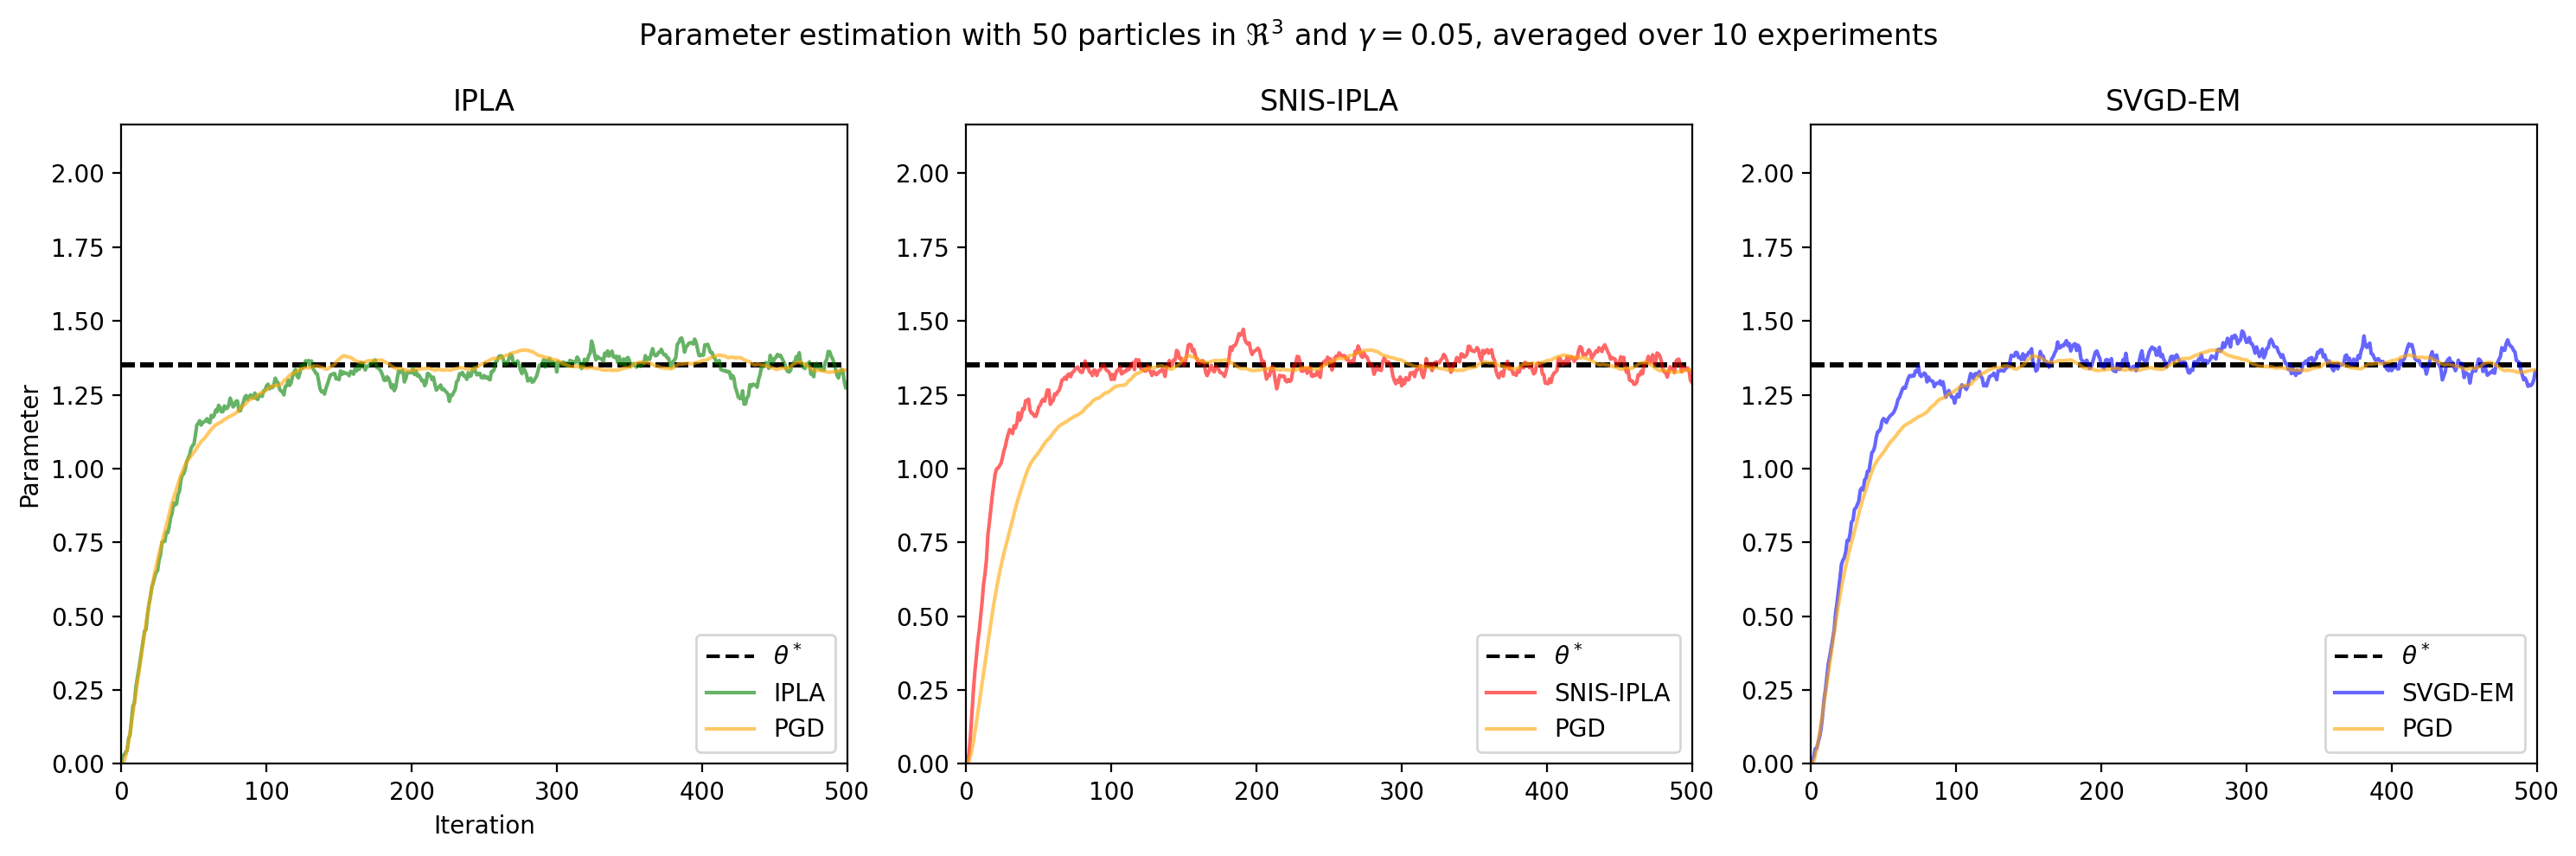

In [184]:
# Plot the results
# make two subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))


ax1.hlines(best_theta, 0, nsteps+1, linestyles="dashed", color = "black", label="$\\theta^*$")
ax2.hlines(best_theta, 0, nsteps+1, linestyles="dashed", color = "black", label="$\\theta^*$")
ax3.hlines(best_theta, 0, nsteps+1, linestyles="dashed", color = "black", label="$\\theta^*$")
ax1.plot(average_thetas_dict["IPLA"], color = "green", label="IPLA", alpha=0.6)
ax2.plot(average_thetas_dict["SNIS-IPLA"], color = "red", label="SNIS-IPLA", alpha=0.6)
ax3.plot(average_thetas_dict["SVGD-EM"], color = "blue", label="SVGD-EM", alpha=0.6)
ax1.plot(average_thetas_dict["PGD"], color = "orange", label="PGD", alpha=0.6)
ax2.plot(average_thetas_dict["PGD"], color = "orange", label="PGD", alpha=0.6)
ax3.plot(average_thetas_dict["PGD"], color = "orange", label="PGD", alpha=0.6)
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Parameter')
ax1.set_xlim([0, nsteps])
ax1.set_ylim([0, 1.6*y.mean()])
ax1.set_title(f'IPLA')
ax1.legend(loc="lower right")
ax2.set_title(f'SNIS-IPLA')
ax2.legend(loc="lower right")
ax2.set_xlim([0, nsteps])
ax2.set_ylim([0, 1.6*y.mean()])
ax3.set_title(f'SVGD-EM')
ax3.legend(loc="lower right")
ax3.set_xlim([0, nsteps])
ax3.set_ylim([0, 1.6*y.mean()])

#ax1.set_yscale("log")
#ax2.set_yscale("log")
fig.suptitle(f"Parameter estimation with {Nparticles} particles in $\Re^{{{D}}}$ and $\gamma = {gamma_experiments}$, averaged over {nexperiments} experiments")
fig.tight_layout()
plt.show()

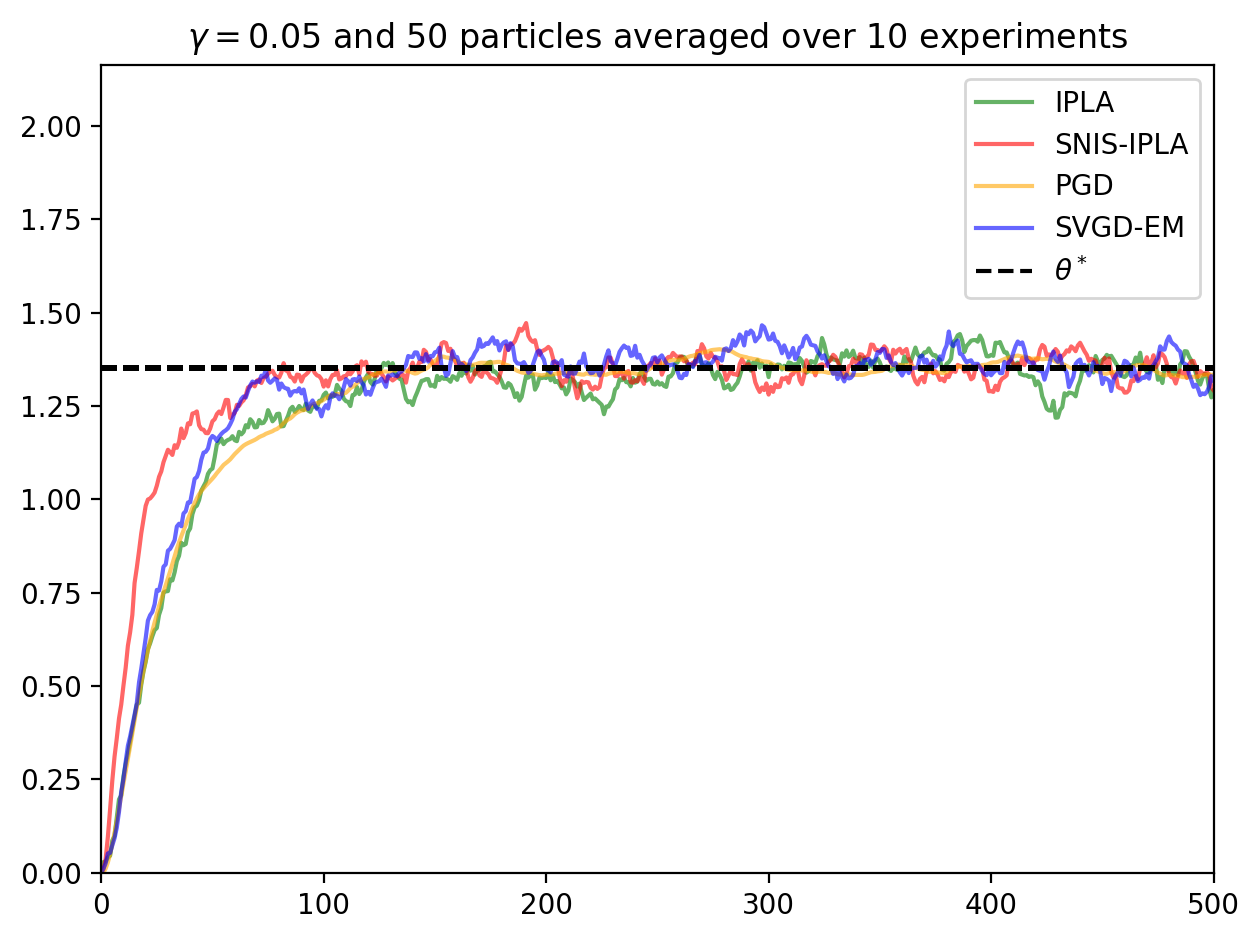

In [185]:
plt.plot(average_thetas_dict["IPLA"], color = "green", label="IPLA", alpha=0.6)
plt.plot(average_thetas_dict["SNIS-IPLA"], color = "red", label="SNIS-IPLA", alpha=0.6)
plt.plot(average_thetas_dict["PGD"], color = "orange", label="PGD", alpha=0.6)
plt.plot(average_thetas_dict["SVGD-EM"], color = "blue", label="SVGD-EM", alpha=0.6)
plt.hlines(best_theta, 0, nsteps+1, linestyles="dashed", label = "$\\theta^*$", color="black")
plt.title(f"$\gamma = {gamma_experiments}$ and {Nparticles} particles averaged over {nexperiments} experiments")
plt.xlim([0, nsteps])
plt.ylim([0, 1.6*y.mean()])
plt.legend()
plt.tight_layout()
plt.show()

In [189]:
np.mean(SNIS_IPLA_test.ESS_arr)

4.815520814714633

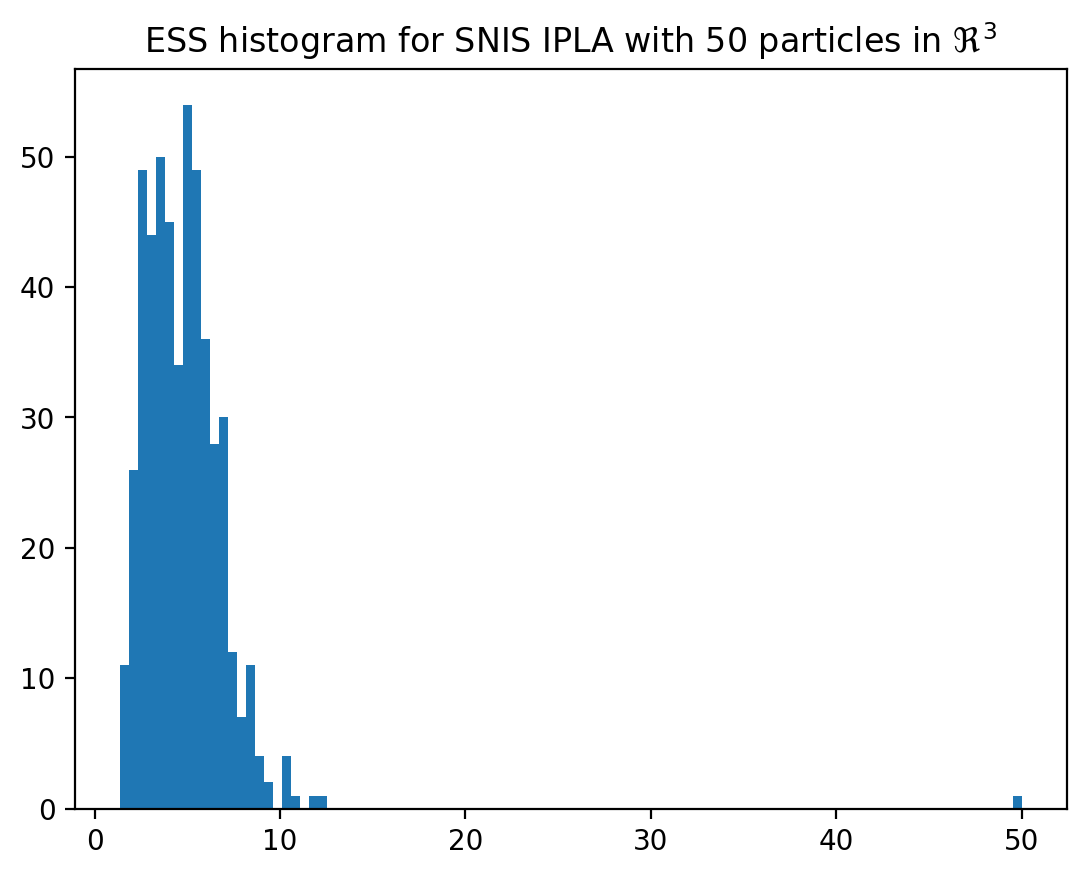

In [186]:
plt.hist(SNIS_IPLA_test.ESS_arr, bins=100)
plt.title(f"ESS histogram for SNIS IPLA with {Nparticles} particles in $\Re^{{{D}}}$")

plt.show()

Our iterates are of the form:

\begin{align*}
\theta_{k+1} &= \theta_n - \gamma \sum_{i=1}^N W_i^k \nabla_{\theta}U(\theta_k, X_i^k) + \sqrt{\frac{2\gamma}{N}}N_k\\
X_i^{k+1} &= X_i^k - \gamma \nabla_{X}U(\theta_k, X_i^k) + \sqrt{2\gamma}N_i^k
\end{align*}
Where:

$$
W_i^k = \frac{\exp(- U(\theta_k,X_i^k))}{\sum_{j=1}^{N} \exp(-U(\theta_k,X_j^k))}
$$

We can then rewrite the $\theta$ update as:
\begin{align*}
\theta_{k+1} &= \theta_n + \frac{\gamma}{\sum_{j=1}^{N} \exp(-U(\theta_k,X_j^k))} \sum_{i=1}^N \nabla_\theta\exp(- U(\theta_k,X_i^k)) + \sqrt{\frac{2\gamma}{N}}N_k\\
X_i^{k+1} &= X_i^k - \gamma \nabla_{X}U(\theta_k, X_i^k) + \sqrt{2\gamma}N_i^k
\end{align*}

Recall that $U(\theta, X)=-\log p(\theta, X)$, so $p(\theta,\,X_i^k) = \exp(- U(\theta_k,X_i^k))$ and $\nabla_\theta\exp(- U(\theta_k,X_i^k)) = \nabla_\theta p(\theta,\,X_i^k)$. Hence:
\begin{align*}
\theta_{k+1} &= \theta_n + \frac{\gamma}{\sum_{j=1}^{N} p(\theta,\,X_j^k)} \sum_{i=1}^N \nabla_\theta p(\theta,\,X_i^k) + \sqrt{\frac{2\gamma}{N}}N_k\\
X_i^{k+1} &= X_i^k - \gamma \nabla_{X}U(\theta_k, X_i^k) + \sqrt{2\gamma}N_i^k
\end{align*}

## Logistic Regression

In [149]:
D = 9
nsteps = 500
Nparticles = 15
X0 = np.zeros((D, Nparticles))
th0  = np.array([0.0])
nexperiments_regression = 1
grads_U_IPLA_regression = (ave_grad_U_theta_regression, grad_U_X_regression)
grads_U_SNIS_regression = (grad_U_theta_regression, grad_U_X_regression)
gamma_experiments_regression = 1e-2
average_thetas_dict_regression = {"PGD": np.zeros((nsteps+1,1)), "IPLA": np.zeros((nsteps+1,1)),"SNIS-IPLA": np.zeros((nsteps+1,1)), "SVGD-EM": np.zeros((nsteps+1,1))}
for experiment in tqdm(range(nexperiments_regression)):
    PGD_test_regression = PGD(th0, X0, grads_U_IPLA_regression, gamma=gamma_experiments_regression, y=y_train)
    IPLA_test_regression = IPLA(th0, X0, grads_U_IPLA_regression, gamma=gamma_experiments_regression, y=y_train)
    SNIS_IPLA_test_regression = SNIS_IPLA(th0, X0, U_regression, grads_U_SNIS_regression, gamma=gamma_experiments_regression, test=False, y=y_train)
    #SVGD_EM_test_regression = SVGD_EM(th0, X0, grads_U_IPLA_regression, exponential_kernel, grad_exponential_kernel_x1, gamma=gamma_experiments_regression, noise=1, y=y_train)
    for i in tqdm(range(nsteps)):
        PGD_test_regression.iterate()
        #print(np.shape(PGD_test_regression.X))
        IPLA_test_regression.iterate()
        SNIS_IPLA_test_regression.iterate()
        #SVGD_EM_test_regression.iterate()
        # print dimension of X 

    average_thetas_dict["PGD"] = average_thetas_dict["PGD"] + 1/nexperiments * np.array(PGD_test_regression.thetas)
    average_thetas_dict["IPLA"] = average_thetas_dict["IPLA"] + 1/nexperiments * np.array(IPLA_test_regression.thetas)
    average_thetas_dict["SNIS-IPLA"] = average_thetas_dict["SNIS-IPLA"] + 1/nexperiments * np.array(SNIS_IPLA_test_regression.thetas)
    average_thetas_dict["SVGD-EM"] = average_thetas_dict["SVGD-EM"] + 1/nexperiments * np.array(SVGD_EM_test_regression.thetas)


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/82/t8qzqs6x2f19402hdk543xd80000gn/T/ipykernel_78174/423465059.py:9: RuntimeWarning: overflow encountered in exp
  return  np.sum(-l*f + f*(np.exp(np.dot(f, Xi))/(1 + np.exp(np.dot(f, Xi)))).reshape(-1,1), axis=0) - (2/5)*(np.ones(Dx)*theta - Xi)
/var/folders/82/t8qzqs6x2f19402hdk543xd80000gn/T/ipykernel_78174/423465059.py:9: RuntimeWarning: invalid value encountered in divide
  return  np.sum(-l*f + f*(np.exp(np.dot(f, Xi))/(1 + np.exp(np.dot(f, Xi)))).reshape(-1,1), axis=0) - (2/5)*(np.ones(Dx)*theta - Xi)
/var/folders/82/t8qzqs6x2f19402hdk543xd80000gn/T/ipykernel_78174/423465059.py:24: RuntimeWarning: overflow encountered in exp
  return np.sum(np.log(1+np.exp(np.dot(f, Xi))) - l*np.dot(f, Xi)) + (1/5)*np.dot(theta - Xi, theta - Xi)
100%|██████████| 500/500 [00:05<00:00, 92.89it/s]
/var/folders/82/t8qzqs6x2f19402hdk543xd80000gn/T/ipykernel_78174/346332582.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequenc